In [ ]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
from tqdm import tqdm

In [ ]:
categories = ['punk_rock', 'work', 'work_out', 'formal', 'casual']

In [ ]:
dfs = []
path = '/content/drive/My Drive/data/'
for category in categories:
    pr = pd.read_json(f'{path}/{category}_data.json')
    dfs1 = []
    for items_list in pr['items']:
        df = pd.DataFrame(items_list)
        df['category'] = [category] * len(df)
        dfs1.append(df)
    dfs.append(pd.concat(dfs1))
    
df = pd.concat(dfs)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4392 entries, 0 to 7
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   index        4392 non-null   int64  
 1   brand        2259 non-null   object 
 2   name         4392 non-null   object 
 3   price        2432 non-null   object 
 4   likes        4309 non-null   float64
 5   product_url  4392 non-null   object 
 6   image_url    4392 non-null   object 
 7   image_path   4392 non-null   object 
 8   set_id       4392 non-null   object 
 9   category     4392 non-null   object 
dtypes: float64(1), int64(1), object(8)
memory usage: 377.4+ KB


In [ ]:
def process_brands(brand):
    try:
        return brand.lower().replace(' ', '')
    except:
        return

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 <a list of 10 Text major ticklabel objects>)

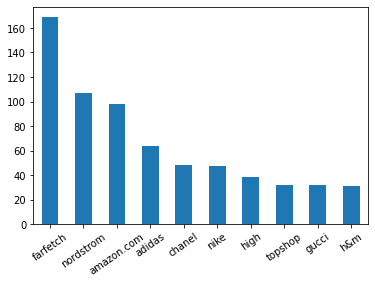

In [ ]:
top_brands = df['brand'].apply(process_brands).value_counts()[:10]
top_brands.plot.bar()
plt.xticks(rotation=35)

# Detector/Filter


In [ ]:
#@title Imports and function definitions

# For running inference on the TF-Hub module.
import tensorflow as tf

import tensorflow_hub as hub

# For downloading the image.
import matplotlib.pyplot as plt
import tempfile
from six.moves.urllib.request import urlopen
from six import BytesIO

# For drawing onto the image.
import numpy as np
from PIL import Image
from PIL import ImageColor
from PIL import ImageDraw
from PIL import ImageFont
from PIL import ImageOps

# For measuring the inference time.
import time

# Print Tensorflow version
print(tf.__version__)

# Check available GPU devices.
print("The following GPU devices are available: %s" % tf.test.gpu_device_name())

2.3.0
The following GPU devices are available: /device:GPU:0


In [ ]:
def display_image(image):
    fig = plt.figure(figsize=(20, 15))
    plt.grid(False)
    plt.imshow(image)


def download_and_resize_image(url, new_width=256, new_height=256,
                              display=False):
    _, filename = tempfile.mkstemp(suffix=".jpg")
    response = urlopen(url)
    image_data = response.read()
    image_data = BytesIO(image_data)
    pil_image = Image.open(image_data)
    pil_image = ImageOps.fit(pil_image, (new_width, new_height), Image.ANTIALIAS)
    pil_image_rgb = pil_image.convert("RGB")
    pil_image_rgb.save(filename, format="JPEG", quality=90)
    print("Image downloaded to %s." % filename)
    if display:
        display_image(pil_image)
    return filename


def draw_bounding_box_on_image(image,
                               ymin,
                               xmin,
                               ymax,
                               xmax,
                               color,
                               font,
                               thickness=4,
                               display_str_list=()):
    """Adds a bounding box to an image."""
    draw = ImageDraw.Draw(image)
    im_width, im_height = image.size
    (left, right, top, bottom) = (xmin * im_width, xmax * im_width,
                                ymin * im_height, ymax * im_height)
    draw.line([(left, top), (left, bottom), (right, bottom), (right, top),
             (left, top)],
            width=thickness,
            fill=color)

    # If the total height of the display strings added to the top of the bounding
    # box exceeds the top of the image, stack the strings below the bounding box
    # instead of above.
    display_str_heights = [font.getsize(ds)[1] for ds in display_str_list]
    # Each display_str has a top and bottom margin of 0.05x.
    total_display_str_height = (1 + 2 * 0.05) * sum(display_str_heights)

    if top > total_display_str_height:
        text_bottom = top
    else:
        text_bottom = top + total_display_str_height
    # Reverse list and print from bottom to top.
    for display_str in display_str_list[::-1]:
        text_width, text_height = font.getsize(display_str)
        margin = np.ceil(0.05 * text_height)
        draw.rectangle([(left, text_bottom - text_height - 2 * margin),
                        (left + text_width, text_bottom)],
                       fill=color)
        draw.text((left + margin, text_bottom - text_height - margin),
                  display_str,
                  fill="black",
                  font=font)
        text_bottom -= text_height - 2 * margin


def draw_boxes(image, boxes, class_names, scores, max_boxes=10, min_score=0.1):
    """Overlay labeled boxes on an image with formatted scores and label names."""
    colors = list(ImageColor.colormap.values())

    try:
        font = ImageFont.truetype("/usr/share/fonts/truetype/liberation/LiberationSansNarrow-Regular.ttf",
                              25)
    except IOError:
        print("Font not found, using default font.")
        font = ImageFont.load_default()

    for i in range(min(boxes.shape[0], max_boxes)):
        if scores[i] >= min_score:
            ymin, xmin, ymax, xmax = tuple(boxes[i])
            display_str = "{}: {}%".format(class_names[i].decode("ascii"),
                                         int(100 * scores[i]))
            color = colors[hash(class_names[i]) % len(colors)]
            image_pil = Image.fromarray(np.uint8(image)).convert("RGB")
            draw_bounding_box_on_image(
              image_pil,
              ymin,
              xmin,
              ymax,
              xmax,
              color,
              font,
              display_str_list=[display_str])
        np.copyto(image, np.array(image_pil))
    return image

In [ ]:
module_handle = "https://tfhub.dev/google/openimages_v4/ssd/mobilenet_v2/1" #@param ["https://tfhub.dev/google/openimages_v4/ssd/mobilenet_v2/1", "https://tfhub.dev/google/faster_rcnn/openimages_v4/inception_resnet_v2/1"]

detector = hub.load(module_handle).signatures['default']

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


In [ ]:
def load_img(path):
    img = tf.io.read_file(path)
    img = tf.image.decode_jpeg(img, channels=3)
    return img

def run_detector(detector, path):
    img = load_img(path)

    converted_img  = tf.image.convert_image_dtype(img, tf.float32)[tf.newaxis, ...]
    start_time = time.time()
    result = detector(converted_img)
    end_time = time.time()

    result = {key:value.numpy() for key,value in result.items()}

    print("Found %d objects." % len(result["detection_scores"]))
    print("Inference time: ", end_time-start_time)

    image_with_boxes = draw_boxes(
      img.numpy(), result["detection_boxes"],
      result["detection_class_entities"], result["detection_scores"])

    display_image(image_with_boxes)
    return (result['detection_class_entities'][:5], result['detection_scores'][:5])

In [ ]:
options = ['Bag', 'Handbag', 'Clothing', 'Jeans', 'Trousers', 'Skirt',
              'Skirt', 'Shirt', 'Shoe', 'Boots', 'Dress', 'Hat', 'Footwear', 
              'High Heels', 'Sandal', 'Glasses', 'Sunglasses', 'Cap',
           'Coat', 'Suit', 'Jacket', 'Blazer', ]

In [ ]:
path = '/content/drive/My Drive/data/images/'
df['full_path'] = path+df['category']+'/'+df['image_path']

In [ ]:
clothing_item = []
for image in tqdm(df['full_path']):
    try:
        detected = [item.decode('utf-8') for item in run_detector(detector, image)[0]]

        if set(options).intersection(set(detected)):
            clothing_item.append(1)
        else:
            clothing_item.append(0)
    except:
        clothing_item.append(None)

  0%|          | 1/4392 [00:05<6:46:25,  5.55s/it]

Found 100 objects.
Inference time:  5.462448358535767


  0%|          | 2/4392 [00:05<4:51:23,  3.98s/it]

Found 100 objects.
Inference time:  0.2647867202758789


  0%|          | 3/4392 [00:06<3:30:00,  2.87s/it]

Found 100 objects.
Inference time:  0.23538661003112793


  0%|          | 4/4392 [00:06<2:33:16,  2.10s/it]

Found 100 objects.
Inference time:  0.2523057460784912


  0%|          | 5/4392 [00:06<1:53:37,  1.55s/it]

Found 100 objects.
Inference time:  0.2471928596496582


  0%|          | 6/4392 [00:06<1:25:31,  1.17s/it]

Found 100 objects.
Inference time:  0.23951101303100586


  0%|          | 7/4392 [00:07<1:06:22,  1.10it/s]

Found 100 objects.
Inference time:  0.26084399223327637


  0%|          | 8/4392 [00:08<1:06:29,  1.10it/s]

Found 100 objects.
Inference time:  0.24197006225585938


  0%|          | 9/4392 [00:08<52:47,  1.38it/s]  

Found 100 objects.
Inference time:  0.2512850761413574


  0%|          | 10/4392 [00:08<43:46,  1.67it/s]

Found 100 objects.
Inference time:  0.25977349281311035


  0%|          | 11/4392 [00:09<36:32,  2.00it/s]

Found 100 objects.
Inference time:  0.23537611961364746


  0%|          | 12/4392 [00:09<32:29,  2.25it/s]

Found 100 objects.
Inference time:  0.2472691535949707


  0%|          | 13/4392 [00:09<30:12,  2.42it/s]

Found 100 objects.
Inference time:  0.2735598087310791


  0%|          | 14/4392 [00:10<36:10,  2.02it/s]

Found 100 objects.
Inference time:  0.25424861907958984


  0%|          | 15/4392 [00:10<32:26,  2.25it/s]

Found 100 objects.
Inference time:  0.2567429542541504


  0%|          | 16/4392 [00:11<36:12,  2.01it/s]

Found 100 objects.
Inference time:  0.24756813049316406


  0%|          | 17/4392 [00:11<31:59,  2.28it/s]

Found 100 objects.
Inference time:  0.24964690208435059


  0%|          | 19/4392 [00:11<25:53,  2.81it/s]

Found 100 objects.
Inference time:  0.2652168273925781


  0%|          | 20/4392 [00:12<25:06,  2.90it/s]

Found 100 objects.
Inference time:  0.2590663433074951


  0%|          | 21/4392 [00:12<24:13,  3.01it/s]

Found 100 objects.
Inference time:  0.2564272880554199


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  
  1%|          | 22/4392 [00:13<31:33,  2.31it/s]

Found 100 objects.
Inference time:  0.24921178817749023


  1%|          | 23/4392 [00:13<36:21,  2.00it/s]

Found 100 objects.
Inference time:  0.2629222869873047


  1%|          | 24/4392 [00:14<38:07,  1.91it/s]

Found 100 objects.
Inference time:  0.2570502758026123


  1%|          | 25/4392 [00:15<40:45,  1.79it/s]

Found 100 objects.
Inference time:  0.2567787170410156


  1%|          | 26/4392 [00:15<43:03,  1.69it/s]

Found 100 objects.
Inference time:  0.2649266719818115


  1%|          | 27/4392 [00:16<36:58,  1.97it/s]

Found 100 objects.
Inference time:  0.2543671131134033


  1%|          | 28/4392 [00:16<44:09,  1.65it/s]

Found 100 objects.
Inference time:  0.24922513961791992


  1%|          | 29/4392 [00:17<37:53,  1.92it/s]

Found 100 objects.
Inference time:  0.27574753761291504


  1%|          | 30/4392 [00:17<33:52,  2.15it/s]

Found 100 objects.
Inference time:  0.2887911796569824


  1%|          | 31/4392 [00:18<31:41,  2.29it/s]

Found 100 objects.
Inference time:  0.2711331844329834


  1%|          | 32/4392 [00:18<28:25,  2.56it/s]

Found 100 objects.
Inference time:  0.25475287437438965


  1%|          | 33/4392 [00:19<45:43,  1.59it/s]

Found 100 objects.
Inference time:  0.2697451114654541


  1%|          | 34/4392 [00:19<39:51,  1.82it/s]

Found 100 objects.
Inference time:  0.279771089553833


  1%|          | 35/4392 [00:20<35:19,  2.06it/s]

Found 100 objects.
Inference time:  0.2810192108154297


  1%|          | 36/4392 [00:20<31:08,  2.33it/s]

Found 100 objects.
Inference time:  0.247406005859375


  1%|          | 37/4392 [00:20<30:08,  2.41it/s]

Found 100 objects.
Inference time:  0.30475735664367676


  1%|          | 38/4392 [00:21<29:01,  2.50it/s]

Found 100 objects.
Inference time:  0.27599668502807617


  1%|          | 39/4392 [00:21<32:29,  2.23it/s]

Found 100 objects.
Inference time:  0.2291560173034668


  1%|          | 40/4392 [00:22<35:49,  2.02it/s]

Found 100 objects.
Inference time:  0.24385452270507812


  1%|          | 41/4392 [00:22<31:37,  2.29it/s]

Found 100 objects.
Inference time:  0.2585721015930176


  1%|          | 42/4392 [00:23<35:10,  2.06it/s]

Found 100 objects.
Inference time:  0.26099681854248047


  1%|          | 43/4392 [00:23<30:34,  2.37it/s]

Found 100 objects.
Inference time:  0.25595641136169434


  1%|          | 44/4392 [00:23<28:01,  2.59it/s]

Found 100 objects.
Inference time:  0.2605142593383789


  1%|          | 45/4392 [00:24<26:02,  2.78it/s]

Found 100 objects.
Inference time:  0.2677288055419922


  1%|          | 46/4392 [00:24<25:29,  2.84it/s]

Found 100 objects.
Inference time:  0.2720973491668701


  1%|          | 47/4392 [00:24<24:59,  2.90it/s]

Found 100 objects.
Inference time:  0.2780165672302246


  1%|          | 48/4392 [00:25<24:46,  2.92it/s]

Found 100 objects.
Inference time:  0.2488539218902588


  1%|          | 49/4392 [00:25<31:45,  2.28it/s]

Found 100 objects.
Inference time:  0.24245190620422363


  1%|          | 50/4392 [00:26<29:40,  2.44it/s]

Found 100 objects.
Inference time:  0.28270387649536133


  1%|          | 51/4392 [00:26<36:45,  1.97it/s]

Found 100 objects.
Inference time:  0.2686457633972168


  1%|          | 52/4392 [00:27<32:12,  2.25it/s]

Found 100 objects.
Inference time:  0.2541828155517578


  1%|          | 53/4392 [00:27<35:14,  2.05it/s]

Found 100 objects.
Inference time:  0.2761805057525635


  1%|          | 54/4392 [00:28<38:56,  1.86it/s]

Found 100 objects.
Inference time:  0.2543635368347168


  1%|▏         | 55/4392 [00:29<41:44,  1.73it/s]

Found 100 objects.
Inference time:  0.2504003047943115


  1%|▏         | 56/4392 [00:29<35:44,  2.02it/s]

Found 100 objects.
Inference time:  0.24999070167541504


  1%|▏         | 57/4392 [00:30<38:53,  1.86it/s]

Found 100 objects.
Inference time:  0.2661428451538086


  1%|▏         | 58/4392 [00:30<34:45,  2.08it/s]

Found 100 objects.
Inference time:  0.3083775043487549


  1%|▏         | 59/4392 [00:31<39:17,  1.84it/s]

Found 100 objects.
Inference time:  0.2697017192840576


  1%|▏         | 60/4392 [00:31<40:35,  1.78it/s]

Found 100 objects.
Inference time:  0.2508721351623535


  1%|▏         | 61/4392 [00:32<49:05,  1.47it/s]

Found 100 objects.
Inference time:  0.27979254722595215


  1%|▏         | 62/4392 [00:33<46:17,  1.56it/s]

Found 100 objects.
Inference time:  0.25998759269714355


  1%|▏         | 63/4392 [00:33<44:15,  1.63it/s]

Found 100 objects.
Inference time:  0.2420506477355957


  1%|▏         | 64/4392 [00:34<43:47,  1.65it/s]

Found 100 objects.
Inference time:  0.2732274532318115


  1%|▏         | 65/4392 [00:34<44:32,  1.62it/s]

Found 100 objects.
Inference time:  0.25327301025390625


  2%|▏         | 66/4392 [00:35<37:57,  1.90it/s]

Found 100 objects.
Inference time:  0.25512075424194336


  2%|▏         | 67/4392 [00:36<42:11,  1.71it/s]

Found 100 objects.
Inference time:  0.2556295394897461


  2%|▏         | 68/4392 [00:36<42:14,  1.71it/s]

Found 100 objects.
Inference time:  0.26528501510620117


  2%|▏         | 69/4392 [00:37<45:06,  1.60it/s]

Found 100 objects.
Inference time:  0.2738473415374756


  2%|▏         | 70/4392 [00:39<1:10:53,  1.02it/s]

Found 100 objects.
Inference time:  0.2737250328063965


  2%|▏         | 71/4392 [00:39<55:51,  1.29it/s]  

Found 100 objects.
Inference time:  0.26096487045288086


  2%|▏         | 72/4392 [00:39<45:44,  1.57it/s]

Found 100 objects.
Inference time:  0.2520263195037842


  2%|▏         | 73/4392 [00:40<38:46,  1.86it/s]

Found 100 objects.
Inference time:  0.25211048126220703


  2%|▏         | 74/4392 [00:40<40:53,  1.76it/s]

Found 100 objects.
Inference time:  0.27090978622436523


  2%|▏         | 75/4392 [00:41<35:29,  2.03it/s]

Found 100 objects.
Inference time:  0.25308847427368164


  2%|▏         | 76/4392 [00:41<31:22,  2.29it/s]

Found 100 objects.
Inference time:  0.25606346130371094


  2%|▏         | 77/4392 [00:41<34:50,  2.06it/s]

Found 100 objects.
Inference time:  0.255354642868042


  2%|▏         | 78/4392 [00:42<32:04,  2.24it/s]

Found 100 objects.
Inference time:  0.32024550437927246


  2%|▏         | 79/4392 [00:43<39:25,  1.82it/s]

Found 100 objects.
Inference time:  0.23740673065185547


  2%|▏         | 80/4392 [00:43<34:13,  2.10it/s]

Found 100 objects.
Inference time:  0.24582624435424805


  2%|▏         | 81/4392 [00:44<40:05,  1.79it/s]

Found 100 objects.
Inference time:  0.24037957191467285


  2%|▏         | 82/4392 [00:44<34:50,  2.06it/s]

Found 100 objects.
Inference time:  0.2780921459197998


  2%|▏         | 83/4392 [00:44<31:28,  2.28it/s]

Found 100 objects.
Inference time:  0.2766866683959961


  2%|▏         | 84/4392 [00:45<37:15,  1.93it/s]

Found 100 objects.
Inference time:  0.2461400032043457


  2%|▏         | 85/4392 [00:46<39:39,  1.81it/s]

Found 100 objects.
Inference time:  0.2514638900756836


  2%|▏         | 86/4392 [00:46<34:10,  2.10it/s]

Found 100 objects.
Inference time:  0.2542440891265869


  2%|▏         | 87/4392 [00:46<30:50,  2.33it/s]

Found 100 objects.
Inference time:  0.25142669677734375


  2%|▏         | 89/4392 [00:47<25:04,  2.86it/s]

Found 100 objects.
Inference time:  0.2646677494049072


  2%|▏         | 91/4392 [00:47<25:25,  2.82it/s]

Found 100 objects.
Inference time:  0.2453007698059082


  2%|▏         | 92/4392 [00:48<24:27,  2.93it/s]

Found 100 objects.
Inference time:  0.2548863887786865


  2%|▏         | 93/4392 [00:48<23:39,  3.03it/s]

Found 100 objects.
Inference time:  0.28682470321655273


  2%|▏         | 94/4392 [00:48<23:47,  3.01it/s]

Found 100 objects.
Inference time:  0.29113054275512695


  2%|▏         | 95/4392 [00:49<41:48,  1.71it/s]

Found 100 objects.
Inference time:  0.24340271949768066


  2%|▏         | 96/4392 [00:50<36:20,  1.97it/s]

Found 100 objects.
Inference time:  0.24797439575195312


  2%|▏         | 97/4392 [00:50<31:30,  2.27it/s]

Found 100 objects.
Inference time:  0.24706029891967773


  2%|▏         | 98/4392 [00:50<28:22,  2.52it/s]

Found 100 objects.
Inference time:  0.24904680252075195


  2%|▏         | 99/4392 [00:51<26:44,  2.68it/s]

Found 100 objects.
Inference time:  0.2546069622039795


  2%|▏         | 100/4392 [00:51<25:20,  2.82it/s]

Found 100 objects.
Inference time:  0.24963760375976562


  2%|▏         | 101/4392 [00:52<32:27,  2.20it/s]

Found 100 objects.
Inference time:  0.24098539352416992


  2%|▏         | 102/4392 [00:52<37:11,  1.92it/s]

Found 100 objects.
Inference time:  0.2485954761505127


  2%|▏         | 103/4392 [00:53<32:13,  2.22it/s]

Found 100 objects.
Inference time:  0.24526333808898926


  2%|▏         | 104/4392 [00:53<29:29,  2.42it/s]

Found 100 objects.
Inference time:  0.28285956382751465


  2%|▏         | 105/4392 [00:54<35:26,  2.02it/s]

Found 100 objects.
Inference time:  0.2790980339050293


  2%|▏         | 106/4392 [00:54<32:34,  2.19it/s]

Found 100 objects.
Inference time:  0.2971336841583252


  2%|▏         | 107/4392 [00:54<29:54,  2.39it/s]

Found 100 objects.
Inference time:  0.2827720642089844


  2%|▏         | 108/4392 [00:55<27:19,  2.61it/s]

Found 100 objects.
Inference time:  0.24833440780639648


  2%|▏         | 109/4392 [00:55<25:42,  2.78it/s]

Found 100 objects.
Inference time:  0.25904321670532227


  3%|▎         | 110/4392 [00:55<24:22,  2.93it/s]

Found 100 objects.
Inference time:  0.25215673446655273


  3%|▎         | 111/4392 [00:56<23:42,  3.01it/s]

Found 100 objects.
Inference time:  0.2622990608215332


  3%|▎         | 112/4392 [00:56<23:49,  2.99it/s]

Found 100 objects.
Inference time:  0.2943873405456543


  3%|▎         | 113/4392 [00:57<32:57,  2.16it/s]

Found 100 objects.
Inference time:  0.24225401878356934


  3%|▎         | 114/4392 [00:57<37:01,  1.93it/s]

Found 100 objects.
Inference time:  0.24982142448425293


  3%|▎         | 115/4392 [00:58<38:02,  1.87it/s]

Found 100 objects.
Inference time:  0.2502880096435547


  3%|▎         | 116/4392 [00:58<39:14,  1.82it/s]

Found 100 objects.
Inference time:  0.26996707916259766


  3%|▎         | 117/4392 [00:59<44:15,  1.61it/s]

Found 100 objects.
Inference time:  0.2737007141113281


  3%|▎         | 118/4392 [01:00<45:20,  1.57it/s]

Found 100 objects.
Inference time:  0.2598598003387451


  3%|▎         | 119/4392 [01:00<44:55,  1.59it/s]

Found 100 objects.
Inference time:  0.26751279830932617


  3%|▎         | 120/4392 [01:01<50:05,  1.42it/s]

Found 100 objects.
Inference time:  0.23822665214538574


  3%|▎         | 121/4392 [01:02<48:52,  1.46it/s]

Found 100 objects.
Inference time:  0.30045533180236816


  3%|▎         | 122/4392 [01:02<40:52,  1.74it/s]

Found 100 objects.
Inference time:  0.25371265411376953


  3%|▎         | 123/4392 [01:03<34:52,  2.04it/s]

Found 100 objects.
Inference time:  0.26055335998535156


  3%|▎         | 124/4392 [01:03<37:35,  1.89it/s]

Found 100 objects.
Inference time:  0.2740025520324707


  3%|▎         | 125/4392 [01:04<39:16,  1.81it/s]

Found 100 objects.
Inference time:  0.26815366744995117


  3%|▎         | 126/4392 [01:04<34:46,  2.04it/s]

Found 100 objects.
Inference time:  0.29309988021850586


  3%|▎         | 127/4392 [01:04<31:05,  2.29it/s]

Found 100 objects.
Inference time:  0.2589406967163086


  3%|▎         | 128/4392 [01:05<27:57,  2.54it/s]

Found 100 objects.
Inference time:  0.2610177993774414


  3%|▎         | 129/4392 [01:05<26:20,  2.70it/s]

Found 100 objects.
Inference time:  0.2533833980560303


  3%|▎         | 130/4392 [01:05<24:53,  2.85it/s]

Found 100 objects.
Inference time:  0.25983262062072754


  3%|▎         | 131/4392 [01:06<23:55,  2.97it/s]

Found 100 objects.
Inference time:  0.26526618003845215


  3%|▎         | 132/4392 [01:06<30:29,  2.33it/s]

Found 100 objects.
Inference time:  0.23851799964904785


  3%|▎         | 133/4392 [01:07<28:29,  2.49it/s]

Found 100 objects.
Inference time:  0.2774837017059326


  3%|▎         | 134/4392 [01:07<33:16,  2.13it/s]

Found 100 objects.
Inference time:  0.2482137680053711


  3%|▎         | 135/4392 [01:08<30:29,  2.33it/s]

Found 100 objects.
Inference time:  0.26352453231811523


  3%|▎         | 136/4392 [01:08<37:15,  1.90it/s]

Found 100 objects.
Inference time:  0.2525489330291748


  3%|▎         | 137/4392 [01:09<33:13,  2.13it/s]

Found 100 objects.
Inference time:  0.2923624515533447


  3%|▎         | 138/4392 [01:10<40:13,  1.76it/s]

Found 100 objects.
Inference time:  0.24675726890563965


  3%|▎         | 139/4392 [01:10<44:43,  1.58it/s]

Found 100 objects.
Inference time:  0.27005600929260254


  3%|▎         | 140/4392 [01:11<47:22,  1.50it/s]

Found 100 objects.
Inference time:  0.275313138961792


  3%|▎         | 141/4392 [01:12<48:34,  1.46it/s]

Found 100 objects.
Inference time:  0.2683749198913574


  3%|▎         | 142/4392 [01:12<47:24,  1.49it/s]

Found 100 objects.
Inference time:  0.23731207847595215


  3%|▎         | 143/4392 [01:13<40:47,  1.74it/s]

Found 100 objects.
Inference time:  0.27695202827453613


  3%|▎         | 144/4392 [01:13<42:26,  1.67it/s]

Found 100 objects.
Inference time:  0.2527949810028076


  3%|▎         | 145/4392 [01:14<46:28,  1.52it/s]

Found 100 objects.
Inference time:  0.26048874855041504


  3%|▎         | 146/4392 [01:15<38:40,  1.83it/s]

Found 100 objects.
Inference time:  0.23598790168762207
Found 100 objects.
Inference time:  0.24187612533569336


  3%|▎         | 148/4392 [01:16<49:02,  1.44it/s]

Found 100 objects.
Inference time:  0.2501869201660156


  3%|▎         | 149/4392 [01:17<48:02,  1.47it/s]

Found 100 objects.
Inference time:  0.24588704109191895


  3%|▎         | 150/4392 [01:18<47:58,  1.47it/s]

Found 100 objects.
Inference time:  0.24551105499267578


  3%|▎         | 151/4392 [01:18<48:21,  1.46it/s]

Found 100 objects.
Inference time:  0.26461029052734375


  3%|▎         | 152/4392 [01:19<39:36,  1.78it/s]

Found 100 objects.
Inference time:  0.24281573295593262


  3%|▎         | 153/4392 [01:19<34:08,  2.07it/s]

Found 100 objects.
Inference time:  0.27492737770080566


  4%|▎         | 154/4392 [01:19<30:04,  2.35it/s]

Found 100 objects.
Inference time:  0.251650333404541


  4%|▎         | 155/4392 [01:20<33:10,  2.13it/s]

Found 100 objects.
Inference time:  0.2532384395599365


  4%|▎         | 156/4392 [01:20<29:57,  2.36it/s]

Found 100 objects.
Inference time:  0.2714862823486328


  4%|▎         | 157/4392 [01:21<34:48,  2.03it/s]

Found 100 objects.
Inference time:  0.262176513671875


  4%|▎         | 158/4392 [01:21<37:19,  1.89it/s]

Found 100 objects.
Inference time:  0.25391411781311035


  4%|▎         | 159/4392 [01:22<32:27,  2.17it/s]

Found 100 objects.
Inference time:  0.2498157024383545


  4%|▎         | 160/4392 [01:22<29:35,  2.38it/s]

Found 100 objects.
Inference time:  0.2926902770996094


  4%|▎         | 161/4392 [01:22<27:37,  2.55it/s]

Found 100 objects.
Inference time:  0.29499197006225586


  4%|▎         | 162/4392 [01:23<25:48,  2.73it/s]

Found 100 objects.
Inference time:  0.25299763679504395


  4%|▎         | 163/4392 [01:23<24:18,  2.90it/s]

Found 100 objects.
Inference time:  0.24858689308166504


  4%|▎         | 164/4392 [01:23<23:16,  3.03it/s]

Found 100 objects.
Inference time:  0.26073598861694336


  4%|▍         | 165/4392 [01:23<22:08,  3.18it/s]

Found 100 objects.
Inference time:  0.24314618110656738


  4%|▍         | 166/4392 [01:24<21:53,  3.22it/s]

Found 100 objects.
Inference time:  0.2547464370727539


  4%|▍         | 167/4392 [01:24<21:42,  3.24it/s]

Found 100 objects.
Inference time:  0.2566797733306885


  4%|▍         | 168/4392 [01:25<27:59,  2.51it/s]

Found 100 objects.
Inference time:  0.24346160888671875


  4%|▍         | 169/4392 [01:25<25:57,  2.71it/s]

Found 100 objects.
Inference time:  0.2527904510498047


  4%|▍         | 170/4392 [01:25<24:15,  2.90it/s]

Found 100 objects.
Inference time:  0.2531111240386963


  4%|▍         | 171/4392 [01:26<32:33,  2.16it/s]

Found 100 objects.
Inference time:  0.2619187831878662


  4%|▍         | 172/4392 [01:26<29:09,  2.41it/s]

Found 100 objects.
Inference time:  0.25003957748413086


  4%|▍         | 173/4392 [01:27<26:01,  2.70it/s]

Found 100 objects.
Inference time:  0.24200844764709473


  4%|▍         | 174/4392 [01:27<24:26,  2.88it/s]

Found 100 objects.
Inference time:  0.24115920066833496


  4%|▍         | 175/4392 [01:27<30:26,  2.31it/s]

Found 100 objects.
Inference time:  0.2713320255279541


  4%|▍         | 176/4392 [01:28<27:13,  2.58it/s]

Found 100 objects.
Inference time:  0.2467801570892334


  4%|▍         | 177/4392 [01:28<25:15,  2.78it/s]

Found 100 objects.
Inference time:  0.25385522842407227


  4%|▍         | 178/4392 [01:29<30:50,  2.28it/s]

Found 100 objects.
Inference time:  0.24850916862487793


  4%|▍         | 179/4392 [01:29<36:21,  1.93it/s]

Found 100 objects.
Inference time:  0.2627434730529785


  4%|▍         | 180/4392 [01:30<32:00,  2.19it/s]

Found 100 objects.
Inference time:  0.26324033737182617


  4%|▍         | 181/4392 [01:30<29:17,  2.40it/s]

Found 100 objects.
Inference time:  0.2694547176361084


  4%|▍         | 182/4392 [01:30<27:27,  2.56it/s]

Found 100 objects.
Inference time:  0.2914745807647705


  4%|▍         | 183/4392 [01:31<32:03,  2.19it/s]

Found 100 objects.
Inference time:  0.24082517623901367


  4%|▍         | 184/4392 [01:31<29:43,  2.36it/s]

Found 100 objects.
Inference time:  0.2826573848724365


  4%|▍         | 185/4392 [01:32<27:02,  2.59it/s]

Found 100 objects.
Inference time:  0.24264907836914062


  4%|▍         | 186/4392 [01:32<25:24,  2.76it/s]

Found 100 objects.
Inference time:  0.2779512405395508


  4%|▍         | 187/4392 [01:32<24:44,  2.83it/s]

Found 100 objects.
Inference time:  0.30541229248046875


  4%|▍         | 188/4392 [01:33<23:46,  2.95it/s]

Found 100 objects.
Inference time:  0.27752256393432617


  4%|▍         | 189/4392 [01:33<31:49,  2.20it/s]

Found 100 objects.
Inference time:  0.261929988861084


  4%|▍         | 190/4392 [01:34<35:33,  1.97it/s]

Found 100 objects.
Inference time:  0.2667717933654785


  4%|▍         | 191/4392 [01:34<30:46,  2.28it/s]

Found 100 objects.
Inference time:  0.2509915828704834


  4%|▍         | 192/4392 [01:34<27:39,  2.53it/s]

Found 100 objects.
Inference time:  0.2568023204803467


  4%|▍         | 193/4392 [01:35<32:24,  2.16it/s]

Found 100 objects.
Inference time:  0.23206639289855957


  4%|▍         | 194/4392 [01:36<36:44,  1.90it/s]

Found 100 objects.
Inference time:  0.26554369926452637


  4%|▍         | 195/4392 [01:37<42:51,  1.63it/s]

Found 100 objects.
Inference time:  0.28103065490722656


  4%|▍         | 196/4392 [01:37<36:36,  1.91it/s]

Found 100 objects.
Inference time:  0.29007625579833984


  4%|▍         | 197/4392 [01:37<32:30,  2.15it/s]

Found 100 objects.
Inference time:  0.2879338264465332


  5%|▍         | 198/4392 [01:38<34:57,  2.00it/s]

Found 100 objects.
Inference time:  0.2428739070892334


  5%|▍         | 199/4392 [01:38<30:17,  2.31it/s]

Found 100 objects.
Inference time:  0.2423534393310547


  5%|▍         | 200/4392 [01:39<33:43,  2.07it/s]

Found 100 objects.
Inference time:  0.29233717918395996


  5%|▍         | 201/4392 [01:39<29:33,  2.36it/s]

Found 100 objects.
Inference time:  0.2405405044555664


  5%|▍         | 202/4392 [01:40<36:50,  1.90it/s]

Found 100 objects.
Inference time:  0.2526423931121826


  5%|▍         | 203/4392 [01:40<31:41,  2.20it/s]

Found 100 objects.
Inference time:  0.24891161918640137


  5%|▍         | 204/4392 [01:40<28:56,  2.41it/s]

Found 100 objects.
Inference time:  0.2928736209869385


  5%|▍         | 205/4392 [01:41<26:22,  2.65it/s]

Found 100 objects.
Inference time:  0.25704121589660645


  5%|▍         | 206/4392 [01:41<24:09,  2.89it/s]

Found 100 objects.
Inference time:  0.24488496780395508


  5%|▍         | 207/4392 [01:41<28:20,  2.46it/s]

Found 100 objects.
Inference time:  0.25693345069885254


  5%|▍         | 208/4392 [01:42<33:15,  2.10it/s]

Found 100 objects.
Inference time:  0.23767518997192383


  5%|▍         | 209/4392 [01:42<29:31,  2.36it/s]

Found 100 objects.
Inference time:  0.26474452018737793


  5%|▍         | 210/4392 [01:43<33:29,  2.08it/s]

Found 100 objects.
Inference time:  0.24616599082946777


  5%|▍         | 211/4392 [01:43<29:31,  2.36it/s]

Found 100 objects.
Inference time:  0.24737882614135742


  5%|▍         | 212/4392 [01:44<34:09,  2.04it/s]

Found 100 objects.
Inference time:  0.24257826805114746


  5%|▍         | 213/4392 [01:45<37:34,  1.85it/s]

Found 100 objects.
Inference time:  0.25220251083374023


  5%|▍         | 214/4392 [01:45<32:11,  2.16it/s]

Found 100 objects.
Inference time:  0.2468247413635254


  5%|▍         | 215/4392 [01:45<28:19,  2.46it/s]

Found 100 objects.
Inference time:  0.24114298820495605


  5%|▍         | 216/4392 [01:46<32:17,  2.16it/s]

Found 100 objects.
Inference time:  0.25684523582458496


  5%|▍         | 217/4392 [01:46<28:27,  2.45it/s]

Found 100 objects.
Inference time:  0.24018263816833496


  5%|▍         | 218/4392 [01:46<26:19,  2.64it/s]

Found 100 objects.
Inference time:  0.2592129707336426


  5%|▍         | 219/4392 [01:47<24:29,  2.84it/s]

Found 100 objects.
Inference time:  0.2515909671783447


  5%|▌         | 220/4392 [01:47<29:34,  2.35it/s]

Found 100 objects.
Inference time:  0.2854301929473877


  5%|▌         | 221/4392 [01:48<27:37,  2.52it/s]

Found 100 objects.
Inference time:  0.28228068351745605


  5%|▌         | 222/4392 [01:48<25:52,  2.69it/s]

Found 100 objects.
Inference time:  0.26345300674438477


  5%|▌         | 223/4392 [01:48<30:22,  2.29it/s]

Found 100 objects.
Inference time:  0.24383926391601562


  5%|▌         | 224/4392 [01:49<27:49,  2.50it/s]

Found 100 objects.
Inference time:  0.26250243186950684


  5%|▌         | 225/4392 [01:49<26:35,  2.61it/s]

Found 100 objects.
Inference time:  0.2857530117034912


  5%|▌         | 226/4392 [01:50<32:47,  2.12it/s]

Found 100 objects.
Inference time:  0.24862408638000488


  5%|▌         | 227/4392 [01:50<36:47,  1.89it/s]

Found 100 objects.
Inference time:  0.24816060066223145


  5%|▌         | 228/4392 [01:51<39:29,  1.76it/s]

Found 100 objects.
Inference time:  0.23804783821105957


  5%|▌         | 229/4392 [01:51<33:34,  2.07it/s]

Found 100 objects.
Inference time:  0.256633996963501


  5%|▌         | 230/4392 [01:52<30:02,  2.31it/s]

Found 100 objects.
Inference time:  0.2830498218536377


  5%|▌         | 231/4392 [01:52<27:26,  2.53it/s]

Found 100 objects.
Inference time:  0.27591967582702637


  5%|▌         | 232/4392 [01:53<32:18,  2.15it/s]

Found 100 objects.
Inference time:  0.28368067741394043


  5%|▌         | 233/4392 [01:53<34:38,  2.00it/s]

Found 100 objects.
Inference time:  0.25362277030944824


  5%|▌         | 234/4392 [01:54<36:53,  1.88it/s]

Found 100 objects.
Inference time:  0.24725627899169922


  5%|▌         | 235/4392 [01:54<32:10,  2.15it/s]

Found 100 objects.
Inference time:  0.2615818977355957


  5%|▌         | 236/4392 [01:54<28:34,  2.42it/s]

Found 100 objects.
Inference time:  0.25032949447631836


  5%|▌         | 237/4392 [01:55<33:07,  2.09it/s]

Found 100 objects.
Inference time:  0.268568754196167


  5%|▌         | 238/4392 [01:55<29:50,  2.32it/s]

Found 100 objects.
Inference time:  0.27677011489868164


  5%|▌         | 239/4392 [01:56<32:08,  2.15it/s]

Found 100 objects.
Inference time:  0.23462748527526855


  5%|▌         | 240/4392 [01:57<34:41,  1.99it/s]

Found 100 objects.
Inference time:  0.24656176567077637


  5%|▌         | 241/4392 [01:57<37:52,  1.83it/s]

Found 100 objects.
Inference time:  0.2552523612976074


  6%|▌         | 242/4392 [01:57<32:14,  2.15it/s]

Found 100 objects.
Inference time:  0.2466721534729004


  6%|▌         | 243/4392 [01:58<29:03,  2.38it/s]

Found 100 objects.
Inference time:  0.2661402225494385


  6%|▌         | 244/4392 [01:58<32:13,  2.15it/s]

Found 100 objects.
Inference time:  0.24638938903808594


  6%|▌         | 245/4392 [01:59<34:29,  2.00it/s]

Found 100 objects.
Inference time:  0.2466270923614502


  6%|▌         | 246/4392 [01:59<30:18,  2.28it/s]

Found 100 objects.
Inference time:  0.26448798179626465


  6%|▌         | 247/4392 [02:00<32:25,  2.13it/s]

Found 100 objects.
Inference time:  0.2593686580657959


  6%|▌         | 248/4392 [02:00<28:25,  2.43it/s]

Found 100 objects.
Inference time:  0.2425992488861084


  6%|▌         | 249/4392 [02:00<26:33,  2.60it/s]

Found 100 objects.
Inference time:  0.2772529125213623


  6%|▌         | 250/4392 [02:01<25:02,  2.76it/s]

Found 100 objects.
Inference time:  0.2663877010345459


  6%|▌         | 251/4392 [02:01<30:01,  2.30it/s]

Found 100 objects.
Inference time:  0.2367262840270996


  6%|▌         | 252/4392 [02:02<27:08,  2.54it/s]

Found 100 objects.
Inference time:  0.2544393539428711


  6%|▌         | 253/4392 [02:02<25:26,  2.71it/s]

Found 100 objects.
Inference time:  0.2791142463684082


  6%|▌         | 254/4392 [02:02<23:24,  2.95it/s]

Found 100 objects.
Inference time:  0.23960638046264648


  6%|▌         | 255/4392 [02:02<22:29,  3.06it/s]

Found 100 objects.
Inference time:  0.24942779541015625


  6%|▌         | 256/4392 [02:03<28:06,  2.45it/s]

Found 100 objects.
Inference time:  0.2601604461669922


  6%|▌         | 257/4392 [02:03<25:32,  2.70it/s]

Found 100 objects.
Inference time:  0.2527894973754883


  6%|▌         | 258/4392 [02:04<23:44,  2.90it/s]

Found 100 objects.
Inference time:  0.24595165252685547


  6%|▌         | 259/4392 [02:04<30:53,  2.23it/s]

Found 100 objects.
Inference time:  0.24261856079101562


  6%|▌         | 260/4392 [02:05<27:58,  2.46it/s]

Found 100 objects.
Inference time:  0.2546665668487549


  6%|▌         | 261/4392 [02:05<26:27,  2.60it/s]

Found 100 objects.
Inference time:  0.2913331985473633


  6%|▌         | 262/4392 [02:05<24:58,  2.76it/s]

Found 100 objects.
Inference time:  0.27779579162597656


  6%|▌         | 263/4392 [02:06<31:59,  2.15it/s]

Found 100 objects.
Inference time:  0.30469512939453125


  6%|▌         | 264/4392 [02:07<35:33,  1.94it/s]

Found 100 objects.
Inference time:  0.27271056175231934


  6%|▌         | 265/4392 [02:07<36:55,  1.86it/s]

Found 100 objects.
Inference time:  0.2669520378112793


  6%|▌         | 266/4392 [02:07<32:14,  2.13it/s]

Found 100 objects.
Inference time:  0.27440834045410156


  6%|▌         | 267/4392 [02:08<28:32,  2.41it/s]

Found 100 objects.
Inference time:  0.255446195602417


  6%|▌         | 268/4392 [02:08<26:21,  2.61it/s]

Found 100 objects.
Inference time:  0.258148193359375


  6%|▌         | 269/4392 [02:09<31:21,  2.19it/s]

Found 100 objects.
Inference time:  0.2711029052734375


  6%|▌         | 270/4392 [02:09<28:48,  2.39it/s]

Found 100 objects.
Inference time:  0.29238343238830566


  6%|▌         | 271/4392 [02:09<26:24,  2.60it/s]

Found 100 objects.
Inference time:  0.2707805633544922


  6%|▌         | 272/4392 [02:10<24:46,  2.77it/s]

Found 100 objects.
Inference time:  0.2594761848449707


  6%|▌         | 273/4392 [02:10<31:33,  2.18it/s]

Found 100 objects.
Inference time:  0.23438143730163574


  6%|▌         | 274/4392 [02:11<28:00,  2.45it/s]

Found 100 objects.
Inference time:  0.2478325366973877


  6%|▋         | 275/4392 [02:11<25:48,  2.66it/s]

Found 100 objects.
Inference time:  0.26589107513427734


  6%|▋         | 276/4392 [02:11<23:53,  2.87it/s]

Found 100 objects.
Inference time:  0.24370932579040527


  6%|▋         | 277/4392 [02:11<22:24,  3.06it/s]

Found 100 objects.
Inference time:  0.24445390701293945


  6%|▋         | 278/4392 [02:12<21:35,  3.17it/s]

Found 100 objects.
Inference time:  0.24354147911071777


  6%|▋         | 279/4392 [02:12<21:21,  3.21it/s]

Found 100 objects.
Inference time:  0.2532505989074707


  6%|▋         | 280/4392 [02:12<21:00,  3.26it/s]

Found 100 objects.
Inference time:  0.2568049430847168


  6%|▋         | 281/4392 [02:13<28:14,  2.43it/s]

Found 100 objects.
Inference time:  0.2593674659729004


  6%|▋         | 282/4392 [02:14<35:29,  1.93it/s]

Found 100 objects.
Inference time:  0.24974608421325684


  6%|▋         | 283/4392 [02:14<31:50,  2.15it/s]

Found 100 objects.
Inference time:  0.2881295680999756


  6%|▋         | 284/4392 [02:14<27:51,  2.46it/s]

Found 100 objects.
Inference time:  0.24168848991394043


  6%|▋         | 285/4392 [02:15<25:30,  2.68it/s]

Found 100 objects.
Inference time:  0.25927019119262695


  7%|▋         | 286/4392 [02:15<24:43,  2.77it/s]

Found 100 objects.
Inference time:  0.29810667037963867


  7%|▋         | 287/4392 [02:15<23:35,  2.90it/s]

Found 100 objects.
Inference time:  0.2684173583984375


  7%|▋         | 288/4392 [02:16<33:00,  2.07it/s]

Found 100 objects.
Inference time:  0.26819920539855957


  7%|▋         | 289/4392 [02:16<28:56,  2.36it/s]

Found 100 objects.
Inference time:  0.24149632453918457


  7%|▋         | 290/4392 [02:17<25:50,  2.64it/s]

Found 100 objects.
Inference time:  0.24006009101867676


  7%|▋         | 291/4392 [02:17<23:52,  2.86it/s]

Found 100 objects.
Inference time:  0.24561142921447754


  7%|▋         | 292/4392 [02:18<39:46,  1.72it/s]

Found 100 objects.
Inference time:  0.25887370109558105


  7%|▋         | 293/4392 [02:19<39:21,  1.74it/s]

Found 100 objects.
Inference time:  0.23567485809326172


  7%|▋         | 294/4392 [02:19<41:38,  1.64it/s]

Found 100 objects.
Inference time:  0.24042081832885742


  7%|▋         | 295/4392 [02:20<34:56,  1.95it/s]

Found 100 objects.
Inference time:  0.23743534088134766


  7%|▋         | 296/4392 [02:20<38:39,  1.77it/s]

Found 100 objects.
Inference time:  0.24682855606079102


  7%|▋         | 297/4392 [02:21<40:36,  1.68it/s]

Found 100 objects.
Inference time:  0.25112104415893555


  7%|▋         | 298/4392 [02:22<40:54,  1.67it/s]

Found 100 objects.
Inference time:  0.24601387977600098


  7%|▋         | 299/4392 [02:22<40:30,  1.68it/s]

Found 100 objects.
Inference time:  0.2662370204925537


  7%|▋         | 300/4392 [02:23<34:45,  1.96it/s]

Found 100 objects.
Inference time:  0.27140188217163086


  7%|▋         | 301/4392 [02:23<40:09,  1.70it/s]

Found 100 objects.
Inference time:  0.29393911361694336


  7%|▋         | 302/4392 [02:24<34:31,  1.97it/s]

Found 100 objects.
Inference time:  0.26198387145996094


  7%|▋         | 303/4392 [02:24<30:48,  2.21it/s]

Found 100 objects.
Inference time:  0.2851526737213135


  7%|▋         | 304/4392 [02:25<34:43,  1.96it/s]

Found 100 objects.
Inference time:  0.25310564041137695


  7%|▋         | 305/4392 [02:25<37:07,  1.84it/s]

Found 100 objects.
Inference time:  0.2500295639038086
Found 100 objects.
Inference time:  0.22820758819580078


  7%|▋         | 307/4392 [02:27<44:22,  1.53it/s]

Found 100 objects.
Inference time:  0.24134325981140137


  7%|▋         | 308/4392 [02:27<36:38,  1.86it/s]

Found 100 objects.
Inference time:  0.23822784423828125


  7%|▋         | 309/4392 [02:28<37:41,  1.81it/s]

Found 100 objects.
Inference time:  0.28201961517333984


  7%|▋         | 310/4392 [02:28<32:09,  2.12it/s]

Found 100 objects.
Inference time:  0.2428147792816162


  7%|▋         | 311/4392 [02:29<35:39,  1.91it/s]

Found 100 objects.
Inference time:  0.2848243713378906


  7%|▋         | 312/4392 [02:29<31:53,  2.13it/s]

Found 100 objects.
Inference time:  0.2697432041168213


  7%|▋         | 313/4392 [02:29<29:11,  2.33it/s]

Found 100 objects.
Inference time:  0.2850532531738281


  7%|▋         | 314/4392 [02:30<33:35,  2.02it/s]

Found 100 objects.
Inference time:  0.24459171295166016


  7%|▋         | 315/4392 [02:30<35:41,  1.90it/s]

Found 100 objects.
Inference time:  0.2604341506958008


  7%|▋         | 316/4392 [02:31<37:20,  1.82it/s]

Found 100 objects.
Inference time:  0.2551889419555664


  7%|▋         | 317/4392 [02:31<32:34,  2.09it/s]

Found 100 objects.
Inference time:  0.2644205093383789


  7%|▋         | 318/4392 [02:32<28:41,  2.37it/s]

Found 100 objects.
Inference time:  0.23748469352722168


  7%|▋         | 319/4392 [02:32<32:23,  2.10it/s]

Found 100 objects.
Inference time:  0.25710606575012207


  7%|▋         | 320/4392 [02:33<28:58,  2.34it/s]

Found 100 objects.
Inference time:  0.24186420440673828


  7%|▋         | 321/4392 [02:33<26:24,  2.57it/s]

Found 100 objects.
Inference time:  0.24484634399414062


  7%|▋         | 322/4392 [02:33<25:00,  2.71it/s]

Found 100 objects.
Inference time:  0.25861358642578125


  7%|▋         | 323/4392 [02:34<31:23,  2.16it/s]

Found 100 objects.
Inference time:  0.23115324974060059


  7%|▋         | 324/4392 [02:35<33:56,  2.00it/s]

Found 100 objects.
Inference time:  0.25034666061401367


  7%|▋         | 325/4392 [02:35<29:34,  2.29it/s]

Found 100 objects.
Inference time:  0.2544102668762207


  7%|▋         | 326/4392 [02:35<26:49,  2.53it/s]

Found 100 objects.
Inference time:  0.24695038795471191


  7%|▋         | 327/4392 [02:36<29:46,  2.28it/s]

Found 100 objects.
Inference time:  0.24690842628479004


  7%|▋         | 328/4392 [02:36<27:20,  2.48it/s]

Found 100 objects.
Inference time:  0.24123835563659668


  7%|▋         | 329/4392 [02:36<24:53,  2.72it/s]

Found 100 objects.
Inference time:  0.2448742389678955


  8%|▊         | 330/4392 [02:37<29:15,  2.31it/s]

Found 100 objects.
Inference time:  0.2408890724182129


  8%|▊         | 331/4392 [02:37<26:37,  2.54it/s]

Found 100 objects.
Inference time:  0.23926782608032227


  8%|▊         | 332/4392 [02:38<32:34,  2.08it/s]

Found 100 objects.
Inference time:  0.23189568519592285


  8%|▊         | 333/4392 [02:38<35:18,  1.92it/s]

Found 100 objects.
Inference time:  0.2718045711517334


  8%|▊         | 334/4392 [02:39<32:11,  2.10it/s]

Found 100 objects.
Inference time:  0.2916886806488037


  8%|▊         | 335/4392 [02:39<36:08,  1.87it/s]

Found 100 objects.
Inference time:  0.2631106376647949


  8%|▊         | 336/4392 [02:40<38:53,  1.74it/s]

Found 100 objects.
Inference time:  0.26006245613098145


  8%|▊         | 337/4392 [02:41<40:39,  1.66it/s]

Found 100 objects.
Inference time:  0.23559308052062988


  8%|▊         | 338/4392 [02:41<42:01,  1.61it/s]

Found 100 objects.
Inference time:  0.24544882774353027


  8%|▊         | 339/4392 [02:42<35:05,  1.92it/s]

Found 100 objects.
Inference time:  0.24145102500915527


  8%|▊         | 340/4392 [02:42<30:23,  2.22it/s]

Found 100 objects.
Inference time:  0.2427232265472412


  8%|▊         | 341/4392 [02:42<27:24,  2.46it/s]

Found 100 objects.
Inference time:  0.2741978168487549


  8%|▊         | 342/4392 [02:43<25:38,  2.63it/s]

Found 100 objects.
Inference time:  0.2733438014984131


  8%|▊         | 343/4392 [02:43<24:15,  2.78it/s]

Found 100 objects.
Inference time:  0.27959108352661133


  8%|▊         | 344/4392 [02:43<23:40,  2.85it/s]

Found 100 objects.
Inference time:  0.27495431900024414


  8%|▊         | 345/4392 [02:44<23:25,  2.88it/s]

Found 100 objects.
Inference time:  0.2962014675140381


  8%|▊         | 346/4392 [02:44<28:22,  2.38it/s]

Found 100 objects.
Inference time:  0.26888608932495117


  8%|▊         | 347/4392 [02:45<38:41,  1.74it/s]

Found 100 objects.
Inference time:  0.26174211502075195


  8%|▊         | 348/4392 [02:46<41:05,  1.64it/s]

Found 100 objects.
Inference time:  0.30399537086486816


  8%|▊         | 349/4392 [02:46<39:59,  1.69it/s]

Found 100 objects.
Inference time:  0.25594305992126465


  8%|▊         | 350/4392 [02:47<41:36,  1.62it/s]

Found 100 objects.
Inference time:  0.27643489837646484


  8%|▊         | 351/4392 [02:47<35:13,  1.91it/s]

Found 100 objects.
Inference time:  0.27421092987060547


  8%|▊         | 352/4392 [02:48<37:01,  1.82it/s]

Found 100 objects.
Inference time:  0.25351762771606445


  8%|▊         | 353/4392 [02:49<38:55,  1.73it/s]

Found 100 objects.
Inference time:  0.28235316276550293


  8%|▊         | 354/4392 [02:49<42:37,  1.58it/s]

Found 100 objects.
Inference time:  0.26673078536987305


  8%|▊         | 355/4392 [02:50<41:55,  1.60it/s]

Found 100 objects.
Inference time:  0.238145112991333


  8%|▊         | 356/4392 [02:51<43:23,  1.55it/s]

Found 100 objects.
Inference time:  0.25248074531555176


  8%|▊         | 357/4392 [02:51<44:28,  1.51it/s]

Found 100 objects.
Inference time:  0.2584688663482666


  8%|▊         | 358/4392 [02:52<45:03,  1.49it/s]

Found 100 objects.
Inference time:  0.27378296852111816


  8%|▊         | 359/4392 [02:52<38:21,  1.75it/s]

Found 100 objects.
Inference time:  0.281846284866333


  8%|▊         | 360/4392 [02:53<39:52,  1.69it/s]

Found 100 objects.
Inference time:  0.2890622615814209


  8%|▊         | 361/4392 [02:54<40:07,  1.67it/s]

Found 100 objects.
Inference time:  0.2662639617919922


  8%|▊         | 362/4392 [02:54<43:00,  1.56it/s]

Found 100 objects.
Inference time:  0.2537868022918701


  8%|▊         | 363/4392 [02:55<43:39,  1.54it/s]

Found 100 objects.
Inference time:  0.2804732322692871


  8%|▊         | 364/4392 [02:56<42:36,  1.58it/s]

Found 100 objects.
Inference time:  0.25217199325561523


  8%|▊         | 365/4392 [02:56<42:02,  1.60it/s]

Found 100 objects.
Inference time:  0.24735355377197266


  8%|▊         | 366/4392 [02:57<42:55,  1.56it/s]

Found 100 objects.
Inference time:  0.254575252532959


  8%|▊         | 367/4392 [02:58<41:57,  1.60it/s]

Found 100 objects.
Inference time:  0.2364964485168457


  8%|▊         | 368/4392 [02:58<43:41,  1.54it/s]

Found 100 objects.
Inference time:  0.26868724822998047


  8%|▊         | 369/4392 [02:59<43:57,  1.53it/s]

Found 100 objects.
Inference time:  0.25345468521118164


  8%|▊         | 370/4392 [03:00<44:04,  1.52it/s]

Found 100 objects.
Inference time:  0.2614872455596924


  8%|▊         | 371/4392 [03:00<43:07,  1.55it/s]

Found 100 objects.
Inference time:  0.25290942192077637


  8%|▊         | 372/4392 [03:01<45:45,  1.46it/s]

Found 100 objects.
Inference time:  0.26561403274536133


  8%|▊         | 373/4392 [03:01<38:40,  1.73it/s]

Found 100 objects.
Inference time:  0.27184581756591797


  9%|▊         | 374/4392 [03:02<32:46,  2.04it/s]

Found 100 objects.
Inference time:  0.23778033256530762


  9%|▊         | 375/4392 [03:02<29:18,  2.28it/s]

Found 100 objects.
Inference time:  0.2587578296661377


  9%|▊         | 376/4392 [03:02<27:08,  2.47it/s]

Found 100 objects.
Inference time:  0.26956844329833984


  9%|▊         | 378/4392 [03:03<22:05,  3.03it/s]

Found 100 objects.
Inference time:  0.2558765411376953


  9%|▊         | 379/4392 [03:03<22:25,  2.98it/s]

Found 100 objects.
Inference time:  0.2843000888824463


  9%|▊         | 380/4392 [03:04<27:48,  2.40it/s]

Found 100 objects.
Inference time:  0.26810646057128906


  9%|▊         | 381/4392 [03:04<32:29,  2.06it/s]

Found 100 objects.
Inference time:  0.25431299209594727


  9%|▊         | 382/4392 [03:04<28:41,  2.33it/s]

Found 100 objects.
Inference time:  0.24407005310058594


  9%|▊         | 383/4392 [03:05<26:29,  2.52it/s]

Found 100 objects.
Inference time:  0.2586846351623535


  9%|▊         | 384/4392 [03:05<24:29,  2.73it/s]

Found 100 objects.
Inference time:  0.2639122009277344


  9%|▉         | 385/4392 [03:05<23:27,  2.85it/s]

Found 100 objects.
Inference time:  0.25246310234069824


  9%|▉         | 386/4392 [03:06<22:48,  2.93it/s]

Found 100 objects.
Inference time:  0.27065420150756836


  9%|▉         | 387/4392 [03:07<35:26,  1.88it/s]

Found 100 objects.
Inference time:  0.2780172824859619


  9%|▉         | 388/4392 [03:07<37:46,  1.77it/s]

Found 100 objects.
Inference time:  0.25096607208251953


  9%|▉         | 389/4392 [03:08<32:09,  2.07it/s]

Found 100 objects.
Inference time:  0.2559776306152344


  9%|▉         | 390/4392 [03:08<28:59,  2.30it/s]

Found 100 objects.
Inference time:  0.26107263565063477


  9%|▉         | 391/4392 [03:08<26:34,  2.51it/s]

Found 100 objects.
Inference time:  0.2665574550628662


  9%|▉         | 392/4392 [03:09<24:38,  2.70it/s]

Found 100 objects.
Inference time:  0.2498011589050293


  9%|▉         | 393/4392 [03:09<29:27,  2.26it/s]

Found 100 objects.
Inference time:  0.2550363540649414


  9%|▉         | 394/4392 [03:09<26:28,  2.52it/s]

Found 100 objects.
Inference time:  0.23560047149658203


  9%|▉         | 395/4392 [03:10<31:52,  2.09it/s]

Found 100 objects.
Inference time:  0.25663185119628906


  9%|▉         | 396/4392 [03:11<34:02,  1.96it/s]

Found 100 objects.
Inference time:  0.2428572177886963


  9%|▉         | 397/4392 [03:11<30:07,  2.21it/s]

Found 100 objects.
Inference time:  0.2493762969970703


  9%|▉         | 398/4392 [03:12<33:45,  1.97it/s]

Found 100 objects.
Inference time:  0.2579472064971924


  9%|▉         | 399/4392 [03:12<35:43,  1.86it/s]

Found 100 objects.
Inference time:  0.2541947364807129


  9%|▉         | 400/4392 [03:13<30:54,  2.15it/s]

Found 100 objects.
Inference time:  0.24030542373657227


  9%|▉         | 401/4392 [03:13<33:57,  1.96it/s]

Found 100 objects.
Inference time:  0.24755144119262695


  9%|▉         | 402/4392 [03:14<30:46,  2.16it/s]

Found 100 objects.
Inference time:  0.24755525588989258


  9%|▉         | 403/4392 [03:14<28:56,  2.30it/s]

Found 100 objects.
Inference time:  0.2977128028869629


  9%|▉         | 404/4392 [03:15<32:44,  2.03it/s]

Found 100 objects.
Inference time:  0.2832987308502197


  9%|▉         | 405/4392 [03:15<35:44,  1.86it/s]

Found 100 objects.
Inference time:  0.29178643226623535


  9%|▉         | 406/4392 [03:15<30:43,  2.16it/s]

Found 100 objects.
Inference time:  0.25270962715148926


  9%|▉         | 407/4392 [03:16<26:42,  2.49it/s]

Found 100 objects.
Inference time:  0.24680662155151367


  9%|▉         | 408/4392 [03:16<25:08,  2.64it/s]

Found 100 objects.
Inference time:  0.26584792137145996


  9%|▉         | 409/4392 [03:16<23:52,  2.78it/s]

Found 100 objects.
Inference time:  0.2568697929382324


  9%|▉         | 410/4392 [03:17<22:28,  2.95it/s]

Found 100 objects.
Inference time:  0.2563197612762451


  9%|▉         | 411/4392 [03:18<32:33,  2.04it/s]

Found 100 objects.
Inference time:  0.24965643882751465


  9%|▉         | 412/4392 [03:18<35:59,  1.84it/s]

Found 100 objects.
Inference time:  0.24872779846191406


  9%|▉         | 413/4392 [03:19<31:33,  2.10it/s]

Found 100 objects.
Inference time:  0.2771117687225342


  9%|▉         | 414/4392 [03:19<35:03,  1.89it/s]

Found 100 objects.
Inference time:  0.25522947311401367


  9%|▉         | 415/4392 [03:20<36:52,  1.80it/s]

Found 100 objects.
Inference time:  0.2547600269317627


  9%|▉         | 416/4392 [03:20<37:45,  1.76it/s]

Found 100 objects.
Inference time:  0.2445065975189209


  9%|▉         | 417/4392 [03:21<31:52,  2.08it/s]

Found 100 objects.
Inference time:  0.23827004432678223


 10%|▉         | 418/4392 [03:21<29:06,  2.27it/s]

Found 100 objects.
Inference time:  0.2769923210144043


 10%|▉         | 419/4392 [03:22<32:52,  2.01it/s]

Found 100 objects.
Inference time:  0.2702326774597168


 10%|▉         | 420/4392 [03:22<28:47,  2.30it/s]

Found 100 objects.
Inference time:  0.25603222846984863


 10%|▉         | 421/4392 [03:23<31:46,  2.08it/s]

Found 100 objects.
Inference time:  0.24979424476623535


 10%|▉         | 422/4392 [03:23<34:07,  1.94it/s]

Found 100 objects.
Inference time:  0.2534005641937256


 10%|▉         | 423/4392 [03:24<35:45,  1.85it/s]

Found 100 objects.
Inference time:  0.265667200088501


 10%|▉         | 424/4392 [03:24<38:30,  1.72it/s]

Found 100 objects.
Inference time:  0.2684352397918701


 10%|▉         | 425/4392 [03:25<38:32,  1.72it/s]

Found 100 objects.
Inference time:  0.27825379371643066


 10%|▉         | 426/4392 [03:26<42:32,  1.55it/s]

Found 100 objects.
Inference time:  0.27063941955566406


 10%|▉         | 427/4392 [03:26<35:54,  1.84it/s]

Found 100 objects.
Inference time:  0.26409339904785156


 10%|▉         | 428/4392 [03:27<37:28,  1.76it/s]

Found 100 objects.
Inference time:  0.24967622756958008


 10%|▉         | 429/4392 [03:27<32:51,  2.01it/s]

Found 100 objects.
Inference time:  0.2641127109527588


 10%|▉         | 430/4392 [03:27<28:55,  2.28it/s]

Found 100 objects.
Inference time:  0.2533137798309326


 10%|▉         | 431/4392 [03:28<25:57,  2.54it/s]

Found 100 objects.
Inference time:  0.2587556838989258


 10%|▉         | 432/4392 [03:28<30:44,  2.15it/s]

Found 100 objects.
Inference time:  0.25133419036865234


 10%|▉         | 433/4392 [03:29<34:44,  1.90it/s]

Found 100 objects.
Inference time:  0.2540762424468994


 10%|▉         | 434/4392 [03:30<37:51,  1.74it/s]

Found 100 objects.
Inference time:  0.27275776863098145


 10%|▉         | 435/4392 [03:30<39:04,  1.69it/s]

Found 100 objects.
Inference time:  0.2492232322692871


 10%|▉         | 436/4392 [03:31<38:33,  1.71it/s]

Found 100 objects.
Inference time:  0.24990630149841309


 10%|▉         | 437/4392 [03:31<32:53,  2.00it/s]

Found 100 objects.
Inference time:  0.2558114528656006


 10%|▉         | 438/4392 [03:32<36:43,  1.79it/s]

Found 100 objects.
Inference time:  0.2551875114440918


 10%|▉         | 439/4392 [03:32<39:15,  1.68it/s]

Found 100 objects.
Inference time:  0.2693212032318115


 10%|█         | 440/4392 [03:33<33:59,  1.94it/s]

Found 100 objects.
Inference time:  0.2832927703857422


 10%|█         | 441/4392 [03:33<36:22,  1.81it/s]

Found 100 objects.
Inference time:  0.2488417625427246


 10%|█         | 442/4392 [03:34<39:17,  1.68it/s]

Found 100 objects.
Inference time:  0.27676939964294434


 10%|█         | 443/4392 [03:35<41:58,  1.57it/s]

Found 100 objects.
Inference time:  0.24994134902954102


 10%|█         | 444/4392 [03:35<41:25,  1.59it/s]

Found 100 objects.
Inference time:  0.2523460388183594


 10%|█         | 445/4392 [03:36<35:06,  1.87it/s]

Found 100 objects.
Inference time:  0.25455379486083984


 10%|█         | 446/4392 [03:36<31:02,  2.12it/s]

Found 100 objects.
Inference time:  0.27944493293762207


 10%|█         | 447/4392 [03:37<32:44,  2.01it/s]

Found 100 objects.
Inference time:  0.2514355182647705


 10%|█         | 448/4392 [03:37<29:26,  2.23it/s]

Found 100 objects.
Inference time:  0.25485873222351074


 10%|█         | 449/4392 [03:38<34:38,  1.90it/s]

Found 100 objects.
Inference time:  0.2311718463897705


 10%|█         | 450/4392 [03:38<37:23,  1.76it/s]

Found 100 objects.
Inference time:  0.25118231773376465


 10%|█         | 451/4392 [03:39<32:20,  2.03it/s]

Found 100 objects.
Inference time:  0.26209354400634766


 10%|█         | 452/4392 [03:39<29:26,  2.23it/s]

Found 100 objects.
Inference time:  0.2917642593383789


 10%|█         | 453/4392 [03:39<27:21,  2.40it/s]

Found 100 objects.
Inference time:  0.2806570529937744


 10%|█         | 454/4392 [03:40<24:52,  2.64it/s]

Found 100 objects.
Inference time:  0.2535386085510254


 10%|█         | 455/4392 [03:40<28:58,  2.26it/s]

Found 100 objects.
Inference time:  0.25047969818115234


 10%|█         | 456/4392 [03:41<36:13,  1.81it/s]

Found 100 objects.
Inference time:  0.2712113857269287


 10%|█         | 457/4392 [03:42<38:37,  1.70it/s]

Found 100 objects.
Inference time:  0.25325655937194824


 10%|█         | 458/4392 [03:42<40:22,  1.62it/s]

Found 100 objects.
Inference time:  0.2520780563354492


 10%|█         | 459/4392 [03:43<40:37,  1.61it/s]

Found 100 objects.
Inference time:  0.28597259521484375


 10%|█         | 460/4392 [03:43<34:32,  1.90it/s]

Found 100 objects.
Inference time:  0.2682795524597168


 10%|█         | 461/4392 [03:45<50:51,  1.29it/s]

Found 100 objects.
Inference time:  0.25869178771972656


 11%|█         | 462/4392 [03:45<48:09,  1.36it/s]

Found 100 objects.
Inference time:  0.29076385498046875


 11%|█         | 463/4392 [03:46<44:41,  1.47it/s]

Found 100 objects.
Inference time:  0.24761462211608887


 11%|█         | 464/4392 [03:46<37:41,  1.74it/s]

Found 100 objects.
Inference time:  0.2674109935760498


 11%|█         | 465/4392 [03:47<38:54,  1.68it/s]

Found 100 objects.
Inference time:  0.24725866317749023


 11%|█         | 466/4392 [03:48<39:56,  1.64it/s]

Found 100 objects.
Inference time:  0.252155065536499


 11%|█         | 467/4392 [03:48<33:29,  1.95it/s]

Found 100 objects.
Inference time:  0.2477734088897705


 11%|█         | 468/4392 [03:48<34:49,  1.88it/s]

Found 100 objects.
Inference time:  0.24416756629943848


 11%|█         | 469/4392 [03:49<36:42,  1.78it/s]

Found 100 objects.
Inference time:  0.2567272186279297


 11%|█         | 470/4392 [03:50<38:23,  1.70it/s]

Found 100 objects.
Inference time:  0.23232126235961914


 11%|█         | 471/4392 [03:50<32:53,  1.99it/s]

Found 100 objects.
Inference time:  0.24860811233520508


 11%|█         | 472/4392 [03:51<36:42,  1.78it/s]

Found 100 objects.
Inference time:  0.24418306350708008


 11%|█         | 473/4392 [03:51<31:40,  2.06it/s]

Found 100 objects.
Inference time:  0.2535243034362793


 11%|█         | 474/4392 [03:52<33:44,  1.94it/s]

Found 100 objects.
Inference time:  0.24402809143066406


 11%|█         | 475/4392 [03:52<30:16,  2.16it/s]

Found 100 objects.
Inference time:  0.2656533718109131


 11%|█         | 476/4392 [03:52<27:23,  2.38it/s]

Found 100 objects.
Inference time:  0.25301384925842285


 11%|█         | 477/4392 [03:53<31:46,  2.05it/s]

Found 100 objects.
Inference time:  0.24606680870056152


 11%|█         | 478/4392 [03:53<33:53,  1.92it/s]

Found 100 objects.
Inference time:  0.27750635147094727


 11%|█         | 479/4392 [03:54<29:28,  2.21it/s]

Found 100 objects.
Inference time:  0.25226283073425293


 11%|█         | 480/4392 [03:54<26:08,  2.49it/s]

Found 100 objects.
Inference time:  0.2455611228942871


 11%|█         | 481/4392 [03:55<34:50,  1.87it/s]

Found 100 objects.
Inference time:  0.23857903480529785


 11%|█         | 482/4392 [03:56<36:12,  1.80it/s]

Found 100 objects.
Inference time:  0.26057004928588867


 11%|█         | 483/4392 [03:56<31:14,  2.09it/s]

Found 100 objects.
Inference time:  0.24926185607910156


 11%|█         | 484/4392 [03:56<34:03,  1.91it/s]

Found 100 objects.
Inference time:  0.2565114498138428


 11%|█         | 485/4392 [03:57<29:41,  2.19it/s]

Found 100 objects.
Inference time:  0.2657351493835449


 11%|█         | 486/4392 [03:57<26:38,  2.44it/s]

Found 100 objects.
Inference time:  0.260526180267334


 11%|█         | 487/4392 [03:58<31:29,  2.07it/s]

Found 100 objects.
Inference time:  0.23718810081481934


 11%|█         | 488/4392 [03:58<28:04,  2.32it/s]

Found 100 objects.
Inference time:  0.2540628910064697


 11%|█         | 489/4392 [04:02<1:29:00,  1.37s/it]

Found 100 objects.
Inference time:  0.2556571960449219


 11%|█         | 490/4392 [04:02<1:08:18,  1.05s/it]

Found 100 objects.
Inference time:  0.24421954154968262


 11%|█         | 491/4392 [04:02<53:41,  1.21it/s]  

Found 100 objects.
Inference time:  0.2501983642578125


 11%|█         | 492/4392 [04:03<49:46,  1.31it/s]

Found 100 objects.
Inference time:  0.270397424697876


 11%|█         | 493/4392 [04:03<40:52,  1.59it/s]

Found 100 objects.
Inference time:  0.24701261520385742


 11%|█         | 494/4392 [04:04<40:39,  1.60it/s]

Found 100 objects.
Inference time:  0.26230573654174805


 11%|█▏        | 495/4392 [04:04<42:44,  1.52it/s]

Found 100 objects.
Inference time:  0.2698545455932617


 11%|█▏        | 496/4392 [04:05<41:38,  1.56it/s]

Found 100 objects.
Inference time:  0.274822473526001


 11%|█▏        | 497/4392 [04:05<35:10,  1.85it/s]

Found 100 objects.
Inference time:  0.25273871421813965


 11%|█▏        | 498/4392 [04:06<31:00,  2.09it/s]

Found 100 objects.
Inference time:  0.2904181480407715


 11%|█▏        | 499/4392 [04:06<27:57,  2.32it/s]

Found 100 objects.
Inference time:  0.27817749977111816


 11%|█▏        | 500/4392 [04:06<25:46,  2.52it/s]

Found 100 objects.
Inference time:  0.2641580104827881


 11%|█▏        | 501/4392 [04:07<24:07,  2.69it/s]

Found 100 objects.
Inference time:  0.25430965423583984


 11%|█▏        | 502/4392 [04:07<28:29,  2.27it/s]

Found 100 objects.
Inference time:  0.24573230743408203


 11%|█▏        | 503/4392 [04:08<31:30,  2.06it/s]

Found 100 objects.
Inference time:  0.24565649032592773


 11%|█▏        | 504/4392 [04:08<34:03,  1.90it/s]

Found 100 objects.
Inference time:  0.2724778652191162


 11%|█▏        | 505/4392 [04:09<37:34,  1.72it/s]

Found 100 objects.
Inference time:  0.24058151245117188


 12%|█▏        | 506/4392 [04:09<32:26,  2.00it/s]

Found 100 objects.
Inference time:  0.2655513286590576


 12%|█▏        | 507/4392 [04:10<34:47,  1.86it/s]

Found 100 objects.
Inference time:  0.24564433097839355


 12%|█▏        | 508/4392 [04:11<37:08,  1.74it/s]

Found 100 objects.
Inference time:  0.28219127655029297


 12%|█▏        | 509/4392 [04:11<32:16,  2.01it/s]

Found 100 objects.
Inference time:  0.273148775100708


 12%|█▏        | 510/4392 [04:11<28:35,  2.26it/s]

Found 100 objects.
Inference time:  0.2594115734100342


 12%|█▏        | 511/4392 [04:12<26:19,  2.46it/s]

Found 100 objects.
Inference time:  0.27420711517333984


 12%|█▏        | 512/4392 [04:12<23:51,  2.71it/s]

Found 100 objects.
Inference time:  0.24597477912902832
Found 100 objects.
Inference time:  0.2935009002685547


 12%|█▏        | 514/4392 [04:14<34:22,  1.88it/s]

Found 100 objects.
Inference time:  0.2660813331604004


 12%|█▏        | 515/4392 [04:14<30:17,  2.13it/s]

Found 100 objects.
Inference time:  0.2657177448272705


 12%|█▏        | 516/4392 [04:14<27:05,  2.38it/s]

Found 100 objects.
Inference time:  0.25762033462524414


 12%|█▏        | 517/4392 [04:15<32:35,  1.98it/s]

Found 100 objects.
Inference time:  0.2594437599182129


 12%|█▏        | 518/4392 [04:15<34:05,  1.89it/s]

Found 100 objects.
Inference time:  0.23833107948303223


 12%|█▏        | 519/4392 [04:16<29:56,  2.16it/s]

Found 100 objects.
Inference time:  0.2720680236816406


 12%|█▏        | 520/4392 [04:16<32:45,  1.97it/s]

Found 100 objects.
Inference time:  0.25731587409973145


 12%|█▏        | 521/4392 [04:17<34:23,  1.88it/s]

Found 100 objects.
Inference time:  0.2550957202911377


 12%|█▏        | 522/4392 [04:18<38:02,  1.70it/s]

Found 100 objects.
Inference time:  0.2555849552154541


 12%|█▏        | 523/4392 [04:18<31:59,  2.02it/s]

Found 100 objects.
Inference time:  0.23360586166381836


 12%|█▏        | 524/4392 [04:18<27:59,  2.30it/s]

Found 100 objects.
Inference time:  0.24692153930664062


 12%|█▏        | 525/4392 [04:19<35:50,  1.80it/s]

Found 100 objects.
Inference time:  0.24075102806091309


 12%|█▏        | 526/4392 [04:19<30:51,  2.09it/s]

Found 100 objects.
Inference time:  0.24382853507995605


 12%|█▏        | 527/4392 [04:20<32:30,  1.98it/s]

Found 100 objects.
Inference time:  0.23010015487670898


 12%|█▏        | 528/4392 [04:21<34:42,  1.86it/s]

Found 100 objects.
Inference time:  0.2488083839416504


 12%|█▏        | 529/4392 [04:21<30:48,  2.09it/s]

Found 100 objects.
Inference time:  0.3060922622680664


 12%|█▏        | 530/4392 [04:22<34:42,  1.85it/s]

Found 100 objects.
Inference time:  0.2605593204498291


 12%|█▏        | 531/4392 [04:22<35:14,  1.83it/s]

Found 100 objects.
Inference time:  0.25412583351135254


 12%|█▏        | 532/4392 [04:22<30:17,  2.12it/s]

Found 100 objects.
Inference time:  0.24243831634521484


 12%|█▏        | 533/4392 [04:23<27:21,  2.35it/s]

Found 100 objects.
Inference time:  0.26566505432128906


 12%|█▏        | 534/4392 [04:23<25:31,  2.52it/s]

Found 100 objects.
Inference time:  0.2525033950805664


 12%|█▏        | 535/4392 [04:24<31:55,  2.01it/s]

Found 100 objects.
Inference time:  0.32689690589904785


 12%|█▏        | 536/4392 [04:24<28:50,  2.23it/s]

Found 100 objects.
Inference time:  0.2900838851928711


 12%|█▏        | 537/4392 [04:24<26:03,  2.47it/s]

Found 100 objects.
Inference time:  0.2587318420410156


 12%|█▏        | 538/4392 [04:25<24:03,  2.67it/s]

Found 100 objects.
Inference time:  0.26015734672546387


 12%|█▏        | 539/4392 [04:25<29:55,  2.15it/s]

Found 100 objects.
Inference time:  0.2426903247833252


 12%|█▏        | 540/4392 [04:26<32:33,  1.97it/s]

Found 100 objects.
Inference time:  0.2576167583465576


 12%|█▏        | 541/4392 [04:27<37:44,  1.70it/s]

Found 100 objects.
Inference time:  0.2689976692199707


 12%|█▏        | 542/4392 [04:27<38:17,  1.68it/s]

Found 100 objects.
Inference time:  0.2678518295288086


 12%|█▏        | 543/4392 [04:28<33:06,  1.94it/s]

Found 100 objects.
Inference time:  0.2467482089996338


 12%|█▏        | 544/4392 [04:28<34:34,  1.85it/s]

Found 100 objects.
Inference time:  0.25313448905944824


 12%|█▏        | 545/4392 [04:29<39:26,  1.63it/s]

Found 100 objects.
Inference time:  0.23935723304748535


 12%|█▏        | 546/4392 [04:30<41:11,  1.56it/s]

Found 100 objects.
Inference time:  0.28282976150512695


 12%|█▏        | 547/4392 [04:31<42:10,  1.52it/s]

Found 100 objects.
Inference time:  0.2898519039154053


 12%|█▏        | 548/4392 [04:31<41:36,  1.54it/s]

Found 100 objects.
Inference time:  0.28822898864746094


 12%|█▎        | 549/4392 [04:33<56:34,  1.13it/s]

Found 100 objects.
Inference time:  0.2398226261138916


 13%|█▎        | 550/4392 [04:33<45:39,  1.40it/s]

Found 100 objects.
Inference time:  0.24804949760437012


 13%|█▎        | 551/4392 [04:33<38:11,  1.68it/s]

Found 100 objects.
Inference time:  0.25807809829711914


 13%|█▎        | 552/4392 [04:34<32:06,  1.99it/s]

Found 100 objects.
Inference time:  0.24375677108764648


 13%|█▎        | 553/4392 [04:34<27:54,  2.29it/s]

Found 100 objects.
Inference time:  0.2548329830169678


 13%|█▎        | 554/4392 [04:34<25:49,  2.48it/s]

Found 100 objects.
Inference time:  0.2840845584869385


 13%|█▎        | 555/4392 [04:35<30:52,  2.07it/s]

Found 100 objects.
Inference time:  0.28156518936157227


 13%|█▎        | 556/4392 [04:35<28:36,  2.23it/s]

Found 100 objects.
Inference time:  0.31232476234436035


 13%|█▎        | 557/4392 [04:35<25:48,  2.48it/s]

Found 100 objects.
Inference time:  0.25738096237182617


 13%|█▎        | 558/4392 [04:36<33:56,  1.88it/s]

Found 100 objects.
Inference time:  0.259202241897583


 13%|█▎        | 559/4392 [04:37<29:43,  2.15it/s]

Found 100 objects.
Inference time:  0.2539064884185791


 13%|█▎        | 560/4392 [04:37<26:30,  2.41it/s]

Found 100 objects.
Inference time:  0.26523256301879883


 13%|█▎        | 561/4392 [04:38<32:34,  1.96it/s]

Found 100 objects.
Inference time:  0.2466106414794922


 13%|█▎        | 562/4392 [04:38<34:39,  1.84it/s]

Found 100 objects.
Inference time:  0.23940491676330566


 13%|█▎        | 563/4392 [04:39<30:27,  2.10it/s]

Found 100 objects.
Inference time:  0.26355457305908203


 13%|█▎        | 564/4392 [04:39<27:35,  2.31it/s]

Found 100 objects.
Inference time:  0.28999996185302734


 13%|█▎        | 565/4392 [04:41<51:04,  1.25it/s]

Found 100 objects.
Inference time:  0.25266146659851074


 13%|█▎        | 566/4392 [04:41<48:39,  1.31it/s]

Found 100 objects.
Inference time:  0.2567763328552246


 13%|█▎        | 567/4392 [04:42<45:16,  1.41it/s]

Found 100 objects.
Inference time:  0.25336551666259766


 13%|█▎        | 568/4392 [04:43<44:03,  1.45it/s]

Found 100 objects.
Inference time:  0.2380528450012207


 13%|█▎        | 569/4392 [04:43<36:23,  1.75it/s]

Found 100 objects.
Inference time:  0.24181318283081055


 13%|█▎        | 570/4392 [04:43<31:56,  1.99it/s]

Found 100 objects.
Inference time:  0.25394606590270996


 13%|█▎        | 571/4392 [04:43<28:27,  2.24it/s]

Found 100 objects.
Inference time:  0.2518179416656494


 13%|█▎        | 572/4392 [04:44<25:44,  2.47it/s]

Found 100 objects.
Inference time:  0.2743072509765625


 13%|█▎        | 573/4392 [04:44<24:24,  2.61it/s]

Found 100 objects.
Inference time:  0.2862739562988281


 13%|█▎        | 574/4392 [04:45<29:48,  2.13it/s]

Found 100 objects.
Inference time:  0.27968811988830566


 13%|█▎        | 575/4392 [04:45<34:39,  1.84it/s]

Found 100 objects.
Inference time:  0.3053579330444336


 13%|█▎        | 576/4392 [04:46<30:04,  2.11it/s]

Found 100 objects.
Inference time:  0.2580242156982422


 13%|█▎        | 577/4392 [04:46<33:17,  1.91it/s]

Found 100 objects.
Inference time:  0.26099491119384766


 13%|█▎        | 578/4392 [04:47<33:58,  1.87it/s]

Found 100 objects.
Inference time:  0.2448718547821045


 13%|█▎        | 579/4392 [04:47<29:47,  2.13it/s]

Found 100 objects.
Inference time:  0.2689809799194336


 13%|█▎        | 580/4392 [04:48<38:19,  1.66it/s]

Found 100 objects.
Inference time:  0.256455659866333


 13%|█▎        | 581/4392 [04:49<38:19,  1.66it/s]

Found 100 objects.
Inference time:  0.24615788459777832


 13%|█▎        | 582/4392 [04:50<40:46,  1.56it/s]

Found 100 objects.
Inference time:  0.2573697566986084


 13%|█▎        | 583/4392 [04:50<40:32,  1.57it/s]

Found 100 objects.
Inference time:  0.2685966491699219


 13%|█▎        | 584/4392 [04:51<39:23,  1.61it/s]

Found 100 objects.
Inference time:  0.24617433547973633


 13%|█▎        | 585/4392 [04:51<33:29,  1.89it/s]

Found 100 objects.
Inference time:  0.25885796546936035


 13%|█▎        | 586/4392 [04:52<36:55,  1.72it/s]

Found 100 objects.
Inference time:  0.28619980812072754


 13%|█▎        | 587/4392 [04:52<38:47,  1.64it/s]

Found 100 objects.
Inference time:  0.2513773441314697


 13%|█▎        | 588/4392 [04:53<40:17,  1.57it/s]

Found 100 objects.
Inference time:  0.28391361236572266


 13%|█▎        | 589/4392 [04:53<34:29,  1.84it/s]

Found 100 objects.
Inference time:  0.2816355228424072


 13%|█▎        | 590/4392 [04:54<35:25,  1.79it/s]

Found 100 objects.
Inference time:  0.24303364753723145


 13%|█▎        | 591/4392 [04:55<38:18,  1.65it/s]

Found 100 objects.
Inference time:  0.28578853607177734


 13%|█▎        | 592/4392 [04:55<33:07,  1.91it/s]

Found 100 objects.
Inference time:  0.2738611698150635


 14%|█▎        | 593/4392 [04:56<35:02,  1.81it/s]

Found 100 objects.
Inference time:  0.2589125633239746


 14%|█▎        | 594/4392 [04:56<30:20,  2.09it/s]

Found 100 objects.
Inference time:  0.2460014820098877


 14%|█▎        | 595/4392 [04:57<33:44,  1.88it/s]

Found 100 objects.
Inference time:  0.2910301685333252


 14%|█▎        | 596/4392 [04:57<29:43,  2.13it/s]

Found 100 objects.
Inference time:  0.2716176509857178


 14%|█▎        | 597/4392 [04:58<32:49,  1.93it/s]

Found 100 objects.
Inference time:  0.2523539066314697


 14%|█▎        | 598/4392 [04:58<29:11,  2.17it/s]

Found 100 objects.
Inference time:  0.27484989166259766


 14%|█▎        | 599/4392 [04:59<31:57,  1.98it/s]

Found 100 objects.
Inference time:  0.2686023712158203


 14%|█▎        | 600/4392 [04:59<27:43,  2.28it/s]

Found 100 objects.
Inference time:  0.2500927448272705


 14%|█▎        | 601/4392 [04:59<24:57,  2.53it/s]

Found 100 objects.
Inference time:  0.2587862014770508


 14%|█▎        | 602/4392 [05:00<29:39,  2.13it/s]

Found 100 objects.
Inference time:  0.2508249282836914


 14%|█▎        | 603/4392 [05:00<32:22,  1.95it/s]

Found 100 objects.
Inference time:  0.2445063591003418


 14%|█▍        | 604/4392 [05:01<28:48,  2.19it/s]

Found 100 objects.
Inference time:  0.24375152587890625


 14%|█▍        | 605/4392 [05:01<25:36,  2.46it/s]

Found 100 objects.
Inference time:  0.24976754188537598


 14%|█▍        | 606/4392 [05:02<35:09,  1.80it/s]

Found 100 objects.
Inference time:  0.26818060874938965


 14%|█▍        | 607/4392 [05:02<30:49,  2.05it/s]

Found 100 objects.
Inference time:  0.2788393497467041


 14%|█▍        | 608/4392 [05:03<33:15,  1.90it/s]

Found 100 objects.
Inference time:  0.27550578117370605


 14%|█▍        | 609/4392 [05:04<35:10,  1.79it/s]

Found 100 objects.
Inference time:  0.2782158851623535


 14%|█▍        | 610/4392 [05:04<34:28,  1.83it/s]

Found 100 objects.
Inference time:  0.23631811141967773


 14%|█▍        | 611/4392 [05:04<29:50,  2.11it/s]

Found 100 objects.
Inference time:  0.26551342010498047


 14%|█▍        | 612/4392 [05:05<26:51,  2.34it/s]

Found 100 objects.
Inference time:  0.2866322994232178


 14%|█▍        | 613/4392 [05:05<25:05,  2.51it/s]

Found 100 objects.
Inference time:  0.2778761386871338


 14%|█▍        | 614/4392 [05:05<24:08,  2.61it/s]

Found 100 objects.
Inference time:  0.264254093170166


 14%|█▍        | 615/4392 [05:06<31:28,  2.00it/s]

Found 100 objects.
Inference time:  0.27465295791625977


 14%|█▍        | 616/4392 [05:06<28:15,  2.23it/s]

Found 100 objects.
Inference time:  0.27223753929138184


 14%|█▍        | 617/4392 [05:07<30:29,  2.06it/s]

Found 100 objects.
Inference time:  0.23864388465881348


 14%|█▍        | 618/4392 [05:08<33:55,  1.85it/s]

Found 100 objects.
Inference time:  0.27791571617126465


 14%|█▍        | 619/4392 [05:08<34:57,  1.80it/s]

Found 100 objects.
Inference time:  0.24754691123962402


 14%|█▍        | 620/4392 [05:09<34:11,  1.84it/s]

Found 100 objects.
Inference time:  0.25493359565734863


 14%|█▍        | 621/4392 [05:09<35:06,  1.79it/s]

Found 100 objects.
Inference time:  0.24681878089904785


 14%|█▍        | 622/4392 [05:10<36:25,  1.73it/s]

Found 100 objects.
Inference time:  0.25258374214172363


 14%|█▍        | 623/4392 [05:11<38:43,  1.62it/s]

Found 100 objects.
Inference time:  0.24202823638916016


 14%|█▍        | 624/4392 [05:11<38:43,  1.62it/s]

Found 100 objects.
Inference time:  0.24738836288452148


 14%|█▍        | 625/4392 [05:12<32:53,  1.91it/s]

Found 100 objects.
Inference time:  0.26034045219421387


 14%|█▍        | 626/4392 [05:12<29:00,  2.16it/s]

Found 100 objects.
Inference time:  0.2689206600189209


 14%|█▍        | 627/4392 [05:13<32:10,  1.95it/s]

Found 100 objects.
Inference time:  0.26645421981811523


 14%|█▍        | 628/4392 [05:14<39:13,  1.60it/s]

Found 100 objects.
Inference time:  0.3145864009857178


 14%|█▍        | 629/4392 [05:14<33:27,  1.87it/s]

Found 100 objects.
Inference time:  0.28009748458862305


 14%|█▍        | 630/4392 [05:14<29:50,  2.10it/s]

Found 100 objects.
Inference time:  0.29830455780029297


 14%|█▍        | 631/4392 [05:15<33:42,  1.86it/s]

Found 100 objects.
Inference time:  0.2389211654663086


 14%|█▍        | 632/4392 [05:15<29:01,  2.16it/s]

Found 100 objects.
Inference time:  0.2633519172668457


 14%|█▍        | 633/4392 [05:15<26:22,  2.38it/s]

Found 100 objects.
Inference time:  0.2712738513946533


 14%|█▍        | 634/4392 [05:16<24:44,  2.53it/s]

Found 100 objects.
Inference time:  0.25444936752319336


 14%|█▍        | 635/4392 [05:16<29:44,  2.11it/s]

Found 100 objects.
Inference time:  0.23530268669128418


 14%|█▍        | 636/4392 [05:17<25:54,  2.42it/s]

Found 100 objects.
Inference time:  0.2475450038909912


 15%|█▍        | 637/4392 [05:17<28:18,  2.21it/s]

Found 100 objects.
Inference time:  0.2521388530731201


 15%|█▍        | 638/4392 [05:18<30:23,  2.06it/s]

Found 100 objects.
Inference time:  0.26465725898742676


 15%|█▍        | 639/4392 [05:18<27:34,  2.27it/s]

Found 100 objects.
Inference time:  0.2794530391693115


 15%|█▍        | 640/4392 [05:19<31:12,  2.00it/s]

Found 100 objects.
Inference time:  0.23709821701049805


 15%|█▍        | 641/4392 [05:19<27:24,  2.28it/s]

Found 100 objects.
Inference time:  0.25019192695617676


 15%|█▍        | 642/4392 [05:20<31:33,  1.98it/s]

Found 100 objects.
Inference time:  0.2599952220916748


 15%|█▍        | 643/4392 [05:20<34:00,  1.84it/s]

Found 100 objects.
Inference time:  0.23806118965148926


 15%|█▍        | 644/4392 [05:21<36:33,  1.71it/s]

Found 100 objects.
Inference time:  0.25327205657958984


 15%|█▍        | 645/4392 [05:21<31:26,  1.99it/s]

Found 100 objects.
Inference time:  0.2532069683074951


 15%|█▍        | 646/4392 [05:22<27:47,  2.25it/s]

Found 100 objects.
Inference time:  0.2624084949493408


 15%|█▍        | 647/4392 [05:22<24:36,  2.54it/s]

Found 100 objects.
Inference time:  0.24413394927978516


 15%|█▍        | 648/4392 [05:22<22:42,  2.75it/s]

Found 100 objects.
Inference time:  0.24369525909423828


 15%|█▍        | 649/4392 [05:23<21:50,  2.86it/s]

Found 100 objects.
Inference time:  0.27229928970336914


 15%|█▍        | 650/4392 [05:23<20:53,  2.98it/s]

Found 100 objects.
Inference time:  0.25034022331237793


 15%|█▍        | 651/4392 [05:23<20:23,  3.06it/s]

Found 100 objects.
Inference time:  0.2637186050415039


 15%|█▍        | 652/4392 [05:24<25:31,  2.44it/s]

Found 100 objects.
Inference time:  0.24680137634277344


 15%|█▍        | 653/4392 [05:24<23:07,  2.69it/s]

Found 100 objects.
Inference time:  0.2462160587310791


 15%|█▍        | 654/4392 [05:25<27:16,  2.28it/s]

Found 100 objects.
Inference time:  0.25136280059814453


 15%|█▍        | 655/4392 [05:25<31:13,  1.99it/s]

Found 100 objects.
Inference time:  0.2409813404083252


 15%|█▍        | 656/4392 [05:26<34:12,  1.82it/s]

Found 100 objects.
Inference time:  0.27352190017700195


 15%|█▍        | 657/4392 [05:27<34:17,  1.82it/s]

Found 100 objects.
Inference time:  0.24777460098266602


 15%|█▍        | 658/4392 [05:27<35:26,  1.76it/s]

Found 100 objects.
Inference time:  0.2543473243713379


 15%|█▌        | 659/4392 [05:28<37:08,  1.68it/s]

Found 100 objects.
Inference time:  0.2571392059326172


 15%|█▌        | 660/4392 [05:28<31:52,  1.95it/s]

Found 100 objects.
Inference time:  0.2470865249633789


 15%|█▌        | 661/4392 [05:28<27:38,  2.25it/s]

Found 100 objects.
Inference time:  0.25098395347595215


 15%|█▌        | 662/4392 [05:29<24:47,  2.51it/s]

Found 100 objects.
Inference time:  0.2572803497314453


 15%|█▌        | 663/4392 [05:29<28:33,  2.18it/s]

Found 100 objects.
Inference time:  0.2552297115325928


 15%|█▌        | 664/4392 [05:30<31:27,  1.97it/s]

Found 100 objects.
Inference time:  0.2548348903656006


 15%|█▌        | 665/4392 [05:30<27:49,  2.23it/s]

Found 100 objects.
Inference time:  0.27071118354797363


 15%|█▌        | 666/4392 [05:31<31:17,  1.98it/s]

Found 100 objects.
Inference time:  0.24810457229614258


 15%|█▌        | 667/4392 [05:31<33:37,  1.85it/s]

Found 100 objects.
Inference time:  0.23965907096862793


 15%|█▌        | 668/4392 [05:32<36:58,  1.68it/s]

Found 100 objects.
Inference time:  0.23468375205993652


 15%|█▌        | 669/4392 [05:32<31:07,  1.99it/s]

Found 100 objects.
Inference time:  0.25415658950805664


 15%|█▌        | 670/4392 [05:33<34:27,  1.80it/s]

Found 100 objects.
Inference time:  0.24698114395141602


 15%|█▌        | 672/4392 [05:34<29:54,  2.07it/s]

Found 100 objects.
Inference time:  0.25903797149658203


 15%|█▌        | 673/4392 [05:34<26:33,  2.33it/s]

Found 100 objects.
Inference time:  0.24928689002990723


 15%|█▌        | 674/4392 [05:35<31:57,  1.94it/s]

Found 100 objects.
Inference time:  0.25868749618530273


 15%|█▌        | 675/4392 [05:35<27:48,  2.23it/s]

Found 100 objects.
Inference time:  0.24834227561950684


 15%|█▌        | 676/4392 [05:35<25:53,  2.39it/s]

Found 100 objects.
Inference time:  0.27841901779174805


 15%|█▌        | 677/4392 [05:36<24:28,  2.53it/s]

Found 100 objects.
Inference time:  0.27408790588378906


 15%|█▌        | 678/4392 [05:36<24:03,  2.57it/s]

Found 100 objects.
Inference time:  0.31062746047973633


 15%|█▌        | 679/4392 [05:37<28:38,  2.16it/s]

Found 100 objects.
Inference time:  0.25583720207214355


 16%|█▌        | 682/4392 [05:37<23:45,  2.60it/s]

Found 100 objects.
Inference time:  0.2521517276763916


 16%|█▌        | 683/4392 [05:38<22:08,  2.79it/s]

Found 100 objects.
Inference time:  0.24860191345214844


 16%|█▌        | 684/4392 [05:38<20:34,  3.00it/s]

Found 100 objects.
Inference time:  0.24950122833251953


 16%|█▌        | 685/4392 [05:38<19:52,  3.11it/s]

Found 100 objects.
Inference time:  0.2491469383239746


 16%|█▌        | 686/4392 [05:39<24:09,  2.56it/s]

Found 100 objects.
Inference time:  0.24759483337402344


 16%|█▌        | 687/4392 [05:39<22:02,  2.80it/s]

Found 100 objects.
Inference time:  0.24414324760437012


 16%|█▌        | 688/4392 [05:40<27:04,  2.28it/s]

Found 100 objects.
Inference time:  0.24643516540527344


 16%|█▌        | 689/4392 [05:40<24:28,  2.52it/s]

Found 100 objects.
Inference time:  0.24477005004882812


 16%|█▌        | 690/4392 [05:40<22:38,  2.72it/s]

Found 100 objects.
Inference time:  0.23749947547912598


 16%|█▌        | 691/4392 [05:41<21:36,  2.85it/s]

Found 100 objects.
Inference time:  0.2672896385192871


 16%|█▌        | 692/4392 [05:41<20:58,  2.94it/s]

Found 100 objects.
Inference time:  0.27142882347106934


 16%|█▌        | 693/4392 [05:42<25:43,  2.40it/s]

Found 100 objects.
Inference time:  0.2643911838531494


 16%|█▌        | 694/4392 [05:42<28:22,  2.17it/s]

Found 100 objects.
Inference time:  0.252422571182251


 16%|█▌        | 695/4392 [05:43<33:36,  1.83it/s]

Found 100 objects.
Inference time:  0.27199721336364746


 16%|█▌        | 698/4392 [05:43<27:17,  2.26it/s]

Found 100 objects.
Inference time:  0.285689115524292


 16%|█▌        | 699/4392 [05:44<30:57,  1.99it/s]

Found 100 objects.
Inference time:  0.255936861038208


 16%|█▌        | 700/4392 [05:44<27:22,  2.25it/s]

Found 100 objects.
Inference time:  0.2471301555633545


 16%|█▌        | 701/4392 [05:45<24:12,  2.54it/s]

Found 100 objects.
Inference time:  0.26275038719177246


 16%|█▌        | 702/4392 [05:45<22:35,  2.72it/s]

Found 100 objects.
Inference time:  0.2653927803039551


 16%|█▌        | 703/4392 [05:46<29:29,  2.08it/s]

Found 100 objects.
Inference time:  0.24678826332092285


 16%|█▌        | 704/4392 [05:46<26:21,  2.33it/s]

Found 100 objects.
Inference time:  0.26710033416748047


 16%|█▌        | 705/4392 [05:47<29:51,  2.06it/s]

Found 100 objects.
Inference time:  0.2506852149963379


 16%|█▌        | 706/4392 [05:47<26:28,  2.32it/s]

Found 100 objects.
Inference time:  0.2586987018585205


 16%|█▌        | 707/4392 [05:47<24:06,  2.55it/s]

Found 100 objects.
Inference time:  0.24950146675109863


 16%|█▌        | 708/4392 [05:48<27:47,  2.21it/s]

Found 100 objects.
Inference time:  0.24692153930664062


 16%|█▌        | 709/4392 [05:49<32:44,  1.87it/s]

Found 100 objects.
Inference time:  0.26520442962646484


 16%|█▌        | 710/4392 [05:49<34:42,  1.77it/s]

Found 100 objects.
Inference time:  0.2350785732269287


 16%|█▌        | 711/4392 [05:50<29:45,  2.06it/s]

Found 100 objects.
Inference time:  0.2502427101135254


 16%|█▌        | 712/4392 [05:50<33:03,  1.86it/s]

Found 100 objects.
Inference time:  0.282459020614624


 16%|█▌        | 713/4392 [05:51<28:39,  2.14it/s]

Found 100 objects.
Inference time:  0.2453937530517578


 16%|█▋        | 714/4392 [05:51<25:52,  2.37it/s]

Found 100 objects.
Inference time:  0.2643260955810547


 16%|█▋        | 715/4392 [05:51<30:07,  2.03it/s]

Found 100 objects.
Inference time:  0.2658689022064209


 16%|█▋        | 716/4392 [05:52<26:50,  2.28it/s]

Found 100 objects.
Inference time:  0.2576143741607666


 16%|█▋        | 717/4392 [05:52<25:16,  2.42it/s]

Found 100 objects.
Inference time:  0.2880702018737793


 16%|█▋        | 718/4392 [05:52<23:22,  2.62it/s]

Found 100 objects.
Inference time:  0.2799208164215088


 16%|█▋        | 719/4392 [05:53<21:57,  2.79it/s]

Found 100 objects.
Inference time:  0.25322818756103516


 16%|█▋        | 720/4392 [05:53<26:33,  2.30it/s]

Found 100 objects.
Inference time:  0.2510504722595215


 16%|█▋        | 721/4392 [05:54<31:00,  1.97it/s]

Found 100 objects.
Inference time:  0.26757144927978516


 16%|█▋        | 722/4392 [05:54<27:18,  2.24it/s]

Found 100 objects.
Inference time:  0.23563408851623535


 16%|█▋        | 723/4392 [05:55<24:30,  2.50it/s]

Found 100 objects.
Inference time:  0.24627423286437988


 16%|█▋        | 724/4392 [05:55<23:21,  2.62it/s]

Found 100 objects.
Inference time:  0.2744178771972656


 17%|█▋        | 725/4392 [05:55<22:31,  2.71it/s]

Found 100 objects.
Inference time:  0.2692878246307373


 17%|█▋        | 726/4392 [05:56<30:00,  2.04it/s]

Found 100 objects.
Inference time:  0.25300145149230957


 17%|█▋        | 727/4392 [05:57<32:54,  1.86it/s]

Found 100 objects.
Inference time:  0.25803112983703613


 17%|█▋        | 728/4392 [05:57<28:39,  2.13it/s]

Found 100 objects.
Inference time:  0.23979616165161133


 17%|█▋        | 729/4392 [05:57<26:00,  2.35it/s]

Found 100 objects.
Inference time:  0.25322604179382324


 17%|█▋        | 730/4392 [05:58<23:54,  2.55it/s]

Found 100 objects.
Inference time:  0.26664113998413086


 17%|█▋        | 731/4392 [05:58<22:52,  2.67it/s]

Found 100 objects.
Inference time:  0.28787851333618164


 17%|█▋        | 732/4392 [05:58<22:32,  2.71it/s]

Found 100 objects.
Inference time:  0.2796342372894287


 17%|█▋        | 733/4392 [05:59<27:34,  2.21it/s]

Found 100 objects.
Inference time:  0.23323369026184082


 17%|█▋        | 734/4392 [06:00<31:23,  1.94it/s]

Found 100 objects.
Inference time:  0.27448010444641113


 17%|█▋        | 735/4392 [06:00<27:55,  2.18it/s]

Found 100 objects.
Inference time:  0.2916104793548584


 17%|█▋        | 736/4392 [06:00<25:37,  2.38it/s]

Found 100 objects.
Inference time:  0.2677292823791504


 17%|█▋        | 737/4392 [06:01<28:23,  2.15it/s]

Found 100 objects.
Inference time:  0.2394108772277832


 17%|█▋        | 738/4392 [06:01<25:34,  2.38it/s]

Found 100 objects.
Inference time:  0.26607656478881836


 17%|█▋        | 739/4392 [06:02<28:13,  2.16it/s]

Found 100 objects.
Inference time:  0.23662185668945312


 17%|█▋        | 740/4392 [06:02<25:27,  2.39it/s]

Found 100 objects.
Inference time:  0.2472243309020996


 17%|█▋        | 741/4392 [06:02<23:42,  2.57it/s]

Found 100 objects.
Inference time:  0.25197720527648926


 17%|█▋        | 742/4392 [06:03<27:23,  2.22it/s]

Found 100 objects.
Inference time:  0.2520730495452881


 17%|█▋        | 743/4392 [06:03<24:52,  2.44it/s]

Found 100 objects.
Inference time:  0.2656991481781006


 17%|█▋        | 744/4392 [06:04<31:20,  1.94it/s]

Found 100 objects.
Inference time:  0.3054955005645752


 17%|█▋        | 745/4392 [06:05<33:25,  1.82it/s]

Found 100 objects.
Inference time:  0.2558860778808594


 17%|█▋        | 746/4392 [06:05<28:56,  2.10it/s]

Found 100 objects.
Inference time:  0.2578310966491699


 17%|█▋        | 747/4392 [06:06<33:42,  1.80it/s]

Found 100 objects.
Inference time:  0.2422339916229248


 17%|█▋        | 748/4392 [06:06<29:08,  2.08it/s]

Found 100 objects.
Inference time:  0.2514064311981201


 17%|█▋        | 749/4392 [06:07<31:14,  1.94it/s]

Found 100 objects.
Inference time:  0.24746108055114746


 17%|█▋        | 750/4392 [06:07<33:31,  1.81it/s]

Found 100 objects.
Inference time:  0.2542452812194824


 17%|█▋        | 751/4392 [06:08<37:01,  1.64it/s]

Found 100 objects.
Inference time:  0.2564730644226074


 17%|█▋        | 752/4392 [06:09<37:29,  1.62it/s]

Found 100 objects.
Inference time:  0.23382139205932617


 17%|█▋        | 753/4392 [06:09<37:33,  1.61it/s]

Found 100 objects.
Inference time:  0.2708864212036133


 17%|█▋        | 754/4392 [06:10<31:34,  1.92it/s]

Found 100 objects.
Inference time:  0.22925281524658203


 17%|█▋        | 755/4392 [06:10<32:05,  1.89it/s]

Found 100 objects.
Inference time:  0.25240397453308105


 17%|█▋        | 756/4392 [06:10<28:00,  2.16it/s]

Found 100 objects.
Inference time:  0.25711536407470703


 17%|█▋        | 757/4392 [06:11<25:03,  2.42it/s]

Found 100 objects.
Inference time:  0.25153684616088867


 17%|█▋        | 758/4392 [06:11<23:20,  2.60it/s]

Found 100 objects.
Inference time:  0.2554454803466797


 17%|█▋        | 759/4392 [06:11<22:01,  2.75it/s]

Found 100 objects.
Inference time:  0.2684006690979004


 17%|█▋        | 760/4392 [06:12<28:56,  2.09it/s]

Found 100 objects.
Inference time:  0.25715184211730957


 17%|█▋        | 761/4392 [06:12<25:56,  2.33it/s]

Found 100 objects.
Inference time:  0.27152442932128906


 17%|█▋        | 762/4392 [06:13<28:39,  2.11it/s]

Found 100 objects.
Inference time:  0.2386462688446045


 17%|█▋        | 763/4392 [06:14<32:20,  1.87it/s]

Found 100 objects.
Inference time:  0.2585282325744629


 17%|█▋        | 764/4392 [06:14<27:54,  2.17it/s]

Found 100 objects.
Inference time:  0.24990224838256836


 17%|█▋        | 765/4392 [06:15<30:03,  2.01it/s]

Found 100 objects.
Inference time:  0.27717161178588867


 17%|█▋        | 766/4392 [06:15<34:34,  1.75it/s]

Found 100 objects.
Inference time:  0.2524592876434326
Found 100 objects.
Inference time:  0.25177454948425293


 17%|█▋        | 768/4392 [06:17<41:22,  1.46it/s]

Found 100 objects.
Inference time:  0.2742326259613037


 18%|█▊        | 769/4392 [06:17<34:56,  1.73it/s]

Found 100 objects.
Inference time:  0.2916698455810547


 18%|█▊        | 770/4392 [06:18<30:20,  1.99it/s]

Found 100 objects.
Inference time:  0.2616078853607178


 18%|█▊        | 771/4392 [06:18<26:53,  2.24it/s]

Found 100 objects.
Inference time:  0.26264095306396484


 18%|█▊        | 772/4392 [06:18<24:52,  2.43it/s]

Found 100 objects.
Inference time:  0.26763916015625


 18%|█▊        | 773/4392 [06:19<23:11,  2.60it/s]

Found 100 objects.
Inference time:  0.27924013137817383


 18%|█▊        | 774/4392 [06:19<21:38,  2.79it/s]

Found 100 objects.
Inference time:  0.2441270351409912


 18%|█▊        | 775/4392 [06:20<26:00,  2.32it/s]

Found 100 objects.
Inference time:  0.2622568607330322


 18%|█▊        | 776/4392 [06:20<29:26,  2.05it/s]

Found 100 objects.
Inference time:  0.26865673065185547


 18%|█▊        | 777/4392 [06:21<31:48,  1.89it/s]

Found 100 objects.
Inference time:  0.2780609130859375


 18%|█▊        | 778/4392 [06:21<33:14,  1.81it/s]

Found 100 objects.
Inference time:  0.27187204360961914


 18%|█▊        | 779/4392 [06:22<34:47,  1.73it/s]

Found 100 objects.
Inference time:  0.276045560836792


 18%|█▊        | 780/4392 [06:23<37:06,  1.62it/s]

Found 100 objects.
Inference time:  0.27423548698425293


 18%|█▊        | 781/4392 [06:23<31:45,  1.90it/s]

Found 100 objects.
Inference time:  0.2787628173828125


 18%|█▊        | 782/4392 [06:24<34:30,  1.74it/s]

Found 100 objects.
Inference time:  0.25475215911865234


 18%|█▊        | 783/4392 [06:24<29:39,  2.03it/s]

Found 100 objects.
Inference time:  0.25604891777038574


 18%|█▊        | 784/4392 [06:24<26:09,  2.30it/s]

Found 100 objects.
Inference time:  0.2719290256500244


 18%|█▊        | 785/4392 [06:25<34:33,  1.74it/s]

Found 100 objects.
Inference time:  0.24629497528076172


 18%|█▊        | 786/4392 [06:26<35:41,  1.68it/s]

Found 100 objects.
Inference time:  0.24284577369689941


 18%|█▊        | 787/4392 [06:26<30:07,  1.99it/s]

Found 100 objects.
Inference time:  0.24751496315002441


 18%|█▊        | 788/4392 [06:27<26:42,  2.25it/s]

Found 100 objects.
Inference time:  0.28568220138549805


 18%|█▊        | 789/4392 [06:27<30:57,  1.94it/s]

Found 100 objects.
Inference time:  0.28786587715148926


 18%|█▊        | 790/4392 [06:28<33:41,  1.78it/s]

Found 100 objects.
Inference time:  0.25873422622680664


 18%|█▊        | 791/4392 [06:28<29:18,  2.05it/s]

Found 100 objects.
Inference time:  0.2786295413970947


 18%|█▊        | 792/4392 [06:29<31:43,  1.89it/s]

Found 100 objects.
Inference time:  0.262906551361084


 18%|█▊        | 793/4392 [06:29<33:07,  1.81it/s]

Found 100 objects.
Inference time:  0.2528955936431885


 18%|█▊        | 794/4392 [06:30<28:36,  2.10it/s]

Found 100 objects.
Inference time:  0.2741572856903076


 18%|█▊        | 795/4392 [06:30<32:56,  1.82it/s]

Found 100 objects.
Inference time:  0.25698232650756836


 18%|█▊        | 796/4392 [06:31<33:38,  1.78it/s]

Found 100 objects.
Inference time:  0.24339532852172852


 18%|█▊        | 797/4392 [06:31<28:31,  2.10it/s]

Found 100 objects.
Inference time:  0.24678254127502441


 18%|█▊        | 798/4392 [06:32<29:41,  2.02it/s]

Found 100 objects.
Inference time:  0.2525291442871094


 18%|█▊        | 799/4392 [06:33<31:49,  1.88it/s]

Found 100 objects.
Inference time:  0.24959826469421387


 18%|█▊        | 800/4392 [06:33<27:40,  2.16it/s]

Found 100 objects.
Inference time:  0.25499939918518066


 18%|█▊        | 801/4392 [06:33<28:58,  2.07it/s]

Found 100 objects.
Inference time:  0.24046778678894043


 18%|█▊        | 802/4392 [06:34<35:20,  1.69it/s]

Found 100 objects.
Inference time:  0.25235533714294434


 18%|█▊        | 803/4392 [06:34<30:05,  1.99it/s]

Found 100 objects.
Inference time:  0.2584388256072998


 18%|█▊        | 804/4392 [06:35<32:39,  1.83it/s]

Found 100 objects.
Inference time:  0.2693135738372803


 18%|█▊        | 805/4392 [06:36<35:35,  1.68it/s]

Found 100 objects.
Inference time:  0.2861466407775879


 18%|█▊        | 806/4392 [06:37<36:44,  1.63it/s]

Found 100 objects.
Inference time:  0.24561786651611328


 18%|█▊        | 807/4392 [06:37<40:07,  1.49it/s]

Found 100 objects.
Inference time:  0.2507648468017578


 18%|█▊        | 808/4392 [06:38<34:09,  1.75it/s]

Found 100 objects.
Inference time:  0.2626967430114746


 18%|█▊        | 809/4392 [06:38<29:18,  2.04it/s]

Found 100 objects.
Inference time:  0.25795960426330566


 18%|█▊        | 810/4392 [06:39<33:42,  1.77it/s]

Found 100 objects.
Inference time:  0.28813934326171875


 18%|█▊        | 811/4392 [06:39<34:23,  1.74it/s]

Found 100 objects.
Inference time:  0.24424123764038086


 18%|█▊        | 812/4392 [06:40<35:50,  1.66it/s]

Found 100 objects.
Inference time:  0.269223690032959


 19%|█▊        | 813/4392 [06:40<30:07,  1.98it/s]

Found 100 objects.
Inference time:  0.24858546257019043


 19%|█▊        | 814/4392 [06:41<26:26,  2.26it/s]

Found 100 objects.
Inference time:  0.25730013847351074


 19%|█▊        | 815/4392 [06:41<30:54,  1.93it/s]

Found 100 objects.
Inference time:  0.27431607246398926


 19%|█▊        | 816/4392 [06:42<27:08,  2.20it/s]

Found 100 objects.
Inference time:  0.27051711082458496


 19%|█▊        | 817/4392 [06:42<24:22,  2.44it/s]

Found 100 objects.
Inference time:  0.25344324111938477


 19%|█▊        | 818/4392 [06:43<30:47,  1.93it/s]

Found 100 objects.
Inference time:  0.24344706535339355


 19%|█▊        | 819/4392 [06:43<27:08,  2.19it/s]

Found 100 objects.
Inference time:  0.2668421268463135


 19%|█▊        | 820/4392 [06:44<30:18,  1.96it/s]

Found 100 objects.
Inference time:  0.2509803771972656


 19%|█▊        | 821/4392 [06:44<32:12,  1.85it/s]

Found 100 objects.
Inference time:  0.23672127723693848


 19%|█▊        | 822/4392 [06:45<33:26,  1.78it/s]

Found 100 objects.
Inference time:  0.2476344108581543


 19%|█▊        | 823/4392 [06:45<33:53,  1.75it/s]

Found 100 objects.
Inference time:  0.23038458824157715


 19%|█▉        | 824/4392 [06:46<28:57,  2.05it/s]

Found 100 objects.
Inference time:  0.25553154945373535


 19%|█▉        | 825/4392 [06:46<30:39,  1.94it/s]

Found 100 objects.
Inference time:  0.24743199348449707


 19%|█▉        | 826/4392 [06:47<32:48,  1.81it/s]

Found 100 objects.
Inference time:  0.2935941219329834


 19%|█▉        | 827/4392 [06:47<28:54,  2.06it/s]

Found 100 objects.
Inference time:  0.2859022617340088


 19%|█▉        | 828/4392 [06:48<33:06,  1.79it/s]

Found 100 objects.
Inference time:  0.29702043533325195


 19%|█▉        | 829/4392 [06:48<28:50,  2.06it/s]

Found 100 objects.
Inference time:  0.27580857276916504


 19%|█▉        | 830/4392 [06:49<32:28,  1.83it/s]

Found 100 objects.
Inference time:  0.26383280754089355


 19%|█▉        | 831/4392 [06:50<34:22,  1.73it/s]

Found 100 objects.
Inference time:  0.25594568252563477


 19%|█▉        | 832/4392 [06:50<29:10,  2.03it/s]

Found 100 objects.
Inference time:  0.2766730785369873


 19%|█▉        | 833/4392 [06:51<34:13,  1.73it/s]

Found 100 objects.
Inference time:  0.256119966506958


 19%|█▉        | 834/4392 [06:51<30:09,  1.97it/s]

Found 100 objects.
Inference time:  0.31316065788269043


 19%|█▉        | 835/4392 [06:51<26:46,  2.21it/s]

Found 100 objects.
Inference time:  0.26566243171691895


 19%|█▉        | 836/4392 [06:52<24:21,  2.43it/s]

Found 100 objects.
Inference time:  0.2715916633605957


 19%|█▉        | 837/4392 [06:52<22:29,  2.63it/s]

Found 100 objects.
Inference time:  0.26831531524658203


 19%|█▉        | 838/4392 [06:53<26:34,  2.23it/s]

Found 100 objects.
Inference time:  0.2394087314605713


 19%|█▉        | 839/4392 [06:53<29:42,  1.99it/s]

Found 100 objects.
Inference time:  0.2769331932067871


 19%|█▉        | 840/4392 [06:54<32:24,  1.83it/s]

Found 100 objects.
Inference time:  0.2326211929321289


 19%|█▉        | 841/4392 [06:54<27:52,  2.12it/s]

Found 100 objects.
Inference time:  0.25909876823425293


 19%|█▉        | 842/4392 [06:54<24:53,  2.38it/s]

Found 100 objects.
Inference time:  0.2592802047729492


 19%|█▉        | 843/4392 [06:55<22:33,  2.62it/s]

Found 100 objects.
Inference time:  0.2818331718444824


 19%|█▉        | 844/4392 [06:55<29:05,  2.03it/s]

Found 100 objects.
Inference time:  0.2587118148803711


 19%|█▉        | 845/4392 [06:56<32:13,  1.83it/s]

Found 100 objects.
Inference time:  0.32042789459228516


 19%|█▉        | 846/4392 [06:56<27:25,  2.15it/s]

Found 100 objects.
Inference time:  0.2689077854156494


 19%|█▉        | 847/4392 [06:57<24:42,  2.39it/s]

Found 100 objects.
Inference time:  0.2831685543060303


 19%|█▉        | 848/4392 [06:57<23:10,  2.55it/s]

Found 100 objects.
Inference time:  0.2863631248474121


 19%|█▉        | 849/4392 [06:57<21:47,  2.71it/s]

Found 100 objects.
Inference time:  0.28600549697875977


 19%|█▉        | 850/4392 [06:58<26:56,  2.19it/s]

Found 100 objects.
Inference time:  0.26256823539733887


 19%|█▉        | 851/4392 [06:59<30:12,  1.95it/s]

Found 100 objects.
Inference time:  0.25090599060058594


 19%|█▉        | 852/4392 [06:59<26:30,  2.23it/s]

Found 100 objects.
Inference time:  0.25206542015075684


 19%|█▉        | 853/4392 [07:00<29:54,  1.97it/s]

Found 100 objects.
Inference time:  0.2774789333343506


 19%|█▉        | 854/4392 [07:00<32:15,  1.83it/s]

Found 100 objects.
Inference time:  0.2455768585205078


 19%|█▉        | 855/4392 [07:01<27:39,  2.13it/s]

Found 100 objects.
Inference time:  0.25547194480895996


 19%|█▉        | 856/4392 [07:01<29:38,  1.99it/s]

Found 100 objects.
Inference time:  0.2644062042236328


 20%|█▉        | 857/4392 [07:01<25:36,  2.30it/s]

Found 100 objects.
Inference time:  0.24640583992004395


 20%|█▉        | 858/4392 [07:02<29:01,  2.03it/s]

Found 100 objects.
Inference time:  0.24596214294433594


 20%|█▉        | 859/4392 [07:02<26:04,  2.26it/s]

Found 100 objects.
Inference time:  0.2505683898925781


 20%|█▉        | 860/4392 [07:03<28:11,  2.09it/s]

Found 100 objects.
Inference time:  0.24460625648498535


 20%|█▉        | 861/4392 [07:03<25:24,  2.32it/s]

Found 100 objects.
Inference time:  0.28131699562072754


 20%|█▉        | 862/4392 [07:04<23:17,  2.53it/s]

Found 100 objects.
Inference time:  0.2785003185272217


 20%|█▉        | 863/4392 [07:04<21:23,  2.75it/s]

Found 100 objects.
Inference time:  0.24859094619750977


 20%|█▉        | 864/4392 [07:04<20:07,  2.92it/s]

Found 100 objects.
Inference time:  0.2693140506744385


 20%|█▉        | 865/4392 [07:04<19:20,  3.04it/s]

Found 100 objects.
Inference time:  0.2682826519012451


 20%|█▉        | 866/4392 [07:05<18:47,  3.13it/s]

Found 100 objects.
Inference time:  0.2413008213043213


 20%|█▉        | 867/4392 [07:05<18:09,  3.23it/s]

Found 100 objects.
Inference time:  0.24607539176940918


 20%|█▉        | 868/4392 [07:05<18:12,  3.23it/s]

Found 100 objects.
Inference time:  0.2675595283508301


 20%|█▉        | 869/4392 [07:06<24:44,  2.37it/s]

Found 100 objects.
Inference time:  0.2505350112915039


 20%|█▉        | 870/4392 [07:07<27:37,  2.13it/s]

Found 100 objects.
Inference time:  0.2404921054840088


 20%|█▉        | 871/4392 [07:07<30:08,  1.95it/s]

Found 100 objects.
Inference time:  0.25411057472229004


 20%|█▉        | 872/4392 [07:08<31:46,  1.85it/s]

Found 100 objects.
Inference time:  0.24347591400146484


 20%|█▉        | 873/4392 [07:08<32:36,  1.80it/s]

Found 100 objects.
Inference time:  0.26633501052856445


 20%|█▉        | 874/4392 [07:09<33:46,  1.74it/s]

Found 100 objects.
Inference time:  0.24466776847839355


 20%|█▉        | 875/4392 [07:09<28:55,  2.03it/s]

Found 100 objects.
Inference time:  0.253192663192749


 20%|█▉        | 876/4392 [07:10<25:23,  2.31it/s]

Found 100 objects.
Inference time:  0.25467658042907715


 20%|█▉        | 877/4392 [07:10<30:20,  1.93it/s]

Found 100 objects.
Inference time:  0.2629988193511963


 20%|█▉        | 878/4392 [07:11<26:27,  2.21it/s]

Found 100 objects.
Inference time:  0.25752806663513184


 20%|██        | 879/4392 [07:11<23:51,  2.45it/s]

Found 100 objects.
Inference time:  0.24492645263671875


 20%|██        | 880/4392 [07:11<22:13,  2.63it/s]

Found 100 objects.
Inference time:  0.25826239585876465


 20%|██        | 881/4392 [07:12<21:02,  2.78it/s]

Found 100 objects.
Inference time:  0.27440977096557617


 20%|██        | 882/4392 [07:12<19:37,  2.98it/s]

Found 100 objects.
Inference time:  0.24179482460021973


 20%|██        | 883/4392 [07:12<18:48,  3.11it/s]

Found 100 objects.
Inference time:  0.24789214134216309


 20%|██        | 884/4392 [07:12<18:32,  3.15it/s]

Found 100 objects.
Inference time:  0.27781081199645996


 20%|██        | 885/4392 [07:13<23:01,  2.54it/s]

Found 100 objects.
Inference time:  0.25164318084716797


 20%|██        | 886/4392 [07:14<26:04,  2.24it/s]

Found 100 objects.
Inference time:  0.2618262767791748


 20%|██        | 887/4392 [07:14<23:27,  2.49it/s]

Found 100 objects.
Inference time:  0.2549920082092285


 20%|██        | 888/4392 [07:14<20:49,  2.80it/s]

Found 100 objects.
Inference time:  0.2411174774169922


 20%|██        | 889/4392 [07:14<20:23,  2.86it/s]

Found 100 objects.
Inference time:  0.27619457244873047


 20%|██        | 890/4392 [07:15<19:26,  3.00it/s]

Found 100 objects.
Inference time:  0.2608354091644287


 20%|██        | 891/4392 [07:15<18:47,  3.10it/s]

Found 100 objects.
Inference time:  0.250901460647583


 20%|██        | 892/4392 [07:15<18:47,  3.10it/s]

Found 100 objects.
Inference time:  0.2783024311065674


 20%|██        | 893/4392 [07:16<18:41,  3.12it/s]

Found 100 objects.
Inference time:  0.2587418556213379


 20%|██        | 894/4392 [07:16<18:20,  3.18it/s]

Found 100 objects.
Inference time:  0.2548823356628418


 20%|██        | 895/4392 [07:17<23:16,  2.50it/s]

Found 100 objects.
Inference time:  0.2620079517364502


 20%|██        | 896/4392 [07:17<26:53,  2.17it/s]

Found 100 objects.
Inference time:  0.24351978302001953


 20%|██        | 897/4392 [07:18<24:19,  2.39it/s]

Found 100 objects.
Inference time:  0.24832653999328613


 20%|██        | 898/4392 [07:18<27:30,  2.12it/s]

Found 100 objects.
Inference time:  0.2460343837738037


 20%|██        | 899/4392 [07:19<36:14,  1.61it/s]

Found 100 objects.
Inference time:  0.26921963691711426


 20%|██        | 900/4392 [07:19<30:47,  1.89it/s]

Found 100 objects.
Inference time:  0.2628672122955322


 21%|██        | 901/4392 [07:20<26:49,  2.17it/s]

Found 100 objects.
Inference time:  0.2662374973297119


 21%|██        | 902/4392 [07:20<30:02,  1.94it/s]

Found 100 objects.
Inference time:  0.26579999923706055


 21%|██        | 903/4392 [07:21<26:43,  2.18it/s]

Found 100 objects.
Inference time:  0.2870776653289795


 21%|██        | 904/4392 [07:21<23:47,  2.44it/s]

Found 100 objects.
Inference time:  0.25266027450561523


 21%|██        | 905/4392 [07:22<29:20,  1.98it/s]

Found 100 objects.
Inference time:  0.2599191665649414


 21%|██        | 906/4392 [07:22<25:39,  2.26it/s]

Found 100 objects.
Inference time:  0.2433333396911621


 21%|██        | 907/4392 [07:22<23:25,  2.48it/s]

Found 100 objects.
Inference time:  0.2544820308685303


 21%|██        | 908/4392 [07:23<21:52,  2.65it/s]

Found 100 objects.
Inference time:  0.2605009078979492


 21%|██        | 909/4392 [07:23<20:32,  2.83it/s]

Found 100 objects.
Inference time:  0.24938106536865234


 21%|██        | 910/4392 [07:23<19:13,  3.02it/s]

Found 100 objects.
Inference time:  0.24745488166809082


 21%|██        | 911/4392 [07:24<26:32,  2.19it/s]

Found 100 objects.
Inference time:  0.24830031394958496


 21%|██        | 912/4392 [07:24<23:28,  2.47it/s]

Found 100 objects.
Inference time:  0.2439403533935547


 21%|██        | 913/4392 [07:25<27:30,  2.11it/s]

Found 100 objects.
Inference time:  0.2477123737335205


 21%|██        | 914/4392 [07:25<24:35,  2.36it/s]

Found 100 objects.
Inference time:  0.2417600154876709


 21%|██        | 915/4392 [07:26<29:15,  1.98it/s]

Found 100 objects.
Inference time:  0.2661750316619873


 21%|██        | 916/4392 [07:26<25:38,  2.26it/s]

Found 100 objects.
Inference time:  0.23325586318969727


 21%|██        | 917/4392 [07:27<28:46,  2.01it/s]

Found 100 objects.
Inference time:  0.275604248046875


 21%|██        | 918/4392 [07:27<30:37,  1.89it/s]

Found 100 objects.
Inference time:  0.24124550819396973


 21%|██        | 919/4392 [07:28<27:32,  2.10it/s]

Found 100 objects.
Inference time:  0.28891777992248535


 21%|██        | 920/4392 [07:28<31:10,  1.86it/s]

Found 100 objects.
Inference time:  0.2754368782043457


 21%|██        | 921/4392 [07:29<27:29,  2.10it/s]

Found 100 objects.
Inference time:  0.24677705764770508


 21%|██        | 922/4392 [07:29<24:19,  2.38it/s]

Found 100 objects.
Inference time:  0.2676820755004883


 21%|██        | 923/4392 [07:29<22:37,  2.55it/s]

Found 100 objects.
Inference time:  0.27911376953125


 21%|██        | 924/4392 [07:30<27:01,  2.14it/s]

Found 100 objects.
Inference time:  0.26781725883483887


 21%|██        | 925/4392 [07:30<23:47,  2.43it/s]

Found 100 objects.
Inference time:  0.24582219123840332


 21%|██        | 926/4392 [07:31<22:01,  2.62it/s]

Found 100 objects.
Inference time:  0.24603867530822754


 21%|██        | 927/4392 [07:31<20:32,  2.81it/s]

Found 100 objects.
Inference time:  0.26085829734802246


 21%|██        | 928/4392 [07:31<19:46,  2.92it/s]

Found 100 objects.
Inference time:  0.25432729721069336


 21%|██        | 929/4392 [07:32<18:52,  3.06it/s]

Found 100 objects.
Inference time:  0.25062108039855957


 21%|██        | 930/4392 [07:32<18:11,  3.17it/s]

Found 100 objects.
Inference time:  0.25183868408203125


 21%|██        | 931/4392 [07:32<17:52,  3.23it/s]

Found 100 objects.
Inference time:  0.2314138412475586


 21%|██        | 932/4392 [07:33<22:14,  2.59it/s]

Found 100 objects.
Inference time:  0.2561323642730713


 21%|██        | 933/4392 [07:33<25:40,  2.25it/s]

Found 100 objects.
Inference time:  0.24902582168579102


 21%|██▏       | 934/4392 [07:34<23:25,  2.46it/s]

Found 100 objects.
Inference time:  0.2661428451538086


 21%|██▏       | 935/4392 [07:34<22:23,  2.57it/s]

Found 100 objects.
Inference time:  0.2754404544830322


 21%|██▏       | 936/4392 [07:35<27:13,  2.12it/s]

Found 100 objects.
Inference time:  0.2549159526824951


 21%|██▏       | 937/4392 [07:35<29:28,  1.95it/s]

Found 100 objects.
Inference time:  0.2458648681640625


 21%|██▏       | 938/4392 [07:36<32:09,  1.79it/s]

Found 100 objects.
Inference time:  0.26508116722106934


 21%|██▏       | 939/4392 [07:36<28:12,  2.04it/s]

Found 100 objects.
Inference time:  0.2772562503814697


 21%|██▏       | 940/4392 [07:37<25:51,  2.22it/s]

Found 100 objects.
Inference time:  0.28249311447143555


 21%|██▏       | 941/4392 [07:37<23:17,  2.47it/s]

Found 100 objects.
Inference time:  0.2554047107696533


 21%|██▏       | 942/4392 [07:37<22:06,  2.60it/s]

Found 100 objects.
Inference time:  0.2688636779785156


 21%|██▏       | 943/4392 [07:38<26:23,  2.18it/s]

Found 100 objects.
Inference time:  0.26514172554016113


 21%|██▏       | 944/4392 [07:38<24:18,  2.36it/s]

Found 100 objects.
Inference time:  0.2840430736541748


 22%|██▏       | 945/4392 [07:38<22:12,  2.59it/s]

Found 100 objects.
Inference time:  0.24243521690368652


 22%|██▏       | 946/4392 [07:39<21:21,  2.69it/s]

Found 100 objects.
Inference time:  0.2732877731323242


 22%|██▏       | 947/4392 [07:39<26:38,  2.16it/s]

Found 100 objects.
Inference time:  0.29180073738098145


 22%|██▏       | 948/4392 [07:40<30:34,  1.88it/s]

Found 100 objects.
Inference time:  0.2615206241607666


 22%|██▏       | 949/4392 [07:41<32:55,  1.74it/s]

Found 100 objects.
Inference time:  0.2942390441894531


 22%|██▏       | 950/4392 [07:41<32:53,  1.74it/s]

Found 100 objects.
Inference time:  0.24813437461853027


 22%|██▏       | 951/4392 [07:42<28:21,  2.02it/s]

Found 100 objects.
Inference time:  0.25331830978393555


 22%|██▏       | 952/4392 [07:42<25:13,  2.27it/s]

Found 100 objects.
Inference time:  0.2460319995880127


 22%|██▏       | 953/4392 [07:42<23:01,  2.49it/s]

Found 100 objects.
Inference time:  0.2641456127166748


 22%|██▏       | 954/4392 [07:43<21:25,  2.68it/s]

Found 100 objects.
Inference time:  0.2497880458831787


 22%|██▏       | 955/4392 [07:43<20:43,  2.76it/s]

Found 100 objects.
Inference time:  0.2707405090332031


 22%|██▏       | 956/4392 [07:43<19:26,  2.95it/s]

Found 100 objects.
Inference time:  0.25626254081726074


 22%|██▏       | 957/4392 [07:44<24:54,  2.30it/s]

Found 100 objects.
Inference time:  0.27814221382141113


 22%|██▏       | 958/4392 [07:47<1:06:51,  1.17s/it]

Found 100 objects.
Inference time:  0.2519049644470215


 22%|██▏       | 959/4392 [07:47<51:30,  1.11it/s]  

Found 100 objects.
Inference time:  0.23906898498535156


 22%|██▏       | 960/4392 [07:47<41:25,  1.38it/s]

Found 100 objects.
Inference time:  0.26860785484313965


 22%|██▏       | 961/4392 [07:48<33:26,  1.71it/s]

Found 100 objects.
Inference time:  0.25033998489379883


 22%|██▏       | 962/4392 [07:48<28:50,  1.98it/s]

Found 100 objects.
Inference time:  0.2797267436981201


 22%|██▏       | 963/4392 [07:48<26:09,  2.19it/s]

Found 100 objects.
Inference time:  0.32015275955200195


 22%|██▏       | 964/4392 [07:49<28:45,  1.99it/s]

Found 100 objects.
Inference time:  0.2563438415527344


 22%|██▏       | 965/4392 [07:49<24:58,  2.29it/s]

Found 100 objects.
Inference time:  0.24849987030029297


 22%|██▏       | 966/4392 [07:50<23:02,  2.48it/s]

Found 100 objects.
Inference time:  0.25789403915405273


 22%|██▏       | 967/4392 [07:50<26:56,  2.12it/s]

Found 100 objects.
Inference time:  0.24985623359680176


 22%|██▏       | 968/4392 [07:51<29:26,  1.94it/s]

Found 100 objects.
Inference time:  0.2584962844848633


 22%|██▏       | 969/4392 [07:51<25:27,  2.24it/s]

Found 100 objects.
Inference time:  0.24482011795043945


 22%|██▏       | 970/4392 [07:52<28:44,  1.98it/s]

Found 100 objects.
Inference time:  0.25629639625549316


 22%|██▏       | 971/4392 [07:52<25:38,  2.22it/s]

Found 100 objects.
Inference time:  0.27524399757385254


 22%|██▏       | 972/4392 [07:53<27:50,  2.05it/s]

Found 100 objects.
Inference time:  0.24077105522155762


 22%|██▏       | 973/4392 [07:53<24:38,  2.31it/s]

Found 100 objects.
Inference time:  0.2584254741668701


 22%|██▏       | 974/4392 [07:53<22:33,  2.52it/s]

Found 100 objects.
Inference time:  0.24513983726501465


 22%|██▏       | 975/4392 [07:54<26:18,  2.17it/s]

Found 100 objects.
Inference time:  0.24784040451049805


 22%|██▏       | 976/4392 [07:55<31:03,  1.83it/s]

Found 100 objects.
Inference time:  0.2814054489135742


 22%|██▏       | 977/4392 [07:55<31:55,  1.78it/s]

Found 100 objects.
Inference time:  0.24642443656921387


 22%|██▏       | 978/4392 [07:55<27:34,  2.06it/s]

Found 100 objects.
Inference time:  0.26740169525146484


 22%|██▏       | 979/4392 [07:56<24:15,  2.34it/s]

Found 100 objects.
Inference time:  0.2517268657684326


 22%|██▏       | 980/4392 [07:56<27:18,  2.08it/s]

Found 100 objects.
Inference time:  0.24363255500793457


 22%|██▏       | 981/4392 [07:57<24:08,  2.35it/s]

Found 100 objects.
Inference time:  0.2481670379638672


 22%|██▏       | 982/4392 [07:57<22:34,  2.52it/s]

Found 100 objects.
Inference time:  0.2727811336517334


 22%|██▏       | 983/4392 [07:57<20:34,  2.76it/s]

Found 100 objects.
Inference time:  0.24855422973632812


 22%|██▏       | 984/4392 [07:58<19:28,  2.92it/s]

Found 100 objects.
Inference time:  0.25719547271728516


 22%|██▏       | 985/4392 [07:58<18:43,  3.03it/s]

Found 100 objects.
Inference time:  0.2626981735229492


 22%|██▏       | 986/4392 [07:58<17:58,  3.16it/s]

Found 100 objects.
Inference time:  0.24345636367797852


 22%|██▏       | 987/4392 [07:58<17:51,  3.18it/s]

Found 100 objects.
Inference time:  0.27556395530700684


 22%|██▏       | 988/4392 [07:59<18:03,  3.14it/s]

Found 100 objects.
Inference time:  0.28731203079223633


 23%|██▎       | 989/4392 [07:59<23:18,  2.43it/s]

Found 100 objects.
Inference time:  0.27434587478637695


 23%|██▎       | 990/4392 [08:00<27:57,  2.03it/s]

Found 100 objects.
Inference time:  0.26804518699645996


 23%|██▎       | 991/4392 [08:00<25:03,  2.26it/s]

Found 100 objects.
Inference time:  0.2712576389312744


 23%|██▎       | 992/4392 [08:01<22:57,  2.47it/s]

Found 100 objects.
Inference time:  0.27672624588012695


 23%|██▎       | 993/4392 [08:01<21:29,  2.63it/s]

Found 100 objects.
Inference time:  0.2613339424133301


 23%|██▎       | 994/4392 [08:01<20:19,  2.79it/s]

Found 100 objects.
Inference time:  0.2579033374786377


 23%|██▎       | 995/4392 [08:02<26:01,  2.18it/s]

Found 100 objects.
Inference time:  0.24974346160888672


 23%|██▎       | 996/4392 [08:03<29:14,  1.94it/s]

Found 100 objects.
Inference time:  0.27086949348449707


 23%|██▎       | 997/4392 [08:03<25:22,  2.23it/s]

Found 100 objects.
Inference time:  0.2566864490509033


 23%|██▎       | 998/4392 [08:03<22:35,  2.50it/s]

Found 100 objects.
Inference time:  0.24570202827453613


 23%|██▎       | 999/4392 [08:04<21:21,  2.65it/s]

Found 100 objects.
Inference time:  0.28121113777160645


 23%|██▎       | 1000/4392 [08:04<20:21,  2.78it/s]

Found 100 objects.
Inference time:  0.2756161689758301


 23%|██▎       | 1001/4392 [08:04<19:33,  2.89it/s]

Found 100 objects.
Inference time:  0.2696394920349121


 23%|██▎       | 1002/4392 [08:05<25:07,  2.25it/s]

Found 100 objects.
Inference time:  0.2600061893463135


 23%|██▎       | 1003/4392 [08:06<29:10,  1.94it/s]

Found 100 objects.
Inference time:  0.25701904296875


 23%|██▎       | 1004/4392 [08:06<25:52,  2.18it/s]

Found 100 objects.
Inference time:  0.2714385986328125


 23%|██▎       | 1005/4392 [08:07<27:52,  2.03it/s]

Found 100 objects.
Inference time:  0.2677140235900879


 23%|██▎       | 1006/4392 [08:07<30:20,  1.86it/s]

Found 100 objects.
Inference time:  0.277127742767334


 23%|██▎       | 1007/4392 [08:07<26:00,  2.17it/s]

Found 100 objects.
Inference time:  0.2534670829772949


 23%|██▎       | 1008/4392 [08:08<29:01,  1.94it/s]

Found 100 objects.
Inference time:  0.26735663414001465


 23%|██▎       | 1009/4392 [08:08<25:30,  2.21it/s]

Found 100 objects.
Inference time:  0.2708592414855957


 23%|██▎       | 1010/4392 [08:09<23:10,  2.43it/s]

Found 100 objects.
Inference time:  0.2648458480834961


 23%|██▎       | 1011/4392 [08:09<21:14,  2.65it/s]

Found 100 objects.
Inference time:  0.2575263977050781


 23%|██▎       | 1012/4392 [08:10<26:50,  2.10it/s]

Found 100 objects.
Inference time:  0.2487349510192871


 23%|██▎       | 1013/4392 [08:10<23:36,  2.39it/s]

Found 100 objects.
Inference time:  0.24411249160766602


 23%|██▎       | 1014/4392 [08:11<28:19,  1.99it/s]

Found 100 objects.
Inference time:  0.2706637382507324


 23%|██▎       | 1015/4392 [08:11<29:38,  1.90it/s]

Found 100 objects.
Inference time:  0.25357675552368164


 23%|██▎       | 1016/4392 [08:12<31:14,  1.80it/s]

Found 100 objects.
Inference time:  0.26613283157348633


 23%|██▎       | 1017/4392 [08:13<33:09,  1.70it/s]

Found 100 objects.
Inference time:  0.2618527412414551


 23%|██▎       | 1018/4392 [08:13<34:18,  1.64it/s]

Found 100 objects.
Inference time:  0.2746434211730957


 23%|██▎       | 1019/4392 [08:14<34:30,  1.63it/s]

Found 100 objects.
Inference time:  0.26091527938842773


 23%|██▎       | 1020/4392 [08:14<29:09,  1.93it/s]

Found 100 objects.
Inference time:  0.26252031326293945


 23%|██▎       | 1021/4392 [08:14<25:25,  2.21it/s]

Found 100 objects.
Inference time:  0.2563159465789795


 23%|██▎       | 1022/4392 [08:15<22:52,  2.46it/s]

Found 100 objects.
Inference time:  0.26775026321411133


 23%|██▎       | 1023/4392 [08:15<21:18,  2.64it/s]

Found 100 objects.
Inference time:  0.2663097381591797


 23%|██▎       | 1024/4392 [08:15<19:54,  2.82it/s]

Found 100 objects.
Inference time:  0.26363539695739746


 23%|██▎       | 1025/4392 [08:16<24:02,  2.33it/s]

Found 100 objects.
Inference time:  0.25885772705078125


 23%|██▎       | 1026/4392 [08:17<26:24,  2.12it/s]

Found 100 objects.
Inference time:  0.24691176414489746


 23%|██▎       | 1027/4392 [08:17<23:36,  2.38it/s]

Found 100 objects.
Inference time:  0.25533151626586914


 23%|██▎       | 1028/4392 [08:17<26:19,  2.13it/s]

Found 100 objects.
Inference time:  0.24000144004821777


 23%|██▎       | 1029/4392 [08:18<28:46,  1.95it/s]

Found 100 objects.
Inference time:  0.2474377155303955


 23%|██▎       | 1030/4392 [08:19<29:49,  1.88it/s]

Found 100 objects.
Inference time:  0.2499399185180664


 23%|██▎       | 1031/4392 [08:19<26:06,  2.15it/s]

Found 100 objects.
Inference time:  0.27692651748657227


 23%|██▎       | 1032/4392 [08:20<33:51,  1.65it/s]

Found 100 objects.
Inference time:  0.2511448860168457


 24%|██▎       | 1033/4392 [08:20<33:11,  1.69it/s]

Found 100 objects.
Inference time:  0.2492384910583496


 24%|██▎       | 1034/4392 [08:21<28:10,  1.99it/s]

Found 100 objects.
Inference time:  0.2510383129119873


 24%|██▎       | 1035/4392 [08:21<31:13,  1.79it/s]

Found 100 objects.
Inference time:  0.2599167823791504


 24%|██▎       | 1036/4392 [08:22<31:51,  1.76it/s]

Found 100 objects.
Inference time:  0.24854087829589844


 24%|██▎       | 1037/4392 [08:23<32:49,  1.70it/s]

Found 100 objects.
Inference time:  0.2465672492980957


 24%|██▎       | 1038/4392 [08:23<27:56,  2.00it/s]

Found 100 objects.
Inference time:  0.24099183082580566


 24%|██▎       | 1039/4392 [08:24<29:49,  1.87it/s]

Found 100 objects.
Inference time:  0.2395460605621338


 24%|██▎       | 1040/4392 [08:24<25:48,  2.16it/s]

Found 100 objects.
Inference time:  0.26015472412109375


 24%|██▎       | 1041/4392 [08:24<27:38,  2.02it/s]

Found 100 objects.
Inference time:  0.2479572296142578


 24%|██▎       | 1042/4392 [08:25<28:25,  1.96it/s]

Found 100 objects.
Inference time:  0.2360074520111084


 24%|██▎       | 1043/4392 [08:26<29:38,  1.88it/s]

Found 100 objects.
Inference time:  0.2604553699493408


 24%|██▍       | 1044/4392 [08:26<30:44,  1.82it/s]

Found 100 objects.
Inference time:  0.2633178234100342


 24%|██▍       | 1045/4392 [08:27<31:22,  1.78it/s]

Found 100 objects.
Inference time:  0.24758005142211914


 24%|██▍       | 1046/4392 [08:27<31:50,  1.75it/s]

Found 100 objects.
Inference time:  0.28676867485046387


 24%|██▍       | 1047/4392 [08:28<32:29,  1.72it/s]

Found 100 objects.
Inference time:  0.24356317520141602


 24%|██▍       | 1048/4392 [08:28<27:38,  2.02it/s]

Found 100 objects.
Inference time:  0.25172924995422363


 24%|██▍       | 1049/4392 [08:29<29:53,  1.86it/s]

Found 100 objects.
Inference time:  0.2525773048400879


 24%|██▍       | 1050/4392 [08:29<25:57,  2.15it/s]

Found 100 objects.
Inference time:  0.2583796977996826


 24%|██▍       | 1051/4392 [08:29<23:31,  2.37it/s]

Found 100 objects.
Inference time:  0.2808506488800049


 24%|██▍       | 1052/4392 [08:30<27:25,  2.03it/s]

Found 100 objects.
Inference time:  0.2666900157928467


 24%|██▍       | 1053/4392 [08:30<24:33,  2.27it/s]

Found 100 objects.
Inference time:  0.2734379768371582


 24%|██▍       | 1054/4392 [08:31<21:56,  2.53it/s]

Found 100 objects.
Inference time:  0.2558004856109619


 24%|██▍       | 1055/4392 [08:31<25:59,  2.14it/s]

Found 100 objects.
Inference time:  0.2532670497894287


 24%|██▍       | 1056/4392 [08:32<23:05,  2.41it/s]

Found 100 objects.
Inference time:  0.24148154258728027


 24%|██▍       | 1057/4392 [08:32<20:56,  2.66it/s]

Found 100 objects.
Inference time:  0.25009965896606445


 24%|██▍       | 1058/4392 [08:32<24:01,  2.31it/s]

Found 100 objects.
Inference time:  0.2410738468170166


 24%|██▍       | 1059/4392 [08:33<22:01,  2.52it/s]

Found 100 objects.
Inference time:  0.28317952156066895


 24%|██▍       | 1060/4392 [08:33<20:25,  2.72it/s]

Found 100 objects.
Inference time:  0.27172160148620605


 24%|██▍       | 1061/4392 [08:33<19:57,  2.78it/s]

Found 100 objects.
Inference time:  0.31396937370300293


 24%|██▍       | 1062/4392 [08:34<24:53,  2.23it/s]

Found 100 objects.
Inference time:  0.2747924327850342


 24%|██▍       | 1063/4392 [08:35<29:00,  1.91it/s]

Found 100 objects.
Inference time:  0.2732832431793213


 24%|██▍       | 1064/4392 [08:35<30:22,  1.83it/s]

Found 100 objects.
Inference time:  0.26691174507141113


 24%|██▍       | 1065/4392 [08:36<38:40,  1.43it/s]

Found 100 objects.
Inference time:  0.26883840560913086


 24%|██▍       | 1066/4392 [08:37<37:30,  1.48it/s]

Found 100 objects.
Inference time:  0.24992823600769043


 24%|██▍       | 1067/4392 [08:38<37:44,  1.47it/s]

Found 100 objects.
Inference time:  0.25011515617370605


 24%|██▍       | 1068/4392 [08:38<37:27,  1.48it/s]

Found 100 objects.
Inference time:  0.2582674026489258


 24%|██▍       | 1069/4392 [08:39<35:51,  1.54it/s]

Found 100 objects.
Inference time:  0.24339795112609863


 24%|██▍       | 1070/4392 [08:40<39:24,  1.40it/s]

Found 100 objects.
Inference time:  0.24423980712890625


 24%|██▍       | 1071/4392 [08:40<37:01,  1.49it/s]

Found 100 objects.
Inference time:  0.24923229217529297


 24%|██▍       | 1072/4392 [08:41<36:31,  1.51it/s]

Found 100 objects.
Inference time:  0.25042152404785156


 24%|██▍       | 1073/4392 [08:41<30:51,  1.79it/s]

Found 100 objects.
Inference time:  0.2907838821411133


 24%|██▍       | 1074/4392 [08:42<26:35,  2.08it/s]

Found 100 objects.
Inference time:  0.25223875045776367


 24%|██▍       | 1075/4392 [08:42<29:44,  1.86it/s]

Found 100 objects.
Inference time:  0.2667663097381592


 24%|██▍       | 1076/4392 [08:43<30:55,  1.79it/s]

Found 100 objects.
Inference time:  0.2550945281982422


 25%|██▍       | 1077/4392 [08:43<26:42,  2.07it/s]

Found 100 objects.
Inference time:  0.2461535930633545


 25%|██▍       | 1078/4392 [08:44<23:56,  2.31it/s]

Found 100 objects.
Inference time:  0.27628111839294434


 25%|██▍       | 1079/4392 [08:44<26:43,  2.07it/s]

Found 100 objects.
Inference time:  0.24140357971191406


 25%|██▍       | 1080/4392 [08:45<28:43,  1.92it/s]

Found 100 objects.
Inference time:  0.25641512870788574


 25%|██▍       | 1081/4392 [08:45<25:22,  2.18it/s]

Found 100 objects.
Inference time:  0.27756643295288086


 25%|██▍       | 1082/4392 [08:45<22:26,  2.46it/s]

Found 100 objects.
Inference time:  0.2565937042236328


 25%|██▍       | 1083/4392 [08:46<25:39,  2.15it/s]

Found 100 objects.
Inference time:  0.275723934173584


 25%|██▍       | 1084/4392 [08:47<27:37,  2.00it/s]

Found 100 objects.
Inference time:  0.26452064514160156
Found 100 objects.
Inference time:  0.2878270149230957


 25%|██▍       | 1086/4392 [08:49<41:45,  1.32it/s]

Found 100 objects.
Inference time:  0.2698218822479248


 25%|██▍       | 1087/4392 [08:49<34:01,  1.62it/s]

Found 100 objects.
Inference time:  0.23492741584777832


 25%|██▍       | 1088/4392 [08:50<33:51,  1.63it/s]

Found 100 objects.
Inference time:  0.2745797634124756


 25%|██▍       | 1089/4392 [08:50<28:29,  1.93it/s]

Found 100 objects.
Inference time:  0.26042723655700684


 25%|██▍       | 1090/4392 [08:50<24:43,  2.23it/s]

Found 100 objects.
Inference time:  0.25575733184814453


 25%|██▍       | 1091/4392 [08:51<22:06,  2.49it/s]

Found 100 objects.
Inference time:  0.2313857078552246


 25%|██▍       | 1092/4392 [08:51<27:50,  1.98it/s]

Found 100 objects.
Inference time:  0.2490086555480957


 25%|██▍       | 1093/4392 [08:52<24:32,  2.24it/s]

Found 100 objects.
Inference time:  0.2698376178741455


 25%|██▍       | 1094/4392 [08:52<22:16,  2.47it/s]

Found 100 objects.
Inference time:  0.26831936836242676


 25%|██▍       | 1095/4392 [08:52<20:15,  2.71it/s]

Found 100 objects.
Inference time:  0.24174928665161133


 25%|██▍       | 1096/4392 [08:53<27:16,  2.01it/s]

Found 100 objects.
Inference time:  0.24653220176696777


 25%|██▍       | 1097/4392 [08:54<29:31,  1.86it/s]

Found 100 objects.
Inference time:  0.2508721351623535


 25%|██▌       | 1098/4392 [08:54<30:45,  1.78it/s]

Found 100 objects.
Inference time:  0.2391955852508545


 25%|██▌       | 1099/4392 [08:55<32:13,  1.70it/s]

Found 100 objects.
Inference time:  0.24364089965820312


 25%|██▌       | 1100/4392 [08:55<27:23,  2.00it/s]

Found 100 objects.
Inference time:  0.24932599067687988


 25%|██▌       | 1101/4392 [08:56<29:19,  1.87it/s]

Found 100 objects.
Inference time:  0.2840402126312256


 25%|██▌       | 1102/4392 [08:56<31:10,  1.76it/s]

Found 100 objects.
Inference time:  0.24543452262878418


 25%|██▌       | 1103/4392 [08:57<27:16,  2.01it/s]

Found 100 objects.
Inference time:  0.28385496139526367


 25%|██▌       | 1104/4392 [08:58<31:03,  1.76it/s]

Found 100 objects.
Inference time:  0.25872182846069336


 25%|██▌       | 1105/4392 [08:58<27:28,  1.99it/s]

Found 100 objects.
Inference time:  0.3107006549835205


 25%|██▌       | 1106/4392 [08:58<24:29,  2.24it/s]

Found 100 objects.
Inference time:  0.2761211395263672


 25%|██▌       | 1107/4392 [08:59<27:05,  2.02it/s]

Found 100 objects.
Inference time:  0.2667109966278076


 25%|██▌       | 1108/4392 [08:59<23:34,  2.32it/s]

Found 100 objects.
Inference time:  0.24285054206848145


 25%|██▌       | 1109/4392 [09:00<26:53,  2.03it/s]

Found 100 objects.
Inference time:  0.23917722702026367


 25%|██▌       | 1110/4392 [09:00<28:40,  1.91it/s]

Found 100 objects.
Inference time:  0.24046754837036133


 25%|██▌       | 1111/4392 [09:01<29:23,  1.86it/s]

Found 100 objects.
Inference time:  0.26354479789733887


 25%|██▌       | 1112/4392 [09:01<30:13,  1.81it/s]

Found 100 objects.
Inference time:  0.23573565483093262


 25%|██▌       | 1113/4392 [09:02<32:12,  1.70it/s]

Found 100 objects.
Inference time:  0.2637608051300049


 25%|██▌       | 1114/4392 [09:03<33:18,  1.64it/s]

Found 100 objects.
Inference time:  0.23514389991760254


 25%|██▌       | 1115/4392 [09:03<27:44,  1.97it/s]

Found 100 objects.
Inference time:  0.23563289642333984


 25%|██▌       | 1116/4392 [09:04<29:54,  1.83it/s]

Found 100 objects.
Inference time:  0.23731184005737305


 25%|██▌       | 1117/4392 [09:04<25:55,  2.11it/s]

Found 100 objects.
Inference time:  0.27452802658081055


 25%|██▌       | 1118/4392 [09:04<22:33,  2.42it/s]

Found 100 objects.
Inference time:  0.2644987106323242


 25%|██▌       | 1119/4392 [09:05<27:09,  2.01it/s]

Found 100 objects.
Inference time:  0.26285219192504883


 26%|██▌       | 1120/4392 [09:05<23:27,  2.32it/s]

Found 100 objects.
Inference time:  0.238677978515625


 26%|██▌       | 1121/4392 [09:06<26:02,  2.09it/s]

Found 100 objects.
Inference time:  0.25321435928344727


 26%|██▌       | 1122/4392 [09:06<23:33,  2.31it/s]

Found 100 objects.
Inference time:  0.2905580997467041


 26%|██▌       | 1123/4392 [09:06<20:52,  2.61it/s]

Found 100 objects.
Inference time:  0.23987770080566406


 26%|██▌       | 1124/4392 [09:07<19:10,  2.84it/s]

Found 100 objects.
Inference time:  0.24130916595458984


 26%|██▌       | 1125/4392 [09:07<24:23,  2.23it/s]

Found 100 objects.
Inference time:  0.2429053783416748


 26%|██▌       | 1126/4392 [09:08<26:13,  2.08it/s]

Found 100 objects.
Inference time:  0.2626774311065674


 26%|██▌       | 1127/4392 [09:09<28:36,  1.90it/s]

Found 100 objects.
Inference time:  0.25246143341064453


 26%|██▌       | 1128/4392 [09:09<24:53,  2.19it/s]

Found 100 objects.
Inference time:  0.26724863052368164


 26%|██▌       | 1129/4392 [09:10<28:41,  1.90it/s]

Found 100 objects.
Inference time:  0.25482964515686035


 26%|██▌       | 1130/4392 [09:10<24:36,  2.21it/s]

Found 100 objects.
Inference time:  0.24363946914672852


 26%|██▌       | 1131/4392 [09:10<22:19,  2.44it/s]

Found 100 objects.
Inference time:  0.2808830738067627


 26%|██▌       | 1132/4392 [09:10<20:14,  2.68it/s]

Found 100 objects.
Inference time:  0.25278449058532715


 26%|██▌       | 1133/4392 [09:11<24:02,  2.26it/s]

Found 100 objects.
Inference time:  0.2531583309173584


 26%|██▌       | 1134/4392 [09:11<21:42,  2.50it/s]

Found 100 objects.
Inference time:  0.24302935600280762


 26%|██▌       | 1135/4392 [09:12<20:13,  2.68it/s]

Found 100 objects.
Inference time:  0.2509043216705322


 26%|██▌       | 1136/4392 [09:12<19:39,  2.76it/s]

Found 100 objects.
Inference time:  0.296811580657959


 26%|██▌       | 1137/4392 [09:12<18:57,  2.86it/s]

Found 100 objects.
Inference time:  0.29111146926879883


 26%|██▌       | 1138/4392 [09:13<22:50,  2.37it/s]

Found 100 objects.
Inference time:  0.2716491222381592


 26%|██▌       | 1139/4392 [09:14<26:33,  2.04it/s]

Found 100 objects.
Inference time:  0.24602985382080078


 26%|██▌       | 1140/4392 [09:14<23:19,  2.32it/s]

Found 100 objects.
Inference time:  0.2364342212677002


 26%|██▌       | 1141/4392 [09:14<21:24,  2.53it/s]

Found 100 objects.
Inference time:  0.26553845405578613


 26%|██▌       | 1142/4392 [09:14<19:27,  2.78it/s]

Found 100 objects.
Inference time:  0.2679572105407715


 26%|██▌       | 1143/4392 [09:15<18:16,  2.96it/s]

Found 100 objects.
Inference time:  0.2386312484741211


 26%|██▌       | 1144/4392 [09:15<22:27,  2.41it/s]

Found 100 objects.
Inference time:  0.2650601863861084


 26%|██▌       | 1145/4392 [09:16<20:43,  2.61it/s]

Found 100 objects.
Inference time:  0.26181626319885254


 26%|██▌       | 1146/4392 [09:16<24:36,  2.20it/s]

Found 100 objects.
Inference time:  0.26888322830200195


 26%|██▌       | 1147/4392 [09:17<21:42,  2.49it/s]

Found 100 objects.
Inference time:  0.24067926406860352


 26%|██▌       | 1148/4392 [09:17<19:44,  2.74it/s]

Found 100 objects.
Inference time:  0.24239063262939453


 26%|██▌       | 1149/4392 [09:17<18:35,  2.91it/s]

Found 100 objects.
Inference time:  0.255753755569458


 26%|██▌       | 1150/4392 [09:18<22:30,  2.40it/s]

Found 100 objects.
Inference time:  0.27237963676452637


 26%|██▌       | 1151/4392 [09:18<20:50,  2.59it/s]

Found 100 objects.
Inference time:  0.27343058586120605


 26%|██▌       | 1152/4392 [09:18<19:37,  2.75it/s]

Found 100 objects.
Inference time:  0.2798171043395996


 26%|██▋       | 1153/4392 [09:19<18:28,  2.92it/s]

Found 100 objects.
Inference time:  0.25916504859924316


 26%|██▋       | 1154/4392 [09:19<17:32,  3.08it/s]

Found 100 objects.
Inference time:  0.2518281936645508


 26%|██▋       | 1155/4392 [09:19<16:54,  3.19it/s]

Found 100 objects.
Inference time:  0.24583101272583008


 26%|██▋       | 1156/4392 [09:19<16:45,  3.22it/s]

Found 100 objects.
Inference time:  0.263775110244751


 26%|██▋       | 1157/4392 [09:20<16:34,  3.25it/s]

Found 100 objects.
Inference time:  0.26386237144470215


 26%|██▋       | 1158/4392 [09:20<16:04,  3.35it/s]

Found 100 objects.
Inference time:  0.2462291717529297


 26%|██▋       | 1159/4392 [09:20<15:39,  3.44it/s]

Found 100 objects.
Inference time:  0.26321840286254883


 26%|██▋       | 1160/4392 [09:21<15:15,  3.53it/s]

Found 100 objects.
Inference time:  0.2565126419067383


 26%|██▋       | 1161/4392 [09:21<15:47,  3.41it/s]

Found 100 objects.
Inference time:  0.2677745819091797


 26%|██▋       | 1162/4392 [09:21<16:09,  3.33it/s]

Found 100 objects.
Inference time:  0.28344011306762695


 26%|██▋       | 1163/4392 [09:22<22:05,  2.44it/s]

Found 100 objects.
Inference time:  0.2504122257232666


 27%|██▋       | 1164/4392 [09:22<24:46,  2.17it/s]

Found 100 objects.
Inference time:  0.2645268440246582


 27%|██▋       | 1165/4392 [09:23<29:00,  1.85it/s]

Found 100 objects.
Inference time:  0.26674461364746094


 27%|██▋       | 1166/4392 [09:24<25:32,  2.10it/s]

Found 100 objects.
Inference time:  0.2864699363708496


 27%|██▋       | 1167/4392 [09:24<22:48,  2.36it/s]

Found 100 objects.
Inference time:  0.26461052894592285


 27%|██▋       | 1168/4392 [09:24<21:05,  2.55it/s]

Found 100 objects.
Inference time:  0.27393627166748047


 27%|██▋       | 1169/4392 [09:24<19:47,  2.71it/s]

Found 100 objects.
Inference time:  0.27973103523254395


 27%|██▋       | 1170/4392 [09:25<18:50,  2.85it/s]

Found 100 objects.
Inference time:  0.26302218437194824


 27%|██▋       | 1171/4392 [09:25<17:47,  3.02it/s]

Found 100 objects.
Inference time:  0.24817442893981934


 27%|██▋       | 1172/4392 [09:25<17:24,  3.08it/s]

Found 100 objects.
Inference time:  0.26106762886047363


 27%|██▋       | 1173/4392 [09:26<16:38,  3.22it/s]

Found 100 objects.
Inference time:  0.24115896224975586


 27%|██▋       | 1174/4392 [09:26<21:44,  2.47it/s]

Found 100 objects.
Inference time:  0.24067354202270508


 27%|██▋       | 1175/4392 [09:27<24:27,  2.19it/s]

Found 100 objects.
Inference time:  0.25382494926452637


 27%|██▋       | 1176/4392 [09:27<26:56,  1.99it/s]

Found 100 objects.
Inference time:  0.26642942428588867


 27%|██▋       | 1177/4392 [09:28<23:18,  2.30it/s]

Found 100 objects.
Inference time:  0.2299056053161621


 27%|██▋       | 1178/4392 [09:28<28:48,  1.86it/s]

Found 100 objects.
Inference time:  0.29480981826782227


 27%|██▋       | 1179/4392 [09:29<24:55,  2.15it/s]

Found 100 objects.
Inference time:  0.2875339984893799


 27%|██▋       | 1180/4392 [09:29<22:35,  2.37it/s]

Found 100 objects.
Inference time:  0.28798580169677734


 27%|██▋       | 1181/4392 [09:29<21:17,  2.51it/s]

Found 100 objects.
Inference time:  0.29352688789367676


 27%|██▋       | 1182/4392 [09:30<23:42,  2.26it/s]

Found 100 objects.
Inference time:  0.24543523788452148


 27%|██▋       | 1183/4392 [09:30<21:25,  2.50it/s]

Found 100 objects.
Inference time:  0.25319480895996094


 27%|██▋       | 1184/4392 [09:31<23:23,  2.29it/s]

Found 100 objects.
Inference time:  0.24160099029541016


 27%|██▋       | 1185/4392 [09:31<21:08,  2.53it/s]

Found 100 objects.
Inference time:  0.23576712608337402


 27%|██▋       | 1186/4392 [09:31<19:46,  2.70it/s]

Found 100 objects.
Inference time:  0.2684462070465088


 27%|██▋       | 1187/4392 [09:32<18:46,  2.85it/s]

Found 100 objects.
Inference time:  0.2635951042175293


 27%|██▋       | 1188/4392 [09:32<17:47,  3.00it/s]

Found 100 objects.
Inference time:  0.24782109260559082


 27%|██▋       | 1205/4392 [09:33<12:58,  4.09it/s]

Found 100 objects.
Inference time:  0.24743366241455078
Found 100 objects.
Inference time:  0.24433660507202148


 27%|██▋       | 1207/4392 [09:34<17:10,  3.09it/s]

Found 100 objects.
Inference time:  0.2718784809112549


 28%|██▊       | 1208/4392 [09:34<22:30,  2.36it/s]

Found 100 objects.
Inference time:  0.2724728584289551


 28%|██▊       | 1209/4392 [09:35<26:07,  2.03it/s]

Found 100 objects.
Inference time:  0.2599599361419678


 28%|██▊       | 1210/4392 [09:36<29:31,  1.80it/s]

Found 100 objects.
Inference time:  0.2752566337585449


 28%|██▊       | 1211/4392 [09:36<31:31,  1.68it/s]

Found 100 objects.
Inference time:  0.2490687370300293


 28%|██▊       | 1212/4392 [09:37<31:25,  1.69it/s]

Found 100 objects.
Inference time:  0.23720788955688477


 28%|██▊       | 1213/4392 [09:37<26:24,  2.01it/s]

Found 100 objects.
Inference time:  0.24692869186401367


 28%|██▊       | 1214/4392 [09:38<23:06,  2.29it/s]

Found 100 objects.
Inference time:  0.25440120697021484


 28%|██▊       | 1215/4392 [09:38<21:31,  2.46it/s]

Found 100 objects.
Inference time:  0.28697896003723145


 28%|██▊       | 1216/4392 [09:38<24:04,  2.20it/s]

Found 100 objects.
Inference time:  0.24403858184814453


 28%|██▊       | 1217/4392 [09:39<21:25,  2.47it/s]

Found 100 objects.
Inference time:  0.25545382499694824


 28%|██▊       | 1218/4392 [09:39<19:43,  2.68it/s]

Found 100 objects.
Inference time:  0.2651560306549072


 28%|██▊       | 1219/4392 [09:39<18:34,  2.85it/s]

Found 100 objects.
Inference time:  0.26056575775146484


 28%|██▊       | 1220/4392 [09:40<22:10,  2.38it/s]

Found 100 objects.
Inference time:  0.25083208084106445


 28%|██▊       | 1221/4392 [09:40<25:05,  2.11it/s]

Found 100 objects.
Inference time:  0.27460670471191406


 28%|██▊       | 1222/4392 [09:41<29:29,  1.79it/s]

Found 100 objects.
Inference time:  0.2779052257537842


 28%|██▊       | 1223/4392 [09:42<25:43,  2.05it/s]

Found 100 objects.
Inference time:  0.27854037284851074


 28%|██▊       | 1224/4392 [09:42<22:57,  2.30it/s]

Found 100 objects.
Inference time:  0.2665717601776123


 28%|██▊       | 1225/4392 [09:42<20:32,  2.57it/s]

Found 100 objects.
Inference time:  0.25109267234802246


 28%|██▊       | 1226/4392 [09:42<18:56,  2.78it/s]

Found 100 objects.
Inference time:  0.24860715866088867


 28%|██▊       | 1227/4392 [09:43<22:40,  2.33it/s]

Found 100 objects.
Inference time:  0.25356030464172363


 28%|██▊       | 1228/4392 [09:43<20:38,  2.56it/s]

Found 100 objects.
Inference time:  0.2509634494781494


 28%|██▊       | 1229/4392 [09:44<25:01,  2.11it/s]

Found 100 objects.
Inference time:  0.23972034454345703


 28%|██▊       | 1230/4392 [09:45<28:44,  1.83it/s]

Found 100 objects.
Inference time:  0.2734534740447998


 28%|██▊       | 1231/4392 [09:45<31:00,  1.70it/s]

Found 100 objects.
Inference time:  0.2683522701263428


 28%|██▊       | 1232/4392 [09:46<26:18,  2.00it/s]

Found 100 objects.
Inference time:  0.2486574649810791


 28%|██▊       | 1233/4392 [09:46<22:57,  2.29it/s]

Found 100 objects.
Inference time:  0.25318312644958496


 28%|██▊       | 1234/4392 [09:46<20:39,  2.55it/s]

Found 100 objects.
Inference time:  0.25066280364990234


 28%|██▊       | 1235/4392 [09:47<19:26,  2.71it/s]

Found 100 objects.
Inference time:  0.2682013511657715


 28%|██▊       | 1236/4392 [09:47<18:24,  2.86it/s]

Found 100 objects.
Inference time:  0.27259325981140137


 28%|██▊       | 1237/4392 [09:47<17:19,  3.04it/s]

Found 100 objects.
Inference time:  0.2450861930847168


 28%|██▊       | 1238/4392 [09:48<23:30,  2.24it/s]

Found 100 objects.
Inference time:  0.25165224075317383


 28%|██▊       | 1239/4392 [09:48<20:55,  2.51it/s]

Found 100 objects.
Inference time:  0.24531030654907227


 28%|██▊       | 1240/4392 [09:49<19:26,  2.70it/s]

Found 100 objects.
Inference time:  0.25415778160095215


 28%|██▊       | 1241/4392 [09:49<22:54,  2.29it/s]

Found 100 objects.
Inference time:  0.2576737403869629


 28%|██▊       | 1242/4392 [09:49<20:34,  2.55it/s]

Found 100 objects.
Inference time:  0.2469930648803711


 28%|██▊       | 1243/4392 [09:50<24:49,  2.11it/s]

Found 100 objects.
Inference time:  0.27658820152282715


 28%|██▊       | 1244/4392 [09:51<27:29,  1.91it/s]

Found 100 objects.
Inference time:  0.2624363899230957


 28%|██▊       | 1245/4392 [09:51<24:18,  2.16it/s]

Found 100 objects.
Inference time:  0.2892742156982422


 28%|██▊       | 1246/4392 [09:51<21:47,  2.41it/s]

Found 100 objects.
Inference time:  0.2714080810546875


 28%|██▊       | 1247/4392 [09:52<25:48,  2.03it/s]

Found 100 objects.
Inference time:  0.2555251121520996


 28%|██▊       | 1248/4392 [09:52<22:38,  2.31it/s]

Found 100 objects.
Inference time:  0.25847291946411133


 28%|██▊       | 1249/4392 [09:53<20:31,  2.55it/s]

Found 100 objects.
Inference time:  0.2670867443084717


 28%|██▊       | 1250/4392 [09:53<24:00,  2.18it/s]

Found 100 objects.
Inference time:  0.25110435485839844


 28%|██▊       | 1251/4392 [09:54<26:25,  1.98it/s]

Found 100 objects.
Inference time:  0.2559974193572998


 29%|██▊       | 1252/4392 [09:54<22:57,  2.28it/s]

Found 100 objects.
Inference time:  0.255420446395874


 29%|██▊       | 1253/4392 [09:55<25:12,  2.08it/s]

Found 100 objects.
Inference time:  0.2484736442565918


 29%|██▊       | 1254/4392 [09:55<22:35,  2.31it/s]

Found 100 objects.
Inference time:  0.2859036922454834


 29%|██▊       | 1255/4392 [09:55<20:42,  2.53it/s]

Found 100 objects.
Inference time:  0.2783234119415283


 29%|██▊       | 1256/4392 [09:56<19:00,  2.75it/s]

Found 100 objects.
Inference time:  0.255908727645874


 29%|██▊       | 1257/4392 [09:56<22:49,  2.29it/s]

Found 100 objects.
Inference time:  0.2650949954986572


 29%|██▊       | 1258/4392 [09:56<20:32,  2.54it/s]

Found 100 objects.
Inference time:  0.26668834686279297


 29%|██▊       | 1259/4392 [09:57<19:32,  2.67it/s]

Found 100 objects.
Inference time:  0.27550840377807617


 29%|██▊       | 1260/4392 [09:57<18:15,  2.86it/s]

Found 100 objects.
Inference time:  0.2604541778564453


 29%|██▊       | 1261/4392 [09:57<17:34,  2.97it/s]

Found 100 objects.
Inference time:  0.27086734771728516


 29%|██▊       | 1262/4392 [09:58<21:58,  2.37it/s]

Found 100 objects.
Inference time:  0.24771928787231445


 29%|██▉       | 1263/4392 [09:59<24:34,  2.12it/s]

Found 100 objects.
Inference time:  0.27303123474121094


 29%|██▉       | 1264/4392 [09:59<22:07,  2.36it/s]

Found 100 objects.
Inference time:  0.2558434009552002


 29%|██▉       | 1265/4392 [09:59<20:12,  2.58it/s]

Found 100 objects.
Inference time:  0.26219892501831055


 29%|██▉       | 1266/4392 [10:00<18:52,  2.76it/s]

Found 100 objects.
Inference time:  0.2713451385498047


 29%|██▉       | 1267/4392 [10:00<27:15,  1.91it/s]

Found 100 objects.
Inference time:  0.24897241592407227


 29%|██▉       | 1268/4392 [10:01<23:58,  2.17it/s]

Found 100 objects.
Inference time:  0.27942585945129395


 29%|██▉       | 1269/4392 [10:01<27:23,  1.90it/s]

Found 100 objects.
Inference time:  0.25739264488220215


 29%|██▉       | 1270/4392 [10:02<23:58,  2.17it/s]

Found 100 objects.
Inference time:  0.26991748809814453


 29%|██▉       | 1271/4392 [10:02<28:25,  1.83it/s]

Found 100 objects.
Inference time:  0.24364328384399414


 29%|██▉       | 1272/4392 [10:03<30:37,  1.70it/s]

Found 100 objects.
Inference time:  0.2491157054901123


 29%|██▉       | 1273/4392 [10:04<32:39,  1.59it/s]

Found 100 objects.
Inference time:  0.28220152854919434


 29%|██▉       | 1274/4392 [10:04<27:13,  1.91it/s]

Found 100 objects.
Inference time:  0.24857091903686523


 29%|██▉       | 1275/4392 [10:05<28:20,  1.83it/s]

Found 100 objects.
Inference time:  0.27039504051208496


 29%|██▉       | 1276/4392 [10:05<24:40,  2.10it/s]

Found 100 objects.
Inference time:  0.27232980728149414


 29%|██▉       | 1277/4392 [10:05<22:20,  2.32it/s]

Found 100 objects.
Inference time:  0.29257726669311523


 29%|██▉       | 1278/4392 [10:06<25:24,  2.04it/s]

Found 100 objects.
Inference time:  0.26252293586730957


 29%|██▉       | 1279/4392 [10:06<23:08,  2.24it/s]

Found 100 objects.
Inference time:  0.2928428649902344


 29%|██▉       | 1280/4392 [10:07<25:04,  2.07it/s]

Found 100 objects.
Inference time:  0.2774384021759033


 29%|██▉       | 1281/4392 [10:08<26:37,  1.95it/s]

Found 100 objects.
Inference time:  0.24918031692504883


 29%|██▉       | 1282/4392 [10:08<27:51,  1.86it/s]

Found 100 objects.
Inference time:  0.24234938621520996


 29%|██▉       | 1283/4392 [10:09<30:24,  1.70it/s]

Found 100 objects.
Inference time:  0.2697277069091797


 29%|██▉       | 1284/4392 [10:09<26:26,  1.96it/s]

Found 100 objects.
Inference time:  0.3003714084625244


 29%|██▉       | 1285/4392 [10:10<27:37,  1.87it/s]

Found 100 objects.
Inference time:  0.2581162452697754


 29%|██▉       | 1286/4392 [10:10<24:36,  2.10it/s]

Found 100 objects.
Inference time:  0.2795290946960449


 29%|██▉       | 1287/4392 [10:10<22:31,  2.30it/s]

Found 100 objects.
Inference time:  0.30129432678222656


 29%|██▉       | 1288/4392 [10:11<25:19,  2.04it/s]

Found 100 objects.
Inference time:  0.28438735008239746


 29%|██▉       | 1289/4392 [10:11<22:19,  2.32it/s]

Found 100 objects.
Inference time:  0.2633378505706787


 29%|██▉       | 1290/4392 [10:12<20:08,  2.57it/s]

Found 100 objects.
Inference time:  0.2537093162536621


 29%|██▉       | 1291/4392 [10:12<18:37,  2.78it/s]

Found 100 objects.
Inference time:  0.25972509384155273


 29%|██▉       | 1292/4392 [10:13<22:24,  2.30it/s]

Found 100 objects.
Inference time:  0.26869654655456543


 29%|██▉       | 1293/4392 [10:13<24:47,  2.08it/s]

Found 100 objects.
Inference time:  0.27048730850219727


 29%|██▉       | 1294/4392 [10:13<22:28,  2.30it/s]

Found 100 objects.
Inference time:  0.2926318645477295


 29%|██▉       | 1295/4392 [10:14<20:07,  2.56it/s]

Found 100 objects.
Inference time:  0.2519221305847168


 30%|██▉       | 1296/4392 [10:14<22:43,  2.27it/s]

Found 100 objects.
Inference time:  0.24584269523620605


 30%|██▉       | 1297/4392 [10:15<20:47,  2.48it/s]

Found 100 objects.
Inference time:  0.2752201557159424


 30%|██▉       | 1298/4392 [10:15<19:00,  2.71it/s]

Found 100 objects.
Inference time:  0.2545905113220215


 30%|██▉       | 1299/4392 [10:15<18:05,  2.85it/s]

Found 100 objects.
Inference time:  0.2790820598602295


 30%|██▉       | 1300/4392 [10:16<21:57,  2.35it/s]

Found 100 objects.
Inference time:  0.2500770092010498


 30%|██▉       | 1301/4392 [10:16<23:50,  2.16it/s]

Found 100 objects.
Inference time:  0.24673914909362793


 30%|██▉       | 1302/4392 [10:17<21:35,  2.39it/s]

Found 100 objects.
Inference time:  0.2878909111022949


 30%|██▉       | 1303/4392 [10:17<19:27,  2.65it/s]

Found 100 objects.
Inference time:  0.2538745403289795


 30%|██▉       | 1304/4392 [10:18<23:02,  2.23it/s]

Found 100 objects.
Inference time:  0.26659250259399414


 30%|██▉       | 1305/4392 [10:18<20:56,  2.46it/s]

Found 100 objects.
Inference time:  0.2787449359893799


 30%|██▉       | 1306/4392 [10:18<19:11,  2.68it/s]

Found 100 objects.
Inference time:  0.2672402858734131


 30%|██▉       | 1307/4392 [10:18<17:43,  2.90it/s]

Found 100 objects.
Inference time:  0.2517051696777344


 30%|██▉       | 1308/4392 [10:19<17:16,  2.98it/s]

Found 100 objects.
Inference time:  0.27182650566101074


 30%|██▉       | 1309/4392 [10:19<16:51,  3.05it/s]

Found 100 objects.
Inference time:  0.2494049072265625


 30%|██▉       | 1310/4392 [10:19<15:57,  3.22it/s]

Found 100 objects.
Inference time:  0.24316668510437012


 30%|██▉       | 1311/4392 [10:20<15:42,  3.27it/s]

Found 100 objects.
Inference time:  0.27333784103393555


 30%|██▉       | 1312/4392 [10:20<15:28,  3.32it/s]

Found 100 objects.
Inference time:  0.25704312324523926


 30%|██▉       | 1313/4392 [10:20<15:20,  3.35it/s]

Found 100 objects.
Inference time:  0.24560236930847168


 30%|██▉       | 1314/4392 [10:20<14:48,  3.46it/s]

Found 100 objects.
Inference time:  0.25704264640808105


 30%|██▉       | 1315/4392 [10:21<19:40,  2.61it/s]

Found 100 objects.
Inference time:  0.25927114486694336


 30%|██▉       | 1316/4392 [10:22<25:33,  2.01it/s]

Found 100 objects.
Inference time:  0.2938377857208252


 30%|██▉       | 1317/4392 [10:23<27:56,  1.83it/s]

Found 100 objects.
Inference time:  0.2682325839996338


 30%|███       | 1318/4392 [10:23<31:11,  1.64it/s]

Found 100 objects.
Inference time:  0.26314568519592285


 30%|███       | 1319/4392 [10:24<32:17,  1.59it/s]

Found 100 objects.
Inference time:  0.23549485206604004


 30%|███       | 1320/4392 [10:24<27:05,  1.89it/s]

Found 100 objects.
Inference time:  0.24260377883911133


 30%|███       | 1321/4392 [10:25<30:54,  1.66it/s]

Found 100 objects.
Inference time:  0.27097034454345703


 30%|███       | 1322/4392 [10:25<26:26,  1.93it/s]

Found 100 objects.
Inference time:  0.27791571617126465


 30%|███       | 1323/4392 [10:26<22:51,  2.24it/s]

Found 100 objects.
Inference time:  0.2531120777130127


 30%|███       | 1324/4392 [10:26<20:24,  2.51it/s]

Found 100 objects.
Inference time:  0.24822425842285156


 30%|███       | 1325/4392 [10:27<23:42,  2.16it/s]

Found 100 objects.
Inference time:  0.24205493927001953


 30%|███       | 1326/4392 [10:27<21:02,  2.43it/s]

Found 100 objects.
Inference time:  0.25916457176208496


 30%|███       | 1327/4392 [10:27<23:04,  2.21it/s]

Found 100 objects.
Inference time:  0.2369978427886963


 30%|███       | 1328/4392 [10:28<25:36,  1.99it/s]

Found 100 objects.
Inference time:  0.24589061737060547


 30%|███       | 1329/4392 [10:28<22:40,  2.25it/s]

Found 100 objects.
Inference time:  0.2791719436645508


 30%|███       | 1330/4392 [10:29<24:32,  2.08it/s]

Found 100 objects.
Inference time:  0.2506883144378662


 30%|███       | 1331/4392 [10:29<21:33,  2.37it/s]

Found 100 objects.
Inference time:  0.2520301342010498


 30%|███       | 1332/4392 [10:30<24:15,  2.10it/s]

Found 100 objects.
Inference time:  0.24885272979736328


 30%|███       | 1333/4392 [10:30<21:19,  2.39it/s]

Found 100 objects.
Inference time:  0.238663911819458


 30%|███       | 1334/4392 [10:30<19:17,  2.64it/s]

Found 100 objects.
Inference time:  0.25169897079467773


 30%|███       | 1335/4392 [10:31<17:56,  2.84it/s]

Found 100 objects.
Inference time:  0.2610437870025635


 30%|███       | 1336/4392 [10:32<26:30,  1.92it/s]

Found 100 objects.
Inference time:  0.22460293769836426


 30%|███       | 1337/4392 [10:32<23:01,  2.21it/s]

Found 100 objects.
Inference time:  0.2483501434326172


 30%|███       | 1338/4392 [10:32<20:26,  2.49it/s]

Found 100 objects.
Inference time:  0.25438928604125977


 30%|███       | 1339/4392 [10:33<22:47,  2.23it/s]

Found 100 objects.
Inference time:  0.2524576187133789


 31%|███       | 1340/4392 [10:33<24:51,  2.05it/s]

Found 100 objects.
Inference time:  0.2429521083831787


 31%|███       | 1341/4392 [10:34<27:00,  1.88it/s]

Found 100 objects.
Inference time:  0.27574634552001953


 31%|███       | 1342/4392 [10:34<28:06,  1.81it/s]

Found 100 objects.
Inference time:  0.25419139862060547


 31%|███       | 1343/4392 [10:35<24:03,  2.11it/s]

Found 100 objects.
Inference time:  0.24472522735595703


 31%|███       | 1344/4392 [10:35<26:25,  1.92it/s]

Found 100 objects.
Inference time:  0.2641026973724365


 31%|███       | 1345/4392 [10:36<22:58,  2.21it/s]

Found 100 objects.
Inference time:  0.24387550354003906


 31%|███       | 1346/4392 [10:36<24:31,  2.07it/s]

Found 100 objects.
Inference time:  0.23707294464111328


 31%|███       | 1347/4392 [10:37<21:20,  2.38it/s]

Found 100 objects.
Inference time:  0.2415628433227539


 31%|███       | 1348/4392 [10:37<19:43,  2.57it/s]

Found 100 objects.
Inference time:  0.28132081031799316


 31%|███       | 1349/4392 [10:37<18:45,  2.70it/s]

Found 100 objects.
Inference time:  0.2999088764190674


 31%|███       | 1350/4392 [10:37<17:51,  2.84it/s]

Found 100 objects.
Inference time:  0.2752199172973633


 31%|███       | 1351/4392 [10:38<22:06,  2.29it/s]

Found 100 objects.
Inference time:  0.27474474906921387


 31%|███       | 1352/4392 [10:38<19:58,  2.54it/s]

Found 100 objects.
Inference time:  0.2525901794433594


 31%|███       | 1353/4392 [10:39<22:43,  2.23it/s]

Found 100 objects.
Inference time:  0.24433493614196777


 31%|███       | 1354/4392 [10:39<20:05,  2.52it/s]

Found 100 objects.
Inference time:  0.2443094253540039


 31%|███       | 1355/4392 [10:40<23:08,  2.19it/s]

Found 100 objects.
Inference time:  0.27587246894836426


 31%|███       | 1356/4392 [10:40<21:11,  2.39it/s]

Found 100 objects.
Inference time:  0.29216933250427246


 31%|███       | 1357/4392 [10:40<19:40,  2.57it/s]

Found 100 objects.
Inference time:  0.288877010345459


 31%|███       | 1358/4392 [10:41<18:05,  2.79it/s]

Found 100 objects.
Inference time:  0.25168848037719727


 31%|███       | 1359/4392 [10:41<16:59,  2.97it/s]

Found 100 objects.
Inference time:  0.25611448287963867


 31%|███       | 1360/4392 [10:42<22:29,  2.25it/s]

Found 100 objects.
Inference time:  0.24155139923095703


 31%|███       | 1361/4392 [10:42<19:48,  2.55it/s]

Found 100 objects.
Inference time:  0.2404484748840332


 31%|███       | 1362/4392 [10:43<24:01,  2.10it/s]

Found 100 objects.
Inference time:  0.26184892654418945


 31%|███       | 1363/4392 [10:43<26:19,  1.92it/s]

Found 100 objects.
Inference time:  0.27361369132995605


 31%|███       | 1364/4392 [10:44<29:30,  1.71it/s]

Found 100 objects.
Inference time:  0.24016094207763672


 31%|███       | 1365/4392 [10:44<25:26,  1.98it/s]

Found 100 objects.
Inference time:  0.2554316520690918


 31%|███       | 1366/4392 [10:45<22:04,  2.29it/s]

Found 100 objects.
Inference time:  0.2493753433227539


 31%|███       | 1367/4392 [10:45<19:45,  2.55it/s]

Found 100 objects.
Inference time:  0.25008344650268555


 31%|███       | 1368/4392 [10:46<24:17,  2.07it/s]

Found 100 objects.
Inference time:  0.2748451232910156


 31%|███       | 1369/4392 [10:46<21:33,  2.34it/s]

Found 100 objects.
Inference time:  0.2723560333251953


 31%|███       | 1370/4392 [10:46<19:38,  2.56it/s]

Found 100 objects.
Inference time:  0.26349472999572754


 31%|███       | 1371/4392 [10:47<17:56,  2.81it/s]

Found 100 objects.
Inference time:  0.26967382431030273


 31%|███       | 1372/4392 [10:47<22:47,  2.21it/s]

Found 100 objects.
Inference time:  0.2804398536682129


 31%|███▏      | 1373/4392 [10:47<20:17,  2.48it/s]

Found 100 objects.
Inference time:  0.2616567611694336


 31%|███▏      | 1374/4392 [10:48<18:55,  2.66it/s]

Found 100 objects.
Inference time:  0.275925874710083


 31%|███▏      | 1375/4392 [10:49<24:09,  2.08it/s]

Found 100 objects.
Inference time:  0.24253010749816895


 31%|███▏      | 1376/4392 [10:49<21:24,  2.35it/s]

Found 100 objects.
Inference time:  0.26361846923828125


 31%|███▏      | 1377/4392 [10:49<23:25,  2.14it/s]

Found 100 objects.
Inference time:  0.27971673011779785


 31%|███▏      | 1378/4392 [10:50<20:46,  2.42it/s]

Found 100 objects.
Inference time:  0.26064252853393555


 31%|███▏      | 1379/4392 [10:51<28:46,  1.74it/s]

Found 100 objects.
Inference time:  0.2746419906616211


 31%|███▏      | 1380/4392 [10:51<29:09,  1.72it/s]

Found 100 objects.
Inference time:  0.23837804794311523


 31%|███▏      | 1381/4392 [10:52<31:33,  1.59it/s]

Found 100 objects.
Inference time:  0.24034357070922852


 31%|███▏      | 1382/4392 [10:53<31:47,  1.58it/s]

Found 100 objects.
Inference time:  0.27770328521728516


 31%|███▏      | 1383/4392 [10:53<26:27,  1.90it/s]

Found 100 objects.
Inference time:  0.24682307243347168


 32%|███▏      | 1384/4392 [10:53<22:50,  2.19it/s]

Found 100 objects.
Inference time:  0.24576950073242188


 32%|███▏      | 1385/4392 [10:53<20:17,  2.47it/s]

Found 100 objects.
Inference time:  0.25119495391845703


 32%|███▏      | 1386/4392 [10:54<24:41,  2.03it/s]

Found 100 objects.
Inference time:  0.25530385971069336


 32%|███▏      | 1387/4392 [10:55<35:29,  1.41it/s]

Found 100 objects.
Inference time:  0.27860569953918457


 32%|███▏      | 1388/4392 [10:56<34:44,  1.44it/s]

Found 100 objects.
Inference time:  0.26383423805236816


 32%|███▏      | 1389/4392 [10:56<28:46,  1.74it/s]

Found 100 objects.
Inference time:  0.23898744583129883


 32%|███▏      | 1390/4392 [10:57<24:34,  2.04it/s]

Found 100 objects.
Inference time:  0.2583153247833252


 32%|███▏      | 1391/4392 [10:57<21:24,  2.34it/s]

Found 100 objects.
Inference time:  0.24325776100158691


 32%|███▏      | 1392/4392 [10:57<23:55,  2.09it/s]

Found 100 objects.
Inference time:  0.27990031242370605


 32%|███▏      | 1393/4392 [10:58<21:27,  2.33it/s]

Found 100 objects.
Inference time:  0.27945518493652344


 32%|███▏      | 1394/4392 [10:58<20:00,  2.50it/s]

Found 100 objects.
Inference time:  0.2790098190307617


 32%|███▏      | 1395/4392 [10:58<18:30,  2.70it/s]

Found 100 objects.
Inference time:  0.27457189559936523


 32%|███▏      | 1396/4392 [10:59<17:52,  2.79it/s]

Found 100 objects.
Inference time:  0.27800989151000977


 32%|███▏      | 1397/4392 [10:59<16:49,  2.97it/s]

Found 100 objects.
Inference time:  0.25592780113220215


 32%|███▏      | 1398/4392 [10:59<16:00,  3.12it/s]

Found 100 objects.
Inference time:  0.24788856506347656


 32%|███▏      | 1399/4392 [11:00<15:58,  3.12it/s]

Found 100 objects.
Inference time:  0.2776954174041748


 32%|███▏      | 1400/4392 [11:00<19:56,  2.50it/s]

Found 100 objects.
Inference time:  0.22904253005981445


 32%|███▏      | 1401/4392 [11:01<24:27,  2.04it/s]

Found 100 objects.
Inference time:  0.24469661712646484


 32%|███▏      | 1402/4392 [11:01<21:17,  2.34it/s]

Found 100 objects.
Inference time:  0.24910426139831543


 32%|███▏      | 1403/4392 [11:02<19:07,  2.60it/s]

Found 100 objects.
Inference time:  0.24871444702148438


 32%|███▏      | 1404/4392 [11:02<17:58,  2.77it/s]

Found 100 objects.
Inference time:  0.2546226978302002


 32%|███▏      | 1405/4392 [11:02<17:15,  2.88it/s]

Found 100 objects.
Inference time:  0.27908873558044434


 32%|███▏      | 1406/4392 [11:02<16:51,  2.95it/s]

Found 100 objects.
Inference time:  0.29031872749328613


 32%|███▏      | 1407/4392 [11:03<16:44,  2.97it/s]

Found 100 objects.
Inference time:  0.29935574531555176


 32%|███▏      | 1408/4392 [11:03<16:21,  3.04it/s]

Found 100 objects.
Inference time:  0.2828028202056885


 32%|███▏      | 1409/4392 [11:03<15:52,  3.13it/s]

Found 100 objects.
Inference time:  0.2655761241912842


 32%|███▏      | 1410/4392 [11:04<15:26,  3.22it/s]

Found 100 objects.
Inference time:  0.25537776947021484


 32%|███▏      | 1411/4392 [11:04<15:17,  3.25it/s]

Found 100 objects.
Inference time:  0.2660388946533203


 32%|███▏      | 1412/4392 [11:04<14:41,  3.38it/s]

Found 100 objects.
Inference time:  0.24134230613708496


 32%|███▏      | 1413/4392 [11:05<14:36,  3.40it/s]

Found 100 objects.
Inference time:  0.2522270679473877


 32%|███▏      | 1414/4392 [11:05<18:20,  2.71it/s]

Found 100 objects.
Inference time:  0.2573435306549072


 32%|███▏      | 1415/4392 [11:05<17:04,  2.91it/s]

Found 100 objects.
Inference time:  0.25174593925476074


 32%|███▏      | 1416/4392 [11:06<16:15,  3.05it/s]

Found 100 objects.
Inference time:  0.25806570053100586


 32%|███▏      | 1417/4392 [11:06<15:32,  3.19it/s]

Found 100 objects.
Inference time:  0.25048208236694336


 32%|███▏      | 1418/4392 [11:06<15:27,  3.21it/s]

Found 100 objects.
Inference time:  0.27708935737609863


 32%|███▏      | 1419/4392 [11:07<15:07,  3.27it/s]

Found 100 objects.
Inference time:  0.244218111038208


 32%|███▏      | 1420/4392 [11:07<15:03,  3.29it/s]

Found 100 objects.
Inference time:  0.27103209495544434


 32%|███▏      | 1421/4392 [11:07<14:47,  3.35it/s]

Found 100 objects.
Inference time:  0.2496488094329834


 32%|███▏      | 1422/4392 [11:08<19:54,  2.49it/s]

Found 100 objects.
Inference time:  0.2572939395904541


 32%|███▏      | 1423/4392 [11:08<18:16,  2.71it/s]

Found 100 objects.
Inference time:  0.25835299491882324


 32%|███▏      | 1424/4392 [11:08<17:14,  2.87it/s]

Found 100 objects.
Inference time:  0.2450098991394043


 32%|███▏      | 1425/4392 [11:09<24:23,  2.03it/s]

Found 100 objects.
Inference time:  0.25047993659973145


 32%|███▏      | 1426/4392 [11:09<21:16,  2.32it/s]

Found 100 objects.
Inference time:  0.24682331085205078


 32%|███▏      | 1427/4392 [11:10<19:19,  2.56it/s]

Found 100 objects.
Inference time:  0.2518322467803955


 33%|███▎      | 1428/4392 [11:11<29:30,  1.67it/s]

Found 100 objects.
Inference time:  0.25953102111816406


 33%|███▎      | 1429/4392 [11:11<29:38,  1.67it/s]

Found 100 objects.
Inference time:  0.23781037330627441


 33%|███▎      | 1430/4392 [11:12<25:13,  1.96it/s]

Found 100 objects.
Inference time:  0.2594621181488037


 33%|███▎      | 1431/4392 [11:12<22:06,  2.23it/s]

Found 100 objects.
Inference time:  0.26320695877075195


 33%|███▎      | 1432/4392 [11:13<24:16,  2.03it/s]

Found 100 objects.
Inference time:  0.27278685569763184


 33%|███▎      | 1433/4392 [11:13<27:08,  1.82it/s]

Found 100 objects.
Inference time:  0.2702152729034424


 33%|███▎      | 1434/4392 [11:14<29:20,  1.68it/s]

Found 100 objects.
Inference time:  0.26441311836242676


 33%|███▎      | 1435/4392 [11:15<29:05,  1.69it/s]

Found 100 objects.
Inference time:  0.23846888542175293


 33%|███▎      | 1436/4392 [11:15<29:38,  1.66it/s]

Found 100 objects.
Inference time:  0.23976778984069824


 33%|███▎      | 1437/4392 [11:16<29:36,  1.66it/s]

Found 100 objects.
Inference time:  0.2664031982421875


 33%|███▎      | 1438/4392 [11:16<25:09,  1.96it/s]

Found 100 objects.
Inference time:  0.251262903213501


 33%|███▎      | 1439/4392 [11:17<29:36,  1.66it/s]

Found 100 objects.
Inference time:  0.29573774337768555


 33%|███▎      | 1440/4392 [11:17<25:13,  1.95it/s]

Found 100 objects.
Inference time:  0.27094054222106934


 33%|███▎      | 1441/4392 [11:18<28:47,  1.71it/s]

Found 100 objects.
Inference time:  0.3049964904785156


 33%|███▎      | 1442/4392 [11:18<24:42,  1.99it/s]

Found 100 objects.
Inference time:  0.28059816360473633


 33%|███▎      | 1443/4392 [11:19<21:30,  2.28it/s]

Found 100 objects.
Inference time:  0.25392651557922363


 33%|███▎      | 1444/4392 [11:19<19:41,  2.50it/s]

Found 100 objects.
Inference time:  0.2748594284057617


 33%|███▎      | 1445/4392 [11:19<18:16,  2.69it/s]

Found 100 objects.
Inference time:  0.26648640632629395


 33%|███▎      | 1446/4392 [11:20<16:53,  2.91it/s]

Found 100 objects.
Inference time:  0.24708247184753418


 33%|███▎      | 1447/4392 [11:20<21:10,  2.32it/s]

Found 100 objects.
Inference time:  0.26627230644226074


 33%|███▎      | 1448/4392 [11:20<19:32,  2.51it/s]

Found 100 objects.
Inference time:  0.262437105178833


 33%|███▎      | 1449/4392 [11:21<18:07,  2.71it/s]

Found 100 objects.
Inference time:  0.249908447265625


 33%|███▎      | 1450/4392 [11:21<16:51,  2.91it/s]

Found 100 objects.
Inference time:  0.2550497055053711


 33%|███▎      | 1451/4392 [11:22<20:26,  2.40it/s]

Found 100 objects.
Inference time:  0.2477407455444336


 33%|███▎      | 1452/4392 [11:22<23:57,  2.04it/s]

Found 100 objects.
Inference time:  0.2516932487487793


 33%|███▎      | 1453/4392 [11:25<58:23,  1.19s/it]

Found 100 objects.
Inference time:  0.3071255683898926


 33%|███▎      | 1454/4392 [11:26<51:24,  1.05s/it]

Found 100 objects.
Inference time:  0.2506535053253174


 33%|███▎      | 1455/4392 [11:26<40:27,  1.21it/s]

Found 100 objects.
Inference time:  0.273587703704834


 33%|███▎      | 1456/4392 [11:27<36:40,  1.33it/s]

Found 100 objects.
Inference time:  0.24222493171691895


 33%|███▎      | 1457/4392 [11:27<30:13,  1.62it/s]

Found 100 objects.
Inference time:  0.25452256202697754


 33%|███▎      | 1458/4392 [11:27<25:14,  1.94it/s]

Found 100 objects.
Inference time:  0.24739980697631836


 33%|███▎      | 1459/4392 [11:28<21:48,  2.24it/s]

Found 100 objects.
Inference time:  0.246018648147583


 33%|███▎      | 1460/4392 [11:28<19:35,  2.49it/s]

Found 100 objects.
Inference time:  0.23956584930419922


 33%|███▎      | 1461/4392 [11:28<18:27,  2.65it/s]

Found 100 objects.
Inference time:  0.2764725685119629


 33%|███▎      | 1462/4392 [11:29<24:34,  1.99it/s]

Found 100 objects.
Inference time:  0.24171996116638184


 33%|███▎      | 1463/4392 [11:30<26:07,  1.87it/s]

Found 100 objects.
Inference time:  0.23598289489746094


 33%|███▎      | 1464/4392 [11:30<22:31,  2.17it/s]

Found 100 objects.
Inference time:  0.25717926025390625


 33%|███▎      | 1465/4392 [11:30<20:01,  2.44it/s]

Found 100 objects.
Inference time:  0.2572140693664551


 33%|███▎      | 1466/4392 [11:31<22:47,  2.14it/s]

Found 100 objects.
Inference time:  0.24240708351135254


 33%|███▎      | 1467/4392 [11:31<25:25,  1.92it/s]

Found 100 objects.
Inference time:  0.24287915229797363


 33%|███▎      | 1468/4392 [11:32<21:50,  2.23it/s]

Found 100 objects.
Inference time:  0.2444000244140625


 33%|███▎      | 1469/4392 [11:32<19:35,  2.49it/s]

Found 100 objects.
Inference time:  0.24996614456176758


 33%|███▎      | 1470/4392 [11:32<18:02,  2.70it/s]

Found 100 objects.
Inference time:  0.2576026916503906


 33%|███▎      | 1471/4392 [11:33<22:15,  2.19it/s]

Found 100 objects.
Inference time:  0.25197601318359375


 34%|███▎      | 1472/4392 [11:34<26:45,  1.82it/s]

Found 100 objects.
Inference time:  0.2773005962371826


 34%|███▎      | 1473/4392 [11:34<28:21,  1.72it/s]

Found 100 objects.
Inference time:  0.26250362396240234


 34%|███▎      | 1474/4392 [11:35<24:13,  2.01it/s]

Found 100 objects.
Inference time:  0.2653226852416992


 34%|███▎      | 1475/4392 [11:35<21:37,  2.25it/s]

Found 100 objects.
Inference time:  0.28464555740356445


 34%|███▎      | 1476/4392 [11:36<23:16,  2.09it/s]

Found 100 objects.
Inference time:  0.24291372299194336


 34%|███▎      | 1477/4392 [11:36<26:56,  1.80it/s]

Found 100 objects.
Inference time:  0.2543342113494873


 34%|███▎      | 1478/4392 [11:37<22:58,  2.11it/s]

Found 100 objects.
Inference time:  0.25386524200439453


 34%|███▎      | 1479/4392 [11:37<20:35,  2.36it/s]

Found 100 objects.
Inference time:  0.2772409915924072


 34%|███▎      | 1480/4392 [11:37<18:35,  2.61it/s]

Found 100 objects.
Inference time:  0.25740694999694824


 34%|███▎      | 1481/4392 [11:38<17:23,  2.79it/s]

Found 100 objects.
Inference time:  0.259443998336792


 34%|███▎      | 1482/4392 [11:38<16:25,  2.95it/s]

Found 100 objects.
Inference time:  0.25515270233154297


 34%|███▍      | 1483/4392 [11:38<21:08,  2.29it/s]

Found 100 objects.
Inference time:  0.25672292709350586


 34%|███▍      | 1484/4392 [11:39<18:49,  2.57it/s]

Found 100 objects.
Inference time:  0.24377846717834473


 34%|███▍      | 1485/4392 [11:39<17:25,  2.78it/s]

Found 100 objects.
Inference time:  0.24004673957824707


 34%|███▍      | 1486/4392 [11:40<21:05,  2.30it/s]

Found 100 objects.
Inference time:  0.2602510452270508


 34%|███▍      | 1487/4392 [11:40<23:50,  2.03it/s]

Found 100 objects.
Inference time:  0.25594234466552734


 34%|███▍      | 1488/4392 [11:41<25:09,  1.92it/s]

Found 100 objects.
Inference time:  0.24286913871765137


 34%|███▍      | 1489/4392 [11:41<21:44,  2.23it/s]

Found 100 objects.
Inference time:  0.24643611907958984


 34%|███▍      | 1490/4392 [11:42<23:34,  2.05it/s]

Found 100 objects.
Inference time:  0.24149823188781738


 34%|███▍      | 1491/4392 [11:42<20:36,  2.35it/s]

Found 100 objects.
Inference time:  0.2467808723449707


 34%|███▍      | 1492/4392 [11:43<22:57,  2.11it/s]

Found 100 objects.
Inference time:  0.24965119361877441


 34%|███▍      | 1493/4392 [11:43<20:25,  2.37it/s]

Found 100 objects.
Inference time:  0.2696411609649658


 34%|███▍      | 1494/4392 [11:44<23:22,  2.07it/s]

Found 100 objects.
Inference time:  0.24760913848876953


 34%|███▍      | 1495/4392 [11:44<24:19,  1.98it/s]

Found 100 objects.
Inference time:  0.2497119903564453


 34%|███▍      | 1496/4392 [11:45<25:52,  1.87it/s]

Found 100 objects.
Inference time:  0.27070093154907227


 34%|███▍      | 1497/4392 [11:45<22:06,  2.18it/s]

Found 100 objects.
Inference time:  0.24186086654663086


 34%|███▍      | 1498/4392 [11:46<24:16,  1.99it/s]

Found 100 objects.
Inference time:  0.2862992286682129


 34%|███▍      | 1499/4392 [11:46<28:38,  1.68it/s]

Found 100 objects.
Inference time:  0.26126885414123535


 34%|███▍      | 1500/4392 [11:47<24:05,  2.00it/s]

Found 100 objects.
Inference time:  0.2505004405975342


 34%|███▍      | 1501/4392 [11:47<25:43,  1.87it/s]

Found 100 objects.
Inference time:  0.2455441951751709


 34%|███▍      | 1502/4392 [11:48<28:31,  1.69it/s]

Found 100 objects.
Inference time:  0.2717561721801758


 34%|███▍      | 1503/4392 [11:49<28:15,  1.70it/s]

Found 100 objects.
Inference time:  0.27005982398986816


 34%|███▍      | 1504/4392 [11:49<29:43,  1.62it/s]

Found 100 objects.
Inference time:  0.25339221954345703
Found 100 objects.
Inference time:  0.255338191986084


 34%|███▍      | 1506/4392 [11:52<41:36,  1.16it/s]

Found 100 objects.
Inference time:  0.26348066329956055


 34%|███▍      | 1507/4392 [11:52<33:07,  1.45it/s]

Found 100 objects.
Inference time:  0.24688935279846191


 34%|███▍      | 1508/4392 [11:52<27:04,  1.77it/s]

Found 100 objects.
Inference time:  0.23938250541687012


 34%|███▍      | 1509/4392 [11:53<28:04,  1.71it/s]

Found 100 objects.
Inference time:  0.26975536346435547


 34%|███▍      | 1510/4392 [11:53<28:17,  1.70it/s]

Found 100 objects.
Inference time:  0.2508585453033447


 34%|███▍      | 1511/4392 [11:54<23:42,  2.03it/s]

Found 100 objects.
Inference time:  0.2418534755706787


 34%|███▍      | 1512/4392 [11:54<25:09,  1.91it/s]

Found 100 objects.
Inference time:  0.2485363483428955


 34%|███▍      | 1513/4392 [11:55<26:16,  1.83it/s]

Found 100 objects.
Inference time:  0.25113439559936523


 34%|███▍      | 1514/4392 [11:56<28:55,  1.66it/s]

Found 100 objects.
Inference time:  0.257598876953125


 34%|███▍      | 1515/4392 [11:56<28:45,  1.67it/s]

Found 100 objects.
Inference time:  0.2457878589630127


 35%|███▍      | 1516/4392 [11:57<24:26,  1.96it/s]

Found 100 objects.
Inference time:  0.26607608795166016


 35%|███▍      | 1517/4392 [11:57<25:54,  1.85it/s]

Found 100 objects.
Inference time:  0.28211498260498047


 35%|███▍      | 1518/4392 [11:58<27:54,  1.72it/s]

Found 100 objects.
Inference time:  0.2526581287384033


 35%|███▍      | 1519/4392 [11:58<23:39,  2.02it/s]

Found 100 objects.
Inference time:  0.2465827465057373


 35%|███▍      | 1520/4392 [11:58<20:39,  2.32it/s]

Found 100 objects.
Inference time:  0.24205875396728516


 35%|███▍      | 1521/4392 [11:59<23:56,  2.00it/s]

Found 100 objects.
Inference time:  0.2666137218475342


 35%|███▍      | 1522/4392 [11:59<21:08,  2.26it/s]

Found 100 objects.
Inference time:  0.2705264091491699


 35%|███▍      | 1523/4392 [12:00<18:50,  2.54it/s]

Found 100 objects.
Inference time:  0.25508689880371094


 35%|███▍      | 1524/4392 [12:00<22:05,  2.16it/s]

Found 100 objects.
Inference time:  0.23006868362426758


 35%|███▍      | 1525/4392 [12:01<19:38,  2.43it/s]

Found 100 objects.
Inference time:  0.26021456718444824


 35%|███▍      | 1526/4392 [12:01<18:20,  2.61it/s]

Found 100 objects.
Inference time:  0.2863125801086426


 35%|███▍      | 1527/4392 [12:01<16:49,  2.84it/s]

Found 100 objects.
Inference time:  0.2503049373626709


 35%|███▍      | 1528/4392 [12:01<16:09,  2.95it/s]

Found 100 objects.
Inference time:  0.2487342357635498


 35%|███▍      | 1529/4392 [12:02<15:29,  3.08it/s]

Found 100 objects.
Inference time:  0.24985551834106445


 35%|███▍      | 1530/4392 [12:02<14:48,  3.22it/s]

Found 100 objects.
Inference time:  0.2362804412841797


 35%|███▍      | 1531/4392 [12:02<14:20,  3.32it/s]

Found 100 objects.
Inference time:  0.24433350563049316


 35%|███▍      | 1532/4392 [12:03<18:54,  2.52it/s]

Found 100 objects.
Inference time:  0.2512340545654297


 35%|███▍      | 1533/4392 [12:03<17:14,  2.76it/s]

Found 100 objects.
Inference time:  0.24209880828857422


 35%|███▍      | 1534/4392 [12:04<20:23,  2.34it/s]

Found 100 objects.
Inference time:  0.23857641220092773


 35%|███▍      | 1535/4392 [12:04<23:50,  2.00it/s]

Found 100 objects.
Inference time:  0.2444746494293213


 35%|███▍      | 1536/4392 [12:05<28:48,  1.65it/s]

Found 100 objects.
Inference time:  0.24410510063171387


 35%|███▍      | 1537/4392 [12:06<24:26,  1.95it/s]

Found 100 objects.
Inference time:  0.2639729976654053


 35%|███▌      | 1538/4392 [12:06<25:57,  1.83it/s]

Found 100 objects.
Inference time:  0.2792351245880127


 35%|███▌      | 1539/4392 [12:07<22:25,  2.12it/s]

Found 100 objects.
Inference time:  0.24052214622497559


 35%|███▌      | 1540/4392 [12:07<19:44,  2.41it/s]

Found 100 objects.
Inference time:  0.2539987564086914


 35%|███▌      | 1541/4392 [12:07<17:58,  2.64it/s]

Found 100 objects.
Inference time:  0.25685739517211914


 35%|███▌      | 1542/4392 [12:08<22:35,  2.10it/s]

Found 100 objects.
Inference time:  0.3064711093902588


 35%|███▌      | 1543/4392 [12:08<24:53,  1.91it/s]

Found 100 objects.
Inference time:  0.2452249526977539


 35%|███▌      | 1544/4392 [12:09<21:49,  2.17it/s]

Found 100 objects.
Inference time:  0.27039551734924316


 35%|███▌      | 1545/4392 [12:09<20:05,  2.36it/s]

Found 100 objects.
Inference time:  0.29620814323425293


 35%|███▌      | 1546/4392 [12:09<18:28,  2.57it/s]

Found 100 objects.
Inference time:  0.27648138999938965


 35%|███▌      | 1547/4392 [12:10<21:12,  2.24it/s]

Found 100 objects.
Inference time:  0.26584482192993164


 35%|███▌      | 1548/4392 [12:10<19:07,  2.48it/s]

Found 100 objects.
Inference time:  0.24637055397033691


 35%|███▌      | 1549/4392 [12:11<22:39,  2.09it/s]

Found 100 objects.
Inference time:  0.24485397338867188


 35%|███▌      | 1550/4392 [12:12<23:59,  1.97it/s]

Found 100 objects.
Inference time:  0.2536919116973877


 35%|███▌      | 1551/4392 [12:12<26:34,  1.78it/s]

Found 100 objects.
Inference time:  0.2480790615081787


 35%|███▌      | 1552/4392 [12:12<22:43,  2.08it/s]

Found 100 objects.
Inference time:  0.2625863552093506


 35%|███▌      | 1553/4392 [12:13<24:57,  1.90it/s]

Found 100 objects.
Inference time:  0.2505054473876953


 35%|███▌      | 1554/4392 [12:14<26:11,  1.81it/s]

Found 100 objects.
Inference time:  0.29755568504333496


 35%|███▌      | 1555/4392 [12:14<23:42,  2.00it/s]

Found 100 objects.
Inference time:  0.3372974395751953


 35%|███▌      | 1556/4392 [12:14<21:02,  2.25it/s]

Found 100 objects.
Inference time:  0.2806375026702881


 35%|███▌      | 1557/4392 [12:15<18:49,  2.51it/s]

Found 100 objects.
Inference time:  0.2536752223968506


 35%|███▌      | 1558/4392 [12:15<17:28,  2.70it/s]

Found 100 objects.
Inference time:  0.24595952033996582


 35%|███▌      | 1559/4392 [12:15<16:19,  2.89it/s]

Found 100 objects.
Inference time:  0.2529149055480957


 36%|███▌      | 1560/4392 [12:16<20:14,  2.33it/s]

Found 100 objects.
Inference time:  0.24570918083190918


 36%|███▌      | 1561/4392 [12:16<18:20,  2.57it/s]

Found 100 objects.
Inference time:  0.26935386657714844


 36%|███▌      | 1562/4392 [12:17<21:06,  2.23it/s]

Found 100 objects.
Inference time:  0.24451923370361328


 36%|███▌      | 1563/4392 [12:17<18:51,  2.50it/s]

Found 100 objects.
Inference time:  0.25704503059387207


 36%|███▌      | 1564/4392 [12:18<22:20,  2.11it/s]

Found 100 objects.
Inference time:  0.27636265754699707


 36%|███▌      | 1565/4392 [12:18<20:03,  2.35it/s]

Found 100 objects.
Inference time:  0.27511024475097656


 36%|███▌      | 1566/4392 [12:19<22:02,  2.14it/s]

Found 100 objects.
Inference time:  0.24838519096374512


 36%|███▌      | 1567/4392 [12:19<19:23,  2.43it/s]

Found 100 objects.
Inference time:  0.25014662742614746


 36%|███▌      | 1568/4392 [12:19<17:35,  2.68it/s]

Found 100 objects.
Inference time:  0.24461698532104492


 36%|███▌      | 1569/4392 [12:20<21:00,  2.24it/s]

Found 100 objects.
Inference time:  0.28171253204345703


 36%|███▌      | 1570/4392 [12:20<19:03,  2.47it/s]

Found 100 objects.
Inference time:  0.27065205574035645


 36%|███▌      | 1571/4392 [12:21<23:01,  2.04it/s]

Found 100 objects.
Inference time:  0.26035237312316895


 36%|███▌      | 1572/4392 [12:21<19:44,  2.38it/s]

Found 100 objects.
Inference time:  0.23374080657958984


 36%|███▌      | 1573/4392 [12:21<17:51,  2.63it/s]

Found 100 objects.
Inference time:  0.24983859062194824


 36%|███▌      | 1574/4392 [12:22<16:55,  2.78it/s]

Found 100 objects.
Inference time:  0.26724815368652344


 36%|███▌      | 1575/4392 [12:22<21:11,  2.22it/s]

Found 100 objects.
Inference time:  0.274796724319458


 36%|███▌      | 1576/4392 [12:23<19:02,  2.46it/s]

Found 100 objects.
Inference time:  0.27038025856018066


 36%|███▌      | 1577/4392 [12:23<22:40,  2.07it/s]

Found 100 objects.
Inference time:  0.24975085258483887


 36%|███▌      | 1578/4392 [12:24<19:49,  2.37it/s]

Found 100 objects.
Inference time:  0.2503931522369385


 36%|███▌      | 1579/4392 [12:24<17:59,  2.61it/s]

Found 100 objects.
Inference time:  0.2675027847290039


 36%|███▌      | 1580/4392 [12:24<16:31,  2.84it/s]

Found 100 objects.
Inference time:  0.2540614604949951


 36%|███▌      | 1581/4392 [12:25<20:04,  2.33it/s]

Found 100 objects.
Inference time:  0.24348831176757812


 36%|███▌      | 1582/4392 [12:26<26:21,  1.78it/s]

Found 100 objects.
Inference time:  0.257906436920166


 36%|███▌      | 1583/4392 [12:26<26:33,  1.76it/s]

Found 100 objects.
Inference time:  0.2513434886932373


 36%|███▌      | 1584/4392 [12:27<22:55,  2.04it/s]

Found 100 objects.
Inference time:  0.2684016227722168


 36%|███▌      | 1585/4392 [12:27<20:19,  2.30it/s]

Found 100 objects.
Inference time:  0.2645223140716553


 36%|███▌      | 1586/4392 [12:27<18:13,  2.57it/s]

Found 100 objects.
Inference time:  0.2553997039794922


 36%|███▌      | 1587/4392 [12:27<17:07,  2.73it/s]

Found 100 objects.
Inference time:  0.27967333793640137


 36%|███▌      | 1588/4392 [12:28<20:49,  2.24it/s]

Found 100 objects.
Inference time:  0.26371335983276367


 36%|███▌      | 1589/4392 [12:29<25:12,  1.85it/s]

Found 100 objects.
Inference time:  0.277055025100708


 36%|███▌      | 1590/4392 [12:29<21:58,  2.12it/s]

Found 100 objects.
Inference time:  0.2732090950012207


 36%|███▌      | 1591/4392 [12:29<19:51,  2.35it/s]

Found 100 objects.
Inference time:  0.28774380683898926


 36%|███▌      | 1592/4392 [12:30<18:04,  2.58it/s]

Found 100 objects.
Inference time:  0.2613222599029541


 36%|███▋      | 1593/4392 [12:30<17:06,  2.73it/s]

Found 100 objects.
Inference time:  0.2877964973449707


 36%|███▋      | 1594/4392 [12:30<16:13,  2.87it/s]

Found 100 objects.
Inference time:  0.27619028091430664


 36%|███▋      | 1595/4392 [12:31<15:08,  3.08it/s]

Found 100 objects.
Inference time:  0.23798847198486328


 36%|███▋      | 1602/4392 [12:31<11:48,  3.94it/s]

Found 100 objects.
Inference time:  0.24221372604370117


 36%|███▋      | 1603/4392 [12:32<16:48,  2.76it/s]

Found 100 objects.
Inference time:  0.281597375869751


 37%|███▋      | 1604/4392 [12:32<20:34,  2.26it/s]

Found 100 objects.
Inference time:  0.258852481842041


 37%|███▋      | 1605/4392 [12:33<18:15,  2.54it/s]

Found 100 objects.
Inference time:  0.2445836067199707


 37%|███▋      | 1606/4392 [12:33<16:56,  2.74it/s]

Found 100 objects.
Inference time:  0.2681119441986084


 37%|███▋      | 1607/4392 [12:34<21:50,  2.13it/s]

Found 100 objects.
Inference time:  0.27614402770996094


 37%|███▋      | 1608/4392 [12:34<19:39,  2.36it/s]

Found 100 objects.
Inference time:  0.28119540214538574


 37%|███▋      | 1609/4392 [12:35<22:17,  2.08it/s]

Found 100 objects.
Inference time:  0.26976752281188965


 37%|███▋      | 1610/4392 [12:35<19:41,  2.35it/s]

Found 100 objects.
Inference time:  0.26433277130126953


 37%|███▋      | 1611/4392 [12:35<17:39,  2.62it/s]

Found 100 objects.
Inference time:  0.25134801864624023


 37%|███▋      | 1612/4392 [12:36<21:36,  2.14it/s]

Found 100 objects.
Inference time:  0.27057337760925293


 37%|███▋      | 1613/4392 [12:37<24:24,  1.90it/s]

Found 100 objects.
Inference time:  0.28197169303894043


 37%|███▋      | 1614/4392 [12:37<25:34,  1.81it/s]

Found 100 objects.
Inference time:  0.24233484268188477


 37%|███▋      | 1615/4392 [12:38<26:32,  1.74it/s]

Found 100 objects.
Inference time:  0.26494812965393066


 37%|███▋      | 1616/4392 [12:39<27:59,  1.65it/s]

Found 100 objects.
Inference time:  0.2512938976287842


 37%|███▋      | 1617/4392 [12:39<23:29,  1.97it/s]

Found 100 objects.
Inference time:  0.2472214698791504


 37%|███▋      | 1618/4392 [12:39<25:04,  1.84it/s]

Found 100 objects.
Inference time:  0.27559375762939453


 37%|███▋      | 1619/4392 [12:40<26:15,  1.76it/s]

Found 100 objects.
Inference time:  0.2756495475769043


 37%|███▋      | 1620/4392 [12:41<28:27,  1.62it/s]

Found 100 objects.
Inference time:  0.2768125534057617


 37%|███▋      | 1621/4392 [12:41<23:51,  1.94it/s]

Found 100 objects.
Inference time:  0.25801682472229004


 37%|███▋      | 1622/4392 [12:41<21:07,  2.19it/s]

Found 100 objects.
Inference time:  0.27057981491088867


 37%|███▋      | 1623/4392 [12:42<18:59,  2.43it/s]

Found 100 objects.
Inference time:  0.2672290802001953


 37%|███▋      | 1624/4392 [12:42<22:40,  2.03it/s]

Found 100 objects.
Inference time:  0.2474067211151123


 37%|███▋      | 1625/4392 [12:43<20:05,  2.29it/s]

Found 100 objects.
Inference time:  0.2616860866546631


 37%|███▋      | 1626/4392 [12:43<18:19,  2.51it/s]

Found 100 objects.
Inference time:  0.2770829200744629


 37%|███▋      | 1627/4392 [12:44<21:39,  2.13it/s]

Found 100 objects.
Inference time:  0.276073694229126


 37%|███▋      | 1628/4392 [12:44<19:38,  2.34it/s]

Found 100 objects.
Inference time:  0.2887098789215088


 37%|███▋      | 1629/4392 [12:44<18:33,  2.48it/s]

Found 100 objects.
Inference time:  0.3080475330352783


 37%|███▋      | 1630/4392 [12:45<16:59,  2.71it/s]

Found 100 objects.
Inference time:  0.25162315368652344


 37%|███▋      | 1631/4392 [12:45<21:32,  2.14it/s]

Found 100 objects.
Inference time:  0.24489593505859375


 37%|███▋      | 1632/4392 [12:46<23:15,  1.98it/s]

Found 100 objects.
Inference time:  0.26373767852783203


 37%|███▋      | 1633/4392 [12:47<24:46,  1.86it/s]

Found 100 objects.
Inference time:  0.23995041847229004


 37%|███▋      | 1634/4392 [12:47<21:31,  2.14it/s]

Found 100 objects.
Inference time:  0.26369309425354004


 37%|███▋      | 1635/4392 [12:47<19:00,  2.42it/s]

Found 100 objects.
Inference time:  0.2587599754333496


 37%|███▋      | 1636/4392 [12:47<17:27,  2.63it/s]

Found 100 objects.
Inference time:  0.24907350540161133


 37%|███▋      | 1637/4392 [12:48<22:07,  2.08it/s]

Found 100 objects.
Inference time:  0.2744414806365967


 37%|███▋      | 1638/4392 [12:48<20:19,  2.26it/s]

Found 100 objects.
Inference time:  0.3021523952484131


 37%|███▋      | 1639/4392 [12:49<18:32,  2.48it/s]

Found 100 objects.
Inference time:  0.2641785144805908


 37%|███▋      | 1640/4392 [12:49<17:03,  2.69it/s]

Found 100 objects.
Inference time:  0.24688291549682617


 37%|███▋      | 1641/4392 [12:50<19:59,  2.29it/s]

Found 100 objects.
Inference time:  0.27547764778137207


 37%|███▋      | 1642/4392 [12:50<17:59,  2.55it/s]

Found 100 objects.
Inference time:  0.25882411003112793


 37%|███▋      | 1643/4392 [12:50<16:43,  2.74it/s]

Found 100 objects.
Inference time:  0.2757256031036377


 37%|███▋      | 1644/4392 [12:51<15:38,  2.93it/s]

Found 100 objects.
Inference time:  0.2458934783935547


 37%|███▋      | 1645/4392 [12:51<14:57,  3.06it/s]

Found 100 objects.
Inference time:  0.2449476718902588


 37%|███▋      | 1646/4392 [12:51<19:33,  2.34it/s]

Found 100 objects.
Inference time:  0.25129032135009766


 38%|███▊      | 1647/4392 [12:52<17:46,  2.57it/s]

Found 100 objects.
Inference time:  0.2667214870452881


 38%|███▊      | 1648/4392 [12:52<16:24,  2.79it/s]

Found 100 objects.
Inference time:  0.25243234634399414


 38%|███▊      | 1649/4392 [12:52<15:31,  2.95it/s]

Found 100 objects.
Inference time:  0.2444629669189453


 38%|███▊      | 1650/4392 [12:53<14:43,  3.10it/s]

Found 100 objects.
Inference time:  0.255845308303833


 38%|███▊      | 1651/4392 [12:53<14:20,  3.19it/s]

Found 100 objects.
Inference time:  0.253007173538208


 38%|███▊      | 1652/4392 [12:54<19:01,  2.40it/s]

Found 100 objects.
Inference time:  0.24811601638793945


 38%|███▊      | 1653/4392 [12:54<23:46,  1.92it/s]

Found 100 objects.
Inference time:  0.27007460594177246


 38%|███▊      | 1654/4392 [12:55<20:44,  2.20it/s]

Found 100 objects.
Inference time:  0.27129197120666504


 38%|███▊      | 1655/4392 [12:55<18:31,  2.46it/s]

Found 100 objects.
Inference time:  0.2588968276977539


 38%|███▊      | 1656/4392 [12:55<17:06,  2.67it/s]

Found 100 objects.
Inference time:  0.2504549026489258


 38%|███▊      | 1657/4392 [12:56<15:46,  2.89it/s]

Found 100 objects.
Inference time:  0.2456963062286377


 38%|███▊      | 1658/4392 [12:56<20:14,  2.25it/s]

Found 100 objects.
Inference time:  0.24237966537475586


 38%|███▊      | 1659/4392 [12:57<17:58,  2.53it/s]

Found 100 objects.
Inference time:  0.24427318572998047


 38%|███▊      | 1660/4392 [12:57<22:04,  2.06it/s]

Found 100 objects.
Inference time:  0.30080485343933105


 38%|███▊      | 1661/4392 [12:58<19:34,  2.32it/s]

Found 100 objects.
Inference time:  0.25803041458129883


 38%|███▊      | 1662/4392 [12:58<23:10,  1.96it/s]

Found 100 objects.
Inference time:  0.262162446975708


 38%|███▊      | 1663/4392 [12:59<24:32,  1.85it/s]

Found 100 objects.
Inference time:  0.2590494155883789


 38%|███▊      | 1664/4392 [13:00<26:46,  1.70it/s]

Found 100 objects.
Inference time:  0.23778676986694336


 38%|███▊      | 1665/4392 [13:00<22:42,  2.00it/s]

Found 100 objects.
Inference time:  0.25983667373657227


 38%|███▊      | 1666/4392 [13:00<23:54,  1.90it/s]

Found 100 objects.
Inference time:  0.2619490623474121


 38%|███▊      | 1667/4392 [13:01<20:43,  2.19it/s]

Found 100 objects.
Inference time:  0.252399206161499


 38%|███▊      | 1668/4392 [13:01<23:23,  1.94it/s]

Found 100 objects.
Inference time:  0.27726292610168457


 38%|███▊      | 1669/4392 [13:02<24:12,  1.87it/s]

Found 100 objects.
Inference time:  0.25003933906555176


 38%|███▊      | 1670/4392 [13:03<25:59,  1.75it/s]

Found 100 objects.
Inference time:  0.26307249069213867


 38%|███▊      | 1671/4392 [13:03<21:55,  2.07it/s]

Found 100 objects.
Inference time:  0.23875141143798828


 38%|███▊      | 1672/4392 [13:03<19:18,  2.35it/s]

Found 100 objects.
Inference time:  0.25312089920043945


 38%|███▊      | 1673/4392 [13:03<17:35,  2.58it/s]

Found 100 objects.
Inference time:  0.27154111862182617


 38%|███▊      | 1674/4392 [13:04<20:26,  2.22it/s]

Found 100 objects.
Inference time:  0.24870514869689941


 38%|███▊      | 1675/4392 [13:05<23:03,  1.96it/s]

Found 100 objects.
Inference time:  0.24974679946899414


 38%|███▊      | 1676/4392 [13:05<24:52,  1.82it/s]

Found 100 objects.
Inference time:  0.2631194591522217


 38%|███▊      | 1677/4392 [13:06<21:30,  2.10it/s]

Found 100 objects.
Inference time:  0.2556321620941162


 38%|███▊      | 1678/4392 [13:06<19:06,  2.37it/s]

Found 100 objects.
Inference time:  0.26592302322387695


 38%|███▊      | 1679/4392 [13:06<17:37,  2.57it/s]

Found 100 objects.
Inference time:  0.28461599349975586


 38%|███▊      | 1680/4392 [13:07<19:50,  2.28it/s]

Found 100 objects.
Inference time:  0.25028228759765625


 38%|███▊      | 1681/4392 [13:08<24:09,  1.87it/s]

Found 100 objects.
Inference time:  0.27867841720581055


 38%|███▊      | 1682/4392 [13:08<20:46,  2.17it/s]

Found 100 objects.
Inference time:  0.2591214179992676


 38%|███▊      | 1683/4392 [13:08<18:24,  2.45it/s]

Found 100 objects.
Inference time:  0.2549910545349121


 38%|███▊      | 1684/4392 [13:09<21:34,  2.09it/s]

Found 100 objects.
Inference time:  0.28894996643066406


 38%|███▊      | 1685/4392 [13:09<19:01,  2.37it/s]

Found 100 objects.
Inference time:  0.2641029357910156


 38%|███▊      | 1686/4392 [13:10<28:08,  1.60it/s]

Found 100 objects.
Inference time:  0.24694204330444336


 38%|███▊      | 1687/4392 [13:10<23:28,  1.92it/s]

Found 100 objects.
Inference time:  0.24887681007385254


 38%|███▊      | 1688/4392 [13:11<20:14,  2.23it/s]

Found 100 objects.
Inference time:  0.2567427158355713


 38%|███▊      | 1689/4392 [13:11<22:05,  2.04it/s]

Found 100 objects.
Inference time:  0.2620563507080078


 38%|███▊      | 1690/4392 [13:12<19:38,  2.29it/s]

Found 100 objects.
Inference time:  0.2701873779296875


 39%|███▊      | 1691/4392 [13:12<18:00,  2.50it/s]

Found 100 objects.
Inference time:  0.25147223472595215


 39%|███▊      | 1692/4392 [13:13<21:44,  2.07it/s]

Found 100 objects.
Inference time:  0.2658836841583252


 39%|███▊      | 1693/4392 [13:13<19:25,  2.32it/s]

Found 100 objects.
Inference time:  0.27567148208618164


 39%|███▊      | 1694/4392 [13:13<21:23,  2.10it/s]

Found 100 objects.
Inference time:  0.2508888244628906


 39%|███▊      | 1695/4392 [13:14<23:06,  1.95it/s]

Found 100 objects.
Inference time:  0.26698970794677734


 39%|███▊      | 1696/4392 [13:14<20:18,  2.21it/s]

Found 100 objects.
Inference time:  0.2784557342529297


 39%|███▊      | 1697/4392 [13:15<18:13,  2.47it/s]

Found 100 objects.
Inference time:  0.26012539863586426


 39%|███▊      | 1698/4392 [13:15<21:13,  2.12it/s]

Found 100 objects.
Inference time:  0.2674412727355957


 39%|███▊      | 1699/4392 [13:16<19:00,  2.36it/s]

Found 100 objects.
Inference time:  0.2704446315765381


 39%|███▊      | 1700/4392 [13:16<17:09,  2.61it/s]

Found 100 objects.
Inference time:  0.25321364402770996


 39%|███▊      | 1701/4392 [13:17<21:18,  2.10it/s]

Found 100 objects.
Inference time:  0.2699098587036133


 39%|███▉      | 1702/4392 [13:17<19:10,  2.34it/s]

Found 100 objects.
Inference time:  0.265322208404541


 39%|███▉      | 1703/4392 [13:17<17:18,  2.59it/s]

Found 100 objects.
Inference time:  0.24404621124267578


 39%|███▉      | 1704/4392 [13:18<16:01,  2.80it/s]

Found 100 objects.
Inference time:  0.25445985794067383


 39%|███▉      | 1705/4392 [13:18<15:18,  2.93it/s]

Found 100 objects.
Inference time:  0.2756068706512451


 39%|███▉      | 1706/4392 [13:18<14:51,  3.01it/s]

Found 100 objects.
Inference time:  0.2816200256347656


 39%|███▉      | 1707/4392 [13:18<14:36,  3.06it/s]

Found 100 objects.
Inference time:  0.27867650985717773


 39%|███▉      | 1708/4392 [13:19<14:44,  3.03it/s]

Found 100 objects.
Inference time:  0.2961843013763428


 39%|███▉      | 1709/4392 [13:19<17:44,  2.52it/s]

Found 100 objects.
Inference time:  0.2718772888183594


 39%|███▉      | 1710/4392 [13:20<16:28,  2.71it/s]

Found 100 objects.
Inference time:  0.2693800926208496


 39%|███▉      | 1711/4392 [13:20<21:48,  2.05it/s]

Found 100 objects.
Inference time:  0.2674131393432617


 39%|███▉      | 1712/4392 [13:21<23:38,  1.89it/s]

Found 100 objects.
Inference time:  0.24039244651794434


 39%|███▉      | 1713/4392 [13:21<20:50,  2.14it/s]

Found 100 objects.
Inference time:  0.2814335823059082


 39%|███▉      | 1714/4392 [13:22<18:57,  2.35it/s]

Found 100 objects.
Inference time:  0.28968191146850586


 39%|███▉      | 1715/4392 [13:22<17:21,  2.57it/s]

Found 100 objects.
Inference time:  0.2720334529876709


 39%|███▉      | 1716/4392 [13:22<16:20,  2.73it/s]

Found 100 objects.
Inference time:  0.26976966857910156


 39%|███▉      | 1717/4392 [13:23<19:12,  2.32it/s]

Found 100 objects.
Inference time:  0.24401044845581055


 39%|███▉      | 1718/4392 [13:23<17:17,  2.58it/s]

Found 100 objects.
Inference time:  0.25557899475097656


 39%|███▉      | 1719/4392 [13:23<15:45,  2.83it/s]

Found 100 objects.
Inference time:  0.2400808334350586


 39%|███▉      | 1720/4392 [13:24<15:23,  2.89it/s]

Found 100 objects.
Inference time:  0.2768886089324951


 39%|███▉      | 1721/4392 [13:24<14:51,  3.00it/s]

Found 100 objects.
Inference time:  0.27884745597839355


 39%|███▉      | 1722/4392 [13:24<14:43,  3.02it/s]

Found 100 objects.
Inference time:  0.2887544631958008


 39%|███▉      | 1723/4392 [13:25<14:32,  3.06it/s]

Found 100 objects.
Inference time:  0.2891833782196045


 39%|███▉      | 1724/4392 [13:26<24:17,  1.83it/s]

Found 100 objects.
Inference time:  0.2518494129180908


 39%|███▉      | 1725/4392 [13:26<20:47,  2.14it/s]

Found 100 objects.
Inference time:  0.2510366439819336


 39%|███▉      | 1726/4392 [13:26<18:35,  2.39it/s]

Found 100 objects.
Inference time:  0.2643301486968994


 39%|███▉      | 1727/4392 [13:27<17:16,  2.57it/s]

Found 100 objects.
Inference time:  0.27410054206848145


 39%|███▉      | 1728/4392 [13:27<15:38,  2.84it/s]

Found 100 objects.
Inference time:  0.2369832992553711


 39%|███▉      | 1729/4392 [13:27<14:39,  3.03it/s]

Found 100 objects.
Inference time:  0.24809789657592773


 39%|███▉      | 1730/4392 [13:28<14:02,  3.16it/s]

Found 100 objects.
Inference time:  0.25396084785461426


 39%|███▉      | 1731/4392 [13:28<13:55,  3.18it/s]

Found 100 objects.
Inference time:  0.27099156379699707


 39%|███▉      | 1732/4392 [13:28<13:35,  3.26it/s]

Found 100 objects.
Inference time:  0.24816346168518066


 39%|███▉      | 1733/4392 [13:28<13:31,  3.28it/s]

Found 100 objects.
Inference time:  0.26764440536499023


 39%|███▉      | 1734/4392 [13:29<17:06,  2.59it/s]

Found 100 objects.
Inference time:  0.25239086151123047


 40%|███▉      | 1735/4392 [13:30<20:09,  2.20it/s]

Found 100 objects.
Inference time:  0.2611353397369385


 40%|███▉      | 1736/4392 [13:30<18:31,  2.39it/s]

Found 100 objects.
Inference time:  0.3048083782196045


 40%|███▉      | 1737/4392 [13:30<17:00,  2.60it/s]

Found 100 objects.
Inference time:  0.2701241970062256


 40%|███▉      | 1738/4392 [13:31<15:54,  2.78it/s]

Found 100 objects.
Inference time:  0.26615190505981445


 40%|███▉      | 1739/4392 [13:31<15:22,  2.88it/s]

Found 100 objects.
Inference time:  0.28866147994995117


 40%|███▉      | 1740/4392 [13:31<14:31,  3.04it/s]

Found 100 objects.
Inference time:  0.254291296005249


 40%|███▉      | 1741/4392 [13:31<14:05,  3.13it/s]

Found 100 objects.
Inference time:  0.26581358909606934


 40%|███▉      | 1742/4392 [13:32<17:18,  2.55it/s]

Found 100 objects.
Inference time:  0.25243520736694336


 40%|███▉      | 1743/4392 [13:33<19:48,  2.23it/s]

Found 100 objects.
Inference time:  0.2390444278717041


 40%|███▉      | 1744/4392 [13:33<22:26,  1.97it/s]

Found 100 objects.
Inference time:  0.25073790550231934


 40%|███▉      | 1745/4392 [13:34<24:13,  1.82it/s]

Found 100 objects.
Inference time:  0.25605010986328125


 40%|███▉      | 1746/4392 [13:34<25:09,  1.75it/s]

Found 100 objects.
Inference time:  0.2624342441558838


 40%|███▉      | 1747/4392 [13:35<21:31,  2.05it/s]

Found 100 objects.
Inference time:  0.2652761936187744


 40%|███▉      | 1748/4392 [13:35<22:45,  1.94it/s]

Found 100 objects.
Inference time:  0.24249577522277832


 40%|███▉      | 1749/4392 [13:36<19:46,  2.23it/s]

Found 100 objects.
Inference time:  0.2552833557128906


 40%|███▉      | 1750/4392 [13:36<21:40,  2.03it/s]

Found 100 objects.
Inference time:  0.23913192749023438


 40%|███▉      | 1751/4392 [13:37<25:23,  1.73it/s]

Found 100 objects.
Inference time:  0.2951211929321289


 40%|███▉      | 1752/4392 [13:37<21:26,  2.05it/s]

Found 100 objects.
Inference time:  0.24377655982971191


 40%|███▉      | 1753/4392 [13:38<19:06,  2.30it/s]

Found 100 objects.
Inference time:  0.26900553703308105


 40%|███▉      | 1754/4392 [13:38<17:47,  2.47it/s]

Found 100 objects.
Inference time:  0.30469632148742676


 40%|███▉      | 1755/4392 [13:39<20:42,  2.12it/s]

Found 100 objects.
Inference time:  0.29207372665405273


 40%|███▉      | 1756/4392 [13:39<19:03,  2.31it/s]

Found 100 objects.
Inference time:  0.2972712516784668


 40%|████      | 1757/4392 [13:39<17:17,  2.54it/s]

Found 100 objects.
Inference time:  0.26212334632873535


 40%|████      | 1758/4392 [13:40<19:32,  2.25it/s]

Found 100 objects.
Inference time:  0.24828243255615234


 40%|████      | 1759/4392 [13:40<22:08,  1.98it/s]

Found 100 objects.
Inference time:  0.29326844215393066


 40%|████      | 1760/4392 [13:41<23:48,  1.84it/s]

Found 100 objects.
Inference time:  0.29117798805236816


 40%|████      | 1761/4392 [13:41<20:47,  2.11it/s]

Found 100 objects.
Inference time:  0.2820274829864502


 40%|████      | 1762/4392 [13:42<22:36,  1.94it/s]

Found 100 objects.
Inference time:  0.2917618751525879


 40%|████      | 1763/4392 [13:43<23:08,  1.89it/s]

Found 100 objects.
Inference time:  0.2534041404724121


 40%|████      | 1764/4392 [13:43<24:56,  1.76it/s]

Found 100 objects.
Inference time:  0.24619293212890625


 40%|████      | 1765/4392 [13:44<25:04,  1.75it/s]

Found 100 objects.
Inference time:  0.24783825874328613


 40%|████      | 1766/4392 [13:44<26:32,  1.65it/s]

Found 100 objects.
Inference time:  0.2502126693725586


 40%|████      | 1767/4392 [13:45<22:24,  1.95it/s]

Found 100 objects.
Inference time:  0.25896263122558594


 40%|████      | 1768/4392 [13:45<19:51,  2.20it/s]

Found 100 objects.
Inference time:  0.28404808044433594


 40%|████      | 1769/4392 [13:45<17:36,  2.48it/s]

Found 100 objects.
Inference time:  0.2537844181060791


 40%|████      | 1770/4392 [13:46<20:10,  2.17it/s]

Found 100 objects.
Inference time:  0.24615907669067383


 40%|████      | 1771/4392 [13:47<21:49,  2.00it/s]

Found 100 objects.
Inference time:  0.27579355239868164


 40%|████      | 1772/4392 [13:47<19:12,  2.27it/s]

Found 100 objects.
Inference time:  0.24949979782104492


 40%|████      | 1773/4392 [13:47<17:30,  2.49it/s]

Found 100 objects.
Inference time:  0.2779707908630371


 40%|████      | 1774/4392 [13:48<20:23,  2.14it/s]

Found 100 objects.
Inference time:  0.25000762939453125


 40%|████      | 1775/4392 [13:48<21:58,  1.99it/s]

Found 100 objects.
Inference time:  0.24908685684204102


 40%|████      | 1776/4392 [13:49<23:26,  1.86it/s]

Found 100 objects.
Inference time:  0.28092050552368164


 40%|████      | 1777/4392 [13:49<20:30,  2.13it/s]

Found 100 objects.
Inference time:  0.28575873374938965


 40%|████      | 1778/4392 [13:50<18:27,  2.36it/s]

Found 100 objects.
Inference time:  0.27150917053222656


 41%|████      | 1779/4392 [13:50<17:06,  2.55it/s]

Found 100 objects.
Inference time:  0.268568754196167


 41%|████      | 1780/4392 [13:51<19:32,  2.23it/s]

Found 100 objects.
Inference time:  0.27985668182373047


 41%|████      | 1781/4392 [13:51<17:19,  2.51it/s]

Found 100 objects.
Inference time:  0.24508070945739746


 41%|████      | 1782/4392 [13:51<15:56,  2.73it/s]

Found 100 objects.
Inference time:  0.25136303901672363


 41%|████      | 1783/4392 [13:52<18:12,  2.39it/s]

Found 100 objects.
Inference time:  0.2447519302368164


 41%|████      | 1784/4392 [13:52<21:19,  2.04it/s]

Found 100 objects.
Inference time:  0.2638850212097168


 41%|████      | 1785/4392 [13:53<18:41,  2.33it/s]

Found 100 objects.
Inference time:  0.24716806411743164


 41%|████      | 1786/4392 [13:53<21:55,  1.98it/s]

Found 100 objects.
Inference time:  0.25528621673583984


 41%|████      | 1787/4392 [13:54<23:39,  1.83it/s]

Found 100 objects.
Inference time:  0.279437780380249


 41%|████      | 1788/4392 [13:54<20:58,  2.07it/s]

Found 100 objects.
Inference time:  0.29876160621643066


 41%|████      | 1789/4392 [13:55<18:37,  2.33it/s]

Found 100 objects.
Inference time:  0.26867175102233887


 41%|████      | 1790/4392 [13:55<17:36,  2.46it/s]

Found 100 objects.
Inference time:  0.3121500015258789


 41%|████      | 1791/4392 [13:56<21:14,  2.04it/s]

Found 100 objects.
Inference time:  0.26025962829589844


 41%|████      | 1792/4392 [13:56<18:27,  2.35it/s]

Found 100 objects.
Inference time:  0.2456800937652588


 41%|████      | 1793/4392 [13:56<20:26,  2.12it/s]

Found 100 objects.
Inference time:  0.25853490829467773


 41%|████      | 1794/4392 [13:57<18:03,  2.40it/s]

Found 100 objects.
Inference time:  0.25478410720825195


 41%|████      | 1795/4392 [13:57<16:16,  2.66it/s]

Found 100 objects.
Inference time:  0.24301481246948242


 41%|████      | 1796/4392 [13:57<15:07,  2.86it/s]

Found 100 objects.
Inference time:  0.2504298686981201


 41%|████      | 1797/4392 [13:58<14:19,  3.02it/s]

Found 100 objects.
Inference time:  0.23701119422912598


 41%|████      | 1798/4392 [13:58<13:55,  3.11it/s]

Found 100 objects.
Inference time:  0.25161004066467285


 41%|████      | 1799/4392 [13:58<13:20,  3.24it/s]

Found 100 objects.
Inference time:  0.24764466285705566


 41%|████      | 1800/4392 [13:59<17:53,  2.42it/s]

Found 100 objects.
Inference time:  0.2898552417755127


 41%|████      | 1801/4392 [13:59<17:00,  2.54it/s]

Found 100 objects.
Inference time:  0.28918027877807617


 41%|████      | 1802/4392 [14:00<19:37,  2.20it/s]

Found 100 objects.
Inference time:  0.2623157501220703


 41%|████      | 1803/4392 [14:00<17:37,  2.45it/s]

Found 100 objects.
Inference time:  0.2683072090148926


 41%|████      | 1804/4392 [14:01<21:00,  2.05it/s]

Found 100 objects.
Inference time:  0.2567324638366699


 41%|████      | 1805/4392 [14:01<18:21,  2.35it/s]

Found 100 objects.
Inference time:  0.23587894439697266


 41%|████      | 1806/4392 [14:01<16:55,  2.55it/s]

Found 100 objects.
Inference time:  0.28026652336120605


 41%|████      | 1807/4392 [14:02<15:35,  2.76it/s]

Found 100 objects.
Inference time:  0.2524263858795166


 41%|████      | 1808/4392 [14:02<18:16,  2.36it/s]

Found 100 objects.
Inference time:  0.24766826629638672


 41%|████      | 1809/4392 [14:03<17:05,  2.52it/s]

Found 100 objects.
Inference time:  0.2921919822692871


 41%|████      | 1810/4392 [14:03<16:00,  2.69it/s]

Found 100 objects.
Inference time:  0.27909064292907715


 41%|████      | 1811/4392 [14:03<15:20,  2.80it/s]

Found 100 objects.
Inference time:  0.2938804626464844


 41%|████▏     | 1812/4392 [14:04<18:30,  2.32it/s]

Found 100 objects.
Inference time:  0.27262449264526367


 41%|████▏     | 1813/4392 [14:04<21:11,  2.03it/s]

Found 100 objects.
Inference time:  0.2788679599761963


 41%|████▏     | 1814/4392 [14:05<18:48,  2.29it/s]

Found 100 objects.
Inference time:  0.2710764408111572


 41%|████▏     | 1815/4392 [14:05<17:07,  2.51it/s]

Found 100 objects.
Inference time:  0.2747228145599365


 41%|████▏     | 1816/4392 [14:05<15:51,  2.71it/s]

Found 100 objects.
Inference time:  0.269942045211792


 41%|████▏     | 1817/4392 [14:06<18:55,  2.27it/s]

Found 100 objects.
Inference time:  0.2490100860595703


 41%|████▏     | 1818/4392 [14:06<16:55,  2.53it/s]

Found 100 objects.
Inference time:  0.25818300247192383


 41%|████▏     | 1819/4392 [14:07<15:41,  2.73it/s]

Found 100 objects.
Inference time:  0.26711034774780273


 41%|████▏     | 1820/4392 [14:07<14:33,  2.94it/s]

Found 100 objects.
Inference time:  0.24994874000549316


 41%|████▏     | 1821/4392 [14:08<20:36,  2.08it/s]

Found 100 objects.
Inference time:  0.26906561851501465


 41%|████▏     | 1822/4392 [14:08<22:44,  1.88it/s]

Found 100 objects.
Inference time:  0.2504243850708008


 42%|████▏     | 1823/4392 [14:09<26:43,  1.60it/s]

Found 100 objects.
Inference time:  0.2757859230041504


 42%|████▏     | 1824/4392 [14:10<26:21,  1.62it/s]

Found 100 objects.
Inference time:  0.26809144020080566


 42%|████▏     | 1825/4392 [14:10<26:52,  1.59it/s]

Found 100 objects.
Inference time:  0.2687857151031494


 42%|████▏     | 1826/4392 [14:11<26:32,  1.61it/s]

Found 100 objects.
Inference time:  0.25191783905029297


 42%|████▏     | 1827/4392 [14:12<26:31,  1.61it/s]

Found 100 objects.
Inference time:  0.26723575592041016


 42%|████▏     | 1828/4392 [14:12<26:19,  1.62it/s]

Found 100 objects.
Inference time:  0.26683473587036133


 42%|████▏     | 1829/4392 [14:13<22:38,  1.89it/s]

Found 100 objects.
Inference time:  0.27512574195861816


 42%|████▏     | 1830/4392 [14:13<19:34,  2.18it/s]

Found 100 objects.
Inference time:  0.25551843643188477


 42%|████▏     | 1831/4392 [14:13<17:33,  2.43it/s]

Found 100 objects.
Inference time:  0.26293253898620605


 42%|████▏     | 1832/4392 [14:14<20:18,  2.10it/s]

Found 100 objects.
Inference time:  0.27097034454345703


 42%|████▏     | 1833/4392 [14:14<18:00,  2.37it/s]

Found 100 objects.
Inference time:  0.2630465030670166


 42%|████▏     | 1834/4392 [14:14<15:57,  2.67it/s]

Found 100 objects.
Inference time:  0.23745489120483398


 42%|████▏     | 1835/4392 [14:15<14:46,  2.89it/s]

Found 100 objects.
Inference time:  0.2525184154510498


 42%|████▏     | 1836/4392 [14:15<13:56,  3.06it/s]

Found 100 objects.
Inference time:  0.255267858505249


 42%|████▏     | 1837/4392 [14:15<17:09,  2.48it/s]

Found 100 objects.
Inference time:  0.24418020248413086


 42%|████▏     | 1838/4392 [14:16<19:31,  2.18it/s]

Found 100 objects.
Inference time:  0.24771928787231445


 42%|████▏     | 1839/4392 [14:17<21:52,  1.95it/s]

Found 100 objects.
Inference time:  0.27594661712646484


 42%|████▏     | 1840/4392 [14:17<19:25,  2.19it/s]

Found 100 objects.
Inference time:  0.27706003189086914


 42%|████▏     | 1841/4392 [14:17<17:28,  2.43it/s]

Found 100 objects.
Inference time:  0.2673666477203369


 42%|████▏     | 1842/4392 [14:18<16:06,  2.64it/s]

Found 100 objects.
Inference time:  0.2683405876159668


 42%|████▏     | 1843/4392 [14:18<15:31,  2.74it/s]

Found 100 objects.
Inference time:  0.3022654056549072


 42%|████▏     | 1844/4392 [14:19<19:26,  2.19it/s]

Found 100 objects.
Inference time:  0.2690303325653076


 42%|████▏     | 1845/4392 [14:19<21:16,  2.00it/s]

Found 100 objects.
Inference time:  0.2440178394317627


 42%|████▏     | 1846/4392 [14:20<26:14,  1.62it/s]

Found 100 objects.
Inference time:  0.2507624626159668


 42%|████▏     | 1847/4392 [14:20<22:07,  1.92it/s]

Found 100 objects.
Inference time:  0.2634263038635254


 42%|████▏     | 1848/4392 [14:21<22:48,  1.86it/s]

Found 100 objects.
Inference time:  0.27364468574523926


 42%|████▏     | 1849/4392 [14:21<19:56,  2.13it/s]

Found 100 objects.
Inference time:  0.2660372257232666


 42%|████▏     | 1850/4392 [14:22<23:52,  1.78it/s]

Found 100 objects.
Inference time:  0.28699350357055664


 42%|████▏     | 1851/4392 [14:23<24:30,  1.73it/s]

Found 100 objects.
Inference time:  0.26715779304504395


 42%|████▏     | 1852/4392 [14:23<21:00,  2.02it/s]

Found 100 objects.
Inference time:  0.24942851066589355


 42%|████▏     | 1853/4392 [14:24<22:22,  1.89it/s]

Found 100 objects.
Inference time:  0.26659393310546875


 42%|████▏     | 1854/4392 [14:24<19:50,  2.13it/s]

Found 100 objects.
Inference time:  0.2778031826019287


 42%|████▏     | 1855/4392 [14:25<21:18,  1.98it/s]

Found 100 objects.
Inference time:  0.2667975425720215


 42%|████▏     | 1856/4392 [14:25<18:43,  2.26it/s]

Found 100 objects.
Inference time:  0.25223350524902344


 42%|████▏     | 1857/4392 [14:25<17:01,  2.48it/s]

Found 100 objects.
Inference time:  0.2747983932495117


 42%|████▏     | 1858/4392 [14:25<15:33,  2.72it/s]

Found 100 objects.
Inference time:  0.2557947635650635


 42%|████▏     | 1859/4392 [14:26<19:29,  2.17it/s]

Found 100 objects.
Inference time:  0.2819197177886963


 42%|████▏     | 1860/4392 [14:26<17:32,  2.40it/s]

Found 100 objects.
Inference time:  0.27687883377075195


 42%|████▏     | 1861/4392 [14:27<19:23,  2.18it/s]

Found 100 objects.
Inference time:  0.2598140239715576


 42%|████▏     | 1862/4392 [14:28<21:09,  1.99it/s]

Found 100 objects.
Inference time:  0.2580275535583496


 42%|████▏     | 1863/4392 [14:28<18:23,  2.29it/s]

Found 100 objects.
Inference time:  0.25076770782470703


 42%|████▏     | 1864/4392 [14:28<20:32,  2.05it/s]

Found 100 objects.
Inference time:  0.25823116302490234


 42%|████▏     | 1865/4392 [14:29<18:02,  2.33it/s]

Found 100 objects.
Inference time:  0.2530021667480469


 42%|████▏     | 1866/4392 [14:29<21:37,  1.95it/s]

Found 100 objects.
Inference time:  0.23588252067565918


 43%|████▎     | 1867/4392 [14:30<19:17,  2.18it/s]

Found 100 objects.
Inference time:  0.29709458351135254


 43%|████▎     | 1868/4392 [14:30<21:57,  1.92it/s]

Found 100 objects.
Inference time:  0.24747729301452637


 43%|████▎     | 1869/4392 [14:31<22:40,  1.85it/s]

Found 100 objects.
Inference time:  0.2522284984588623


 43%|████▎     | 1870/4392 [14:32<23:40,  1.78it/s]

Found 100 objects.
Inference time:  0.24620819091796875


 43%|████▎     | 1871/4392 [14:32<20:06,  2.09it/s]

Found 100 objects.
Inference time:  0.24218988418579102


 43%|████▎     | 1872/4392 [14:32<18:02,  2.33it/s]

Found 100 objects.
Inference time:  0.26093459129333496


 43%|████▎     | 1873/4392 [14:33<20:10,  2.08it/s]

Found 100 objects.
Inference time:  0.24364566802978516


 43%|████▎     | 1874/4392 [14:33<17:41,  2.37it/s]

Found 100 objects.
Inference time:  0.2470567226409912


 43%|████▎     | 1875/4392 [14:33<16:21,  2.56it/s]

Found 100 objects.
Inference time:  0.26390886306762695


 43%|████▎     | 1876/4392 [14:34<15:29,  2.71it/s]

Found 100 objects.
Inference time:  0.2879152297973633


 43%|████▎     | 1877/4392 [14:35<20:13,  2.07it/s]

Found 100 objects.
Inference time:  0.2658555507659912


 43%|████▎     | 1878/4392 [14:35<21:44,  1.93it/s]

Found 100 objects.
Inference time:  0.27524399757385254


 43%|████▎     | 1879/4392 [14:36<22:41,  1.85it/s]

Found 100 objects.
Inference time:  0.26881861686706543


 43%|████▎     | 1880/4392 [14:36<24:16,  1.72it/s]

Found 100 objects.
Inference time:  0.26293492317199707


 43%|████▎     | 1881/4392 [14:37<25:28,  1.64it/s]

Found 100 objects.
Inference time:  0.23475193977355957


 43%|████▎     | 1882/4392 [14:38<26:15,  1.59it/s]

Found 100 objects.
Inference time:  0.24254536628723145


 43%|████▎     | 1883/4392 [14:38<25:39,  1.63it/s]

Found 100 objects.
Inference time:  0.24796652793884277


 43%|████▎     | 1884/4392 [14:39<21:53,  1.91it/s]

Found 100 objects.
Inference time:  0.2712252140045166


 43%|████▎     | 1885/4392 [14:39<24:22,  1.71it/s]

Found 100 objects.
Inference time:  0.25723838806152344


 43%|████▎     | 1886/4392 [14:40<25:25,  1.64it/s]

Found 100 objects.
Inference time:  0.24974751472473145


 43%|████▎     | 1887/4392 [14:41<26:28,  1.58it/s]

Found 100 objects.
Inference time:  0.2589101791381836


 43%|████▎     | 1888/4392 [14:41<22:40,  1.84it/s]

Found 100 objects.
Inference time:  0.2961544990539551


 43%|████▎     | 1889/4392 [14:42<23:49,  1.75it/s]

Found 100 objects.
Inference time:  0.2770230770111084


 43%|████▎     | 1890/4392 [14:42<20:54,  1.99it/s]

Found 100 objects.
Inference time:  0.305647611618042


 43%|████▎     | 1891/4392 [14:42<18:35,  2.24it/s]

Found 100 objects.
Inference time:  0.27271556854248047


 43%|████▎     | 1892/4392 [14:43<16:42,  2.49it/s]

Found 100 objects.
Inference time:  0.2647268772125244


 43%|████▎     | 1893/4392 [14:43<20:15,  2.06it/s]

Found 100 objects.
Inference time:  0.2509949207305908


 43%|████▎     | 1894/4392 [14:44<18:00,  2.31it/s]

Found 100 objects.
Inference time:  0.2580721378326416


 43%|████▎     | 1895/4392 [14:44<16:34,  2.51it/s]

Found 100 objects.
Inference time:  0.2860097885131836


 43%|████▎     | 1896/4392 [14:44<15:38,  2.66it/s]

Found 100 objects.
Inference time:  0.2709228992462158


 43%|████▎     | 1897/4392 [14:45<14:27,  2.88it/s]

Found 100 objects.
Inference time:  0.24743390083312988


 43%|████▎     | 1898/4392 [14:45<13:27,  3.09it/s]

Found 100 objects.
Inference time:  0.23903751373291016


 43%|████▎     | 1899/4392 [14:45<12:57,  3.21it/s]

Found 100 objects.
Inference time:  0.2500486373901367


 43%|████▎     | 1900/4392 [14:46<17:18,  2.40it/s]

Found 100 objects.
Inference time:  0.30006861686706543


 43%|████▎     | 1901/4392 [14:46<19:57,  2.08it/s]

Found 100 objects.
Inference time:  0.27707982063293457


 43%|████▎     | 1902/4392 [14:47<21:50,  1.90it/s]

Found 100 objects.
Inference time:  0.2784082889556885


 43%|████▎     | 1903/4392 [14:48<23:13,  1.79it/s]

Found 100 objects.
Inference time:  0.2763478755950928


 43%|████▎     | 1904/4392 [14:48<19:57,  2.08it/s]

Found 100 objects.
Inference time:  0.25843238830566406


 43%|████▎     | 1905/4392 [14:49<23:06,  1.79it/s]

Found 100 objects.
Inference time:  0.2513124942779541


 43%|████▎     | 1906/4392 [14:49<23:55,  1.73it/s]

Found 100 objects.
Inference time:  0.25021982192993164


 43%|████▎     | 1907/4392 [14:50<24:32,  1.69it/s]

Found 100 objects.
Inference time:  0.25278806686401367


 43%|████▎     | 1908/4392 [14:50<20:58,  1.97it/s]

Found 100 objects.
Inference time:  0.24788904190063477


 43%|████▎     | 1909/4392 [14:51<18:40,  2.22it/s]

Found 100 objects.
Inference time:  0.2849698066711426


 43%|████▎     | 1910/4392 [14:51<16:37,  2.49it/s]

Found 100 objects.
Inference time:  0.25667238235473633


 44%|████▎     | 1911/4392 [14:51<19:17,  2.14it/s]

Found 100 objects.
Inference time:  0.2665367126464844


 44%|████▎     | 1912/4392 [14:52<17:17,  2.39it/s]

Found 100 objects.
Inference time:  0.2526555061340332


 44%|████▎     | 1913/4392 [14:52<20:54,  1.98it/s]

Found 100 objects.
Inference time:  0.2541484832763672


 44%|████▎     | 1914/4392 [14:53<18:06,  2.28it/s]

Found 100 objects.
Inference time:  0.24786090850830078


 44%|████▎     | 1915/4392 [14:53<16:37,  2.48it/s]

Found 100 objects.
Inference time:  0.27208542823791504


 44%|████▎     | 1916/4392 [14:53<15:09,  2.72it/s]

Found 100 objects.
Inference time:  0.2559528350830078


 44%|████▎     | 1917/4392 [14:54<14:53,  2.77it/s]

Found 100 objects.
Inference time:  0.29388856887817383


 44%|████▎     | 1918/4392 [14:54<14:27,  2.85it/s]

Found 100 objects.
Inference time:  0.2908618450164795


 44%|████▎     | 1919/4392 [14:55<18:48,  2.19it/s]

Found 100 objects.
Inference time:  0.24465489387512207


 44%|████▎     | 1920/4392 [14:55<21:24,  1.92it/s]

Found 100 objects.
Inference time:  0.2813718318939209


 44%|████▎     | 1921/4392 [14:56<19:16,  2.14it/s]

Found 100 objects.
Inference time:  0.3026723861694336


 44%|████▍     | 1922/4392 [14:56<17:25,  2.36it/s]

Found 100 objects.
Inference time:  0.28877830505371094


 44%|████▍     | 1923/4392 [14:57<21:23,  1.92it/s]

Found 100 objects.
Inference time:  0.26691699028015137


 44%|████▍     | 1924/4392 [14:57<19:08,  2.15it/s]

Found 100 objects.
Inference time:  0.2789475917816162


 44%|████▍     | 1925/4392 [14:57<17:06,  2.40it/s]

Found 100 objects.
Inference time:  0.2597472667694092


 44%|████▍     | 1926/4392 [14:58<16:28,  2.50it/s]

Found 100 objects.
Inference time:  0.3164975643157959


 44%|████▍     | 1927/4392 [14:58<15:44,  2.61it/s]

Found 100 objects.
Inference time:  0.2803964614868164


 44%|████▍     | 1928/4392 [14:59<18:48,  2.18it/s]

Found 100 objects.
Inference time:  0.2648453712463379


 44%|████▍     | 1929/4392 [14:59<16:46,  2.45it/s]

Found 100 objects.
Inference time:  0.2588193416595459


 44%|████▍     | 1930/4392 [14:59<15:14,  2.69it/s]

Found 100 objects.
Inference time:  0.24686241149902344


 44%|████▍     | 1931/4392 [15:00<14:44,  2.78it/s]

Found 100 objects.
Inference time:  0.29914212226867676


 44%|████▍     | 1932/4392 [15:00<18:05,  2.27it/s]

Found 100 objects.
Inference time:  0.2568700313568115


 44%|████▍     | 1933/4392 [15:01<16:17,  2.52it/s]

Found 100 objects.
Inference time:  0.25635361671447754


 44%|████▍     | 1934/4392 [15:01<19:26,  2.11it/s]

Found 100 objects.
Inference time:  0.2880575656890869


 44%|████▍     | 1935/4392 [15:02<22:36,  1.81it/s]

Found 100 objects.
Inference time:  0.25757575035095215


 44%|████▍     | 1936/4392 [15:03<24:07,  1.70it/s]

Found 100 objects.
Inference time:  0.2985711097717285


 44%|████▍     | 1937/4392 [15:03<24:12,  1.69it/s]

Found 100 objects.
Inference time:  0.24514079093933105


 44%|████▍     | 1938/4392 [15:04<20:32,  1.99it/s]

Found 100 objects.
Inference time:  0.25583314895629883


 44%|████▍     | 1939/4392 [15:04<22:02,  1.85it/s]

Found 100 objects.
Inference time:  0.2686002254486084


 44%|████▍     | 1940/4392 [15:05<23:50,  1.71it/s]

Found 100 objects.
Inference time:  0.25444507598876953


 44%|████▍     | 1941/4392 [15:05<20:23,  2.00it/s]

Found 100 objects.
Inference time:  0.24891400337219238


 44%|████▍     | 1942/4392 [15:06<21:26,  1.90it/s]

Found 100 objects.
Inference time:  0.24696755409240723


 44%|████▍     | 1943/4392 [15:06<18:43,  2.18it/s]

Found 100 objects.
Inference time:  0.2490830421447754


 44%|████▍     | 1944/4392 [15:06<16:40,  2.45it/s]

Found 100 objects.
Inference time:  0.2497098445892334


 44%|████▍     | 1945/4392 [15:07<15:10,  2.69it/s]

Found 100 objects.
Inference time:  0.2547309398651123


 44%|████▍     | 1946/4392 [15:07<14:13,  2.87it/s]

Found 100 objects.
Inference time:  0.2586805820465088


 44%|████▍     | 1947/4392 [15:07<13:42,  2.97it/s]

Found 100 objects.
Inference time:  0.26712799072265625


 44%|████▍     | 1948/4392 [15:08<13:22,  3.05it/s]

Found 100 objects.
Inference time:  0.271068811416626


 44%|████▍     | 1949/4392 [15:08<16:44,  2.43it/s]

Found 100 objects.
Inference time:  0.2679576873779297


 44%|████▍     | 1950/4392 [15:09<16:02,  2.54it/s]

Found 100 objects.
Inference time:  0.30066943168640137


 44%|████▍     | 1951/4392 [15:09<14:49,  2.75it/s]

Found 100 objects.
Inference time:  0.2490675449371338


 44%|████▍     | 1952/4392 [15:09<13:57,  2.91it/s]

Found 100 objects.
Inference time:  0.24405765533447266


 44%|████▍     | 1953/4392 [15:09<13:09,  3.09it/s]

Found 100 objects.
Inference time:  0.24270224571228027


 44%|████▍     | 1954/4392 [15:10<18:25,  2.20it/s]

Found 100 objects.
Inference time:  0.25035619735717773


 45%|████▍     | 1955/4392 [15:11<19:38,  2.07it/s]

Found 100 objects.
Inference time:  0.2619941234588623


 45%|████▍     | 1956/4392 [15:11<17:48,  2.28it/s]

Found 100 objects.
Inference time:  0.298797607421875


 45%|████▍     | 1957/4392 [15:11<16:34,  2.45it/s]

Found 100 objects.
Inference time:  0.3012583255767822


 45%|████▍     | 1958/4392 [15:12<15:24,  2.63it/s]

Found 100 objects.
Inference time:  0.27876758575439453


 45%|████▍     | 1959/4392 [15:12<14:37,  2.77it/s]

Found 100 objects.
Inference time:  0.28194141387939453


 45%|████▍     | 1960/4392 [15:12<14:03,  2.88it/s]

Found 100 objects.
Inference time:  0.2833125591278076


 45%|████▍     | 1961/4392 [15:13<13:25,  3.02it/s]

Found 100 objects.
Inference time:  0.2469024658203125


 45%|████▍     | 1962/4392 [15:13<13:02,  3.11it/s]

Found 100 objects.
Inference time:  0.25139427185058594


 45%|████▍     | 1963/4392 [15:13<12:30,  3.24it/s]

Found 100 objects.
Inference time:  0.23674774169921875


 45%|████▍     | 1964/4392 [15:14<12:26,  3.25it/s]

Found 100 objects.
Inference time:  0.27111005783081055


 45%|████▍     | 1965/4392 [15:14<12:19,  3.28it/s]

Found 100 objects.
Inference time:  0.25302934646606445


 45%|████▍     | 1966/4392 [15:14<11:57,  3.38it/s]

Found 100 objects.
Inference time:  0.24908733367919922


 45%|████▍     | 1967/4392 [15:14<12:06,  3.34it/s]

Found 100 objects.
Inference time:  0.26837849617004395


 45%|████▍     | 1968/4392 [15:15<11:59,  3.37it/s]

Found 100 objects.
Inference time:  0.25644707679748535


 45%|████▍     | 1969/4392 [15:15<12:27,  3.24it/s]

Found 100 objects.
Inference time:  0.2694721221923828


 45%|████▍     | 1970/4392 [15:15<12:42,  3.18it/s]

Found 100 objects.
Inference time:  0.267594575881958


 45%|████▍     | 1971/4392 [15:16<12:46,  3.16it/s]

Found 100 objects.
Inference time:  0.272993803024292


 45%|████▍     | 1972/4392 [15:16<18:08,  2.22it/s]

Found 100 objects.
Inference time:  0.2593269348144531


 45%|████▍     | 1973/4392 [15:17<20:30,  1.97it/s]

Found 100 objects.
Inference time:  0.2489943504333496


 45%|████▍     | 1974/4392 [15:18<21:45,  1.85it/s]

Found 100 objects.
Inference time:  0.247100830078125


 45%|████▍     | 1975/4392 [15:18<23:27,  1.72it/s]

Found 100 objects.
Inference time:  0.2639288902282715


 45%|████▍     | 1976/4392 [15:19<20:10,  2.00it/s]

Found 100 objects.
Inference time:  0.2769920825958252


 45%|████▌     | 1977/4392 [15:19<21:59,  1.83it/s]

Found 100 objects.
Inference time:  0.25206875801086426


 45%|████▌     | 1978/4392 [15:20<19:06,  2.11it/s]

Found 100 objects.
Inference time:  0.25720643997192383


 45%|████▌     | 1979/4392 [15:20<20:21,  1.97it/s]

Found 100 objects.
Inference time:  0.2824091911315918


 45%|████▌     | 1980/4392 [15:21<21:50,  1.84it/s]

Found 100 objects.
Inference time:  0.2431032657623291


 45%|████▌     | 1982/4392 [15:21<17:02,  2.36it/s]

Found 100 objects.
Inference time:  0.25378918647766113


 45%|████▌     | 1983/4392 [15:21<15:19,  2.62it/s]

Found 100 objects.
Inference time:  0.2477891445159912


 45%|████▌     | 1985/4392 [15:22<14:25,  2.78it/s]

Found 100 objects.
Inference time:  0.2370772361755371


 45%|████▌     | 1986/4392 [15:23<17:23,  2.31it/s]

Found 100 objects.
Inference time:  0.2818942070007324


 45%|████▌     | 1987/4392 [15:23<19:44,  2.03it/s]

Found 100 objects.
Inference time:  0.2580273151397705


 46%|████▌     | 2002/4392 [15:24<13:58,  2.85it/s]

Found 100 objects.
Inference time:  0.26386523246765137
Found 100 objects.
Inference time:  0.24234676361083984


 46%|████▌     | 2004/4392 [15:25<17:12,  2.31it/s]

Found 100 objects.
Inference time:  0.2822597026824951
Found 100 objects.
Inference time:  0.2792034149169922


 46%|████▌     | 2006/4392 [15:25<15:43,  2.53it/s]

Found 100 objects.
Inference time:  0.2718830108642578


 46%|████▌     | 2007/4392 [15:26<14:32,  2.74it/s]

Found 100 objects.
Inference time:  0.2596771717071533


 46%|████▌     | 2008/4392 [15:26<13:32,  2.93it/s]

Found 100 objects.
Inference time:  0.25632333755493164


 46%|████▌     | 2009/4392 [15:26<13:04,  3.04it/s]

Found 100 objects.
Inference time:  0.26682448387145996


 46%|████▌     | 2010/4392 [15:27<12:51,  3.09it/s]

Found 100 objects.
Inference time:  0.2635970115661621


 46%|████▌     | 2011/4392 [15:27<15:59,  2.48it/s]

Found 100 objects.
Inference time:  0.2583045959472656


 46%|████▌     | 2012/4392 [15:28<14:45,  2.69it/s]

Found 100 objects.
Inference time:  0.2553868293762207


 46%|████▌     | 2013/4392 [15:28<16:55,  2.34it/s]

Found 100 objects.
Inference time:  0.24659061431884766


 46%|████▌     | 2014/4392 [15:29<18:58,  2.09it/s]

Found 100 objects.
Inference time:  0.2540099620819092


 46%|████▌     | 2015/4392 [15:29<16:38,  2.38it/s]

Found 100 objects.
Inference time:  0.24007701873779297


 46%|████▌     | 2016/4392 [15:29<15:22,  2.58it/s]

Found 100 objects.
Inference time:  0.2595245838165283
Found 100 objects.
Inference time:  0.2643740177154541


 46%|████▌     | 2018/4392 [15:31<25:40,  1.54it/s]

Found 100 objects.
Inference time:  0.2667577266693115


 46%|████▌     | 2019/4392 [15:32<21:38,  1.83it/s]

Found 100 objects.
Inference time:  0.2731466293334961


 46%|████▌     | 2020/4392 [15:32<19:04,  2.07it/s]

Found 100 objects.
Inference time:  0.3000168800354004


 46%|████▌     | 2021/4392 [15:32<17:03,  2.32it/s]

Found 100 objects.
Inference time:  0.2755768299102783


 46%|████▌     | 2022/4392 [15:33<15:41,  2.52it/s]

Found 100 objects.
Inference time:  0.28102993965148926


 46%|████▌     | 2023/4392 [15:33<14:42,  2.68it/s]

Found 100 objects.
Inference time:  0.2743034362792969


 46%|████▌     | 2024/4392 [15:34<18:13,  2.17it/s]

Found 100 objects.
Inference time:  0.28241729736328125


 46%|████▌     | 2025/4392 [15:34<16:40,  2.37it/s]

Found 100 objects.
Inference time:  0.2976679801940918


 46%|████▌     | 2026/4392 [15:35<18:50,  2.09it/s]

Found 100 objects.
Inference time:  0.2389824390411377


 46%|████▌     | 2027/4392 [15:35<16:41,  2.36it/s]

Found 100 objects.
Inference time:  0.26279759407043457


 46%|████▌     | 2028/4392 [15:35<14:56,  2.64it/s]

Found 100 objects.
Inference time:  0.24207615852355957


 46%|████▌     | 2029/4392 [15:35<13:52,  2.84it/s]

Found 100 objects.
Inference time:  0.24721574783325195


 46%|████▌     | 2030/4392 [15:36<13:09,  2.99it/s]

Found 100 objects.
Inference time:  0.2573380470275879


 46%|████▌     | 2031/4392 [15:36<13:08,  2.99it/s]

Found 100 objects.
Inference time:  0.2899785041809082


 46%|████▋     | 2032/4392 [15:36<12:55,  3.04it/s]

Found 100 objects.
Inference time:  0.26889777183532715


 46%|████▋     | 2033/4392 [15:37<15:32,  2.53it/s]

Found 100 objects.
Inference time:  0.2561016082763672


 46%|████▋     | 2034/4392 [15:37<14:09,  2.78it/s]

Found 100 objects.
Inference time:  0.24507594108581543


 46%|████▋     | 2035/4392 [15:37<13:16,  2.96it/s]

Found 100 objects.
Inference time:  0.25097179412841797


 46%|████▋     | 2036/4392 [15:38<16:05,  2.44it/s]

Found 100 objects.
Inference time:  0.245194673538208


 46%|████▋     | 2037/4392 [15:38<14:36,  2.69it/s]

Found 100 objects.
Inference time:  0.2507627010345459


 46%|████▋     | 2038/4392 [15:39<13:39,  2.87it/s]

Found 100 objects.
Inference time:  0.2553749084472656


 46%|████▋     | 2039/4392 [15:39<18:30,  2.12it/s]

Found 100 objects.
Inference time:  0.28227734565734863


 46%|████▋     | 2040/4392 [15:40<16:55,  2.32it/s]

Found 100 objects.
Inference time:  0.2832496166229248


 46%|████▋     | 2041/4392 [15:40<15:30,  2.53it/s]

Found 100 objects.
Inference time:  0.27311277389526367


 46%|████▋     | 2042/4392 [15:40<14:08,  2.77it/s]

Found 100 objects.
Inference time:  0.24912667274475098


 47%|████▋     | 2043/4392 [15:41<13:14,  2.96it/s]

Found 100 objects.
Inference time:  0.24813556671142578


 47%|████▋     | 2044/4392 [15:41<12:57,  3.02it/s]

Found 100 objects.
Inference time:  0.27759289741516113


 47%|████▋     | 2045/4392 [15:41<12:22,  3.16it/s]

Found 100 objects.
Inference time:  0.24049711227416992


 47%|████▋     | 2046/4392 [15:41<11:52,  3.29it/s]

Found 100 objects.
Inference time:  0.23382234573364258


 47%|████▋     | 2047/4392 [15:42<15:20,  2.55it/s]

Found 100 objects.
Inference time:  0.26649999618530273


 47%|████▋     | 2048/4392 [15:43<19:16,  2.03it/s]

Found 100 objects.
Inference time:  0.25614309310913086


 47%|████▋     | 2049/4392 [15:43<16:49,  2.32it/s]

Found 100 objects.
Inference time:  0.24715924263000488


 47%|████▋     | 2050/4392 [15:44<18:47,  2.08it/s]

Found 100 objects.
Inference time:  0.2784440517425537


 47%|████▋     | 2051/4392 [15:44<17:22,  2.25it/s]

Found 100 objects.
Inference time:  0.2936708927154541


 47%|████▋     | 2052/4392 [15:45<19:04,  2.05it/s]

Found 100 objects.
Inference time:  0.25353097915649414


 47%|████▋     | 2053/4392 [15:45<16:50,  2.31it/s]

Found 100 objects.
Inference time:  0.2563784122467041


 47%|████▋     | 2054/4392 [15:45<15:10,  2.57it/s]

Found 100 objects.
Inference time:  0.2520759105682373


 47%|████▋     | 2055/4392 [15:46<14:02,  2.77it/s]

Found 100 objects.
Inference time:  0.2606849670410156


 47%|████▋     | 2056/4392 [15:46<17:06,  2.28it/s]

Found 100 objects.
Inference time:  0.24980545043945312


 47%|████▋     | 2057/4392 [15:46<15:15,  2.55it/s]

Found 100 objects.
Inference time:  0.24223852157592773


 47%|████▋     | 2058/4392 [15:47<14:05,  2.76it/s]

Found 100 objects.
Inference time:  0.24917888641357422


 47%|████▋     | 2059/4392 [15:47<16:08,  2.41it/s]

Found 100 objects.
Inference time:  0.24822568893432617


 47%|████▋     | 2060/4392 [15:48<19:26,  2.00it/s]

Found 100 objects.
Inference time:  0.29264116287231445


 47%|████▋     | 2061/4392 [15:49<21:17,  1.82it/s]

Found 100 objects.
Inference time:  0.2693212032318115


 47%|████▋     | 2062/4392 [15:49<22:17,  1.74it/s]

Found 100 objects.
Inference time:  0.24900531768798828


 47%|████▋     | 2063/4392 [15:50<23:16,  1.67it/s]

Found 100 objects.
Inference time:  0.249006986618042


 47%|████▋     | 2064/4392 [15:50<19:22,  2.00it/s]

Found 100 objects.
Inference time:  0.2408151626586914


 47%|████▋     | 2065/4392 [15:50<17:07,  2.27it/s]

Found 100 objects.
Inference time:  0.2532176971435547


 47%|████▋     | 2066/4392 [15:51<20:11,  1.92it/s]

Found 100 objects.
Inference time:  0.24997973442077637


 47%|████▋     | 2067/4392 [15:51<17:25,  2.22it/s]

Found 100 objects.
Inference time:  0.2437586784362793


 47%|████▋     | 2068/4392 [15:52<15:40,  2.47it/s]

Found 100 objects.
Inference time:  0.27564549446105957


 47%|████▋     | 2069/4392 [15:52<14:52,  2.60it/s]

Found 100 objects.
Inference time:  0.3061692714691162


 47%|████▋     | 2070/4392 [15:52<14:12,  2.72it/s]

Found 100 objects.
Inference time:  0.2982754707336426


 47%|████▋     | 2071/4392 [15:53<13:09,  2.94it/s]

Found 100 objects.
Inference time:  0.25215959548950195


 47%|████▋     | 2072/4392 [15:53<16:13,  2.38it/s]

Found 100 objects.
Inference time:  0.23610138893127441


 47%|████▋     | 2073/4392 [15:54<20:10,  1.92it/s]

Found 100 objects.
Inference time:  0.304396390914917


 47%|████▋     | 2074/4392 [15:54<17:32,  2.20it/s]

Found 100 objects.
Inference time:  0.2625586986541748


 47%|████▋     | 2075/4392 [15:55<19:41,  1.96it/s]

Found 100 objects.
Inference time:  0.2666916847229004


 47%|████▋     | 2076/4392 [15:55<17:04,  2.26it/s]

Found 100 objects.
Inference time:  0.24634504318237305


 47%|████▋     | 2077/4392 [15:56<15:19,  2.52it/s]

Found 100 objects.
Inference time:  0.2601277828216553


 47%|████▋     | 2078/4392 [15:56<13:57,  2.76it/s]

Found 100 objects.
Inference time:  0.2572472095489502


 47%|████▋     | 2079/4392 [15:56<16:54,  2.28it/s]

Found 100 objects.
Inference time:  0.2433760166168213


 47%|████▋     | 2080/4392 [15:57<15:08,  2.54it/s]

Found 100 objects.
Inference time:  0.24820923805236816


 47%|████▋     | 2081/4392 [15:57<13:48,  2.79it/s]

Found 100 objects.
Inference time:  0.2532076835632324


 47%|████▋     | 2082/4392 [15:58<16:59,  2.27it/s]

Found 100 objects.
Inference time:  0.27398109436035156


 47%|████▋     | 2083/4392 [15:58<15:38,  2.46it/s]

Found 100 objects.
Inference time:  0.2835874557495117


 47%|████▋     | 2084/4392 [15:59<18:39,  2.06it/s]

Found 100 objects.
Inference time:  0.2602818012237549


 47%|████▋     | 2085/4392 [16:00<29:05,  1.32it/s]

Found 100 objects.
Inference time:  0.2959113121032715


 47%|████▋     | 2086/4392 [16:01<28:32,  1.35it/s]

Found 100 objects.
Inference time:  0.2555074691772461


 48%|████▊     | 2087/4392 [16:01<26:15,  1.46it/s]

Found 100 objects.
Inference time:  0.24576568603515625


 48%|████▊     | 2088/4392 [16:02<21:36,  1.78it/s]

Found 100 objects.
Inference time:  0.2461259365081787


 48%|████▊     | 2089/4392 [16:02<22:46,  1.69it/s]

Found 100 objects.
Inference time:  0.26238274574279785


 48%|████▊     | 2090/4392 [16:03<19:09,  2.00it/s]

Found 100 objects.
Inference time:  0.24647998809814453


 48%|████▊     | 2091/4392 [16:03<16:48,  2.28it/s]

Found 100 objects.
Inference time:  0.26081252098083496


 48%|████▊     | 2092/4392 [16:03<15:19,  2.50it/s]

Found 100 objects.
Inference time:  0.27954745292663574


 48%|████▊     | 2093/4392 [16:04<17:00,  2.25it/s]

Found 100 objects.
Inference time:  0.22981524467468262


 48%|████▊     | 2094/4392 [16:04<15:00,  2.55it/s]

Found 100 objects.
Inference time:  0.23519492149353027


 48%|████▊     | 2095/4392 [16:04<16:33,  2.31it/s]

Found 100 objects.
Inference time:  0.2353212833404541


 48%|████▊     | 2096/4392 [16:05<14:58,  2.56it/s]

Found 100 objects.
Inference time:  0.24914050102233887


 48%|████▊     | 2097/4392 [16:05<17:20,  2.21it/s]

Found 100 objects.
Inference time:  0.24196767807006836


 48%|████▊     | 2098/4392 [16:06<15:19,  2.49it/s]

Found 100 objects.
Inference time:  0.2411351203918457


 48%|████▊     | 2099/4392 [16:06<18:19,  2.09it/s]

Found 100 objects.
Inference time:  0.27258920669555664


 48%|████▊     | 2100/4392 [16:07<16:00,  2.39it/s]

Found 100 objects.
Inference time:  0.24092483520507812


 48%|████▊     | 2101/4392 [16:07<17:53,  2.13it/s]

Found 100 objects.
Inference time:  0.26375913619995117


 48%|████▊     | 2102/4392 [16:08<19:29,  1.96it/s]

Found 100 objects.
Inference time:  0.2432692050933838


 48%|████▊     | 2103/4392 [16:08<16:49,  2.27it/s]

Found 100 objects.
Inference time:  0.24312257766723633


 48%|████▊     | 2104/4392 [16:08<15:16,  2.50it/s]

Found 100 objects.
Inference time:  0.27506351470947266


 48%|████▊     | 2105/4392 [16:09<13:54,  2.74it/s]

Found 100 objects.
Inference time:  0.25603342056274414


 48%|████▊     | 2106/4392 [16:09<12:58,  2.94it/s]

Found 100 objects.
Inference time:  0.25485968589782715


 48%|████▊     | 2107/4392 [16:10<16:00,  2.38it/s]

Found 100 objects.
Inference time:  0.25228047370910645


 48%|████▊     | 2108/4392 [16:10<14:35,  2.61it/s]

Found 100 objects.
Inference time:  0.24192309379577637


 48%|████▊     | 2109/4392 [16:10<13:30,  2.82it/s]

Found 100 objects.
Inference time:  0.2469501495361328


 48%|████▊     | 2110/4392 [16:10<12:56,  2.94it/s]

Found 100 objects.
Inference time:  0.26320719718933105


 48%|████▊     | 2111/4392 [16:11<16:30,  2.30it/s]

Found 100 objects.
Inference time:  0.2416691780090332


 48%|████▊     | 2112/4392 [16:11<15:02,  2.53it/s]

Found 100 objects.
Inference time:  0.2695960998535156


 48%|████▊     | 2113/4392 [16:12<13:45,  2.76it/s]

Found 100 objects.
Inference time:  0.25886988639831543


 48%|████▊     | 2114/4392 [16:12<12:56,  2.93it/s]

Found 100 objects.
Inference time:  0.24802708625793457


 48%|████▊     | 2115/4392 [16:13<16:59,  2.23it/s]

Found 100 objects.
Inference time:  0.253401517868042


 48%|████▊     | 2116/4392 [16:13<15:48,  2.40it/s]

Found 100 objects.
Inference time:  0.3080410957336426


 48%|████▊     | 2117/4392 [16:13<14:43,  2.58it/s]

Found 100 objects.
Inference time:  0.2881627082824707


 48%|████▊     | 2118/4392 [16:14<16:38,  2.28it/s]

Found 100 objects.
Inference time:  0.2560257911682129


 48%|████▊     | 2119/4392 [16:15<18:49,  2.01it/s]

Found 100 objects.
Inference time:  0.25797033309936523


 48%|████▊     | 2120/4392 [16:15<20:07,  1.88it/s]

Found 100 objects.
Inference time:  0.24309039115905762


 48%|████▊     | 2121/4392 [16:16<21:16,  1.78it/s]

Found 100 objects.
Inference time:  0.23919987678527832


 48%|████▊     | 2122/4392 [16:16<18:19,  2.06it/s]

Found 100 objects.
Inference time:  0.264207124710083


 48%|████▊     | 2123/4392 [16:16<16:37,  2.28it/s]

Found 100 objects.
Inference time:  0.2990288734436035


 48%|████▊     | 2124/4392 [16:17<14:49,  2.55it/s]

Found 100 objects.
Inference time:  0.24731802940368652


 48%|████▊     | 2125/4392 [16:17<13:31,  2.79it/s]

Found 100 objects.
Inference time:  0.24440622329711914


 48%|████▊     | 2126/4392 [16:17<12:37,  2.99it/s]

Found 100 objects.
Inference time:  0.2480621337890625


 48%|████▊     | 2127/4392 [16:18<15:38,  2.41it/s]

Found 100 objects.
Inference time:  0.24733614921569824


 48%|████▊     | 2128/4392 [16:19<18:29,  2.04it/s]

Found 100 objects.
Inference time:  0.2780632972717285


 48%|████▊     | 2129/4392 [16:19<20:46,  1.81it/s]

Found 100 objects.
Inference time:  0.25734853744506836


 48%|████▊     | 2130/4392 [16:20<18:44,  2.01it/s]

Found 100 objects.
Inference time:  0.33158159255981445


 49%|████▊     | 2131/4392 [16:20<16:47,  2.24it/s]

Found 100 objects.
Inference time:  0.28441333770751953


 49%|████▊     | 2132/4392 [16:20<15:21,  2.45it/s]

Found 100 objects.
Inference time:  0.2774829864501953


 49%|████▊     | 2133/4392 [16:21<14:15,  2.64it/s]

Found 100 objects.
Inference time:  0.278353214263916


 49%|████▊     | 2134/4392 [16:21<13:10,  2.86it/s]

Found 100 objects.
Inference time:  0.24592232704162598


 49%|████▊     | 2135/4392 [16:21<12:19,  3.05it/s]

Found 100 objects.
Inference time:  0.24432063102722168


 49%|████▊     | 2136/4392 [16:21<11:51,  3.17it/s]

Found 100 objects.
Inference time:  0.2549567222595215


 49%|████▊     | 2137/4392 [16:22<14:50,  2.53it/s]

Found 100 objects.
Inference time:  0.27408313751220703


 49%|████▊     | 2138/4392 [16:22<13:52,  2.71it/s]

Found 100 objects.
Inference time:  0.2729611396789551


 49%|████▊     | 2139/4392 [16:23<13:15,  2.83it/s]

Found 100 objects.
Inference time:  0.27884674072265625


 49%|████▊     | 2140/4392 [16:23<18:53,  1.99it/s]

Found 100 objects.
Inference time:  0.2837848663330078


 49%|████▊     | 2141/4392 [16:24<20:23,  1.84it/s]

Found 100 objects.
Inference time:  0.25368666648864746


 49%|████▉     | 2142/4392 [16:25<21:19,  1.76it/s]

Found 100 objects.
Inference time:  0.26378560066223145


 49%|████▉     | 2143/4392 [16:25<18:05,  2.07it/s]

Found 100 objects.
Inference time:  0.23759174346923828


 49%|████▉     | 2144/4392 [16:25<15:44,  2.38it/s]

Found 100 objects.
Inference time:  0.2399446964263916


 49%|████▉     | 2145/4392 [16:26<17:43,  2.11it/s]

Found 100 objects.
Inference time:  0.24847626686096191


 49%|████▉     | 2146/4392 [16:27<19:34,  1.91it/s]

Found 100 objects.
Inference time:  0.26293468475341797


 49%|████▉     | 2147/4392 [16:27<19:32,  1.92it/s]

Found 100 objects.
Inference time:  0.23824000358581543


 49%|████▉     | 2148/4392 [16:27<16:39,  2.25it/s]

Found 100 objects.
Inference time:  0.23714113235473633


 49%|████▉     | 2149/4392 [16:28<19:36,  1.91it/s]

Found 100 objects.
Inference time:  0.2466895580291748


 49%|████▉     | 2150/4392 [16:29<21:11,  1.76it/s]

Found 100 objects.
Inference time:  0.26848936080932617


 49%|████▉     | 2151/4392 [16:29<18:01,  2.07it/s]

Found 100 objects.
Inference time:  0.24055171012878418


 49%|████▉     | 2152/4392 [16:30<20:39,  1.81it/s]

Found 100 objects.
Inference time:  0.2866032123565674


 49%|████▉     | 2153/4392 [16:30<21:35,  1.73it/s]

Found 100 objects.
Inference time:  0.24647903442382812


 49%|████▉     | 2154/4392 [16:31<18:19,  2.04it/s]

Found 100 objects.
Inference time:  0.2541522979736328


 49%|████▉     | 2155/4392 [16:31<16:06,  2.32it/s]

Found 100 objects.
Inference time:  0.25786638259887695


 49%|████▉     | 2156/4392 [16:31<14:22,  2.59it/s]

Found 100 objects.
Inference time:  0.24709796905517578


 49%|████▉     | 2157/4392 [16:31<13:06,  2.84it/s]

Found 100 objects.
Inference time:  0.24456048011779785


 49%|████▉     | 2158/4392 [16:32<15:14,  2.44it/s]

Found 100 objects.
Inference time:  0.2429041862487793


 49%|████▉     | 2159/4392 [16:32<13:43,  2.71it/s]

Found 100 objects.
Inference time:  0.24021267890930176


 49%|████▉     | 2160/4392 [16:33<12:50,  2.90it/s]

Found 100 objects.
Inference time:  0.25231146812438965


 49%|████▉     | 2161/4392 [16:33<15:45,  2.36it/s]

Found 100 objects.
Inference time:  0.24944853782653809


 49%|████▉     | 2162/4392 [16:33<14:19,  2.59it/s]

Found 100 objects.
Inference time:  0.25407981872558594


 49%|████▉     | 2163/4392 [16:34<13:32,  2.74it/s]

Found 100 objects.
Inference time:  0.27687788009643555


 49%|████▉     | 2164/4392 [16:34<17:17,  2.15it/s]

Found 100 objects.
Inference time:  0.2508969306945801


 49%|████▉     | 2165/4392 [16:35<15:35,  2.38it/s]

Found 100 objects.
Inference time:  0.2702453136444092


 49%|████▉     | 2166/4392 [16:35<14:05,  2.63it/s]

Found 100 objects.
Inference time:  0.24423599243164062


 49%|████▉     | 2167/4392 [16:36<17:28,  2.12it/s]

Found 100 objects.
Inference time:  0.27645444869995117


 49%|████▉     | 2168/4392 [16:36<15:49,  2.34it/s]

Found 100 objects.
Inference time:  0.2839503288269043


 49%|████▉     | 2169/4392 [16:37<20:10,  1.84it/s]

Found 100 objects.
Inference time:  0.28607892990112305


 49%|████▉     | 2170/4392 [16:37<17:38,  2.10it/s]

Found 100 objects.
Inference time:  0.27950024604797363


 49%|████▉     | 2171/4392 [16:38<19:57,  1.86it/s]

Found 100 objects.
Inference time:  0.27176547050476074


 49%|████▉     | 2172/4392 [16:38<17:01,  2.17it/s]

Found 100 objects.
Inference time:  0.24008750915527344


 49%|████▉     | 2173/4392 [16:39<19:13,  1.92it/s]

Found 100 objects.
Inference time:  0.2605915069580078


 49%|████▉     | 2174/4392 [16:39<16:53,  2.19it/s]

Found 100 objects.
Inference time:  0.2743265628814697


 50%|████▉     | 2183/4392 [16:40<12:42,  2.90it/s]

Found 100 objects.
Inference time:  0.25861167907714844


 50%|████▉     | 2184/4392 [16:41<16:11,  2.27it/s]

Found 100 objects.
Inference time:  0.24001669883728027


 50%|████▉     | 2185/4392 [16:41<14:34,  2.52it/s]

Found 100 objects.
Inference time:  0.2657895088195801


 50%|████▉     | 2186/4392 [16:41<16:49,  2.18it/s]

Found 100 objects.
Inference time:  0.2498307228088379


 50%|████▉     | 2187/4392 [16:42<17:55,  2.05it/s]

Found 100 objects.
Inference time:  0.2545602321624756


 50%|████▉     | 2188/4392 [16:43<20:10,  1.82it/s]

Found 100 objects.
Inference time:  0.261474609375


 50%|████▉     | 2189/4392 [16:43<20:41,  1.77it/s]

Found 100 objects.
Inference time:  0.26845717430114746


 50%|████▉     | 2190/4392 [16:44<22:26,  1.63it/s]

Found 100 objects.
Inference time:  0.2578117847442627


 50%|████▉     | 2191/4392 [16:45<22:49,  1.61it/s]

Found 100 objects.
Inference time:  0.26827430725097656


 50%|████▉     | 2192/4392 [16:45<24:06,  1.52it/s]

Found 100 objects.
Inference time:  0.25530123710632324


 50%|████▉     | 2193/4392 [16:46<23:44,  1.54it/s]

Found 100 objects.
Inference time:  0.2618565559387207


 50%|████▉     | 2194/4392 [16:47<22:37,  1.62it/s]

Found 100 objects.
Inference time:  0.23999929428100586


 50%|████▉     | 2195/4392 [16:47<25:12,  1.45it/s]

Found 100 objects.
Inference time:  0.2529900074005127


 50%|█████     | 2196/4392 [16:48<24:20,  1.50it/s]

Found 100 objects.
Inference time:  0.263763427734375


 50%|█████     | 2197/4392 [16:48<20:11,  1.81it/s]

Found 100 objects.
Inference time:  0.2472243309020996


 50%|█████     | 2198/4392 [16:49<20:47,  1.76it/s]

Found 100 objects.
Inference time:  0.26140904426574707


 50%|█████     | 2199/4392 [16:50<21:49,  1.67it/s]

Found 100 objects.
Inference time:  0.2516062259674072


 50%|█████     | 2200/4392 [16:50<22:04,  1.65it/s]

Found 100 objects.
Inference time:  0.2571539878845215


 50%|█████     | 2201/4392 [16:51<23:27,  1.56it/s]

Found 100 objects.
Inference time:  0.26195859909057617


 50%|█████     | 2202/4392 [16:51<19:52,  1.84it/s]

Found 100 objects.
Inference time:  0.28383898735046387


 50%|█████     | 2203/4392 [16:52<17:05,  2.13it/s]

Found 100 objects.
Inference time:  0.2667717933654785


 50%|█████     | 2204/4392 [16:52<15:06,  2.41it/s]

Found 100 objects.
Inference time:  0.25621747970581055


 50%|█████     | 2205/4392 [16:52<17:13,  2.12it/s]

Found 100 objects.
Inference time:  0.26502227783203125


 50%|█████     | 2206/4392 [16:53<18:24,  1.98it/s]

Found 100 objects.
Inference time:  0.2631523609161377


 50%|█████     | 2207/4392 [16:54<19:25,  1.87it/s]

Found 100 objects.
Inference time:  0.2601020336151123


 50%|█████     | 2208/4392 [16:54<20:01,  1.82it/s]

Found 100 objects.
Inference time:  0.2579078674316406


 50%|█████     | 2209/4392 [16:55<16:58,  2.14it/s]

Found 100 objects.
Inference time:  0.2444767951965332


 50%|█████     | 2210/4392 [16:55<15:04,  2.41it/s]

Found 100 objects.
Inference time:  0.2535405158996582


 50%|█████     | 2211/4392 [16:56<18:54,  1.92it/s]

Found 100 objects.
Inference time:  0.2493274211883545


 50%|█████     | 2212/4392 [16:56<16:15,  2.23it/s]

Found 100 objects.
Inference time:  0.25067877769470215


 50%|█████     | 2213/4392 [16:56<14:39,  2.48it/s]

Found 100 objects.
Inference time:  0.2533879280090332


 50%|█████     | 2214/4392 [16:56<13:20,  2.72it/s]

Found 100 objects.
Inference time:  0.2521185874938965


 50%|█████     | 2215/4392 [16:57<12:29,  2.90it/s]

Found 100 objects.
Inference time:  0.2526590824127197


 50%|█████     | 2216/4392 [16:57<12:19,  2.94it/s]

Found 100 objects.
Inference time:  0.26969170570373535


 50%|█████     | 2217/4392 [16:58<14:46,  2.45it/s]

Found 100 objects.
Inference time:  0.24370455741882324


 51%|█████     | 2218/4392 [16:58<13:33,  2.67it/s]

Found 100 objects.
Inference time:  0.2583746910095215


 51%|█████     | 2219/4392 [16:58<12:34,  2.88it/s]

Found 100 objects.
Inference time:  0.25002455711364746


 51%|█████     | 2220/4392 [16:59<12:06,  2.99it/s]

Found 100 objects.
Inference time:  0.2694423198699951


 51%|█████     | 2221/4392 [16:59<11:42,  3.09it/s]

Found 100 objects.
Inference time:  0.2549159526824951


 51%|█████     | 2222/4392 [16:59<11:30,  3.14it/s]

Found 100 objects.
Inference time:  0.2608978748321533


 51%|█████     | 2223/4392 [17:00<14:26,  2.50it/s]

Found 100 objects.
Inference time:  0.2593722343444824


 51%|█████     | 2224/4392 [17:00<16:58,  2.13it/s]

Found 100 objects.
Inference time:  0.2556166648864746


 51%|█████     | 2225/4392 [17:01<18:52,  1.91it/s]

Found 100 objects.
Inference time:  0.26711535453796387


 51%|█████     | 2226/4392 [17:02<19:59,  1.81it/s]

Found 100 objects.
Inference time:  0.24413442611694336


 51%|█████     | 2227/4392 [17:02<21:23,  1.69it/s]

Found 100 objects.
Inference time:  0.24474787712097168


 51%|█████     | 2228/4392 [17:03<18:18,  1.97it/s]

Found 100 objects.
Inference time:  0.25496673583984375


 51%|█████     | 2229/4392 [17:03<20:06,  1.79it/s]

Found 100 objects.
Inference time:  0.24135041236877441


 51%|█████     | 2230/4392 [17:04<20:55,  1.72it/s]

Found 100 objects.
Inference time:  0.2349717617034912


 51%|█████     | 2231/4392 [17:04<17:56,  2.01it/s]

Found 100 objects.
Inference time:  0.2679605484008789


 51%|█████     | 2232/4392 [17:05<19:47,  1.82it/s]

Found 100 objects.
Inference time:  0.23641109466552734


 51%|█████     | 2233/4392 [17:06<21:05,  1.71it/s]

Found 100 objects.
Inference time:  0.25141382217407227


 51%|█████     | 2234/4392 [17:06<21:13,  1.69it/s]

Found 100 objects.
Inference time:  0.28456854820251465


 51%|█████     | 2235/4392 [17:06<18:20,  1.96it/s]

Found 100 objects.
Inference time:  0.28946781158447266


 51%|█████     | 2236/4392 [17:07<15:54,  2.26it/s]

Found 100 objects.
Inference time:  0.25373125076293945


 51%|█████     | 2237/4392 [17:07<14:22,  2.50it/s]

Found 100 objects.
Inference time:  0.26135849952697754


 51%|█████     | 2238/4392 [17:07<13:09,  2.73it/s]

Found 100 objects.
Inference time:  0.24922490119934082


 51%|█████     | 2239/4392 [17:08<12:29,  2.87it/s]

Found 100 objects.
Inference time:  0.2655935287475586


 51%|█████     | 2240/4392 [17:08<12:04,  2.97it/s]

Found 100 objects.
Inference time:  0.27690744400024414


 51%|█████     | 2241/4392 [17:08<11:28,  3.12it/s]

Found 100 objects.
Inference time:  0.252349853515625


 51%|█████     | 2242/4392 [17:09<13:51,  2.59it/s]

Found 100 objects.
Inference time:  0.25759100914001465


 51%|█████     | 2243/4392 [17:09<13:00,  2.75it/s]

Found 100 objects.
Inference time:  0.25189685821533203


 51%|█████     | 2244/4392 [17:09<12:10,  2.94it/s]

Found 100 objects.
Inference time:  0.2548847198486328


 51%|█████     | 2245/4392 [17:10<15:32,  2.30it/s]

Found 100 objects.
Inference time:  0.24427032470703125


 51%|█████     | 2246/4392 [17:11<18:32,  1.93it/s]

Found 100 objects.
Inference time:  0.25284767150878906


 51%|█████     | 2247/4392 [17:11<16:14,  2.20it/s]

Found 100 objects.
Inference time:  0.27205586433410645


 51%|█████     | 2248/4392 [17:11<14:41,  2.43it/s]

Found 100 objects.
Inference time:  0.257735013961792


 51%|█████     | 2249/4392 [17:12<13:31,  2.64it/s]

Found 100 objects.
Inference time:  0.2668600082397461


 51%|█████     | 2250/4392 [17:12<15:52,  2.25it/s]

Found 100 objects.
Inference time:  0.26990318298339844


 51%|█████▏    | 2251/4392 [17:13<18:15,  1.95it/s]

Found 100 objects.
Inference time:  0.25763630867004395


 51%|█████▏    | 2252/4392 [17:13<16:18,  2.19it/s]

Found 100 objects.
Inference time:  0.2994368076324463


 51%|█████▏    | 2253/4392 [17:14<14:35,  2.44it/s]

Found 100 objects.
Inference time:  0.25954651832580566


 51%|█████▏    | 2254/4392 [17:14<18:20,  1.94it/s]

Found 100 objects.
Inference time:  0.2967216968536377


 51%|█████▏    | 2255/4392 [17:15<16:09,  2.20it/s]

Found 100 objects.
Inference time:  0.2776813507080078


 51%|█████▏    | 2256/4392 [17:15<18:26,  1.93it/s]

Found 100 objects.
Inference time:  0.2649111747741699


 51%|█████▏    | 2257/4392 [17:16<16:05,  2.21it/s]

Found 100 objects.
Inference time:  0.2442471981048584


 51%|█████▏    | 2258/4392 [17:16<14:20,  2.48it/s]

Found 100 objects.
Inference time:  0.2442944049835205


 51%|█████▏    | 2259/4392 [17:16<16:19,  2.18it/s]

Found 100 objects.
Inference time:  0.2405378818511963


 51%|█████▏    | 2260/4392 [17:17<18:18,  1.94it/s]

Found 100 objects.
Inference time:  0.24086761474609375


 51%|█████▏    | 2261/4392 [17:17<15:47,  2.25it/s]

Found 100 objects.
Inference time:  0.24080252647399902


 52%|█████▏    | 2262/4392 [17:18<17:12,  2.06it/s]

Found 100 objects.
Inference time:  0.23626041412353516


 52%|█████▏    | 2263/4392 [17:18<15:08,  2.34it/s]

Found 100 objects.
Inference time:  0.2641932964324951


 52%|█████▏    | 2264/4392 [17:19<18:09,  1.95it/s]

Found 100 objects.
Inference time:  0.24079680442810059


 52%|█████▏    | 2265/4392 [17:20<18:17,  1.94it/s]

Found 100 objects.
Inference time:  0.24926400184631348


 52%|█████▏    | 2266/4392 [17:20<20:09,  1.76it/s]

Found 100 objects.
Inference time:  0.25847578048706055


 52%|█████▏    | 2267/4392 [17:21<20:42,  1.71it/s]

Found 100 objects.
Inference time:  0.2651195526123047


 52%|█████▏    | 2268/4392 [17:21<20:36,  1.72it/s]

Found 100 objects.
Inference time:  0.25402188301086426


 52%|█████▏    | 2269/4392 [17:22<20:57,  1.69it/s]

Found 100 objects.
Inference time:  0.2739713191986084


 52%|█████▏    | 2270/4392 [17:23<21:14,  1.67it/s]

Found 100 objects.
Inference time:  0.24390363693237305


 52%|█████▏    | 2271/4392 [17:23<17:44,  1.99it/s]

Found 100 objects.
Inference time:  0.26177382469177246


 52%|█████▏    | 2272/4392 [17:24<19:00,  1.86it/s]

Found 100 objects.
Inference time:  0.25299549102783203


 52%|█████▏    | 2273/4392 [17:24<16:22,  2.16it/s]

Found 100 objects.
Inference time:  0.259502649307251


 52%|█████▏    | 2274/4392 [17:24<14:26,  2.44it/s]

Found 100 objects.
Inference time:  0.2522428035736084


 52%|█████▏    | 2275/4392 [17:24<13:33,  2.60it/s]

Found 100 objects.
Inference time:  0.27913665771484375


 52%|█████▏    | 2276/4392 [17:25<15:43,  2.24it/s]

Found 100 objects.
Inference time:  0.2655673027038574


 52%|█████▏    | 2277/4392 [17:26<17:13,  2.05it/s]

Found 100 objects.
Inference time:  0.26010775566101074


 52%|█████▏    | 2278/4392 [17:26<18:33,  1.90it/s]

Found 100 objects.
Inference time:  0.2665982246398926


 52%|█████▏    | 2279/4392 [17:27<16:11,  2.18it/s]

Found 100 objects.
Inference time:  0.2686960697174072


 52%|█████▏    | 2280/4392 [17:27<17:53,  1.97it/s]

Found 100 objects.
Inference time:  0.24574995040893555


 52%|█████▏    | 2281/4392 [17:27<15:37,  2.25it/s]

Found 100 objects.
Inference time:  0.26105785369873047


 52%|█████▏    | 2282/4392 [17:28<14:21,  2.45it/s]

Found 100 objects.
Inference time:  0.2739596366882324


 52%|█████▏    | 2283/4392 [17:28<13:23,  2.63it/s]

Found 100 objects.
Inference time:  0.2841639518737793


 52%|█████▏    | 2284/4392 [17:28<12:46,  2.75it/s]

Found 100 objects.
Inference time:  0.265186071395874


 52%|█████▏    | 2285/4392 [17:29<12:09,  2.89it/s]

Found 100 objects.
Inference time:  0.27442169189453125


 52%|█████▏    | 2286/4392 [17:29<14:27,  2.43it/s]

Found 100 objects.
Inference time:  0.24314379692077637


 52%|█████▏    | 2287/4392 [17:30<13:22,  2.62it/s]

Found 100 objects.
Inference time:  0.264481782913208


 52%|█████▏    | 2288/4392 [17:30<15:27,  2.27it/s]

Found 100 objects.
Inference time:  0.23669099807739258


 52%|█████▏    | 2289/4392 [17:31<17:32,  2.00it/s]

Found 100 objects.
Inference time:  0.23546457290649414


 52%|█████▏    | 2290/4392 [17:31<19:14,  1.82it/s]

Found 100 objects.
Inference time:  0.2518734931945801


 52%|█████▏    | 2291/4392 [17:32<20:22,  1.72it/s]

Found 100 objects.
Inference time:  0.3075706958770752


 52%|█████▏    | 2292/4392 [17:32<17:45,  1.97it/s]

Found 100 objects.
Inference time:  0.2842216491699219


 52%|█████▏    | 2293/4392 [17:33<19:42,  1.78it/s]

Found 100 objects.
Inference time:  0.2828989028930664


 52%|█████▏    | 2294/4392 [17:33<16:50,  2.08it/s]

Found 100 objects.
Inference time:  0.2536935806274414


 52%|█████▏    | 2295/4392 [17:34<17:58,  1.94it/s]

Found 100 objects.
Inference time:  0.293811559677124


 52%|█████▏    | 2296/4392 [17:35<20:15,  1.73it/s]

Found 100 objects.
Inference time:  0.24535179138183594


 52%|█████▏    | 2297/4392 [17:35<21:08,  1.65it/s]

Found 100 objects.
Inference time:  0.23923587799072266


 52%|█████▏    | 2298/4392 [17:36<17:46,  1.96it/s]

Found 100 objects.
Inference time:  0.24467110633850098


 52%|█████▏    | 2299/4392 [17:36<15:21,  2.27it/s]

Found 100 objects.
Inference time:  0.24139857292175293


 52%|█████▏    | 2300/4392 [17:37<18:50,  1.85it/s]

Found 100 objects.
Inference time:  0.24739599227905273


 52%|█████▏    | 2301/4392 [17:37<16:11,  2.15it/s]

Found 100 objects.
Inference time:  0.24939918518066406


 52%|█████▏    | 2302/4392 [17:38<18:49,  1.85it/s]

Found 100 objects.
Inference time:  0.2689523696899414


 52%|█████▏    | 2303/4392 [17:38<16:41,  2.09it/s]

Found 100 objects.
Inference time:  0.28614330291748047


 52%|█████▏    | 2304/4392 [17:38<14:59,  2.32it/s]

Found 100 objects.
Inference time:  0.2879965305328369


 52%|█████▏    | 2305/4392 [17:39<16:09,  2.15it/s]

Found 100 objects.
Inference time:  0.24626708030700684


 53%|█████▎    | 2306/4392 [17:39<14:28,  2.40it/s]

Found 100 objects.
Inference time:  0.2662622928619385


 53%|█████▎    | 2307/4392 [17:40<13:19,  2.61it/s]

Found 100 objects.
Inference time:  0.2619469165802002


 53%|█████▎    | 2308/4392 [17:40<12:31,  2.77it/s]

Found 100 objects.
Inference time:  0.2666304111480713


 53%|█████▎    | 2309/4392 [17:41<15:50,  2.19it/s]

Found 100 objects.
Inference time:  0.2493727207183838


 53%|█████▎    | 2310/4392 [17:41<16:52,  2.06it/s]

Found 100 objects.
Inference time:  0.25185132026672363


 53%|█████▎    | 2311/4392 [17:42<17:57,  1.93it/s]

Found 100 objects.
Inference time:  0.2717616558074951


 53%|█████▎    | 2312/4392 [17:42<15:34,  2.23it/s]

Found 100 objects.
Inference time:  0.23850607872009277


 53%|█████▎    | 2313/4392 [17:43<17:24,  1.99it/s]

Found 100 objects.
Inference time:  0.27616262435913086


 53%|█████▎    | 2314/4392 [17:43<15:03,  2.30it/s]

Found 100 objects.
Inference time:  0.24936723709106445


 53%|█████▎    | 2315/4392 [17:44<17:22,  1.99it/s]

Found 100 objects.
Inference time:  0.24826788902282715


 53%|█████▎    | 2316/4392 [17:44<18:56,  1.83it/s]

Found 100 objects.
Inference time:  0.2538907527923584


 53%|█████▎    | 2317/4392 [17:45<16:08,  2.14it/s]

Found 100 objects.
Inference time:  0.24346065521240234


 53%|█████▎    | 2318/4392 [17:45<18:44,  1.84it/s]

Found 100 objects.
Inference time:  0.25290632247924805


 53%|█████▎    | 2319/4392 [17:46<19:44,  1.75it/s]

Found 100 objects.
Inference time:  0.27109694480895996


 53%|█████▎    | 2320/4392 [17:46<17:02,  2.03it/s]

Found 100 objects.
Inference time:  0.26381611824035645


 53%|█████▎    | 2321/4392 [17:47<15:18,  2.25it/s]

Found 100 objects.
Inference time:  0.2901952266693115


 53%|█████▎    | 2322/4392 [17:47<13:37,  2.53it/s]

Found 100 objects.
Inference time:  0.25385022163391113


 53%|█████▎    | 2323/4392 [17:47<12:35,  2.74it/s]

Found 100 objects.
Inference time:  0.24309110641479492


 53%|█████▎    | 2324/4392 [17:47<11:48,  2.92it/s]

Found 100 objects.
Inference time:  0.2514657974243164


 53%|█████▎    | 2325/4392 [17:48<11:29,  3.00it/s]

Found 100 objects.
Inference time:  0.27556943893432617


 53%|█████▎    | 2326/4392 [17:48<10:51,  3.17it/s]

Found 100 objects.
Inference time:  0.23352313041687012


 53%|█████▎    | 2327/4392 [17:49<13:46,  2.50it/s]

Found 100 objects.
Inference time:  0.23865151405334473


 53%|█████▎    | 2328/4392 [17:49<12:34,  2.73it/s]

Found 100 objects.
Inference time:  0.2541217803955078


 53%|█████▎    | 2329/4392 [17:49<11:49,  2.91it/s]

Found 100 objects.
Inference time:  0.25135254859924316


 53%|█████▎    | 2330/4392 [17:50<15:01,  2.29it/s]

Found 100 objects.
Inference time:  0.2777576446533203


 53%|█████▎    | 2331/4392 [17:50<13:55,  2.47it/s]

Found 100 objects.
Inference time:  0.28409266471862793


 53%|█████▎    | 2332/4392 [17:50<13:09,  2.61it/s]

Found 100 objects.
Inference time:  0.29157066345214844


 53%|█████▎    | 2333/4392 [17:51<12:11,  2.81it/s]

Found 100 objects.
Inference time:  0.26001977920532227


 53%|█████▎    | 2334/4392 [17:51<11:17,  3.04it/s]

Found 100 objects.
Inference time:  0.2353365421295166


 53%|█████▎    | 2335/4392 [17:51<10:56,  3.13it/s]

Found 100 objects.
Inference time:  0.25896310806274414


 53%|█████▎    | 2336/4392 [17:52<10:35,  3.23it/s]

Found 100 objects.
Inference time:  0.25322985649108887


 53%|█████▎    | 2337/4392 [17:52<10:43,  3.19it/s]

Found 100 objects.
Inference time:  0.28509044647216797


 53%|█████▎    | 2338/4392 [17:53<13:47,  2.48it/s]

Found 100 objects.
Inference time:  0.265655517578125


 53%|█████▎    | 2339/4392 [17:53<16:58,  2.01it/s]

Found 100 objects.
Inference time:  0.25086069107055664


 53%|█████▎    | 2340/4392 [17:54<18:30,  1.85it/s]

Found 100 objects.
Inference time:  0.2571995258331299


 53%|█████▎    | 2341/4392 [17:54<19:14,  1.78it/s]

Found 100 objects.
Inference time:  0.2701549530029297


 53%|█████▎    | 2342/4392 [17:55<16:52,  2.03it/s]

Found 100 objects.
Inference time:  0.2856571674346924


 53%|█████▎    | 2343/4392 [17:55<15:16,  2.24it/s]

Found 100 objects.
Inference time:  0.2929694652557373


 53%|█████▎    | 2344/4392 [17:55<14:03,  2.43it/s]

Found 100 objects.
Inference time:  0.29108452796936035


 53%|█████▎    | 2345/4392 [17:56<12:47,  2.67it/s]

Found 100 objects.
Inference time:  0.24731779098510742


 53%|█████▎    | 2346/4392 [17:56<11:52,  2.87it/s]

Found 100 objects.
Inference time:  0.24958372116088867


 53%|█████▎    | 2347/4392 [17:57<13:59,  2.44it/s]

Found 100 objects.
Inference time:  0.2620398998260498


 53%|█████▎    | 2348/4392 [17:57<13:00,  2.62it/s]

Found 100 objects.
Inference time:  0.28255581855773926


 53%|█████▎    | 2349/4392 [17:57<12:02,  2.83it/s]

Found 100 objects.
Inference time:  0.24875378608703613


 54%|█████▎    | 2350/4392 [17:58<11:25,  2.98it/s]

Found 100 objects.
Inference time:  0.26372623443603516


 54%|█████▎    | 2351/4392 [17:58<14:17,  2.38it/s]

Found 100 objects.
Inference time:  0.26869654655456543


 54%|█████▎    | 2352/4392 [17:58<13:07,  2.59it/s]

Found 100 objects.
Inference time:  0.27440738677978516


 54%|█████▎    | 2353/4392 [17:59<12:11,  2.79it/s]

Found 100 objects.
Inference time:  0.2575833797454834


 54%|█████▎    | 2354/4392 [17:59<11:32,  2.95it/s]

Found 100 objects.
Inference time:  0.26034045219421387


 54%|█████▎    | 2355/4392 [17:59<11:00,  3.08it/s]

Found 100 objects.
Inference time:  0.25431180000305176


 54%|█████▎    | 2356/4392 [18:00<10:53,  3.12it/s]

Found 100 objects.
Inference time:  0.263277530670166


 54%|█████▎    | 2357/4392 [18:00<14:45,  2.30it/s]

Found 100 objects.
Inference time:  0.2513000965118408


 54%|█████▎    | 2358/4392 [18:01<13:17,  2.55it/s]

Found 100 objects.
Inference time:  0.2504715919494629


 54%|█████▎    | 2359/4392 [18:01<15:29,  2.19it/s]

Found 100 objects.
Inference time:  0.2803359031677246


 54%|█████▎    | 2360/4392 [18:02<18:30,  1.83it/s]

Found 100 objects.
Inference time:  0.27438855171203613


 54%|█████▍    | 2361/4392 [18:02<15:40,  2.16it/s]

Found 100 objects.
Inference time:  0.24297189712524414


 54%|█████▍    | 2362/4392 [18:03<16:54,  2.00it/s]

Found 100 objects.
Inference time:  0.2681093215942383


 54%|█████▍    | 2363/4392 [18:03<18:17,  1.85it/s]

Found 100 objects.
Inference time:  0.27292299270629883


 54%|█████▍    | 2364/4392 [18:04<16:07,  2.10it/s]

Found 100 objects.
Inference time:  0.27684831619262695


 54%|█████▍    | 2365/4392 [18:04<14:36,  2.31it/s]

Found 100 objects.
Inference time:  0.2958242893218994


 54%|█████▍    | 2366/4392 [18:05<16:50,  2.01it/s]

Found 100 objects.
Inference time:  0.25825023651123047


 54%|█████▍    | 2367/4392 [18:05<15:01,  2.25it/s]

Found 100 objects.
Inference time:  0.2680494785308838


 54%|█████▍    | 2368/4392 [18:05<13:24,  2.52it/s]

Found 100 objects.
Inference time:  0.24648141860961914


 54%|█████▍    | 2369/4392 [18:06<14:55,  2.26it/s]

Found 100 objects.
Inference time:  0.26813554763793945


 54%|█████▍    | 2370/4392 [18:07<17:34,  1.92it/s]

Found 100 objects.
Inference time:  0.25185608863830566


 54%|█████▍    | 2371/4392 [18:07<18:34,  1.81it/s]

Found 100 objects.
Inference time:  0.24884772300720215


 54%|█████▍    | 2372/4392 [18:08<20:07,  1.67it/s]

Found 100 objects.
Inference time:  0.2847018241882324


 54%|█████▍    | 2373/4392 [18:08<17:17,  1.95it/s]

Found 100 objects.
Inference time:  0.2773396968841553


 54%|█████▍    | 2374/4392 [18:09<14:57,  2.25it/s]

Found 100 objects.
Inference time:  0.24990534782409668


 54%|█████▍    | 2375/4392 [18:09<16:46,  2.00it/s]

Found 100 objects.
Inference time:  0.23380541801452637


 54%|█████▍    | 2376/4392 [18:10<14:54,  2.25it/s]

Found 100 objects.
Inference time:  0.25706028938293457


 54%|█████▍    | 2377/4392 [18:10<13:21,  2.52it/s]

Found 100 objects.
Inference time:  0.24013113975524902


 54%|█████▍    | 2378/4392 [18:10<12:22,  2.71it/s]

Found 100 objects.
Inference time:  0.26767897605895996


 54%|█████▍    | 2379/4392 [18:11<15:19,  2.19it/s]

Found 100 objects.
Inference time:  0.2612190246582031


 54%|█████▍    | 2380/4392 [18:11<13:39,  2.45it/s]

Found 100 objects.
Inference time:  0.25452566146850586


 54%|█████▍    | 2381/4392 [18:12<15:23,  2.18it/s]

Found 100 objects.
Inference time:  0.24480175971984863


 54%|█████▍    | 2382/4392 [18:12<13:32,  2.47it/s]

Found 100 objects.
Inference time:  0.2512643337249756


 54%|█████▍    | 2383/4392 [18:13<16:03,  2.09it/s]

Found 100 objects.
Inference time:  0.24462652206420898


 54%|█████▍    | 2384/4392 [18:13<14:18,  2.34it/s]

Found 100 objects.
Inference time:  0.2683370113372803


 54%|█████▍    | 2385/4392 [18:13<12:47,  2.61it/s]

Found 100 objects.
Inference time:  0.25093603134155273


 54%|█████▍    | 2386/4392 [18:14<15:07,  2.21it/s]

Found 100 objects.
Inference time:  0.25368547439575195


 54%|█████▍    | 2387/4392 [18:14<16:56,  1.97it/s]

Found 100 objects.
Inference time:  0.24509406089782715


 54%|█████▍    | 2388/4392 [18:15<14:37,  2.28it/s]

Found 100 objects.
Inference time:  0.24750685691833496


 54%|█████▍    | 2389/4392 [18:15<13:30,  2.47it/s]

Found 100 objects.
Inference time:  0.2921121120452881


 54%|█████▍    | 2390/4392 [18:16<16:42,  2.00it/s]

Found 100 objects.
Inference time:  0.24816370010375977


 54%|█████▍    | 2391/4392 [18:16<18:18,  1.82it/s]

Found 100 objects.
Inference time:  0.2515871524810791


 54%|█████▍    | 2392/4392 [18:17<18:58,  1.76it/s]

Found 100 objects.
Inference time:  0.27649402618408203


 54%|█████▍    | 2393/4392 [18:18<19:56,  1.67it/s]

Found 100 objects.
Inference time:  0.24074625968933105


 55%|█████▍    | 2394/4392 [18:18<16:54,  1.97it/s]

Found 100 objects.
Inference time:  0.2554011344909668


 55%|█████▍    | 2395/4392 [18:18<15:06,  2.20it/s]

Found 100 objects.
Inference time:  0.2683403491973877


 55%|█████▍    | 2396/4392 [18:19<16:53,  1.97it/s]

Found 100 objects.
Inference time:  0.25136494636535645


 55%|█████▍    | 2397/4392 [18:19<14:44,  2.26it/s]

Found 100 objects.
Inference time:  0.2603940963745117


 55%|█████▍    | 2398/4392 [18:20<13:18,  2.50it/s]

Found 100 objects.
Inference time:  0.2685418128967285


 55%|█████▍    | 2399/4392 [18:20<12:13,  2.72it/s]

Found 100 objects.
Inference time:  0.25195956230163574


 55%|█████▍    | 2400/4392 [18:20<11:31,  2.88it/s]

Found 100 objects.
Inference time:  0.2664511203765869


 55%|█████▍    | 2401/4392 [18:20<11:02,  3.00it/s]

Found 100 objects.
Inference time:  0.2490694522857666


 55%|█████▍    | 2402/4392 [18:21<10:46,  3.08it/s]

Found 100 objects.
Inference time:  0.2523648738861084


 55%|█████▍    | 2403/4392 [18:21<13:51,  2.39it/s]

Found 100 objects.
Inference time:  0.23862862586975098


 55%|█████▍    | 2404/4392 [18:22<12:24,  2.67it/s]

Found 100 objects.
Inference time:  0.2421557903289795


 55%|█████▍    | 2405/4392 [18:22<14:32,  2.28it/s]

Found 100 objects.
Inference time:  0.2602834701538086


 55%|█████▍    | 2406/4392 [18:23<16:14,  2.04it/s]

Found 100 objects.
Inference time:  0.243513822555542


 55%|█████▍    | 2407/4392 [18:23<17:00,  1.95it/s]

Found 100 objects.
Inference time:  0.24899959564208984


 55%|█████▍    | 2408/4392 [18:24<17:31,  1.89it/s]

Found 100 objects.
Inference time:  0.23525023460388184


 55%|█████▍    | 2409/4392 [18:24<15:09,  2.18it/s]

Found 100 objects.
Inference time:  0.2671055793762207


 55%|█████▍    | 2410/4392 [18:25<13:22,  2.47it/s]

Found 100 objects.
Inference time:  0.24795031547546387


 55%|█████▍    | 2411/4392 [18:25<12:28,  2.65it/s]

Found 100 objects.
Inference time:  0.26810336112976074


 55%|█████▍    | 2412/4392 [18:26<16:48,  1.96it/s]

Found 100 objects.
Inference time:  0.2703852653503418


 55%|█████▍    | 2413/4392 [18:26<14:28,  2.28it/s]

Found 100 objects.
Inference time:  0.23964977264404297


 55%|█████▍    | 2414/4392 [18:26<13:05,  2.52it/s]

Found 100 objects.
Inference time:  0.26493263244628906


 55%|█████▍    | 2415/4392 [18:27<12:08,  2.71it/s]

Found 100 objects.
Inference time:  0.26703953742980957


 55%|█████▌    | 2416/4392 [18:27<11:36,  2.84it/s]

Found 100 objects.
Inference time:  0.2792396545410156


 55%|█████▌    | 2417/4392 [18:27<13:31,  2.43it/s]

Found 100 objects.
Inference time:  0.257443904876709


 55%|█████▌    | 2418/4392 [18:28<12:19,  2.67it/s]

Found 100 objects.
Inference time:  0.2533867359161377


 55%|█████▌    | 2419/4392 [18:28<11:29,  2.86it/s]

Found 100 objects.
Inference time:  0.2352306842803955


 55%|█████▌    | 2420/4392 [18:28<11:09,  2.95it/s]

Found 100 objects.
Inference time:  0.2720146179199219


 55%|█████▌    | 2421/4392 [18:29<13:41,  2.40it/s]

Found 100 objects.
Inference time:  0.24834728240966797


 55%|█████▌    | 2422/4392 [18:29<12:34,  2.61it/s]

Found 100 objects.
Inference time:  0.2674076557159424


 55%|█████▌    | 2428/4392 [18:30<09:16,  3.53it/s]

Found 100 objects.
Inference time:  0.2539541721343994


 55%|█████▌    | 2429/4392 [18:30<09:23,  3.48it/s]

Found 100 objects.
Inference time:  0.26117753982543945


 55%|█████▌    | 2430/4392 [18:30<09:20,  3.50it/s]

Found 100 objects.
Inference time:  0.23927950859069824


 55%|█████▌    | 2431/4392 [18:30<09:26,  3.46it/s]

Found 100 objects.
Inference time:  0.26247692108154297


 55%|█████▌    | 2432/4392 [18:31<09:31,  3.43it/s]

Found 100 objects.
Inference time:  0.262270450592041


 55%|█████▌    | 2433/4392 [18:31<09:22,  3.48it/s]

Found 100 objects.
Inference time:  0.24213600158691406


 55%|█████▌    | 2434/4392 [18:31<09:26,  3.46it/s]

Found 100 objects.
Inference time:  0.2561924457550049


 55%|█████▌    | 2435/4392 [18:32<12:43,  2.56it/s]

Found 100 objects.
Inference time:  0.26439404487609863


 55%|█████▌    | 2436/4392 [18:32<12:09,  2.68it/s]

Found 100 objects.
Inference time:  0.28185534477233887


 55%|█████▌    | 2437/4392 [18:33<11:16,  2.89it/s]

Found 100 objects.
Inference time:  0.2520020008087158


 56%|█████▌    | 2438/4392 [18:33<10:41,  3.05it/s]

Found 100 objects.
Inference time:  0.2585597038269043


 56%|█████▌    | 2439/4392 [18:33<13:46,  2.36it/s]

Found 100 objects.
Inference time:  0.287264347076416


 56%|█████▌    | 2440/4392 [18:34<12:45,  2.55it/s]

Found 100 objects.
Inference time:  0.28307366371154785


 56%|█████▌    | 2441/4392 [18:34<14:57,  2.17it/s]

Found 100 objects.
Inference time:  0.27962517738342285


 56%|█████▌    | 2442/4392 [18:35<13:26,  2.42it/s]

Found 100 objects.
Inference time:  0.25670886039733887


 56%|█████▌    | 2443/4392 [18:35<12:31,  2.59it/s]

Found 100 objects.
Inference time:  0.28143858909606934


 56%|█████▌    | 2444/4392 [18:36<14:14,  2.28it/s]

Found 100 objects.
Inference time:  0.2352607250213623


 56%|█████▌    | 2445/4392 [18:36<15:38,  2.07it/s]

Found 100 objects.
Inference time:  0.24529147148132324


 56%|█████▌    | 2446/4392 [18:36<13:47,  2.35it/s]

Found 100 objects.
Inference time:  0.2667829990386963


 56%|█████▌    | 2447/4392 [18:37<12:21,  2.62it/s]

Found 100 objects.
Inference time:  0.2521681785583496


 56%|█████▌    | 2448/4392 [18:37<11:25,  2.84it/s]

Found 100 objects.
Inference time:  0.2470698356628418


 56%|█████▌    | 2449/4392 [18:38<14:58,  2.16it/s]

Found 100 objects.
Inference time:  0.24106073379516602


 56%|█████▌    | 2450/4392 [18:38<16:35,  1.95it/s]

Found 100 objects.
Inference time:  0.2641110420227051


 56%|█████▌    | 2451/4392 [18:39<17:09,  1.89it/s]

Found 100 objects.
Inference time:  0.28281545639038086


 56%|█████▌    | 2452/4392 [18:39<17:31,  1.85it/s]

Found 100 objects.
Inference time:  0.2753276824951172


 56%|█████▌    | 2453/4392 [18:40<17:58,  1.80it/s]

Found 100 objects.
Inference time:  0.2602531909942627


 56%|█████▌    | 2454/4392 [18:41<20:18,  1.59it/s]

Found 100 objects.
Inference time:  0.27524352073669434


 56%|█████▌    | 2455/4392 [18:42<21:26,  1.51it/s]

Found 100 objects.
Inference time:  0.26223015785217285


 56%|█████▌    | 2456/4392 [18:42<17:45,  1.82it/s]

Found 100 objects.
Inference time:  0.2548964023590088


 56%|█████▌    | 2457/4392 [18:42<14:59,  2.15it/s]

Found 100 objects.
Inference time:  0.23014545440673828


 56%|█████▌    | 2458/4392 [18:42<13:16,  2.43it/s]

Found 100 objects.
Inference time:  0.24032235145568848


 56%|█████▌    | 2459/4392 [18:43<12:37,  2.55it/s]

Found 100 objects.
Inference time:  0.28890442848205566


 56%|█████▌    | 2460/4392 [18:43<11:56,  2.70it/s]

Found 100 objects.
Inference time:  0.27323341369628906


 56%|█████▌    | 2461/4392 [18:43<11:48,  2.73it/s]

Found 100 objects.
Inference time:  0.28478336334228516


 56%|█████▌    | 2462/4392 [18:44<13:59,  2.30it/s]

Found 100 objects.
Inference time:  0.23766303062438965


 56%|█████▌    | 2463/4392 [18:44<12:40,  2.54it/s]

Found 100 objects.
Inference time:  0.27243638038635254


 56%|█████▌    | 2464/4392 [18:45<15:15,  2.11it/s]

Found 100 objects.
Inference time:  0.2721254825592041


 56%|█████▌    | 2465/4392 [18:45<13:35,  2.36it/s]

Found 100 objects.
Inference time:  0.27231454849243164


 56%|█████▌    | 2466/4392 [18:46<12:31,  2.56it/s]

Found 100 objects.
Inference time:  0.2698500156402588


 56%|█████▌    | 2467/4392 [18:46<15:23,  2.08it/s]

Found 100 objects.
Inference time:  0.27631211280822754


 56%|█████▌    | 2468/4392 [18:47<13:58,  2.29it/s]

Found 100 objects.
Inference time:  0.2726407051086426


 56%|█████▌    | 2469/4392 [18:47<15:02,  2.13it/s]

Found 100 objects.
Inference time:  0.2412395477294922


 56%|█████▌    | 2470/4392 [18:48<13:35,  2.36it/s]

Found 100 objects.
Inference time:  0.25348353385925293


 56%|█████▋    | 2471/4392 [18:48<15:58,  2.00it/s]

Found 100 objects.
Inference time:  0.23719048500061035


 56%|█████▋    | 2472/4392 [18:49<14:04,  2.27it/s]

Found 100 objects.
Inference time:  0.24237465858459473


 56%|█████▋    | 2473/4392 [18:49<15:16,  2.09it/s]

Found 100 objects.
Inference time:  0.24790239334106445


 56%|█████▋    | 2474/4392 [18:49<13:23,  2.39it/s]

Found 100 objects.
Inference time:  0.25248169898986816


 56%|█████▋    | 2475/4392 [18:50<12:32,  2.55it/s]

Found 100 objects.
Inference time:  0.2943122386932373


 56%|█████▋    | 2476/4392 [18:50<14:38,  2.18it/s]

Found 100 objects.
Inference time:  0.2407243251800537


 56%|█████▋    | 2477/4392 [18:51<15:42,  2.03it/s]

Found 100 objects.
Inference time:  0.23921895027160645


 56%|█████▋    | 2478/4392 [18:51<13:46,  2.32it/s]

Found 100 objects.
Inference time:  0.24928641319274902


 56%|█████▋    | 2479/4392 [18:51<12:19,  2.59it/s]

Found 100 objects.
Inference time:  0.23337388038635254


 56%|█████▋    | 2480/4392 [18:52<11:31,  2.77it/s]

Found 100 objects.
Inference time:  0.2664682865142822


 56%|█████▋    | 2481/4392 [18:52<11:01,  2.89it/s]

Found 100 objects.
Inference time:  0.26288318634033203


 57%|█████▋    | 2482/4392 [18:53<14:13,  2.24it/s]

Found 100 objects.
Inference time:  0.25638389587402344


 57%|█████▋    | 2483/4392 [18:53<12:42,  2.50it/s]

Found 100 objects.
Inference time:  0.25012707710266113


 57%|█████▋    | 2484/4392 [18:54<15:17,  2.08it/s]

Found 100 objects.
Inference time:  0.2612452507019043


 57%|█████▋    | 2486/4392 [18:54<13:54,  2.28it/s]

Found 100 objects.
Inference time:  0.24838566780090332


 57%|█████▋    | 2487/4392 [18:55<12:41,  2.50it/s]

Found 100 objects.
Inference time:  0.25330448150634766


 57%|█████▋    | 2488/4392 [18:55<11:37,  2.73it/s]

Found 100 objects.
Inference time:  0.2564966678619385


 57%|█████▋    | 2489/4392 [18:56<13:49,  2.29it/s]

Found 100 objects.
Inference time:  0.2481837272644043


 57%|█████▋    | 2490/4392 [18:56<15:41,  2.02it/s]

Found 100 objects.
Inference time:  0.2703371047973633


 57%|█████▋    | 2491/4392 [18:57<13:47,  2.30it/s]

Found 100 objects.
Inference time:  0.26360011100769043


 57%|█████▋    | 2492/4392 [18:57<12:24,  2.55it/s]

Found 100 objects.
Inference time:  0.25748133659362793


 57%|█████▋    | 2493/4392 [18:58<16:29,  1.92it/s]

Found 100 objects.
Inference time:  0.24343132972717285


 57%|█████▋    | 2494/4392 [18:58<17:46,  1.78it/s]

Found 100 objects.
Inference time:  0.2610349655151367


 57%|█████▋    | 2495/4392 [18:59<18:33,  1.70it/s]

Found 100 objects.
Inference time:  0.2700464725494385


 57%|█████▋    | 2496/4392 [18:59<18:10,  1.74it/s]

Found 100 objects.
Inference time:  0.2652404308319092


 57%|█████▋    | 2497/4392 [19:00<18:08,  1.74it/s]

Found 100 objects.
Inference time:  0.25244832038879395


 57%|█████▋    | 2498/4392 [19:00<15:27,  2.04it/s]

Found 100 objects.
Inference time:  0.25949883460998535


 57%|█████▋    | 2499/4392 [19:01<17:00,  1.85it/s]

Found 100 objects.
Inference time:  0.2944009304046631


 57%|█████▋    | 2500/4392 [19:02<17:25,  1.81it/s]

Found 100 objects.
Inference time:  0.25513219833374023


 57%|█████▋    | 2501/4392 [19:02<14:56,  2.11it/s]

Found 100 objects.
Inference time:  0.2580440044403076


 57%|█████▋    | 2502/4392 [19:03<17:46,  1.77it/s]

Found 100 objects.
Inference time:  0.26361870765686035


 57%|█████▋    | 2503/4392 [19:03<15:27,  2.04it/s]

Found 100 objects.
Inference time:  0.27616238594055176


 57%|█████▋    | 2504/4392 [19:03<13:24,  2.35it/s]

Found 100 objects.
Inference time:  0.24929189682006836


 57%|█████▋    | 2505/4392 [19:04<15:03,  2.09it/s]

Found 100 objects.
Inference time:  0.24437713623046875


 57%|█████▋    | 2506/4392 [19:04<13:22,  2.35it/s]

Found 100 objects.
Inference time:  0.26412057876586914


 57%|█████▋    | 2507/4392 [19:04<11:59,  2.62it/s]

Found 100 objects.
Inference time:  0.24745941162109375


 57%|█████▋    | 2508/4392 [19:05<15:08,  2.07it/s]

Found 100 objects.
Inference time:  0.2749025821685791


 57%|█████▋    | 2509/4392 [19:06<16:00,  1.96it/s]

Found 100 objects.
Inference time:  0.2403087615966797


 57%|█████▋    | 2510/4392 [19:06<16:31,  1.90it/s]

Found 100 objects.
Inference time:  0.24491477012634277


 57%|█████▋    | 2511/4392 [19:07<17:21,  1.81it/s]

Found 100 objects.
Inference time:  0.29555845260620117


 57%|█████▋    | 2512/4392 [19:08<18:08,  1.73it/s]

Found 100 objects.
Inference time:  0.25528430938720703


 57%|█████▋    | 2513/4392 [19:08<15:32,  2.01it/s]

Found 100 objects.
Inference time:  0.2693045139312744


 57%|█████▋    | 2514/4392 [19:08<16:24,  1.91it/s]

Found 100 objects.
Inference time:  0.2578699588775635


 57%|█████▋    | 2515/4392 [19:09<14:28,  2.16it/s]

Found 100 objects.
Inference time:  0.29346394538879395


 57%|█████▋    | 2516/4392 [19:09<13:06,  2.38it/s]

Found 100 objects.
Inference time:  0.2881460189819336


 57%|█████▋    | 2517/4392 [19:09<12:07,  2.58it/s]

Found 100 objects.
Inference time:  0.27524876594543457


 57%|█████▋    | 2518/4392 [19:10<11:22,  2.75it/s]

Found 100 objects.
Inference time:  0.25002598762512207


 57%|█████▋    | 2519/4392 [19:10<10:33,  2.96it/s]

Found 100 objects.
Inference time:  0.25130295753479004


 57%|█████▋    | 2520/4392 [19:11<13:29,  2.31it/s]

Found 100 objects.
Inference time:  0.24637937545776367


 57%|█████▋    | 2521/4392 [19:11<16:59,  1.84it/s]

Found 100 objects.
Inference time:  0.26008081436157227


 57%|█████▋    | 2522/4392 [19:12<17:40,  1.76it/s]

Found 100 objects.
Inference time:  0.2791779041290283


 57%|█████▋    | 2523/4392 [19:13<18:51,  1.65it/s]

Found 100 objects.
Inference time:  0.2500903606414795


 57%|█████▋    | 2524/4392 [19:13<15:52,  1.96it/s]

Found 100 objects.
Inference time:  0.24936842918395996


 57%|█████▋    | 2525/4392 [19:14<16:48,  1.85it/s]

Found 100 objects.
Inference time:  0.2607111930847168


 58%|█████▊    | 2526/4392 [19:14<17:41,  1.76it/s]

Found 100 objects.
Inference time:  0.2570614814758301


 58%|█████▊    | 2527/4392 [19:15<17:51,  1.74it/s]

Found 100 objects.
Inference time:  0.24917340278625488


 58%|█████▊    | 2528/4392 [19:15<15:22,  2.02it/s]

Found 100 objects.
Inference time:  0.24730181694030762


 58%|█████▊    | 2529/4392 [19:15<13:26,  2.31it/s]

Found 100 objects.
Inference time:  0.24896454811096191


 58%|█████▊    | 2530/4392 [19:16<12:09,  2.55it/s]

Found 100 objects.
Inference time:  0.25516819953918457


 58%|█████▊    | 2531/4392 [19:16<14:32,  2.13it/s]

Found 100 objects.
Inference time:  0.262392520904541


 58%|█████▊    | 2532/4392 [19:17<12:45,  2.43it/s]

Found 100 objects.
Inference time:  0.2411181926727295


 58%|█████▊    | 2533/4392 [19:17<11:48,  2.62it/s]

Found 100 objects.
Inference time:  0.27282238006591797


 58%|█████▊    | 2534/4392 [19:17<10:59,  2.82it/s]

Found 100 objects.
Inference time:  0.2583298683166504


 58%|█████▊    | 2535/4392 [19:18<10:25,  2.97it/s]

Found 100 objects.
Inference time:  0.24904799461364746


 58%|█████▊    | 2536/4392 [19:18<10:06,  3.06it/s]

Found 100 objects.
Inference time:  0.2663593292236328


 58%|█████▊    | 2537/4392 [19:18<09:50,  3.14it/s]

Found 100 objects.
Inference time:  0.2706258296966553


 58%|█████▊    | 2538/4392 [19:19<12:35,  2.45it/s]

Found 100 objects.
Inference time:  0.27657294273376465


 58%|█████▊    | 2539/4392 [19:19<14:23,  2.15it/s]

Found 100 objects.
Inference time:  0.2664628028869629


 58%|█████▊    | 2540/4392 [19:20<12:42,  2.43it/s]

Found 100 objects.
Inference time:  0.24944639205932617


 58%|█████▊    | 2541/4392 [19:20<11:28,  2.69it/s]

Found 100 objects.
Inference time:  0.2470698356628418


 58%|█████▊    | 2542/4392 [19:20<10:57,  2.81it/s]

Found 100 objects.
Inference time:  0.2648308277130127


 58%|█████▊    | 2543/4392 [19:21<10:24,  2.96it/s]

Found 100 objects.
Inference time:  0.2509455680847168


 58%|█████▊    | 2544/4392 [19:21<13:08,  2.34it/s]

Found 100 objects.
Inference time:  0.2840850353240967


 58%|█████▊    | 2545/4392 [19:22<11:56,  2.58it/s]

Found 100 objects.
Inference time:  0.266157865524292


 58%|█████▊    | 2546/4392 [19:22<10:59,  2.80it/s]

Found 100 objects.
Inference time:  0.25334906578063965


 58%|█████▊    | 2547/4392 [19:22<10:28,  2.94it/s]

Found 100 objects.
Inference time:  0.2565488815307617


 58%|█████▊    | 2548/4392 [19:22<10:06,  3.04it/s]

Found 100 objects.
Inference time:  0.266679048538208


 58%|█████▊    | 2549/4392 [19:23<13:24,  2.29it/s]

Found 100 objects.
Inference time:  0.2772402763366699


 58%|█████▊    | 2550/4392 [19:23<12:17,  2.50it/s]

Found 100 objects.
Inference time:  0.2826712131500244


 58%|█████▊    | 2551/4392 [19:24<15:45,  1.95it/s]

Found 100 objects.
Inference time:  0.256577730178833


 58%|█████▊    | 2552/4392 [19:25<16:08,  1.90it/s]

Found 100 objects.
Inference time:  0.24655699729919434


 58%|█████▊    | 2553/4392 [19:25<17:34,  1.74it/s]

Found 100 objects.
Inference time:  0.25000596046447754


 58%|█████▊    | 2554/4392 [19:26<15:15,  2.01it/s]

Found 100 objects.
Inference time:  0.2852170467376709


 58%|█████▊    | 2555/4392 [19:26<15:54,  1.92it/s]

Found 100 objects.
Inference time:  0.25382518768310547


 58%|█████▊    | 2556/4392 [19:27<16:26,  1.86it/s]

Found 100 objects.
Inference time:  0.2552950382232666


 58%|█████▊    | 2557/4392 [19:27<14:24,  2.12it/s]

Found 100 objects.
Inference time:  0.2739737033843994


 58%|█████▊    | 2558/4392 [19:28<15:55,  1.92it/s]

Found 100 objects.
Inference time:  0.25026702880859375


 58%|█████▊    | 2559/4392 [19:28<14:00,  2.18it/s]

Found 100 objects.
Inference time:  0.2513442039489746


 58%|█████▊    | 2560/4392 [19:28<12:36,  2.42it/s]

Found 100 objects.
Inference time:  0.2637338638305664


 58%|█████▊    | 2561/4392 [19:29<11:28,  2.66it/s]

Found 100 objects.
Inference time:  0.25802159309387207


 58%|█████▊    | 2562/4392 [19:29<13:13,  2.31it/s]

Found 100 objects.
Inference time:  0.25250959396362305


 58%|█████▊    | 2563/4392 [19:30<12:03,  2.53it/s]

Found 100 objects.
Inference time:  0.26963305473327637


 58%|█████▊    | 2564/4392 [19:30<11:21,  2.68it/s]

Found 100 objects.
Inference time:  0.28789806365966797


 58%|█████▊    | 2565/4392 [19:31<14:26,  2.11it/s]

Found 100 objects.
Inference time:  0.2661445140838623


 58%|█████▊    | 2566/4392 [19:31<12:48,  2.38it/s]

Found 100 objects.
Inference time:  0.26174163818359375


 58%|█████▊    | 2567/4392 [19:31<11:39,  2.61it/s]

Found 100 objects.
Inference time:  0.2641732692718506


 58%|█████▊    | 2568/4392 [19:32<10:52,  2.80it/s]

Found 100 objects.
Inference time:  0.26302218437194824


 58%|█████▊    | 2569/4392 [19:32<10:31,  2.89it/s]

Found 100 objects.
Inference time:  0.2865469455718994


 59%|█████▊    | 2570/4392 [19:32<10:23,  2.92it/s]

Found 100 objects.
Inference time:  0.29116344451904297


 59%|█████▊    | 2571/4392 [19:33<12:52,  2.36it/s]

Found 100 objects.
Inference time:  0.2507131099700928


 59%|█████▊    | 2572/4392 [19:33<14:20,  2.12it/s]

Found 100 objects.
Inference time:  0.26348018646240234


 59%|█████▊    | 2573/4392 [19:34<15:09,  2.00it/s]

Found 100 objects.
Inference time:  0.240431547164917


 59%|█████▊    | 2574/4392 [19:34<13:19,  2.27it/s]

Found 100 objects.
Inference time:  0.2671358585357666


 59%|█████▊    | 2575/4392 [19:35<12:06,  2.50it/s]

Found 100 objects.
Inference time:  0.25620508193969727


 59%|█████▊    | 2576/4392 [19:36<23:21,  1.30it/s]

Found 100 objects.
Inference time:  0.2608764171600342


 59%|█████▊    | 2577/4392 [19:37<18:58,  1.59it/s]

Found 100 objects.
Inference time:  0.25432729721069336


 59%|█████▊    | 2578/4392 [19:37<15:51,  1.91it/s]

Found 100 objects.
Inference time:  0.259904146194458


 59%|█████▊    | 2579/4392 [19:38<17:36,  1.72it/s]

Found 100 objects.
Inference time:  0.26395153999328613


 59%|█████▊    | 2580/4392 [19:38<18:18,  1.65it/s]

Found 100 objects.
Inference time:  0.2408602237701416


 59%|█████▉    | 2581/4392 [19:38<15:25,  1.96it/s]

Found 100 objects.
Inference time:  0.2633349895477295


 59%|█████▉    | 2582/4392 [19:39<13:41,  2.20it/s]

Found 100 objects.
Inference time:  0.266460657119751


 59%|█████▉    | 2583/4392 [19:39<12:08,  2.48it/s]

Found 100 objects.
Inference time:  0.24421048164367676


 59%|█████▉    | 2584/4392 [19:40<13:49,  2.18it/s]

Found 100 objects.
Inference time:  0.26622819900512695


 59%|█████▉    | 2585/4392 [19:40<14:57,  2.01it/s]

Found 100 objects.
Inference time:  0.24941229820251465


 59%|█████▉    | 2586/4392 [19:41<15:49,  1.90it/s]

Found 100 objects.
Inference time:  0.2626924514770508


 59%|█████▉    | 2587/4392 [19:41<16:24,  1.83it/s]

Found 100 objects.
Inference time:  0.25161314010620117


 59%|█████▉    | 2588/4392 [19:42<16:59,  1.77it/s]

Found 100 objects.
Inference time:  0.24352097511291504


 59%|█████▉    | 2589/4392 [19:43<17:25,  1.72it/s]

Found 100 objects.
Inference time:  0.24003314971923828


 59%|█████▉    | 2590/4392 [19:43<17:43,  1.70it/s]

Found 100 objects.
Inference time:  0.2477703094482422


 59%|█████▉    | 2591/4392 [19:44<18:21,  1.63it/s]

Found 100 objects.
Inference time:  0.27240896224975586


 59%|█████▉    | 2592/4392 [19:44<15:23,  1.95it/s]

Found 100 objects.
Inference time:  0.2508580684661865


 59%|█████▉    | 2593/4392 [19:45<13:25,  2.23it/s]

Found 100 objects.
Inference time:  0.26581811904907227


 59%|█████▉    | 2594/4392 [19:45<16:18,  1.84it/s]

Found 100 objects.
Inference time:  0.25809502601623535


 59%|█████▉    | 2595/4392 [19:46<16:46,  1.79it/s]

Found 100 objects.
Inference time:  0.2633044719696045


 59%|█████▉    | 2596/4392 [19:46<17:15,  1.73it/s]

Found 100 objects.
Inference time:  0.27133870124816895


 59%|█████▉    | 2597/4392 [19:47<17:27,  1.71it/s]

Found 100 objects.
Inference time:  0.26153016090393066


 59%|█████▉    | 2598/4392 [19:48<17:51,  1.67it/s]

Found 100 objects.
Inference time:  0.27005910873413086


 59%|█████▉    | 2599/4392 [19:48<17:19,  1.73it/s]

Found 100 objects.
Inference time:  0.23339509963989258


 59%|█████▉    | 2600/4392 [19:49<17:45,  1.68it/s]

Found 100 objects.
Inference time:  0.2741553783416748


 59%|█████▉    | 2601/4392 [19:49<15:12,  1.96it/s]

Found 100 objects.
Inference time:  0.24922680854797363


 59%|█████▉    | 2602/4392 [19:50<15:35,  1.91it/s]

Found 100 objects.
Inference time:  0.24509763717651367


 59%|█████▉    | 2603/4392 [19:50<13:37,  2.19it/s]

Found 100 objects.
Inference time:  0.2759096622467041


 59%|█████▉    | 2604/4392 [19:50<12:07,  2.46it/s]

Found 100 objects.
Inference time:  0.2648122310638428


 59%|█████▉    | 2605/4392 [19:51<11:22,  2.62it/s]

Found 100 objects.
Inference time:  0.2902834415435791


 59%|█████▉    | 2606/4392 [19:51<10:43,  2.78it/s]

Found 100 objects.
Inference time:  0.26933908462524414


 59%|█████▉    | 2607/4392 [19:52<12:43,  2.34it/s]

Found 100 objects.
Inference time:  0.26190829277038574


 59%|█████▉    | 2608/4392 [19:52<11:37,  2.56it/s]

Found 100 objects.
Inference time:  0.24952125549316406


 59%|█████▉    | 2609/4392 [19:52<13:13,  2.25it/s]

Found 100 objects.
Inference time:  0.2631850242614746


 59%|█████▉    | 2610/4392 [19:53<15:08,  1.96it/s]

Found 100 objects.
Inference time:  0.2477588653564453


 59%|█████▉    | 2611/4392 [19:53<13:15,  2.24it/s]

Found 100 objects.
Inference time:  0.25597453117370605


 59%|█████▉    | 2612/4392 [19:54<14:47,  2.01it/s]

Found 100 objects.
Inference time:  0.23573589324951172


 59%|█████▉    | 2613/4392 [19:54<12:48,  2.32it/s]

Found 100 objects.
Inference time:  0.2530496120452881


 60%|█████▉    | 2614/4392 [19:55<11:31,  2.57it/s]

Found 100 objects.
Inference time:  0.260448694229126


 60%|█████▉    | 2615/4392 [19:55<13:19,  2.22it/s]

Found 100 objects.
Inference time:  0.24605607986450195


 60%|█████▉    | 2616/4392 [19:56<14:40,  2.02it/s]

Found 100 objects.
Inference time:  0.25885605812072754


 60%|█████▉    | 2617/4392 [19:56<15:56,  1.86it/s]

Found 100 objects.
Inference time:  0.2519052028656006


 60%|█████▉    | 2618/4392 [19:57<13:50,  2.14it/s]

Found 100 objects.
Inference time:  0.2664310932159424


 60%|█████▉    | 2619/4392 [19:57<12:15,  2.41it/s]

Found 100 objects.
Inference time:  0.23626184463500977


 60%|█████▉    | 2620/4392 [19:57<11:13,  2.63it/s]

Found 100 objects.
Inference time:  0.26087117195129395


 60%|█████▉    | 2621/4392 [19:58<13:20,  2.21it/s]

Found 100 objects.
Inference time:  0.27886486053466797


 60%|█████▉    | 2622/4392 [19:58<14:25,  2.05it/s]

Found 100 objects.
Inference time:  0.23698687553405762


 60%|█████▉    | 2623/4392 [19:59<15:34,  1.89it/s]

Found 100 objects.
Inference time:  0.2462761402130127


 60%|█████▉    | 2624/4392 [20:00<15:58,  1.85it/s]

Found 100 objects.
Inference time:  0.2691984176635742


 60%|█████▉    | 2625/4392 [20:00<13:41,  2.15it/s]

Found 100 objects.
Inference time:  0.25136399269104004


 60%|█████▉    | 2626/4392 [20:00<12:15,  2.40it/s]

Found 100 objects.
Inference time:  0.2749042510986328


 60%|█████▉    | 2627/4392 [20:01<11:09,  2.64it/s]

Found 100 objects.
Inference time:  0.2558774948120117


 60%|█████▉    | 2628/4392 [20:01<13:32,  2.17it/s]

Found 100 objects.
Inference time:  0.257587194442749


 60%|█████▉    | 2629/4392 [20:02<12:08,  2.42it/s]

Found 100 objects.
Inference time:  0.26624202728271484


 60%|█████▉    | 2630/4392 [20:02<11:22,  2.58it/s]

Found 100 objects.
Inference time:  0.2910001277923584


 60%|█████▉    | 2631/4392 [20:02<10:52,  2.70it/s]

Found 100 objects.
Inference time:  0.2800900936126709


 60%|█████▉    | 2632/4392 [20:03<12:55,  2.27it/s]

Found 100 objects.
Inference time:  0.2826273441314697


 60%|█████▉    | 2633/4392 [20:03<14:42,  1.99it/s]

Found 100 objects.
Inference time:  0.2612459659576416


 60%|█████▉    | 2634/4392 [20:04<15:54,  1.84it/s]

Found 100 objects.
Inference time:  0.28539538383483887


 60%|█████▉    | 2635/4392 [20:05<18:04,  1.62it/s]

Found 100 objects.
Inference time:  0.2847895622253418


 60%|██████    | 2636/4392 [20:05<15:28,  1.89it/s]

Found 100 objects.
Inference time:  0.28206348419189453


 60%|██████    | 2637/4392 [20:06<13:44,  2.13it/s]

Found 100 objects.
Inference time:  0.28209638595581055
Found 100 objects.
Inference time:  0.25095486640930176


 60%|██████    | 2639/4392 [20:08<25:05,  1.16it/s]

Found 100 objects.
Inference time:  0.2877168655395508


 60%|██████    | 2640/4392 [20:09<20:08,  1.45it/s]

Found 100 objects.
Inference time:  0.24859380722045898


 60%|██████    | 2641/4392 [20:09<19:39,  1.48it/s]

Found 100 objects.
Inference time:  0.2443709373474121


 60%|██████    | 2642/4392 [20:10<16:24,  1.78it/s]

Found 100 objects.
Inference time:  0.27171945571899414


 60%|██████    | 2643/4392 [20:10<14:17,  2.04it/s]

Found 100 objects.
Inference time:  0.2875552177429199


 60%|██████    | 2644/4392 [20:10<12:39,  2.30it/s]

Found 100 objects.
Inference time:  0.27179479598999023


 60%|██████    | 2645/4392 [20:11<11:20,  2.57it/s]

Found 100 objects.
Inference time:  0.2481822967529297


 60%|██████    | 2646/4392 [20:11<10:49,  2.69it/s]

Found 100 objects.
Inference time:  0.28418445587158203


 60%|██████    | 2647/4392 [20:11<10:23,  2.80it/s]

Found 100 objects.
Inference time:  0.2869112491607666


 60%|██████    | 2648/4392 [20:11<09:51,  2.95it/s]

Found 100 objects.
Inference time:  0.2603166103363037


 60%|██████    | 2649/4392 [20:12<12:29,  2.33it/s]

Found 100 objects.
Inference time:  0.25929713249206543


 60%|██████    | 2650/4392 [20:12<11:27,  2.53it/s]

Found 100 objects.
Inference time:  0.25780344009399414


 60%|██████    | 2651/4392 [20:13<10:37,  2.73it/s]

Found 100 objects.
Inference time:  0.26180338859558105


 60%|██████    | 2652/4392 [20:13<09:54,  2.93it/s]

Found 100 objects.
Inference time:  0.25466108322143555


 60%|██████    | 2653/4392 [20:14<12:16,  2.36it/s]

Found 100 objects.
Inference time:  0.2655627727508545


 60%|██████    | 2654/4392 [20:14<14:34,  1.99it/s]

Found 100 objects.
Inference time:  0.24886250495910645


 60%|██████    | 2655/4392 [20:15<12:43,  2.27it/s]

Found 100 objects.
Inference time:  0.26139187812805176


 60%|██████    | 2656/4392 [20:15<14:19,  2.02it/s]

Found 100 objects.
Inference time:  0.25249361991882324


 60%|██████    | 2657/4392 [20:16<12:40,  2.28it/s]

Found 100 objects.
Inference time:  0.26921868324279785


 61%|██████    | 2658/4392 [20:16<13:51,  2.08it/s]

Found 100 objects.
Inference time:  0.25991106033325195


 61%|██████    | 2659/4392 [20:17<14:45,  1.96it/s]

Found 100 objects.
Inference time:  0.2585780620574951


 61%|██████    | 2660/4392 [20:17<15:44,  1.83it/s]

Found 100 objects.
Inference time:  0.2669205665588379


 61%|██████    | 2661/4392 [20:18<13:37,  2.12it/s]

Found 100 objects.
Inference time:  0.26627016067504883


 61%|██████    | 2662/4392 [20:18<12:13,  2.36it/s]

Found 100 objects.
Inference time:  0.2802414894104004


 61%|██████    | 2663/4392 [20:18<11:13,  2.57it/s]

Found 100 objects.
Inference time:  0.2744016647338867


 61%|██████    | 2664/4392 [20:19<12:57,  2.22it/s]

Found 100 objects.
Inference time:  0.2688910961151123


 61%|██████    | 2665/4392 [20:19<11:32,  2.50it/s]

Found 100 objects.
Inference time:  0.250598669052124


 61%|██████    | 2666/4392 [20:19<10:33,  2.72it/s]

Found 100 objects.
Inference time:  0.24919652938842773


 61%|██████    | 2667/4392 [20:20<09:57,  2.89it/s]

Found 100 objects.
Inference time:  0.2676732540130615


 61%|██████    | 2668/4392 [20:20<09:27,  3.04it/s]

Found 100 objects.
Inference time:  0.2569704055786133


 61%|██████    | 2669/4392 [20:20<09:06,  3.15it/s]

Found 100 objects.
Inference time:  0.24256539344787598


 61%|██████    | 2670/4392 [20:21<08:53,  3.23it/s]

Found 100 objects.
Inference time:  0.26172971725463867


 61%|██████    | 2671/4392 [20:21<08:47,  3.26it/s]

Found 100 objects.
Inference time:  0.25818443298339844


 61%|██████    | 2672/4392 [20:21<08:36,  3.33it/s]

Found 100 objects.
Inference time:  0.2536640167236328


 61%|██████    | 2673/4392 [20:22<11:09,  2.57it/s]

Found 100 objects.
Inference time:  0.23636889457702637


 61%|██████    | 2674/4392 [20:22<10:21,  2.77it/s]

Found 100 objects.
Inference time:  0.26204371452331543


 61%|██████    | 2675/4392 [20:22<09:46,  2.93it/s]

Found 100 objects.
Inference time:  0.24769306182861328


 61%|██████    | 2676/4392 [20:23<09:23,  3.04it/s]

Found 100 objects.
Inference time:  0.2576453685760498


 61%|██████    | 2677/4392 [20:23<09:27,  3.02it/s]

Found 100 objects.
Inference time:  0.29007625579833984


 61%|██████    | 2678/4392 [20:24<12:19,  2.32it/s]

Found 100 objects.
Inference time:  0.2741432189941406


 61%|██████    | 2679/4392 [20:24<14:07,  2.02it/s]

Found 100 objects.
Inference time:  0.25789761543273926


 61%|██████    | 2680/4392 [20:25<12:19,  2.32it/s]

Found 100 objects.
Inference time:  0.2578244209289551


 61%|██████    | 2681/4392 [20:25<11:06,  2.57it/s]

Found 100 objects.
Inference time:  0.23639440536499023


 61%|██████    | 2682/4392 [20:25<10:09,  2.81it/s]

Found 100 objects.
Inference time:  0.24226975440979004


 61%|██████    | 2683/4392 [20:25<09:29,  3.00it/s]

Found 100 objects.
Inference time:  0.24859333038330078


 61%|██████    | 2684/4392 [20:26<09:05,  3.13it/s]

Found 100 objects.
Inference time:  0.24282336235046387


 61%|██████    | 2685/4392 [20:26<08:56,  3.18it/s]

Found 100 objects.
Inference time:  0.2650434970855713


 61%|██████    | 2686/4392 [20:26<08:35,  3.31it/s]

Found 100 objects.
Inference time:  0.2488851547241211


 61%|██████    | 2687/4392 [20:27<08:28,  3.35it/s]

Found 100 objects.
Inference time:  0.25641608238220215


 61%|██████    | 2688/4392 [20:27<08:24,  3.38it/s]

Found 100 objects.
Inference time:  0.26021885871887207


 61%|██████    | 2689/4392 [20:27<10:59,  2.58it/s]

Found 100 objects.
Inference time:  0.2409813404083252


 61%|██████    | 2690/4392 [20:28<12:49,  2.21it/s]

Found 100 objects.
Inference time:  0.2867419719696045


 61%|██████▏   | 2691/4392 [20:28<11:43,  2.42it/s]

Found 100 objects.
Inference time:  0.2856404781341553


 61%|██████▏   | 2692/4392 [20:29<10:47,  2.63it/s]

Found 100 objects.
Inference time:  0.2660331726074219


 61%|██████▏   | 2693/4392 [20:29<12:58,  2.18it/s]

Found 100 objects.
Inference time:  0.25813770294189453


 61%|██████▏   | 2694/4392 [20:30<11:41,  2.42it/s]

Found 100 objects.
Inference time:  0.26131129264831543


 61%|██████▏   | 2695/4392 [20:30<13:25,  2.11it/s]

Found 100 objects.
Inference time:  0.2838151454925537


 61%|██████▏   | 2696/4392 [20:31<11:48,  2.39it/s]

Found 100 objects.
Inference time:  0.2517547607421875


 61%|██████▏   | 2697/4392 [20:31<10:56,  2.58it/s]

Found 100 objects.
Inference time:  0.28032636642456055


 61%|██████▏   | 2698/4392 [20:31<10:22,  2.72it/s]

Found 100 objects.
Inference time:  0.28531861305236816


 61%|██████▏   | 2699/4392 [20:31<09:45,  2.89it/s]

Found 100 objects.
Inference time:  0.26149606704711914


 61%|██████▏   | 2700/4392 [20:32<09:11,  3.07it/s]

Found 100 objects.
Inference time:  0.2534921169281006


 61%|██████▏   | 2701/4392 [20:32<09:00,  3.13it/s]

Found 100 objects.
Inference time:  0.2567298412322998


 62%|██████▏   | 2702/4392 [20:32<08:42,  3.24it/s]

Found 100 objects.
Inference time:  0.25501084327697754


 62%|██████▏   | 2703/4392 [20:33<08:27,  3.33it/s]

Found 100 objects.
Inference time:  0.2497844696044922


 62%|██████▏   | 2704/4392 [20:33<08:17,  3.39it/s]

Found 100 objects.
Inference time:  0.24675655364990234


 62%|██████▏   | 2705/4392 [20:33<08:14,  3.41it/s]

Found 100 objects.
Inference time:  0.2576010227203369


 62%|██████▏   | 2706/4392 [20:33<08:06,  3.46it/s]

Found 100 objects.
Inference time:  0.24513983726501465


 62%|██████▏   | 2707/4392 [20:34<08:01,  3.50it/s]

Found 100 objects.
Inference time:  0.24353957176208496


 62%|██████▏   | 2708/4392 [20:34<11:43,  2.39it/s]

Found 100 objects.
Inference time:  0.2371535301208496


 62%|██████▏   | 2709/4392 [20:35<13:13,  2.12it/s]

Found 100 objects.
Inference time:  0.2582709789276123


 62%|██████▏   | 2710/4392 [20:35<11:43,  2.39it/s]

Found 100 objects.
Inference time:  0.25276708602905273


 62%|██████▏   | 2711/4392 [20:36<13:46,  2.03it/s]

Found 100 objects.
Inference time:  0.25642848014831543


 62%|██████▏   | 2712/4392 [20:36<12:12,  2.29it/s]

Found 100 objects.
Inference time:  0.2734684944152832


 62%|██████▏   | 2713/4392 [20:37<13:45,  2.03it/s]

Found 100 objects.
Inference time:  0.2445206642150879


 62%|██████▏   | 2714/4392 [20:37<12:06,  2.31it/s]

Found 100 objects.
Inference time:  0.2526218891143799


 62%|██████▏   | 2715/4392 [20:38<13:51,  2.02it/s]

Found 100 objects.
Inference time:  0.26119375228881836


 62%|██████▏   | 2716/4392 [20:38<14:28,  1.93it/s]

Found 100 objects.
Inference time:  0.2525746822357178


 62%|██████▏   | 2717/4392 [20:39<12:36,  2.21it/s]

Found 100 objects.
Inference time:  0.25716447830200195


 62%|██████▏   | 2718/4392 [20:39<11:28,  2.43it/s]

Found 100 objects.
Inference time:  0.26067519187927246


 62%|██████▏   | 2719/4392 [20:39<10:28,  2.66it/s]

Found 100 objects.
Inference time:  0.2574326992034912


 62%|██████▏   | 2720/4392 [20:40<13:10,  2.11it/s]

Found 100 objects.
Inference time:  0.265216588973999


 62%|██████▏   | 2721/4392 [20:40<12:04,  2.31it/s]

Found 100 objects.
Inference time:  0.31070661544799805


 62%|██████▏   | 2722/4392 [20:41<11:09,  2.49it/s]

Found 100 objects.
Inference time:  0.26508188247680664


 62%|██████▏   | 2723/4392 [20:41<12:46,  2.18it/s]

Found 100 objects.
Inference time:  0.27225732803344727


 62%|██████▏   | 2724/4392 [20:42<13:35,  2.04it/s]

Found 100 objects.
Inference time:  0.2653048038482666


 62%|██████▏   | 2725/4392 [20:42<12:00,  2.31it/s]

Found 100 objects.
Inference time:  0.2627434730529785


 62%|██████▏   | 2726/4392 [20:43<13:28,  2.06it/s]

Found 100 objects.
Inference time:  0.2541966438293457


 62%|██████▏   | 2727/4392 [20:43<15:00,  1.85it/s]

Found 100 objects.
Inference time:  0.2521045207977295


 62%|██████▏   | 2728/4392 [20:44<12:54,  2.15it/s]

Found 100 objects.
Inference time:  0.25464320182800293


 62%|██████▏   | 2729/4392 [20:44<11:26,  2.42it/s]

Found 100 objects.
Inference time:  0.24898123741149902


 62%|██████▏   | 2730/4392 [20:44<10:39,  2.60it/s]

Found 100 objects.
Inference time:  0.2830526828765869


 62%|██████▏   | 2731/4392 [20:45<09:57,  2.78it/s]

Found 100 objects.
Inference time:  0.2624084949493408


 62%|██████▏   | 2732/4392 [20:45<09:21,  2.96it/s]

Found 100 objects.
Inference time:  0.23500895500183105


 62%|██████▏   | 2733/4392 [20:45<09:05,  3.04it/s]

Found 100 objects.
Inference time:  0.2572612762451172


 62%|██████▏   | 2734/4392 [20:46<08:44,  3.16it/s]

Found 100 objects.
Inference time:  0.2479386329650879


 62%|██████▏   | 2735/4392 [20:46<08:34,  3.22it/s]

Found 100 objects.
Inference time:  0.25659656524658203


 62%|██████▏   | 2736/4392 [20:46<08:24,  3.28it/s]

Found 100 objects.
Inference time:  0.2564671039581299


 62%|██████▏   | 2737/4392 [20:46<08:23,  3.29it/s]

Found 100 objects.
Inference time:  0.26438045501708984


 62%|██████▏   | 2738/4392 [20:47<08:16,  3.33it/s]

Found 100 objects.
Inference time:  0.25466251373291016


 62%|██████▏   | 2739/4392 [20:47<10:34,  2.60it/s]

Found 100 objects.
Inference time:  0.27101683616638184


 62%|██████▏   | 2740/4392 [20:48<12:25,  2.21it/s]

Found 100 objects.
Inference time:  0.2492508888244629


 62%|██████▏   | 2741/4392 [20:49<14:14,  1.93it/s]

Found 100 objects.
Inference time:  0.25369739532470703


 62%|██████▏   | 2742/4392 [20:49<12:20,  2.23it/s]

Found 100 objects.
Inference time:  0.2432870864868164


 62%|██████▏   | 2743/4392 [20:49<11:06,  2.47it/s]

Found 100 objects.
Inference time:  0.26556921005249023


 62%|██████▏   | 2744/4392 [20:50<12:53,  2.13it/s]

Found 100 objects.
Inference time:  0.242295503616333


 62%|██████▎   | 2745/4392 [20:50<14:24,  1.90it/s]

Found 100 objects.
Inference time:  0.2652623653411865


 63%|██████▎   | 2746/4392 [20:51<12:39,  2.17it/s]

Found 100 objects.
Inference time:  0.2711186408996582


 63%|██████▎   | 2747/4392 [20:51<11:10,  2.45it/s]

Found 100 objects.
Inference time:  0.25046825408935547


 63%|██████▎   | 2748/4392 [20:51<10:18,  2.66it/s]

Found 100 objects.
Inference time:  0.2666938304901123


 63%|██████▎   | 2749/4392 [20:52<09:32,  2.87it/s]

Found 100 objects.
Inference time:  0.25060415267944336


 63%|██████▎   | 2750/4392 [20:52<09:08,  2.99it/s]

Found 100 objects.
Inference time:  0.2620537281036377


 63%|██████▎   | 2751/4392 [20:52<08:35,  3.18it/s]

Found 100 objects.
Inference time:  0.24337553977966309


 63%|██████▎   | 2752/4392 [20:53<08:26,  3.24it/s]

Found 100 objects.
Inference time:  0.26402950286865234


 63%|██████▎   | 2753/4392 [20:53<08:14,  3.31it/s]

Found 100 objects.
Inference time:  0.25447678565979004


 63%|██████▎   | 2754/4392 [20:53<07:58,  3.43it/s]

Found 100 objects.
Inference time:  0.23742032051086426


 63%|██████▎   | 2755/4392 [20:54<10:14,  2.66it/s]

Found 100 objects.
Inference time:  0.26564717292785645


 63%|██████▎   | 2756/4392 [20:54<09:24,  2.90it/s]

Found 100 objects.
Inference time:  0.24408388137817383


 63%|██████▎   | 2757/4392 [20:54<08:59,  3.03it/s]

Found 100 objects.
Inference time:  0.24317526817321777


 63%|██████▎   | 2758/4392 [20:55<09:00,  3.02it/s]

Found 100 objects.
Inference time:  0.3054845333099365


 63%|██████▎   | 2759/4392 [20:55<08:44,  3.11it/s]

Found 100 objects.
Inference time:  0.269639253616333


 63%|██████▎   | 2760/4392 [20:55<11:25,  2.38it/s]

Found 100 objects.
Inference time:  0.2816469669342041


 63%|██████▎   | 2761/4392 [20:56<10:33,  2.58it/s]

Found 100 objects.
Inference time:  0.2745664119720459


 63%|██████▎   | 2762/4392 [20:56<10:02,  2.71it/s]

Found 100 objects.
Inference time:  0.27261805534362793


 63%|██████▎   | 2763/4392 [20:56<09:34,  2.84it/s]

Found 100 objects.
Inference time:  0.27697062492370605


 63%|██████▎   | 2764/4392 [20:57<09:04,  2.99it/s]

Found 100 objects.
Inference time:  0.25225257873535156


 63%|██████▎   | 2765/4392 [20:57<08:30,  3.19it/s]

Found 100 objects.
Inference time:  0.2344951629638672


 63%|██████▎   | 2766/4392 [20:58<10:59,  2.47it/s]

Found 100 objects.
Inference time:  0.28588342666625977


 63%|██████▎   | 2767/4392 [20:58<13:06,  2.07it/s]

Found 100 objects.
Inference time:  0.27376651763916016


 63%|██████▎   | 2768/4392 [20:59<11:46,  2.30it/s]

Found 100 objects.
Inference time:  0.2765195369720459


 63%|██████▎   | 2769/4392 [20:59<10:33,  2.56it/s]

Found 100 objects.
Inference time:  0.2504587173461914


 63%|██████▎   | 2770/4392 [20:59<09:38,  2.80it/s]

Found 100 objects.
Inference time:  0.2414402961730957


 63%|██████▎   | 2771/4392 [20:59<08:58,  3.01it/s]

Found 100 objects.
Inference time:  0.2404956817626953


 63%|██████▎   | 2772/4392 [21:00<08:37,  3.13it/s]

Found 100 objects.
Inference time:  0.25029492378234863


 63%|██████▎   | 2773/4392 [21:00<08:21,  3.23it/s]

Found 100 objects.
Inference time:  0.24705052375793457


 63%|██████▎   | 2774/4392 [21:00<08:16,  3.26it/s]

Found 100 objects.
Inference time:  0.25475001335144043


 63%|██████▎   | 2775/4392 [21:01<08:19,  3.24it/s]

Found 100 objects.
Inference time:  0.28205275535583496


 63%|██████▎   | 2776/4392 [21:01<08:17,  3.25it/s]

Found 100 objects.
Inference time:  0.26026201248168945


 63%|██████▎   | 2777/4392 [21:01<08:06,  3.32it/s]

Found 100 objects.
Inference time:  0.24381399154663086


 63%|██████▎   | 2778/4392 [21:02<07:51,  3.43it/s]

Found 100 objects.
Inference time:  0.23662471771240234


 63%|██████▎   | 2779/4392 [21:02<08:02,  3.34it/s]

Found 100 objects.
Inference time:  0.27631115913391113


 63%|██████▎   | 2780/4392 [21:02<08:10,  3.29it/s]

Found 100 objects.
Inference time:  0.2774202823638916


 63%|██████▎   | 2781/4392 [21:03<10:35,  2.53it/s]

Found 100 objects.
Inference time:  0.26947760581970215


 63%|██████▎   | 2782/4392 [21:03<11:59,  2.24it/s]

Found 100 objects.
Inference time:  0.24521636962890625


 63%|██████▎   | 2783/4392 [21:04<10:52,  2.47it/s]

Found 100 objects.
Inference time:  0.2696819305419922


 63%|██████▎   | 2784/4392 [21:04<10:00,  2.68it/s]

Found 100 objects.
Inference time:  0.26964426040649414


 63%|██████▎   | 2785/4392 [21:04<09:18,  2.87it/s]

Found 100 objects.
Inference time:  0.24452567100524902


 63%|██████▎   | 2786/4392 [21:05<08:51,  3.02it/s]

Found 100 objects.
Inference time:  0.2602567672729492


 63%|██████▎   | 2787/4392 [21:05<08:48,  3.04it/s]

Found 100 objects.
Inference time:  0.2799093723297119


 63%|██████▎   | 2788/4392 [21:05<11:12,  2.38it/s]

Found 100 objects.
Inference time:  0.25570201873779297


 64%|██████▎   | 2789/4392 [21:06<10:31,  2.54it/s]

Found 100 objects.
Inference time:  0.2939589023590088


 64%|██████▎   | 2790/4392 [21:06<09:46,  2.73it/s]

Found 100 objects.
Inference time:  0.26920557022094727


 64%|██████▎   | 2791/4392 [21:07<12:20,  2.16it/s]

Found 100 objects.
Inference time:  0.28750157356262207


 64%|██████▎   | 2792/4392 [21:07<13:56,  1.91it/s]

Found 100 objects.
Inference time:  0.24055171012878418


 64%|██████▎   | 2793/4392 [21:08<12:09,  2.19it/s]

Found 100 objects.
Inference time:  0.25618553161621094


 64%|██████▎   | 2794/4392 [21:08<13:22,  1.99it/s]

Found 100 objects.
Inference time:  0.24860644340515137


 64%|██████▎   | 2795/4392 [21:09<11:44,  2.27it/s]

Found 100 objects.
Inference time:  0.2682356834411621


 64%|██████▎   | 2796/4392 [21:09<12:56,  2.06it/s]

Found 100 objects.
Inference time:  0.23815631866455078


 64%|██████▎   | 2797/4392 [21:10<11:18,  2.35it/s]

Found 100 objects.
Inference time:  0.24665045738220215


 64%|██████▎   | 2798/4392 [21:10<12:32,  2.12it/s]

Found 100 objects.
Inference time:  0.24496936798095703


 64%|██████▎   | 2799/4392 [21:10<11:02,  2.40it/s]

Found 100 objects.
Inference time:  0.24746322631835938


 64%|██████▍   | 2800/4392 [21:11<09:59,  2.65it/s]

Found 100 objects.
Inference time:  0.25542616844177246


 64%|██████▍   | 2801/4392 [21:11<11:37,  2.28it/s]

Found 100 objects.
Inference time:  0.26224589347839355


 64%|██████▍   | 2802/4392 [21:12<10:24,  2.54it/s]

Found 100 objects.
Inference time:  0.25106167793273926


 64%|██████▍   | 2803/4392 [21:12<10:05,  2.62it/s]

Found 100 objects.
Inference time:  0.3122117519378662


 64%|██████▍   | 2804/4392 [21:12<09:35,  2.76it/s]

Found 100 objects.
Inference time:  0.2809126377105713


 64%|██████▍   | 2805/4392 [21:12<08:55,  2.97it/s]

Found 100 objects.
Inference time:  0.24787116050720215


 64%|██████▍   | 2806/4392 [21:13<08:32,  3.09it/s]

Found 100 objects.
Inference time:  0.2601473331451416


 64%|██████▍   | 2807/4392 [21:13<10:34,  2.50it/s]

Found 100 objects.
Inference time:  0.26073408126831055


 64%|██████▍   | 2808/4392 [21:14<09:40,  2.73it/s]

Found 100 objects.
Inference time:  0.2509751319885254


 64%|██████▍   | 2809/4392 [21:14<11:09,  2.36it/s]

Found 100 objects.
Inference time:  0.2527937889099121


 64%|██████▍   | 2810/4392 [21:15<12:34,  2.10it/s]

Found 100 objects.
Inference time:  0.26985716819763184


 64%|██████▍   | 2811/4392 [21:15<13:27,  1.96it/s]

Found 100 objects.
Inference time:  0.2681891918182373


 64%|██████▍   | 2812/4392 [21:16<14:32,  1.81it/s]

Found 100 objects.
Inference time:  0.30324864387512207


 64%|██████▍   | 2813/4392 [21:16<12:39,  2.08it/s]

Found 100 objects.
Inference time:  0.27738189697265625


 64%|██████▍   | 2814/4392 [21:17<11:07,  2.36it/s]

Found 100 objects.
Inference time:  0.2591526508331299


 64%|██████▍   | 2815/4392 [21:17<10:11,  2.58it/s]

Found 100 objects.
Inference time:  0.2658810615539551


 64%|██████▍   | 2816/4392 [21:17<09:21,  2.81it/s]

Found 100 objects.
Inference time:  0.24230337142944336


 64%|██████▍   | 2817/4392 [21:18<08:43,  3.01it/s]

Found 100 objects.
Inference time:  0.24101018905639648


 64%|██████▍   | 2818/4392 [21:18<11:27,  2.29it/s]

Found 100 objects.
Inference time:  0.2829723358154297


 64%|██████▍   | 2819/4392 [21:19<12:44,  2.06it/s]

Found 100 objects.
Inference time:  0.24435877799987793


 64%|██████▍   | 2820/4392 [21:19<13:58,  1.87it/s]

Found 100 objects.
Inference time:  0.24729251861572266


 64%|██████▍   | 2821/4392 [21:20<12:05,  2.17it/s]

Found 100 objects.
Inference time:  0.2616550922393799


 64%|██████▍   | 2822/4392 [21:20<10:56,  2.39it/s]

Found 100 objects.
Inference time:  0.2904701232910156


 64%|██████▍   | 2823/4392 [21:21<11:59,  2.18it/s]

Found 100 objects.
Inference time:  0.2391068935394287


 64%|██████▍   | 2824/4392 [21:21<10:42,  2.44it/s]

Found 100 objects.
Inference time:  0.2579514980316162


 64%|██████▍   | 2825/4392 [21:21<09:49,  2.66it/s]

Found 100 objects.
Inference time:  0.2671940326690674


 64%|██████▍   | 2826/4392 [21:22<11:30,  2.27it/s]

Found 100 objects.
Inference time:  0.2923140525817871


 64%|██████▍   | 2827/4392 [21:23<13:48,  1.89it/s]

Found 100 objects.
Inference time:  0.26188111305236816


 64%|██████▍   | 2828/4392 [21:23<12:02,  2.17it/s]

Found 100 objects.
Inference time:  0.26951122283935547


 64%|██████▍   | 2829/4392 [21:23<10:50,  2.40it/s]

Found 100 objects.
Inference time:  0.2750086784362793


 64%|██████▍   | 2830/4392 [21:23<09:51,  2.64it/s]

Found 100 objects.
Inference time:  0.26302385330200195


 64%|██████▍   | 2831/4392 [21:24<09:07,  2.85it/s]

Found 100 objects.
Inference time:  0.24692654609680176


 64%|██████▍   | 2832/4392 [21:24<11:37,  2.23it/s]

Found 100 objects.
Inference time:  0.24483799934387207


 65%|██████▍   | 2833/4392 [21:25<10:25,  2.49it/s]

Found 100 objects.
Inference time:  0.24551701545715332


 65%|██████▍   | 2834/4392 [21:25<09:42,  2.67it/s]

Found 100 objects.
Inference time:  0.2491002082824707


 65%|██████▍   | 2835/4392 [21:26<10:50,  2.40it/s]

Found 100 objects.
Inference time:  0.23757386207580566


 65%|██████▍   | 2836/4392 [21:26<09:46,  2.66it/s]

Found 100 objects.
Inference time:  0.23919057846069336


 65%|██████▍   | 2837/4392 [21:26<12:07,  2.14it/s]

Found 100 objects.
Inference time:  0.24138331413269043


 65%|██████▍   | 2838/4392 [21:27<10:47,  2.40it/s]

Found 100 objects.
Inference time:  0.24635529518127441


 65%|██████▍   | 2839/4392 [21:27<09:44,  2.66it/s]

Found 100 objects.
Inference time:  0.2518651485443115


 65%|██████▍   | 2840/4392 [21:28<12:08,  2.13it/s]

Found 100 objects.
Inference time:  0.2660694122314453


 65%|██████▍   | 2841/4392 [21:28<13:18,  1.94it/s]

Found 100 objects.
Inference time:  0.2707645893096924


 65%|██████▍   | 2842/4392 [21:29<11:29,  2.25it/s]

Found 100 objects.
Inference time:  0.2519972324371338


 65%|██████▍   | 2843/4392 [21:29<12:38,  2.04it/s]

Found 100 objects.
Inference time:  0.28737902641296387


 65%|██████▍   | 2844/4392 [21:30<10:57,  2.35it/s]

Found 100 objects.
Inference time:  0.2462022304534912


 65%|██████▍   | 2845/4392 [21:30<12:40,  2.03it/s]

Found 100 objects.
Inference time:  0.29340267181396484


 65%|██████▍   | 2846/4392 [21:30<11:11,  2.30it/s]

Found 100 objects.
Inference time:  0.2683079242706299


 65%|██████▍   | 2847/4392 [21:31<10:07,  2.55it/s]

Found 100 objects.
Inference time:  0.25454211235046387


 65%|██████▍   | 2848/4392 [21:31<11:17,  2.28it/s]

Found 100 objects.
Inference time:  0.26155805587768555


 65%|██████▍   | 2849/4392 [21:32<10:12,  2.52it/s]

Found 100 objects.
Inference time:  0.26778101921081543


 65%|██████▍   | 2850/4392 [21:32<09:20,  2.75it/s]

Found 100 objects.
Inference time:  0.24966883659362793


 65%|██████▍   | 2851/4392 [21:32<08:53,  2.89it/s]

Found 100 objects.
Inference time:  0.26235270500183105


 65%|██████▍   | 2852/4392 [21:33<10:52,  2.36it/s]

Found 100 objects.
Inference time:  0.24048113822937012


 65%|██████▍   | 2853/4392 [21:33<12:03,  2.13it/s]

Found 100 objects.
Inference time:  0.2688431739807129


 65%|██████▍   | 2854/4392 [21:34<13:02,  1.96it/s]

Found 100 objects.
Inference time:  0.2526869773864746


 65%|██████▌   | 2855/4392 [21:34<11:25,  2.24it/s]

Found 100 objects.
Inference time:  0.2622263431549072


 65%|██████▌   | 2856/4392 [21:35<10:12,  2.51it/s]

Found 100 objects.
Inference time:  0.2524092197418213


 65%|██████▌   | 2857/4392 [21:35<11:57,  2.14it/s]

Found 100 objects.
Inference time:  0.24596929550170898


 65%|██████▌   | 2858/4392 [21:36<10:43,  2.38it/s]

Found 100 objects.
Inference time:  0.2661406993865967


 65%|██████▌   | 2859/4392 [21:36<12:35,  2.03it/s]

Found 100 objects.
Inference time:  0.28153014183044434


 65%|██████▌   | 2860/4392 [21:36<11:16,  2.26it/s]

Found 100 objects.
Inference time:  0.26944541931152344


 65%|██████▌   | 2861/4392 [21:37<10:09,  2.51it/s]

Found 100 objects.
Inference time:  0.2556591033935547


 65%|██████▌   | 2862/4392 [21:38<12:55,  1.97it/s]

Found 100 objects.
Inference time:  0.2532198429107666


 65%|██████▌   | 2863/4392 [21:38<11:14,  2.27it/s]

Found 100 objects.
Inference time:  0.24830079078674316


 65%|██████▌   | 2864/4392 [21:39<13:19,  1.91it/s]

Found 100 objects.
Inference time:  0.25783705711364746


 65%|██████▌   | 2865/4392 [21:39<11:38,  2.18it/s]

Found 100 objects.
Inference time:  0.2631795406341553


 65%|██████▌   | 2866/4392 [21:39<10:23,  2.45it/s]

Found 100 objects.
Inference time:  0.25673627853393555


 65%|██████▌   | 2867/4392 [21:39<09:40,  2.63it/s]

Found 100 objects.
Inference time:  0.272963285446167


 65%|██████▌   | 2868/4392 [21:40<09:22,  2.71it/s]

Found 100 objects.
Inference time:  0.2971656322479248


 65%|██████▌   | 2869/4392 [21:40<09:07,  2.78it/s]

Found 100 objects.
Inference time:  0.28229427337646484


 65%|██████▌   | 2870/4392 [21:40<08:46,  2.89it/s]

Found 100 objects.
Inference time:  0.27977848052978516


 65%|██████▌   | 2871/4392 [21:41<08:21,  3.03it/s]

Found 100 objects.
Inference time:  0.26023125648498535


 65%|██████▌   | 2872/4392 [21:41<08:01,  3.15it/s]

Found 100 objects.
Inference time:  0.25410914421081543


 65%|██████▌   | 2873/4392 [21:41<07:58,  3.17it/s]

Found 100 objects.
Inference time:  0.27724218368530273


 65%|██████▌   | 2874/4392 [21:42<08:00,  3.16it/s]

Found 100 objects.
Inference time:  0.27507686614990234


 65%|██████▌   | 2875/4392 [21:42<10:16,  2.46it/s]

Found 100 objects.
Inference time:  0.2638251781463623


 65%|██████▌   | 2876/4392 [21:43<09:22,  2.70it/s]

Found 100 objects.
Inference time:  0.25373053550720215


 66%|██████▌   | 2877/4392 [21:43<08:42,  2.90it/s]

Found 100 objects.
Inference time:  0.24251389503479004


 66%|██████▌   | 2878/4392 [21:43<10:52,  2.32it/s]

Found 100 objects.
Inference time:  0.2825005054473877


 66%|██████▌   | 2879/4392 [21:44<12:45,  1.98it/s]

Found 100 objects.
Inference time:  0.277942419052124


 66%|██████▌   | 2880/4392 [21:45<13:27,  1.87it/s]

Found 100 objects.
Inference time:  0.2306053638458252


 66%|██████▌   | 2881/4392 [21:45<11:48,  2.13it/s]

Found 100 objects.
Inference time:  0.27269768714904785


 66%|██████▌   | 2882/4392 [21:45<10:45,  2.34it/s]

Found 100 objects.
Inference time:  0.2712223529815674


 66%|██████▌   | 2883/4392 [21:46<09:45,  2.58it/s]

Found 100 objects.
Inference time:  0.25903868675231934


 66%|██████▌   | 2884/4392 [21:46<11:27,  2.19it/s]

Found 100 objects.
Inference time:  0.2548961639404297


 66%|██████▌   | 2885/4392 [21:47<10:12,  2.46it/s]

Found 100 objects.
Inference time:  0.2535429000854492


 66%|██████▌   | 2886/4392 [21:47<11:24,  2.20it/s]

Found 100 objects.
Inference time:  0.2472515106201172


 66%|██████▌   | 2887/4392 [21:48<12:35,  1.99it/s]

Found 100 objects.
Inference time:  0.2546215057373047


 66%|██████▌   | 2888/4392 [21:48<10:54,  2.30it/s]

Found 100 objects.
Inference time:  0.248138427734375


 66%|██████▌   | 2889/4392 [21:48<09:51,  2.54it/s]

Found 100 objects.
Inference time:  0.26370835304260254


 66%|██████▌   | 2890/4392 [21:49<12:09,  2.06it/s]

Found 100 objects.
Inference time:  0.2537813186645508


 66%|██████▌   | 2891/4392 [21:50<14:48,  1.69it/s]

Found 100 objects.
Inference time:  0.22832489013671875


 66%|██████▌   | 2892/4392 [21:50<12:28,  2.00it/s]

Found 100 objects.
Inference time:  0.2399582862854004


 66%|██████▌   | 2893/4392 [21:50<10:50,  2.31it/s]

Found 100 objects.
Inference time:  0.2514190673828125


 66%|██████▌   | 2894/4392 [21:51<09:55,  2.52it/s]

Found 100 objects.
Inference time:  0.25473833084106445


 66%|██████▌   | 2895/4392 [21:51<09:14,  2.70it/s]

Found 100 objects.
Inference time:  0.2812650203704834


 66%|██████▌   | 2896/4392 [21:51<08:38,  2.88it/s]

Found 100 objects.
Inference time:  0.26282501220703125


 66%|██████▌   | 2897/4392 [21:52<08:18,  3.00it/s]

Found 100 objects.
Inference time:  0.27799415588378906


 66%|██████▌   | 2898/4392 [21:52<08:08,  3.06it/s]

Found 100 objects.
Inference time:  0.28058338165283203


 66%|██████▌   | 2899/4392 [21:52<08:00,  3.11it/s]

Found 100 objects.
Inference time:  0.282459020614624


 66%|██████▌   | 2900/4392 [21:53<09:47,  2.54it/s]

Found 100 objects.
Inference time:  0.2548971176147461


 66%|██████▌   | 2901/4392 [21:53<10:57,  2.27it/s]

Found 100 objects.
Inference time:  0.2595255374908447


 66%|██████▌   | 2902/4392 [21:54<09:55,  2.50it/s]

Found 100 objects.
Inference time:  0.27525901794433594


 66%|██████▌   | 2903/4392 [21:54<09:05,  2.73it/s]

Found 100 objects.
Inference time:  0.255124568939209


 66%|██████▌   | 2904/4392 [21:54<08:28,  2.92it/s]

Found 100 objects.
Inference time:  0.24842572212219238


 66%|██████▌   | 2905/4392 [21:55<08:03,  3.08it/s]

Found 100 objects.
Inference time:  0.25457143783569336


 66%|██████▌   | 2906/4392 [21:55<07:52,  3.15it/s]

Found 100 objects.
Inference time:  0.2649235725402832


 66%|██████▌   | 2907/4392 [21:55<07:35,  3.26it/s]

Found 100 objects.
Inference time:  0.24320554733276367


 66%|██████▌   | 2908/4392 [21:55<07:39,  3.23it/s]

Found 100 objects.
Inference time:  0.2668592929840088


 66%|██████▌   | 2909/4392 [21:56<07:54,  3.12it/s]

Found 100 objects.
Inference time:  0.28586363792419434


 66%|██████▋   | 2910/4392 [21:56<07:38,  3.23it/s]

Found 100 objects.
Inference time:  0.23933053016662598


 66%|██████▋   | 2911/4392 [21:57<09:43,  2.54it/s]

Found 100 objects.
Inference time:  0.23567700386047363


 66%|██████▋   | 2912/4392 [21:57<11:14,  2.19it/s]

Found 100 objects.
Inference time:  0.238997220993042


 66%|██████▋   | 2913/4392 [21:58<12:18,  2.00it/s]

Found 100 objects.
Inference time:  0.2919623851776123


 66%|██████▋   | 2914/4392 [21:58<12:55,  1.91it/s]

Found 100 objects.
Inference time:  0.2509331703186035


 66%|██████▋   | 2915/4392 [21:59<11:06,  2.21it/s]

Found 100 objects.
Inference time:  0.250185489654541


 66%|██████▋   | 2916/4392 [21:59<09:56,  2.47it/s]

Found 100 objects.
Inference time:  0.24875259399414062


 66%|██████▋   | 2917/4392 [21:59<09:13,  2.66it/s]

Found 100 objects.
Inference time:  0.27222251892089844


 66%|██████▋   | 2918/4392 [22:00<11:00,  2.23it/s]

Found 100 objects.
Inference time:  0.3159036636352539


 66%|██████▋   | 2919/4392 [22:01<12:08,  2.02it/s]

Found 100 objects.
Inference time:  0.2801668643951416


 66%|██████▋   | 2920/4392 [22:01<12:33,  1.95it/s]

Found 100 objects.
Inference time:  0.23430609703063965


 67%|██████▋   | 2921/4392 [22:01<10:50,  2.26it/s]

Found 100 objects.
Inference time:  0.24564552307128906


 67%|██████▋   | 2922/4392 [22:02<09:42,  2.52it/s]

Found 100 objects.
Inference time:  0.25206875801086426


 67%|██████▋   | 2923/4392 [22:02<08:56,  2.74it/s]

Found 100 objects.
Inference time:  0.25417399406433105


 67%|██████▋   | 2924/4392 [22:02<08:30,  2.87it/s]

Found 100 objects.
Inference time:  0.2655477523803711


 67%|██████▋   | 2925/4392 [22:03<11:03,  2.21it/s]

Found 100 objects.
Inference time:  0.3014650344848633


 67%|██████▋   | 2926/4392 [22:04<12:34,  1.94it/s]

Found 100 objects.
Inference time:  0.2624211311340332


 67%|██████▋   | 2927/4392 [22:04<10:56,  2.23it/s]

Found 100 objects.
Inference time:  0.2607715129852295


 67%|██████▋   | 2928/4392 [22:04<09:42,  2.51it/s]

Found 100 objects.
Inference time:  0.24699974060058594


 67%|██████▋   | 2929/4392 [22:05<08:51,  2.75it/s]

Found 100 objects.
Inference time:  0.2767791748046875


 67%|██████▋   | 2930/4392 [22:05<10:17,  2.37it/s]

Found 100 objects.
Inference time:  0.25454282760620117


 67%|██████▋   | 2931/4392 [22:06<11:41,  2.08it/s]

Found 100 objects.
Inference time:  0.26131391525268555


 67%|██████▋   | 2932/4392 [22:06<12:51,  1.89it/s]

Found 100 objects.
Inference time:  0.2497403621673584


 67%|██████▋   | 2933/4392 [22:07<14:14,  1.71it/s]

Found 100 objects.
Inference time:  0.28463053703308105


 67%|██████▋   | 2934/4392 [22:07<12:14,  1.99it/s]

Found 100 objects.
Inference time:  0.2749152183532715


 67%|██████▋   | 2935/4392 [22:08<13:16,  1.83it/s]

Found 100 objects.
Inference time:  0.292025089263916


 67%|██████▋   | 2936/4392 [22:09<13:35,  1.79it/s]

Found 100 objects.
Inference time:  0.25420451164245605


 67%|██████▋   | 2937/4392 [22:09<11:34,  2.10it/s]

Found 100 objects.
Inference time:  0.2458336353302002


 67%|██████▋   | 2938/4392 [22:10<13:05,  1.85it/s]

Found 100 objects.
Inference time:  0.26366591453552246


 67%|██████▋   | 2939/4392 [22:10<11:28,  2.11it/s]

Found 100 objects.
Inference time:  0.2794835567474365


 67%|██████▋   | 2940/4392 [22:10<10:23,  2.33it/s]

Found 100 objects.
Inference time:  0.29366016387939453


 67%|██████▋   | 2941/4392 [22:11<12:02,  2.01it/s]

Found 100 objects.
Inference time:  0.24431443214416504


 67%|██████▋   | 2942/4392 [22:11<10:44,  2.25it/s]

Found 100 objects.
Inference time:  0.28620314598083496


 67%|██████▋   | 2943/4392 [22:12<12:11,  1.98it/s]

Found 100 objects.
Inference time:  0.2438669204711914


 67%|██████▋   | 2944/4392 [22:12<10:39,  2.26it/s]

Found 100 objects.
Inference time:  0.25841307640075684


 67%|██████▋   | 2945/4392 [22:12<09:31,  2.53it/s]

Found 100 objects.
Inference time:  0.245863676071167


 67%|██████▋   | 2946/4392 [22:13<08:53,  2.71it/s]

Found 100 objects.
Inference time:  0.28014588356018066


 67%|██████▋   | 2947/4392 [22:13<10:14,  2.35it/s]

Found 100 objects.
Inference time:  0.2518892288208008


 67%|██████▋   | 2948/4392 [22:14<09:17,  2.59it/s]

Found 100 objects.
Inference time:  0.25493931770324707


 67%|██████▋   | 2949/4392 [22:14<08:48,  2.73it/s]

Found 100 objects.
Inference time:  0.2671036720275879


 67%|██████▋   | 2950/4392 [22:14<08:46,  2.74it/s]

Found 100 objects.
Inference time:  0.32955431938171387


 67%|██████▋   | 2951/4392 [22:15<08:09,  2.94it/s]

Found 100 objects.
Inference time:  0.24904227256774902


 67%|██████▋   | 2952/4392 [22:15<07:49,  3.07it/s]

Found 100 objects.
Inference time:  0.2518448829650879


 67%|██████▋   | 2953/4392 [22:15<07:34,  3.17it/s]

Found 100 objects.
Inference time:  0.2511260509490967


 67%|██████▋   | 2954/4392 [22:15<07:30,  3.19it/s]

Found 100 objects.
Inference time:  0.2674102783203125


 67%|██████▋   | 2955/4392 [22:16<07:15,  3.30it/s]

Found 100 objects.
Inference time:  0.24472856521606445


 67%|██████▋   | 2956/4392 [22:16<09:43,  2.46it/s]

Found 100 objects.
Inference time:  0.28492188453674316


 67%|██████▋   | 2957/4392 [22:17<09:00,  2.66it/s]

Found 100 objects.
Inference time:  0.2518272399902344


 67%|██████▋   | 2958/4392 [22:17<08:21,  2.86it/s]

Found 100 objects.
Inference time:  0.25159788131713867


 67%|██████▋   | 2959/4392 [22:17<08:03,  2.97it/s]

Found 100 objects.
Inference time:  0.25798726081848145


 67%|██████▋   | 2960/4392 [22:18<10:09,  2.35it/s]

Found 100 objects.
Inference time:  0.26127004623413086


 67%|██████▋   | 2961/4392 [22:18<11:03,  2.16it/s]

Found 100 objects.
Inference time:  0.2642381191253662


 67%|██████▋   | 2962/4392 [22:19<12:58,  1.84it/s]

Found 100 objects.
Inference time:  0.27155017852783203


 67%|██████▋   | 2963/4392 [22:20<11:16,  2.11it/s]

Found 100 objects.
Inference time:  0.2684817314147949


 67%|██████▋   | 2964/4392 [22:20<09:56,  2.40it/s]

Found 100 objects.
Inference time:  0.2543501853942871


 68%|██████▊   | 2965/4392 [22:20<11:06,  2.14it/s]

Found 100 objects.
Inference time:  0.2738988399505615


 68%|██████▊   | 2966/4392 [22:21<12:00,  1.98it/s]

Found 100 objects.
Inference time:  0.28617334365844727


 68%|██████▊   | 2967/4392 [22:22<12:42,  1.87it/s]

Found 100 objects.
Inference time:  0.26988840103149414


 68%|██████▊   | 2968/4392 [22:22<11:02,  2.15it/s]

Found 100 objects.
Inference time:  0.2702503204345703


 68%|██████▊   | 2969/4392 [22:22<09:44,  2.44it/s]

Found 100 objects.
Inference time:  0.2531473636627197


 68%|██████▊   | 2970/4392 [22:22<09:01,  2.62it/s]

Found 100 objects.
Inference time:  0.28009796142578125


 68%|██████▊   | 2971/4392 [22:23<08:42,  2.72it/s]

Found 100 objects.
Inference time:  0.2946598529815674


 68%|██████▊   | 2972/4392 [22:23<08:16,  2.86it/s]

Found 100 objects.
Inference time:  0.26782917976379395


 68%|██████▊   | 2973/4392 [22:24<09:38,  2.45it/s]

Found 100 objects.
Inference time:  0.24349403381347656


 68%|██████▊   | 2974/4392 [22:24<08:46,  2.69it/s]

Found 100 objects.
Inference time:  0.2509801387786865


 68%|██████▊   | 2975/4392 [22:24<08:09,  2.89it/s]

Found 100 objects.
Inference time:  0.2544894218444824


 68%|██████▊   | 2976/4392 [22:25<07:42,  3.06it/s]

Found 100 objects.
Inference time:  0.2514231204986572


 68%|██████▊   | 2977/4392 [22:25<07:24,  3.18it/s]

Found 100 objects.
Inference time:  0.25252270698547363


 68%|██████▊   | 2978/4392 [22:25<07:08,  3.30it/s]

Found 100 objects.
Inference time:  0.24488186836242676


 68%|██████▊   | 2979/4392 [22:25<06:57,  3.39it/s]

Found 100 objects.
Inference time:  0.2441565990447998


 68%|██████▊   | 2980/4392 [22:26<06:56,  3.39it/s]

Found 100 objects.
Inference time:  0.26678943634033203


 68%|██████▊   | 2981/4392 [22:26<07:03,  3.33it/s]

Found 100 objects.
Inference time:  0.27446794509887695


 68%|██████▊   | 2982/4392 [22:26<07:03,  3.33it/s]

Found 100 objects.
Inference time:  0.2649362087249756


 68%|██████▊   | 2983/4392 [22:27<10:02,  2.34it/s]

Found 100 objects.
Inference time:  0.26703739166259766


 68%|██████▊   | 2984/4392 [22:27<09:03,  2.59it/s]

Found 100 objects.
Inference time:  0.2395191192626953


 68%|██████▊   | 2985/4392 [22:28<10:57,  2.14it/s]

Found 100 objects.
Inference time:  0.2590916156768799


 68%|██████▊   | 2986/4392 [22:28<09:34,  2.45it/s]

Found 100 objects.
Inference time:  0.23955202102661133


 68%|██████▊   | 2987/4392 [22:29<10:39,  2.20it/s]

Found 100 objects.
Inference time:  0.2585434913635254


 68%|██████▊   | 2988/4392 [22:29<09:31,  2.46it/s]

Found 100 objects.
Inference time:  0.2873189449310303


 68%|██████▊   | 2989/4392 [22:29<08:50,  2.65it/s]

Found 100 objects.
Inference time:  0.2751195430755615


 68%|██████▊   | 2990/4392 [22:30<08:17,  2.82it/s]

Found 100 objects.
Inference time:  0.26604247093200684


 68%|██████▊   | 2991/4392 [22:30<07:47,  3.00it/s]

Found 100 objects.
Inference time:  0.25079798698425293


 68%|██████▊   | 2992/4392 [22:31<10:17,  2.27it/s]

Found 100 objects.
Inference time:  0.25661182403564453


 68%|██████▊   | 2993/4392 [22:31<11:54,  1.96it/s]

Found 100 objects.
Inference time:  0.23802423477172852


 68%|██████▊   | 2994/4392 [22:32<10:38,  2.19it/s]

Found 100 objects.
Inference time:  0.2757248878479004


 68%|██████▊   | 2995/4392 [22:32<11:37,  2.00it/s]

Found 100 objects.
Inference time:  0.24814534187316895


 68%|██████▊   | 2996/4392 [22:33<12:30,  1.86it/s]

Found 100 objects.
Inference time:  0.2675666809082031


 68%|██████▊   | 2997/4392 [22:34<13:25,  1.73it/s]

Found 100 objects.
Inference time:  0.2590305805206299


 68%|██████▊   | 2998/4392 [22:34<11:24,  2.04it/s]

Found 100 objects.
Inference time:  0.24603605270385742


 68%|██████▊   | 2999/4392 [22:34<09:56,  2.34it/s]

Found 100 objects.
Inference time:  0.2497117519378662


 68%|██████▊   | 3000/4392 [22:35<11:50,  1.96it/s]

Found 100 objects.
Inference time:  0.29405641555786133


 68%|██████▊   | 3001/4392 [22:35<12:20,  1.88it/s]

Found 100 objects.
Inference time:  0.25452733039855957


 68%|██████▊   | 3002/4392 [22:36<10:57,  2.11it/s]

Found 100 objects.
Inference time:  0.30517053604125977


 68%|██████▊   | 3003/4392 [22:36<12:11,  1.90it/s]

Found 100 objects.
Inference time:  0.2728583812713623


 68%|██████▊   | 3004/4392 [22:37<10:30,  2.20it/s]

Found 100 objects.
Inference time:  0.24791455268859863


 68%|██████▊   | 3005/4392 [22:37<09:27,  2.44it/s]

Found 100 objects.
Inference time:  0.2510340213775635


 68%|██████▊   | 3006/4392 [22:37<08:30,  2.71it/s]

Found 100 objects.
Inference time:  0.24410295486450195


 68%|██████▊   | 3007/4392 [22:38<07:53,  2.93it/s]

Found 100 objects.
Inference time:  0.24327373504638672


 68%|██████▊   | 3008/4392 [22:38<09:55,  2.32it/s]

Found 100 objects.
Inference time:  0.25816988945007324


 69%|██████▊   | 3009/4392 [22:38<08:58,  2.57it/s]

Found 100 objects.
Inference time:  0.2650563716888428


 69%|██████▊   | 3010/4392 [22:39<08:17,  2.78it/s]

Found 100 objects.
Inference time:  0.26274847984313965


 69%|██████▊   | 3011/4392 [22:39<07:52,  2.92it/s]

Found 100 objects.
Inference time:  0.2506692409515381


 69%|██████▊   | 3012/4392 [22:39<07:31,  3.06it/s]

Found 100 objects.
Inference time:  0.24943232536315918


 69%|██████▊   | 3013/4392 [22:40<07:09,  3.21it/s]

Found 100 objects.
Inference time:  0.24576878547668457


 69%|██████▊   | 3014/4392 [22:40<07:17,  3.15it/s]

Found 100 objects.
Inference time:  0.29544878005981445


 69%|██████▊   | 3015/4392 [22:40<07:24,  3.09it/s]

Found 100 objects.
Inference time:  0.2951846122741699


 69%|██████▊   | 3016/4392 [22:41<07:13,  3.17it/s]

Found 100 objects.
Inference time:  0.2578158378601074


 69%|██████▊   | 3017/4392 [22:41<07:02,  3.26it/s]

Found 100 objects.
Inference time:  0.24609756469726562


 69%|██████▊   | 3018/4392 [22:41<07:02,  3.25it/s]

Found 100 objects.
Inference time:  0.26871824264526367


 69%|██████▊   | 3019/4392 [22:41<06:57,  3.29it/s]

Found 100 objects.
Inference time:  0.2638862133026123


 69%|██████▉   | 3020/4392 [22:42<09:26,  2.42it/s]

Found 100 objects.
Inference time:  0.29283761978149414


 69%|██████▉   | 3021/4392 [22:43<10:35,  2.16it/s]

Found 100 objects.
Inference time:  0.26184535026550293


 69%|██████▉   | 3022/4392 [22:43<11:25,  2.00it/s]

Found 100 objects.
Inference time:  0.256455659866333


 69%|██████▉   | 3023/4392 [22:44<11:53,  1.92it/s]

Found 100 objects.
Inference time:  0.26305413246154785


 69%|██████▉   | 3024/4392 [22:44<10:18,  2.21it/s]

Found 100 objects.
Inference time:  0.2500455379486084


 69%|██████▉   | 3025/4392 [22:44<09:17,  2.45it/s]

Found 100 objects.
Inference time:  0.2624223232269287


 69%|██████▉   | 3026/4392 [22:45<08:26,  2.70it/s]

Found 100 objects.
Inference time:  0.275219202041626


 69%|██████▉   | 3027/4392 [22:45<08:06,  2.80it/s]

Found 100 objects.
Inference time:  0.29329442977905273


 69%|██████▉   | 3028/4392 [22:45<07:52,  2.89it/s]

Found 100 objects.
Inference time:  0.28706836700439453


 69%|██████▉   | 3029/4392 [22:46<07:30,  3.03it/s]

Found 100 objects.
Inference time:  0.24194002151489258


 69%|██████▉   | 3030/4392 [22:46<07:15,  3.13it/s]

Found 100 objects.
Inference time:  0.2633223533630371


 69%|██████▉   | 3031/4392 [22:46<07:09,  3.17it/s]

Found 100 objects.
Inference time:  0.2697792053222656


 69%|██████▉   | 3032/4392 [22:47<07:01,  3.23it/s]

Found 100 objects.
Inference time:  0.2592182159423828


 69%|██████▉   | 3033/4392 [22:47<07:06,  3.19it/s]

Found 100 objects.
Inference time:  0.2802128791809082


 69%|██████▉   | 3034/4392 [22:47<07:06,  3.19it/s]

Found 100 objects.
Inference time:  0.28412842750549316


 69%|██████▉   | 3035/4392 [22:48<07:04,  3.20it/s]

Found 100 objects.
Inference time:  0.27278852462768555


 69%|██████▉   | 3036/4392 [22:48<06:51,  3.30it/s]

Found 100 objects.
Inference time:  0.2550942897796631


 69%|██████▉   | 3037/4392 [22:48<09:13,  2.45it/s]

Found 100 objects.
Inference time:  0.23166990280151367


 69%|██████▉   | 3038/4392 [22:49<08:25,  2.68it/s]

Found 100 objects.
Inference time:  0.2526681423187256


 69%|██████▉   | 3039/4392 [22:49<07:54,  2.85it/s]

Found 100 objects.
Inference time:  0.2593860626220703


 69%|██████▉   | 3040/4392 [22:49<07:36,  2.96it/s]

Found 100 objects.
Inference time:  0.2662220001220703


 69%|██████▉   | 3041/4392 [22:50<09:51,  2.28it/s]

Found 100 objects.
Inference time:  0.26253843307495117


 69%|██████▉   | 3042/4392 [22:50<08:48,  2.56it/s]

Found 100 objects.
Inference time:  0.25302791595458984


 69%|██████▉   | 3043/4392 [22:51<11:05,  2.03it/s]

Found 100 objects.
Inference time:  0.26242542266845703


 69%|██████▉   | 3044/4392 [22:51<09:47,  2.29it/s]

Found 100 objects.
Inference time:  0.2481837272644043


 69%|██████▉   | 3045/4392 [22:52<11:11,  2.01it/s]

Found 100 objects.
Inference time:  0.2751445770263672


 69%|██████▉   | 3046/4392 [22:52<09:56,  2.26it/s]

Found 100 objects.
Inference time:  0.2738955020904541


 69%|██████▉   | 3047/4392 [22:53<08:45,  2.56it/s]

Found 100 objects.
Inference time:  0.24443912506103516


 69%|██████▉   | 3048/4392 [22:53<08:05,  2.77it/s]

Found 100 objects.
Inference time:  0.25877833366394043


 69%|██████▉   | 3049/4392 [22:53<09:43,  2.30it/s]

Found 100 objects.
Inference time:  0.2760639190673828


 69%|██████▉   | 3050/4392 [22:54<11:54,  1.88it/s]

Found 100 objects.
Inference time:  0.25108790397644043


 69%|██████▉   | 3051/4392 [22:55<10:21,  2.16it/s]

Found 100 objects.
Inference time:  0.2678658962249756


 69%|██████▉   | 3052/4392 [22:55<11:37,  1.92it/s]

Found 100 objects.
Inference time:  0.2812511920928955


 70%|██████▉   | 3053/4392 [22:56<10:24,  2.14it/s]

Found 100 objects.
Inference time:  0.2858743667602539


 70%|██████▉   | 3054/4392 [22:56<10:59,  2.03it/s]

Found 100 objects.
Inference time:  0.26787400245666504


 70%|██████▉   | 3055/4392 [22:57<11:42,  1.90it/s]

Found 100 objects.
Inference time:  0.2620108127593994


 70%|██████▉   | 3056/4392 [22:57<10:05,  2.21it/s]

Found 100 objects.
Inference time:  0.2404181957244873


 70%|██████▉   | 3057/4392 [22:57<08:57,  2.48it/s]

Found 100 objects.
Inference time:  0.24681401252746582


 70%|██████▉   | 3058/4392 [22:58<08:15,  2.69it/s]

Found 100 objects.
Inference time:  0.259596586227417


 70%|██████▉   | 3059/4392 [22:58<10:16,  2.16it/s]

Found 100 objects.
Inference time:  0.28176045417785645


 70%|██████▉   | 3060/4392 [22:59<11:58,  1.86it/s]

Found 100 objects.
Inference time:  0.2478504180908203


 70%|██████▉   | 3061/4392 [22:59<10:15,  2.16it/s]

Found 100 objects.
Inference time:  0.25080323219299316


 70%|██████▉   | 3062/4392 [23:00<09:12,  2.41it/s]

Found 100 objects.
Inference time:  0.2624399662017822


 70%|██████▉   | 3063/4392 [23:00<08:33,  2.59it/s]

Found 100 objects.
Inference time:  0.2790706157684326


 70%|██████▉   | 3064/4392 [23:00<08:06,  2.73it/s]

Found 100 objects.
Inference time:  0.2752225399017334


 70%|██████▉   | 3065/4392 [23:00<07:31,  2.94it/s]

Found 100 objects.
Inference time:  0.2496047019958496


 70%|██████▉   | 3066/4392 [23:01<07:21,  3.01it/s]

Found 100 objects.
Inference time:  0.27945995330810547


 70%|██████▉   | 3067/4392 [23:01<07:18,  3.02it/s]

Found 100 objects.
Inference time:  0.2892587184906006


 70%|██████▉   | 3068/4392 [23:02<09:11,  2.40it/s]

Found 100 objects.
Inference time:  0.25180554389953613


 70%|██████▉   | 3069/4392 [23:02<08:28,  2.60it/s]

Found 100 objects.
Inference time:  0.25019383430480957


 70%|██████▉   | 3070/4392 [23:02<07:48,  2.82it/s]

Found 100 objects.
Inference time:  0.24810433387756348


 70%|██████▉   | 3071/4392 [23:03<07:16,  3.02it/s]

Found 100 objects.
Inference time:  0.24434709548950195


 70%|██████▉   | 3072/4392 [23:03<08:52,  2.48it/s]

Found 100 objects.
Inference time:  0.24610424041748047


 70%|██████▉   | 3073/4392 [23:04<10:35,  2.08it/s]

Found 100 objects.
Inference time:  0.24893999099731445


 70%|██████▉   | 3074/4392 [23:04<09:13,  2.38it/s]

Found 100 objects.
Inference time:  0.24358916282653809


 70%|███████   | 3075/4392 [23:05<10:36,  2.07it/s]

Found 100 objects.
Inference time:  0.2640857696533203


 70%|███████   | 3076/4392 [23:05<11:36,  1.89it/s]

Found 100 objects.
Inference time:  0.2514467239379883


 70%|███████   | 3077/4392 [23:06<11:49,  1.85it/s]

Found 100 objects.
Inference time:  0.24495172500610352


 70%|███████   | 3078/4392 [23:06<10:13,  2.14it/s]

Found 100 objects.
Inference time:  0.2525458335876465


 70%|███████   | 3079/4392 [23:07<09:01,  2.42it/s]

Found 100 objects.
Inference time:  0.2509157657623291


 70%|███████   | 3080/4392 [23:07<10:09,  2.15it/s]

Found 100 objects.
Inference time:  0.25115537643432617


 70%|███████   | 3081/4392 [23:07<08:56,  2.44it/s]

Found 100 objects.
Inference time:  0.2520468235015869


 70%|███████   | 3082/4392 [23:08<08:08,  2.68it/s]

Found 100 objects.
Inference time:  0.2559041976928711


 70%|███████   | 3083/4392 [23:08<07:41,  2.84it/s]

Found 100 objects.
Inference time:  0.273540735244751


 70%|███████   | 3084/4392 [23:09<09:26,  2.31it/s]

Found 100 objects.
Inference time:  0.28319573402404785


 70%|███████   | 3085/4392 [23:09<08:35,  2.54it/s]

Found 100 objects.
Inference time:  0.2714698314666748


 70%|███████   | 3086/4392 [23:09<08:00,  2.72it/s]

Found 100 objects.
Inference time:  0.2705106735229492


 70%|███████   | 3087/4392 [23:10<07:39,  2.84it/s]

Found 100 objects.
Inference time:  0.27485108375549316


 70%|███████   | 3088/4392 [23:10<09:35,  2.26it/s]

Found 100 objects.
Inference time:  0.24278807640075684


 70%|███████   | 3089/4392 [23:10<08:38,  2.51it/s]

Found 100 objects.
Inference time:  0.25656676292419434


 70%|███████   | 3090/4392 [23:11<10:04,  2.15it/s]

Found 100 objects.
Inference time:  0.23830080032348633


 70%|███████   | 3091/4392 [23:12<11:34,  1.87it/s]

Found 100 objects.
Inference time:  0.25305962562561035


 70%|███████   | 3092/4392 [23:12<09:52,  2.19it/s]

Found 100 objects.
Inference time:  0.236497163772583


 70%|███████   | 3093/4392 [23:12<08:48,  2.46it/s]

Found 100 objects.
Inference time:  0.2547125816345215


 70%|███████   | 3094/4392 [23:13<08:19,  2.60it/s]

Found 100 objects.
Inference time:  0.3016471862792969


 70%|███████   | 3095/4392 [23:13<07:56,  2.72it/s]

Found 100 objects.
Inference time:  0.284818172454834


 70%|███████   | 3096/4392 [23:13<07:33,  2.86it/s]

Found 100 objects.
Inference time:  0.2755284309387207


 71%|███████   | 3097/4392 [23:14<07:30,  2.87it/s]

Found 100 objects.
Inference time:  0.2963902950286865


 71%|███████   | 3098/4392 [23:14<06:57,  3.10it/s]

Found 100 objects.
Inference time:  0.23097467422485352


 71%|███████   | 3099/4392 [23:14<06:43,  3.21it/s]

Found 100 objects.
Inference time:  0.24533963203430176


 71%|███████   | 3100/4392 [23:15<06:32,  3.29it/s]

Found 100 objects.
Inference time:  0.24004030227661133


 71%|███████   | 3101/4392 [23:15<06:30,  3.31it/s]

Found 100 objects.
Inference time:  0.24300003051757812


 71%|███████   | 3102/4392 [23:15<06:25,  3.35it/s]

Found 100 objects.
Inference time:  0.24999785423278809


 71%|███████   | 3103/4392 [23:16<08:25,  2.55it/s]

Found 100 objects.
Inference time:  0.26143670082092285


 71%|███████   | 3104/4392 [23:16<09:37,  2.23it/s]

Found 100 objects.
Inference time:  0.24338984489440918


 71%|███████   | 3105/4392 [23:17<08:37,  2.49it/s]

Found 100 objects.
Inference time:  0.2501685619354248


 71%|███████   | 3106/4392 [23:17<08:03,  2.66it/s]

Found 100 objects.
Inference time:  0.2612001895904541


 71%|███████   | 3107/4392 [23:17<07:25,  2.88it/s]

Found 100 objects.
Inference time:  0.24259090423583984


 71%|███████   | 3108/4392 [23:17<07:03,  3.03it/s]

Found 100 objects.
Inference time:  0.24486112594604492


 71%|███████   | 3109/4392 [23:18<06:55,  3.08it/s]

Found 100 objects.
Inference time:  0.2720634937286377


 71%|███████   | 3110/4392 [23:18<06:46,  3.15it/s]

Found 100 objects.
Inference time:  0.26250553131103516


 71%|███████   | 3111/4392 [23:18<06:33,  3.26it/s]

Found 100 objects.
Inference time:  0.2595841884613037


 71%|███████   | 3112/4392 [23:19<08:45,  2.44it/s]

Found 100 objects.
Inference time:  0.2937135696411133


 71%|███████   | 3113/4392 [23:19<08:10,  2.61it/s]

Found 100 objects.
Inference time:  0.2724316120147705


 71%|███████   | 3114/4392 [23:20<07:40,  2.78it/s]

Found 100 objects.
Inference time:  0.2671694755554199


 71%|███████   | 3115/4392 [23:20<09:11,  2.31it/s]

Found 100 objects.
Inference time:  0.2732203006744385


 71%|███████   | 3116/4392 [23:21<10:21,  2.05it/s]

Found 100 objects.
Inference time:  0.2914295196533203


 71%|███████   | 3117/4392 [23:21<09:03,  2.35it/s]

Found 100 objects.
Inference time:  0.257779598236084


 71%|███████   | 3118/4392 [23:22<10:25,  2.04it/s]

Found 100 objects.
Inference time:  0.3054842948913574


 71%|███████   | 3119/4392 [23:22<09:15,  2.29it/s]

Found 100 objects.
Inference time:  0.2801525592803955


 71%|███████   | 3120/4392 [23:23<10:49,  1.96it/s]

Found 100 objects.
Inference time:  0.2859373092651367


 71%|███████   | 3121/4392 [23:23<09:38,  2.20it/s]

Found 100 objects.
Inference time:  0.27707839012145996


 71%|███████   | 3122/4392 [23:23<08:36,  2.46it/s]

Found 100 objects.
Inference time:  0.2654898166656494


 71%|███████   | 3123/4392 [23:24<07:42,  2.74it/s]

Found 100 objects.
Inference time:  0.23831415176391602


 71%|███████   | 3124/4392 [23:24<07:19,  2.89it/s]

Found 100 objects.
Inference time:  0.26811718940734863


 71%|███████   | 3125/4392 [23:25<08:41,  2.43it/s]

Found 100 objects.
Inference time:  0.2613670825958252


 71%|███████   | 3126/4392 [23:25<08:15,  2.56it/s]

Found 100 objects.
Inference time:  0.29578232765197754


 71%|███████   | 3127/4392 [23:25<07:50,  2.69it/s]

Found 100 objects.
Inference time:  0.29270195960998535


 71%|███████   | 3128/4392 [23:25<07:21,  2.86it/s]

Found 100 objects.
Inference time:  0.27124619483947754


 71%|███████   | 3129/4392 [23:26<07:03,  2.98it/s]

Found 100 objects.
Inference time:  0.26038432121276855


 71%|███████▏  | 3130/4392 [23:26<06:46,  3.10it/s]

Found 100 objects.
Inference time:  0.24742412567138672


 71%|███████▏  | 3131/4392 [23:26<06:36,  3.18it/s]

Found 100 objects.
Inference time:  0.26030778884887695


 71%|███████▏  | 3132/4392 [23:27<06:24,  3.28it/s]

Found 100 objects.
Inference time:  0.25226545333862305


 71%|███████▏  | 3133/4392 [23:27<08:30,  2.47it/s]

Found 100 objects.
Inference time:  0.25408172607421875


 71%|███████▏  | 3134/4392 [23:28<07:45,  2.70it/s]

Found 100 objects.
Inference time:  0.24717974662780762


 71%|███████▏  | 3135/4392 [23:28<07:20,  2.85it/s]

Found 100 objects.
Inference time:  0.2685279846191406


 71%|███████▏  | 3136/4392 [23:28<07:05,  2.95it/s]

Found 100 objects.
Inference time:  0.281064510345459


 71%|███████▏  | 3137/4392 [23:28<06:44,  3.10it/s]

Found 100 objects.
Inference time:  0.2448568344116211


 71%|███████▏  | 3138/4392 [23:29<06:29,  3.22it/s]

Found 100 objects.
Inference time:  0.25137877464294434


 71%|███████▏  | 3139/4392 [23:29<06:23,  3.26it/s]

Found 100 objects.
Inference time:  0.25418853759765625


 71%|███████▏  | 3140/4392 [23:29<06:25,  3.25it/s]

Found 100 objects.
Inference time:  0.2762277126312256


 72%|███████▏  | 3141/4392 [23:30<06:14,  3.34it/s]

Found 100 objects.
Inference time:  0.24190783500671387


 72%|███████▏  | 3142/4392 [23:30<08:23,  2.48it/s]

Found 100 objects.
Inference time:  0.24378490447998047


 72%|███████▏  | 3143/4392 [23:31<07:46,  2.68it/s]

Found 100 objects.
Inference time:  0.27130603790283203


 72%|███████▏  | 3144/4392 [23:31<07:23,  2.81it/s]

Found 100 objects.
Inference time:  0.27536869049072266


 72%|███████▏  | 3145/4392 [23:31<06:56,  2.99it/s]

Found 100 objects.
Inference time:  0.22996973991394043


 72%|███████▏  | 3146/4392 [23:31<06:36,  3.14it/s]

Found 100 objects.
Inference time:  0.25197672843933105


 72%|███████▏  | 3147/4392 [23:32<06:40,  3.11it/s]

Found 100 objects.
Inference time:  0.2788538932800293


 72%|███████▏  | 3148/4392 [23:32<08:06,  2.56it/s]

Found 100 objects.
Inference time:  0.24341630935668945


 72%|███████▏  | 3149/4392 [23:33<07:29,  2.76it/s]

Found 100 objects.
Inference time:  0.2381598949432373


 72%|███████▏  | 3150/4392 [23:33<07:07,  2.90it/s]

Found 100 objects.
Inference time:  0.2712721824645996


 72%|███████▏  | 3151/4392 [23:33<06:49,  3.03it/s]

Found 100 objects.
Inference time:  0.2618224620819092


 72%|███████▏  | 3152/4392 [23:34<06:34,  3.15it/s]

Found 100 objects.
Inference time:  0.25765323638916016


 72%|███████▏  | 3153/4392 [23:34<06:39,  3.10it/s]

Found 100 objects.
Inference time:  0.28381872177124023


 72%|███████▏  | 3154/4392 [23:34<06:49,  3.02it/s]

Found 100 objects.
Inference time:  0.3098564147949219


 72%|███████▏  | 3155/4392 [23:35<06:34,  3.14it/s]

Found 100 objects.
Inference time:  0.25191354751586914


 72%|███████▏  | 3156/4392 [23:35<06:22,  3.23it/s]

Found 100 objects.
Inference time:  0.24975299835205078


 72%|███████▏  | 3157/4392 [23:35<06:21,  3.24it/s]

Found 100 objects.
Inference time:  0.2601511478424072


 72%|███████▏  | 3158/4392 [23:35<06:13,  3.30it/s]

Found 100 objects.
Inference time:  0.2552502155303955


 72%|███████▏  | 3159/4392 [23:36<06:16,  3.27it/s]

Found 100 objects.
Inference time:  0.25908327102661133


 72%|███████▏  | 3160/4392 [23:36<08:31,  2.41it/s]

Found 100 objects.
Inference time:  0.2290341854095459


 72%|███████▏  | 3161/4392 [23:37<07:40,  2.67it/s]

Found 100 objects.
Inference time:  0.23541021347045898


 72%|███████▏  | 3162/4392 [23:37<07:11,  2.85it/s]

Found 100 objects.
Inference time:  0.24359917640686035


 72%|███████▏  | 3163/4392 [23:37<06:58,  2.94it/s]

Found 100 objects.
Inference time:  0.28617358207702637


 72%|███████▏  | 3164/4392 [23:38<06:38,  3.08it/s]

Found 100 objects.
Inference time:  0.25508761405944824


 72%|███████▏  | 3165/4392 [23:38<06:21,  3.21it/s]

Found 100 objects.
Inference time:  0.24713730812072754


 72%|███████▏  | 3166/4392 [23:38<06:16,  3.26it/s]

Found 100 objects.
Inference time:  0.2596712112426758


 72%|███████▏  | 3167/4392 [23:38<06:04,  3.36it/s]

Found 100 objects.
Inference time:  0.2431638240814209


 72%|███████▏  | 3168/4392 [23:39<07:47,  2.62it/s]

Found 100 objects.
Inference time:  0.24155163764953613


 72%|███████▏  | 3169/4392 [23:39<07:20,  2.78it/s]

Found 100 objects.
Inference time:  0.26804399490356445


 72%|███████▏  | 3170/4392 [23:40<06:57,  2.93it/s]

Found 100 objects.
Inference time:  0.2595181465148926


 72%|███████▏  | 3171/4392 [23:40<06:38,  3.06it/s]

Found 100 objects.
Inference time:  0.24732112884521484


 72%|███████▏  | 3172/4392 [23:40<06:35,  3.08it/s]

Found 100 objects.
Inference time:  0.2751350402832031


 72%|███████▏  | 3173/4392 [23:41<06:28,  3.14it/s]

Found 100 objects.
Inference time:  0.2720496654510498


 72%|███████▏  | 3174/4392 [23:41<06:29,  3.13it/s]

Found 100 objects.
Inference time:  0.2654392719268799


 72%|███████▏  | 3175/4392 [23:41<08:19,  2.43it/s]

Found 100 objects.
Inference time:  0.2479705810546875


 72%|███████▏  | 3176/4392 [23:42<09:42,  2.09it/s]

Found 100 objects.
Inference time:  0.2504994869232178


 72%|███████▏  | 3177/4392 [23:42<08:41,  2.33it/s]

Found 100 objects.
Inference time:  0.2758350372314453


 72%|███████▏  | 3178/4392 [23:43<07:55,  2.56it/s]

Found 100 objects.
Inference time:  0.2707078456878662


 72%|███████▏  | 3179/4392 [23:43<07:21,  2.74it/s]

Found 100 objects.
Inference time:  0.2672562599182129


 72%|███████▏  | 3180/4392 [23:43<07:03,  2.86it/s]

Found 100 objects.
Inference time:  0.2591276168823242


 72%|███████▏  | 3181/4392 [23:44<06:44,  3.00it/s]

Found 100 objects.
Inference time:  0.24832606315612793


 72%|███████▏  | 3182/4392 [23:44<06:39,  3.03it/s]

Found 100 objects.
Inference time:  0.27078723907470703


 72%|███████▏  | 3183/4392 [23:44<06:32,  3.08it/s]

Found 100 objects.
Inference time:  0.2767486572265625


 72%|███████▏  | 3184/4392 [23:45<06:32,  3.08it/s]

Found 100 objects.
Inference time:  0.28862905502319336


 73%|███████▎  | 3185/4392 [23:45<06:18,  3.19it/s]

Found 100 objects.
Inference time:  0.25818467140197754


 73%|███████▎  | 3186/4392 [23:45<06:14,  3.22it/s]

Found 100 objects.
Inference time:  0.25317978858947754


 73%|███████▎  | 3187/4392 [23:45<06:07,  3.28it/s]

Found 100 objects.
Inference time:  0.2590198516845703


 73%|███████▎  | 3188/4392 [23:46<08:01,  2.50it/s]

Found 100 objects.
Inference time:  0.2530667781829834


 73%|███████▎  | 3189/4392 [23:46<07:27,  2.69it/s]

Found 100 objects.
Inference time:  0.2703878879547119


 73%|███████▎  | 3190/4392 [23:47<09:07,  2.19it/s]

Found 100 objects.
Inference time:  0.24979305267333984


 73%|███████▎  | 3191/4392 [23:47<08:10,  2.45it/s]

Found 100 objects.
Inference time:  0.2614624500274658


 73%|███████▎  | 3192/4392 [23:48<07:21,  2.72it/s]

Found 100 objects.
Inference time:  0.23646140098571777


 73%|███████▎  | 3193/4392 [23:48<07:00,  2.85it/s]

Found 100 objects.
Inference time:  0.26424694061279297


 73%|███████▎  | 3194/4392 [23:49<09:19,  2.14it/s]

Found 100 objects.
Inference time:  0.2537517547607422


 73%|███████▎  | 3195/4392 [23:49<08:23,  2.38it/s]

Found 100 objects.
Inference time:  0.26999950408935547


 73%|███████▎  | 3196/4392 [23:49<07:45,  2.57it/s]

Found 100 objects.
Inference time:  0.2798774242401123


 73%|███████▎  | 3197/4392 [23:50<07:10,  2.77it/s]

Found 100 objects.
Inference time:  0.25856900215148926


 73%|███████▎  | 3198/4392 [23:50<08:41,  2.29it/s]

Found 100 objects.
Inference time:  0.26088881492614746


 73%|███████▎  | 3199/4392 [23:51<07:53,  2.52it/s]

Found 100 objects.
Inference time:  0.26177024841308594


 73%|███████▎  | 3200/4392 [23:51<07:12,  2.75it/s]

Found 100 objects.
Inference time:  0.25221753120422363


 73%|███████▎  | 3201/4392 [23:51<06:37,  2.99it/s]

Found 100 objects.
Inference time:  0.22945809364318848


 73%|███████▎  | 3202/4392 [23:52<08:06,  2.45it/s]

Found 100 objects.
Inference time:  0.2560594081878662


 73%|███████▎  | 3203/4392 [23:52<07:22,  2.69it/s]

Found 100 objects.
Inference time:  0.254164457321167


 73%|███████▎  | 3204/4392 [23:53<09:15,  2.14it/s]

Found 100 objects.
Inference time:  0.2790963649749756


 73%|███████▎  | 3205/4392 [23:53<08:17,  2.38it/s]

Found 100 objects.
Inference time:  0.26439380645751953


 73%|███████▎  | 3206/4392 [23:53<07:34,  2.61it/s]

Found 100 objects.
Inference time:  0.2693665027618408


 73%|███████▎  | 3207/4392 [23:54<09:16,  2.13it/s]

Found 100 objects.
Inference time:  0.23984479904174805


 73%|███████▎  | 3208/4392 [23:55<10:08,  1.94it/s]

Found 100 objects.
Inference time:  0.2668776512145996


 73%|███████▎  | 3209/4392 [23:55<11:01,  1.79it/s]

Found 100 objects.
Inference time:  0.2461082935333252


 73%|███████▎  | 3210/4392 [23:56<09:32,  2.07it/s]

Found 100 objects.
Inference time:  0.2642230987548828


 73%|███████▎  | 3211/4392 [23:56<08:36,  2.29it/s]

Found 100 objects.
Inference time:  0.28618407249450684


 73%|███████▎  | 3212/4392 [23:57<10:02,  1.96it/s]

Found 100 objects.
Inference time:  0.2689480781555176


 73%|███████▎  | 3213/4392 [23:57<08:57,  2.19it/s]

Found 100 objects.
Inference time:  0.28136396408081055


 73%|███████▎  | 3214/4392 [23:57<09:49,  2.00it/s]

Found 100 objects.
Inference time:  0.2528502941131592


 73%|███████▎  | 3215/4392 [23:58<08:38,  2.27it/s]

Found 100 objects.
Inference time:  0.26032352447509766


 73%|███████▎  | 3216/4392 [23:58<07:37,  2.57it/s]

Found 100 objects.
Inference time:  0.2394862174987793


 73%|███████▎  | 3217/4392 [23:59<10:04,  1.94it/s]

Found 100 objects.
Inference time:  0.2766599655151367


 73%|███████▎  | 3218/4392 [23:59<10:45,  1.82it/s]

Found 100 objects.
Inference time:  0.27682948112487793


 73%|███████▎  | 3219/4392 [24:00<11:15,  1.74it/s]

Found 100 objects.
Inference time:  0.25415611267089844


 73%|███████▎  | 3220/4392 [24:01<11:19,  1.72it/s]

Found 100 objects.
Inference time:  0.25390005111694336


 73%|███████▎  | 3221/4392 [24:01<11:46,  1.66it/s]

Found 100 objects.
Inference time:  0.25136256217956543


 73%|███████▎  | 3222/4392 [24:02<09:50,  1.98it/s]

Found 100 objects.
Inference time:  0.23817825317382812


 73%|███████▎  | 3223/4392 [24:02<08:35,  2.27it/s]

Found 100 objects.
Inference time:  0.25121331214904785


 73%|███████▎  | 3224/4392 [24:02<07:42,  2.52it/s]

Found 100 objects.
Inference time:  0.25524401664733887


 73%|███████▎  | 3225/4392 [24:03<07:15,  2.68it/s]

Found 100 objects.
Inference time:  0.2659306526184082


 73%|███████▎  | 3226/4392 [24:03<06:41,  2.91it/s]

Found 100 objects.
Inference time:  0.24486470222473145


 73%|███████▎  | 3227/4392 [24:04<08:52,  2.19it/s]

Found 100 objects.
Inference time:  0.2539641857147217


 73%|███████▎  | 3228/4392 [24:04<07:53,  2.46it/s]

Found 100 objects.
Inference time:  0.25578784942626953


 74%|███████▎  | 3229/4392 [24:04<07:16,  2.67it/s]

Found 100 objects.
Inference time:  0.26015233993530273


 74%|███████▎  | 3230/4392 [24:04<06:46,  2.86it/s]

Found 100 objects.
Inference time:  0.2454533576965332


 74%|███████▎  | 3231/4392 [24:05<06:26,  3.00it/s]

Found 100 objects.
Inference time:  0.2556607723236084


 74%|███████▎  | 3232/4392 [24:05<06:13,  3.11it/s]

Found 100 objects.
Inference time:  0.2661914825439453


 74%|███████▎  | 3233/4392 [24:05<05:56,  3.25it/s]

Found 100 objects.
Inference time:  0.24681854248046875


 74%|███████▎  | 3234/4392 [24:06<07:32,  2.56it/s]

Found 100 objects.
Inference time:  0.2632720470428467


 74%|███████▎  | 3235/4392 [24:06<06:50,  2.82it/s]

Found 100 objects.
Inference time:  0.23805928230285645


 74%|███████▎  | 3236/4392 [24:06<06:25,  3.00it/s]

Found 100 objects.
Inference time:  0.24417805671691895


 74%|███████▎  | 3237/4392 [24:07<07:57,  2.42it/s]

Found 100 objects.
Inference time:  0.235673189163208


 74%|███████▎  | 3238/4392 [24:07<07:07,  2.70it/s]

Found 100 objects.
Inference time:  0.23685431480407715


 74%|███████▎  | 3239/4392 [24:08<06:49,  2.82it/s]

Found 100 objects.
Inference time:  0.261141300201416


 74%|███████▍  | 3240/4392 [24:08<06:30,  2.95it/s]

Found 100 objects.
Inference time:  0.26413869857788086


 74%|███████▍  | 3241/4392 [24:08<06:05,  3.15it/s]

Found 100 objects.
Inference time:  0.23237967491149902


 74%|███████▍  | 3242/4392 [24:08<05:55,  3.23it/s]

Found 100 objects.
Inference time:  0.25204038619995117


 74%|███████▍  | 3243/4392 [24:09<05:50,  3.28it/s]

Found 100 objects.
Inference time:  0.2586488723754883


 74%|███████▍  | 3244/4392 [24:09<05:40,  3.37it/s]

Found 100 objects.
Inference time:  0.24355745315551758


 74%|███████▍  | 3245/4392 [24:09<05:38,  3.39it/s]

Found 100 objects.
Inference time:  0.2542684078216553


 74%|███████▍  | 3246/4392 [24:10<05:41,  3.35it/s]

Found 100 objects.
Inference time:  0.2679119110107422


 74%|███████▍  | 3247/4392 [24:10<05:46,  3.30it/s]

Found 100 objects.
Inference time:  0.2812840938568115


 74%|███████▍  | 3248/4392 [24:10<05:47,  3.29it/s]

Found 100 objects.
Inference time:  0.2725050449371338


 74%|███████▍  | 3249/4392 [24:11<05:47,  3.29it/s]

Found 100 objects.
Inference time:  0.2646474838256836


 74%|███████▍  | 3250/4392 [24:11<07:38,  2.49it/s]

Found 100 objects.
Inference time:  0.25626087188720703


 74%|███████▍  | 3251/4392 [24:11<07:00,  2.71it/s]

Found 100 objects.
Inference time:  0.23804283142089844


 74%|███████▍  | 3252/4392 [24:12<06:31,  2.91it/s]

Found 100 objects.
Inference time:  0.2483835220336914


 74%|███████▍  | 3253/4392 [24:12<08:01,  2.37it/s]

Found 100 objects.
Inference time:  0.2478647232055664


 74%|███████▍  | 3254/4392 [24:13<07:18,  2.60it/s]

Found 100 objects.
Inference time:  0.2613236904144287


 74%|███████▍  | 3255/4392 [24:13<06:49,  2.77it/s]

Found 100 objects.
Inference time:  0.26734161376953125


 74%|███████▍  | 3256/4392 [24:13<06:20,  2.99it/s]

Found 100 objects.
Inference time:  0.24032998085021973


 74%|███████▍  | 3257/4392 [24:14<05:59,  3.15it/s]

Found 100 objects.
Inference time:  0.24101805686950684


 74%|███████▍  | 3258/4392 [24:14<05:51,  3.23it/s]

Found 100 objects.
Inference time:  0.25725579261779785


 74%|███████▍  | 3259/4392 [24:14<07:07,  2.65it/s]

Found 100 objects.
Inference time:  0.25128912925720215


 74%|███████▍  | 3260/4392 [24:15<08:01,  2.35it/s]

Found 100 objects.
Inference time:  0.25194263458251953


 74%|███████▍  | 3261/4392 [24:15<07:19,  2.57it/s]

Found 100 objects.
Inference time:  0.27140283584594727


 74%|███████▍  | 3262/4392 [24:16<08:28,  2.22it/s]

Found 100 objects.
Inference time:  0.26163363456726074


 74%|███████▍  | 3263/4392 [24:16<09:30,  1.98it/s]

Found 100 objects.
Inference time:  0.25271177291870117


 74%|███████▍  | 3264/4392 [24:17<10:00,  1.88it/s]

Found 100 objects.
Inference time:  0.2623305320739746


 74%|███████▍  | 3265/4392 [24:17<08:45,  2.14it/s]

Found 100 objects.
Inference time:  0.25005292892456055


 74%|███████▍  | 3266/4392 [24:18<07:46,  2.41it/s]

Found 100 objects.
Inference time:  0.2357044219970703


 74%|███████▍  | 3267/4392 [24:18<09:20,  2.01it/s]

Found 100 objects.
Inference time:  0.24918460845947266


 74%|███████▍  | 3268/4392 [24:19<08:21,  2.24it/s]

Found 100 objects.
Inference time:  0.2810831069946289


 74%|███████▍  | 3269/4392 [24:19<07:41,  2.44it/s]

Found 100 objects.
Inference time:  0.28948330879211426


 74%|███████▍  | 3270/4392 [24:19<07:04,  2.64it/s]

Found 100 objects.
Inference time:  0.27225518226623535


 74%|███████▍  | 3271/4392 [24:20<06:31,  2.87it/s]

Found 100 objects.
Inference time:  0.2457573413848877


 74%|███████▍  | 3272/4392 [24:20<06:07,  3.05it/s]

Found 100 objects.
Inference time:  0.2486891746520996


 75%|███████▍  | 3273/4392 [24:20<07:23,  2.52it/s]

Found 100 objects.
Inference time:  0.2422473430633545


 75%|███████▍  | 3274/4392 [24:21<06:46,  2.75it/s]

Found 100 objects.
Inference time:  0.24173855781555176


 75%|███████▍  | 3275/4392 [24:21<06:20,  2.93it/s]

Found 100 objects.
Inference time:  0.24892592430114746


 75%|███████▍  | 3276/4392 [24:21<06:00,  3.09it/s]

Found 100 objects.
Inference time:  0.2458047866821289


 75%|███████▍  | 3277/4392 [24:22<05:44,  3.24it/s]

Found 100 objects.
Inference time:  0.24496889114379883


 75%|███████▍  | 3278/4392 [24:22<05:35,  3.32it/s]

Found 100 objects.
Inference time:  0.2450106143951416


 75%|███████▍  | 3279/4392 [24:22<07:24,  2.50it/s]

Found 100 objects.
Inference time:  0.27264833450317383


 75%|███████▍  | 3280/4392 [24:23<06:46,  2.74it/s]

Found 100 objects.
Inference time:  0.2554624080657959


 75%|███████▍  | 3281/4392 [24:23<06:29,  2.85it/s]

Found 100 objects.
Inference time:  0.2567458152770996


 75%|███████▍  | 3282/4392 [24:24<08:10,  2.26it/s]

Found 100 objects.
Inference time:  0.2351241111755371


 75%|███████▍  | 3283/4392 [24:24<07:18,  2.53it/s]

Found 100 objects.
Inference time:  0.2580528259277344


 75%|███████▍  | 3284/4392 [24:24<06:49,  2.71it/s]

Found 100 objects.
Inference time:  0.27251577377319336


 75%|███████▍  | 3285/4392 [24:25<06:20,  2.91it/s]

Found 100 objects.
Inference time:  0.24566984176635742


 75%|███████▍  | 3286/4392 [24:25<08:30,  2.17it/s]

Found 100 objects.
Inference time:  0.27913761138916016


 75%|███████▍  | 3287/4392 [24:26<09:57,  1.85it/s]

Found 100 objects.
Inference time:  0.2451190948486328


 75%|███████▍  | 3288/4392 [24:26<08:32,  2.16it/s]

Found 100 objects.
Inference time:  0.2544975280761719


 75%|███████▍  | 3289/4392 [24:27<07:39,  2.40it/s]

Found 100 objects.
Inference time:  0.27184295654296875


 75%|███████▍  | 3290/4392 [24:27<07:02,  2.61it/s]

Found 100 objects.
Inference time:  0.26225757598876953


 75%|███████▍  | 3291/4392 [24:27<06:30,  2.82it/s]

Found 100 objects.
Inference time:  0.2565736770629883


 75%|███████▍  | 3292/4392 [24:28<06:13,  2.95it/s]

Found 100 objects.
Inference time:  0.2716803550720215


 75%|███████▍  | 3293/4392 [24:28<05:53,  3.11it/s]

Found 100 objects.
Inference time:  0.24570894241333008


 75%|███████▌  | 3294/4392 [24:28<07:13,  2.53it/s]

Found 100 objects.
Inference time:  0.2620418071746826


 75%|███████▌  | 3295/4392 [24:29<06:53,  2.65it/s]

Found 100 objects.
Inference time:  0.2816462516784668


 75%|███████▌  | 3296/4392 [24:29<06:27,  2.82it/s]

Found 100 objects.
Inference time:  0.2603583335876465


 75%|███████▌  | 3297/4392 [24:29<06:03,  3.01it/s]

Found 100 objects.
Inference time:  0.25014805793762207


 75%|███████▌  | 3298/4392 [24:30<05:46,  3.16it/s]

Found 100 objects.
Inference time:  0.24166512489318848


 75%|███████▌  | 3299/4392 [24:30<05:34,  3.27it/s]

Found 100 objects.
Inference time:  0.2442781925201416


 75%|███████▌  | 3300/4392 [24:30<05:27,  3.34it/s]

Found 100 objects.
Inference time:  0.24254393577575684


 75%|███████▌  | 3301/4392 [24:30<05:30,  3.30it/s]

Found 100 objects.
Inference time:  0.26111721992492676


 75%|███████▌  | 3302/4392 [24:31<05:32,  3.28it/s]

Found 100 objects.
Inference time:  0.280745267868042


 75%|███████▌  | 3303/4392 [24:31<05:38,  3.22it/s]

Found 100 objects.
Inference time:  0.27489709854125977


 75%|███████▌  | 3304/4392 [24:31<05:40,  3.20it/s]

Found 100 objects.
Inference time:  0.28390932083129883


 75%|███████▌  | 3305/4392 [24:32<05:29,  3.30it/s]

Found 100 objects.
Inference time:  0.24115991592407227


 75%|███████▌  | 3306/4392 [24:32<05:21,  3.38it/s]

Found 100 objects.
Inference time:  0.242079496383667


 75%|███████▌  | 3307/4392 [24:32<05:23,  3.35it/s]

Found 100 objects.
Inference time:  0.26116514205932617


 75%|███████▌  | 3308/4392 [24:33<05:21,  3.37it/s]

Found 100 objects.
Inference time:  0.25878429412841797


 75%|███████▌  | 3309/4392 [24:33<05:27,  3.31it/s]

Found 100 objects.
Inference time:  0.2702662944793701


 75%|███████▌  | 3310/4392 [24:33<05:39,  3.19it/s]

Found 100 objects.
Inference time:  0.29907655715942383


 75%|███████▌  | 3311/4392 [24:33<05:30,  3.28it/s]

Found 100 objects.
Inference time:  0.24913549423217773


 75%|███████▌  | 3312/4392 [24:34<07:03,  2.55it/s]

Found 100 objects.
Inference time:  0.2474229335784912


 75%|███████▌  | 3313/4392 [24:34<06:35,  2.73it/s]

Found 100 objects.
Inference time:  0.2551577091217041


 75%|███████▌  | 3314/4392 [24:35<09:09,  1.96it/s]

Found 100 objects.
Inference time:  0.2813878059387207


 75%|███████▌  | 3315/4392 [24:36<09:51,  1.82it/s]

Found 100 objects.
Inference time:  0.2396841049194336


 76%|███████▌  | 3316/4392 [24:36<08:38,  2.07it/s]

Found 100 objects.
Inference time:  0.258591890335083


 76%|███████▌  | 3317/4392 [24:37<09:45,  1.84it/s]

Found 100 objects.
Inference time:  0.2663753032684326


 76%|███████▌  | 3318/4392 [24:37<08:21,  2.14it/s]

Found 100 objects.
Inference time:  0.2576460838317871


 76%|███████▌  | 3319/4392 [24:38<09:03,  1.97it/s]

Found 100 objects.
Inference time:  0.2577986717224121


 76%|███████▌  | 3320/4392 [24:38<09:29,  1.88it/s]

Found 100 objects.
Inference time:  0.24914145469665527


 76%|███████▌  | 3321/4392 [24:39<09:56,  1.80it/s]

Found 100 objects.
Inference time:  0.2567310333251953


 76%|███████▌  | 3322/4392 [24:39<08:32,  2.09it/s]

Found 100 objects.
Inference time:  0.24912333488464355


 76%|███████▌  | 3323/4392 [24:40<07:27,  2.39it/s]

Found 100 objects.
Inference time:  0.24526429176330566


 76%|███████▌  | 3324/4392 [24:40<06:52,  2.59it/s]

Found 100 objects.
Inference time:  0.2598075866699219


 76%|███████▌  | 3325/4392 [24:41<08:30,  2.09it/s]

Found 100 objects.
Inference time:  0.2681713104248047


 76%|███████▌  | 3326/4392 [24:41<07:36,  2.34it/s]

Found 100 objects.
Inference time:  0.2711496353149414


 76%|███████▌  | 3327/4392 [24:41<07:01,  2.53it/s]

Found 100 objects.
Inference time:  0.29477453231811523


 76%|███████▌  | 3328/4392 [24:42<08:48,  2.02it/s]

Found 100 objects.
Inference time:  0.26351475715637207


 76%|███████▌  | 3329/4392 [24:42<07:39,  2.31it/s]

Found 100 objects.
Inference time:  0.24487709999084473


 76%|███████▌  | 3330/4392 [24:42<06:55,  2.56it/s]

Found 100 objects.
Inference time:  0.25792694091796875


 76%|███████▌  | 3331/4392 [24:43<06:31,  2.71it/s]

Found 100 objects.
Inference time:  0.2674424648284912


 76%|███████▌  | 3332/4392 [24:43<06:08,  2.88it/s]

Found 100 objects.
Inference time:  0.2637948989868164


 76%|███████▌  | 3333/4392 [24:43<05:53,  3.00it/s]

Found 100 objects.
Inference time:  0.2513883113861084


 76%|███████▌  | 3334/4392 [24:44<05:49,  3.02it/s]

Found 100 objects.
Inference time:  0.2725520133972168


 76%|███████▌  | 3335/4392 [24:44<05:41,  3.10it/s]

Found 100 objects.
Inference time:  0.2690434455871582


 76%|███████▌  | 3336/4392 [24:44<05:36,  3.14it/s]

Found 100 objects.
Inference time:  0.27617502212524414


 76%|███████▌  | 3337/4392 [24:45<05:36,  3.13it/s]

Found 100 objects.
Inference time:  0.2856426239013672


 76%|███████▌  | 3338/4392 [24:45<08:03,  2.18it/s]

Found 100 objects.
Inference time:  0.27367305755615234


 76%|███████▌  | 3339/4392 [24:46<10:51,  1.62it/s]

Found 100 objects.
Inference time:  0.26842188835144043


 76%|███████▌  | 3340/4392 [24:47<11:02,  1.59it/s]

Found 100 objects.
Inference time:  0.2767338752746582


 76%|███████▌  | 3341/4392 [24:47<09:15,  1.89it/s]

Found 100 objects.
Inference time:  0.26317644119262695


 76%|███████▌  | 3342/4392 [24:48<08:01,  2.18it/s]

Found 100 objects.
Inference time:  0.2613394260406494


 76%|███████▌  | 3343/4392 [24:48<07:05,  2.47it/s]

Found 100 objects.
Inference time:  0.2423539161682129


 76%|███████▌  | 3344/4392 [24:48<06:39,  2.62it/s]

Found 100 objects.
Inference time:  0.2945125102996826


 76%|███████▌  | 3345/4392 [24:49<06:10,  2.83it/s]

Found 100 objects.
Inference time:  0.24314475059509277


 76%|███████▌  | 3346/4392 [24:49<08:01,  2.17it/s]

Found 100 objects.
Inference time:  0.25559329986572266


 76%|███████▌  | 3347/4392 [24:50<08:43,  1.99it/s]

Found 100 objects.
Inference time:  0.2856009006500244


 76%|███████▌  | 3348/4392 [24:51<09:43,  1.79it/s]

Found 100 objects.
Inference time:  0.2636384963989258


 76%|███████▋  | 3349/4392 [24:51<08:19,  2.09it/s]

Found 100 objects.
Inference time:  0.2552487850189209


 76%|███████▋  | 3350/4392 [24:51<08:57,  1.94it/s]

Found 100 objects.
Inference time:  0.2611377239227295


 76%|███████▋  | 3351/4392 [24:52<07:46,  2.23it/s]

Found 100 objects.
Inference time:  0.24990606307983398


 76%|███████▋  | 3352/4392 [24:52<06:53,  2.51it/s]

Found 100 objects.
Inference time:  0.2385730743408203


 76%|███████▋  | 3353/4392 [24:52<06:28,  2.68it/s]

Found 100 objects.
Inference time:  0.26466870307922363


 76%|███████▋  | 3354/4392 [24:53<06:10,  2.80it/s]

Found 100 objects.
Inference time:  0.2669248580932617


 76%|███████▋  | 3355/4392 [24:53<06:04,  2.85it/s]

Found 100 objects.
Inference time:  0.30300140380859375


 76%|███████▋  | 3356/4392 [24:53<05:59,  2.88it/s]

Found 100 objects.
Inference time:  0.2770390510559082


 76%|███████▋  | 3357/4392 [24:54<05:36,  3.08it/s]

Found 100 objects.
Inference time:  0.23874521255493164


 76%|███████▋  | 3358/4392 [24:54<05:25,  3.18it/s]

Found 100 objects.
Inference time:  0.2609221935272217


 76%|███████▋  | 3359/4392 [24:54<05:11,  3.32it/s]

Found 100 objects.
Inference time:  0.23363232612609863


 77%|███████▋  | 3360/4392 [24:54<05:06,  3.37it/s]

Found 100 objects.
Inference time:  0.24773526191711426


 77%|███████▋  | 3361/4392 [24:55<05:06,  3.36it/s]

Found 100 objects.
Inference time:  0.24749112129211426


 77%|███████▋  | 3362/4392 [24:55<05:06,  3.36it/s]

Found 100 objects.
Inference time:  0.2500152587890625


 77%|███████▋  | 3363/4392 [24:55<05:02,  3.40it/s]

Found 100 objects.
Inference time:  0.2533557415008545


 77%|███████▋  | 3364/4392 [24:56<05:02,  3.40it/s]

Found 100 objects.
Inference time:  0.2538762092590332


 77%|███████▋  | 3365/4392 [24:56<05:05,  3.36it/s]

Found 100 objects.
Inference time:  0.25417232513427734


 77%|███████▋  | 3366/4392 [24:57<06:31,  2.62it/s]

Found 100 objects.
Inference time:  0.26715731620788574


 77%|███████▋  | 3367/4392 [24:57<06:10,  2.77it/s]

Found 100 objects.
Inference time:  0.26781702041625977


 77%|███████▋  | 3368/4392 [24:57<06:04,  2.81it/s]

Found 100 objects.
Inference time:  0.2855815887451172


 77%|███████▋  | 3369/4392 [24:58<07:18,  2.33it/s]

Found 100 objects.
Inference time:  0.24979591369628906


 77%|███████▋  | 3370/4392 [24:58<06:35,  2.58it/s]

Found 100 objects.
Inference time:  0.2501387596130371


 77%|███████▋  | 3371/4392 [24:58<06:06,  2.79it/s]

Found 100 objects.
Inference time:  0.2429516315460205


 77%|███████▋  | 3372/4392 [24:59<05:44,  2.96it/s]

Found 100 objects.
Inference time:  0.2459402084350586


 77%|███████▋  | 3373/4392 [24:59<05:28,  3.10it/s]

Found 100 objects.
Inference time:  0.25279927253723145


 77%|███████▋  | 3374/4392 [24:59<05:22,  3.15it/s]

Found 100 objects.
Inference time:  0.25420069694519043


 77%|███████▋  | 3375/4392 [25:00<06:55,  2.45it/s]

Found 100 objects.
Inference time:  0.24538803100585938


 77%|███████▋  | 3376/4392 [25:00<06:25,  2.64it/s]

Found 100 objects.
Inference time:  0.26714015007019043


 77%|███████▋  | 3377/4392 [25:01<07:51,  2.15it/s]

Found 100 objects.
Inference time:  0.2640237808227539


 77%|███████▋  | 3378/4392 [25:01<07:07,  2.37it/s]

Found 100 objects.
Inference time:  0.2894906997680664


 77%|███████▋  | 3379/4392 [25:02<08:08,  2.07it/s]

Found 100 objects.
Inference time:  0.24219846725463867


 77%|███████▋  | 3380/4392 [25:02<07:15,  2.32it/s]

Found 100 objects.
Inference time:  0.2664182186126709


 77%|███████▋  | 3381/4392 [25:02<06:33,  2.57it/s]

Found 100 objects.
Inference time:  0.2526869773864746


 77%|███████▋  | 3382/4392 [25:03<06:13,  2.71it/s]

Found 100 objects.
Inference time:  0.2810678482055664


 77%|███████▋  | 3383/4392 [25:03<06:05,  2.76it/s]

Found 100 objects.
Inference time:  0.3078019618988037


 77%|███████▋  | 3384/4392 [25:03<05:47,  2.90it/s]

Found 100 objects.
Inference time:  0.2657623291015625


 77%|███████▋  | 3385/4392 [25:04<06:57,  2.41it/s]

Found 100 objects.
Inference time:  0.2584724426269531


 77%|███████▋  | 3386/4392 [25:04<06:30,  2.58it/s]

Found 100 objects.
Inference time:  0.28495144844055176


 77%|███████▋  | 3387/4392 [25:05<05:59,  2.80it/s]

Found 100 objects.
Inference time:  0.2515554428100586


 77%|███████▋  | 3388/4392 [25:05<05:46,  2.89it/s]

Found 100 objects.
Inference time:  0.2739865779876709


 77%|███████▋  | 3389/4392 [25:05<05:34,  2.99it/s]

Found 100 objects.
Inference time:  0.25183796882629395


 77%|███████▋  | 3390/4392 [25:05<05:24,  3.08it/s]

Found 100 objects.
Inference time:  0.26793980598449707


 77%|███████▋  | 3391/4392 [25:06<05:16,  3.16it/s]

Found 100 objects.
Inference time:  0.2628347873687744


 77%|███████▋  | 3392/4392 [25:06<06:47,  2.45it/s]

Found 100 objects.
Inference time:  0.25315403938293457


 77%|███████▋  | 3393/4392 [25:07<06:22,  2.61it/s]

Found 100 objects.
Inference time:  0.27522945404052734


 77%|███████▋  | 3394/4392 [25:07<07:36,  2.19it/s]

Found 100 objects.
Inference time:  0.25269436836242676


 77%|███████▋  | 3395/4392 [25:08<09:15,  1.79it/s]

Found 100 objects.
Inference time:  0.26340699195861816


 77%|███████▋  | 3396/4392 [25:08<08:04,  2.05it/s]

Found 100 objects.
Inference time:  0.271709680557251


 77%|███████▋  | 3397/4392 [25:09<07:09,  2.31it/s]

Found 100 objects.
Inference time:  0.2579159736633301


 77%|███████▋  | 3398/4392 [25:09<06:37,  2.50it/s]

Found 100 objects.
Inference time:  0.28726792335510254


 77%|███████▋  | 3399/4392 [25:09<06:17,  2.63it/s]

Found 100 objects.
Inference time:  0.2746436595916748


 77%|███████▋  | 3400/4392 [25:10<07:56,  2.08it/s]

Found 100 objects.
Inference time:  0.2837867736816406


 77%|███████▋  | 3401/4392 [25:11<08:45,  1.89it/s]

Found 100 objects.
Inference time:  0.25125551223754883
Found 100 objects.
Inference time:  0.24972200393676758


 77%|███████▋  | 3403/4392 [25:14<14:44,  1.12it/s]

Found 100 objects.
Inference time:  0.25876474380493164


 78%|███████▊  | 3404/4392 [25:14<13:50,  1.19it/s]

Found 100 objects.
Inference time:  0.2563176155090332


 78%|███████▊  | 3405/4392 [25:15<11:06,  1.48it/s]

Found 100 objects.
Inference time:  0.2568387985229492


 78%|███████▊  | 3406/4392 [25:15<09:15,  1.78it/s]

Found 100 objects.
Inference time:  0.25057315826416016


 78%|███████▊  | 3407/4392 [25:15<07:57,  2.06it/s]

Found 100 objects.
Inference time:  0.2628207206726074


 78%|███████▊  | 3408/4392 [25:16<09:07,  1.80it/s]

Found 100 objects.
Inference time:  0.2908966541290283


 78%|███████▊  | 3409/4392 [25:17<09:33,  1.71it/s]

Found 100 objects.
Inference time:  0.29615068435668945


 78%|███████▊  | 3410/4392 [25:17<08:14,  1.99it/s]

Found 100 objects.
Inference time:  0.2693045139312744


 78%|███████▊  | 3411/4392 [25:17<07:12,  2.27it/s]

Found 100 objects.
Inference time:  0.25423717498779297


 78%|███████▊  | 3412/4392 [25:18<08:07,  2.01it/s]

Found 100 objects.
Inference time:  0.2552793025970459


 78%|███████▊  | 3413/4392 [25:18<07:01,  2.33it/s]

Found 100 objects.
Inference time:  0.2359294891357422


 78%|███████▊  | 3414/4392 [25:18<06:20,  2.57it/s]

Found 100 objects.
Inference time:  0.260265588760376


 78%|███████▊  | 3415/4392 [25:19<07:36,  2.14it/s]

Found 100 objects.
Inference time:  0.25169944763183594


 78%|███████▊  | 3416/4392 [25:19<06:48,  2.39it/s]

Found 100 objects.
Inference time:  0.26865363121032715


 78%|███████▊  | 3417/4392 [25:20<06:10,  2.63it/s]

Found 100 objects.
Inference time:  0.24850678443908691


 78%|███████▊  | 3418/4392 [25:20<05:43,  2.83it/s]

Found 100 objects.
Inference time:  0.25186920166015625


 78%|███████▊  | 3419/4392 [25:20<05:38,  2.87it/s]

Found 100 objects.
Inference time:  0.2803080081939697


 78%|███████▊  | 3420/4392 [25:21<05:30,  2.94it/s]

Found 100 objects.
Inference time:  0.2839469909667969


 78%|███████▊  | 3421/4392 [25:21<06:32,  2.47it/s]

Found 100 objects.
Inference time:  0.24422383308410645


 78%|███████▊  | 3422/4392 [25:22<06:06,  2.65it/s]

Found 100 objects.
Inference time:  0.26099085807800293


 78%|███████▊  | 3423/4392 [25:22<05:52,  2.75it/s]

Found 100 objects.
Inference time:  0.2743203639984131


 78%|███████▊  | 3424/4392 [25:22<05:40,  2.84it/s]

Found 100 objects.
Inference time:  0.28724050521850586


 78%|███████▊  | 3425/4392 [25:22<05:27,  2.95it/s]

Found 100 objects.
Inference time:  0.2658405303955078


 78%|███████▊  | 3426/4392 [25:23<05:18,  3.04it/s]

Found 100 objects.
Inference time:  0.2777729034423828


 78%|███████▊  | 3427/4392 [25:23<05:05,  3.16it/s]

Found 100 objects.
Inference time:  0.2453937530517578


 78%|███████▊  | 3428/4392 [25:24<06:35,  2.44it/s]

Found 100 objects.
Inference time:  0.26604127883911133


 78%|███████▊  | 3429/4392 [25:24<07:31,  2.13it/s]

Found 100 objects.
Inference time:  0.2848358154296875


 78%|███████▊  | 3430/4392 [25:25<06:42,  2.39it/s]

Found 100 objects.
Inference time:  0.2634406089782715


 78%|███████▊  | 3431/4392 [25:25<06:04,  2.63it/s]

Found 100 objects.
Inference time:  0.25608062744140625


 78%|███████▊  | 3432/4392 [25:26<07:10,  2.23it/s]

Found 100 objects.
Inference time:  0.24666452407836914


 78%|███████▊  | 3433/4392 [25:26<06:29,  2.46it/s]

Found 100 objects.
Inference time:  0.2672464847564697


 78%|███████▊  | 3434/4392 [25:27<08:10,  1.95it/s]

Found 100 objects.
Inference time:  0.26587605476379395


 78%|███████▊  | 3435/4392 [25:27<07:03,  2.26it/s]

Found 100 objects.
Inference time:  0.2487165927886963


 78%|███████▊  | 3436/4392 [25:27<06:24,  2.49it/s]

Found 100 objects.
Inference time:  0.2556612491607666


 78%|███████▊  | 3437/4392 [25:27<05:55,  2.68it/s]

Found 100 objects.
Inference time:  0.25853490829467773


 78%|███████▊  | 3438/4392 [25:28<07:04,  2.25it/s]

Found 100 objects.
Inference time:  0.27550578117370605


 78%|███████▊  | 3439/4392 [25:28<06:23,  2.48it/s]

Found 100 objects.
Inference time:  0.27484726905822754


 78%|███████▊  | 3440/4392 [25:29<05:56,  2.67it/s]

Found 100 objects.
Inference time:  0.2693781852722168


 78%|███████▊  | 3441/4392 [25:29<05:41,  2.78it/s]

Found 100 objects.
Inference time:  0.28364014625549316


 78%|███████▊  | 3442/4392 [25:29<05:31,  2.86it/s]

Found 100 objects.
Inference time:  0.29255247116088867


 78%|███████▊  | 3443/4392 [25:30<05:16,  3.00it/s]

Found 100 objects.
Inference time:  0.259305477142334


 78%|███████▊  | 3444/4392 [25:30<05:11,  3.04it/s]

Found 100 objects.
Inference time:  0.2785036563873291


 78%|███████▊  | 3445/4392 [25:30<04:58,  3.17it/s]

Found 100 objects.
Inference time:  0.2495100498199463


 78%|███████▊  | 3446/4392 [25:31<04:51,  3.25it/s]

Found 100 objects.
Inference time:  0.25893354415893555


 78%|███████▊  | 3447/4392 [25:31<04:49,  3.27it/s]

Found 100 objects.
Inference time:  0.26714396476745605


 79%|███████▊  | 3448/4392 [25:32<07:16,  2.16it/s]

Found 100 objects.
Inference time:  0.2944371700286865


 79%|███████▊  | 3449/4392 [25:32<06:36,  2.38it/s]

Found 100 objects.
Inference time:  0.28162670135498047


 79%|███████▊  | 3450/4392 [25:32<06:11,  2.54it/s]

Found 100 objects.
Inference time:  0.29506897926330566


 79%|███████▊  | 3451/4392 [25:33<05:41,  2.75it/s]

Found 100 objects.
Inference time:  0.25492095947265625


 79%|███████▊  | 3452/4392 [25:33<06:59,  2.24it/s]

Found 100 objects.
Inference time:  0.2484755516052246


 79%|███████▊  | 3453/4392 [25:34<06:13,  2.52it/s]

Found 100 objects.
Inference time:  0.24494409561157227


 79%|███████▊  | 3454/4392 [25:34<05:42,  2.74it/s]

Found 100 objects.
Inference time:  0.25429534912109375


 79%|███████▊  | 3455/4392 [25:34<05:16,  2.96it/s]

Found 100 objects.
Inference time:  0.24290204048156738


 79%|███████▊  | 3456/4392 [25:35<06:36,  2.36it/s]

Found 100 objects.
Inference time:  0.24393773078918457


 79%|███████▊  | 3457/4392 [25:35<06:02,  2.58it/s]

Found 100 objects.
Inference time:  0.2474987506866455


 79%|███████▊  | 3458/4392 [25:35<05:32,  2.81it/s]

Found 100 objects.
Inference time:  0.2511105537414551


 79%|███████▉  | 3459/4392 [25:36<05:13,  2.97it/s]

Found 100 objects.
Inference time:  0.25406670570373535


 79%|███████▉  | 3460/4392 [25:36<05:01,  3.09it/s]

Found 100 objects.
Inference time:  0.25873398780822754


 79%|███████▉  | 3461/4392 [25:36<04:48,  3.23it/s]

Found 100 objects.
Inference time:  0.24156570434570312


 79%|███████▉  | 3462/4392 [25:37<06:25,  2.41it/s]

Found 100 objects.
Inference time:  0.29576778411865234


 79%|███████▉  | 3463/4392 [25:37<05:58,  2.59it/s]

Found 100 objects.
Inference time:  0.2786118984222412


 79%|███████▉  | 3464/4392 [25:37<05:40,  2.73it/s]

Found 100 objects.
Inference time:  0.283740758895874


 79%|███████▉  | 3465/4392 [25:38<05:15,  2.93it/s]

Found 100 objects.
Inference time:  0.23610186576843262


 79%|███████▉  | 3466/4392 [25:38<05:02,  3.06it/s]

Found 100 objects.
Inference time:  0.262099027633667


 79%|███████▉  | 3467/4392 [25:38<04:50,  3.18it/s]

Found 100 objects.
Inference time:  0.24533843994140625


 79%|███████▉  | 3468/4392 [25:39<04:45,  3.24it/s]

Found 100 objects.
Inference time:  0.2659454345703125


 79%|███████▉  | 3469/4392 [25:39<04:44,  3.24it/s]

Found 100 objects.
Inference time:  0.24964308738708496


 79%|███████▉  | 3470/4392 [25:39<04:44,  3.24it/s]

Found 100 objects.
Inference time:  0.27872776985168457


 79%|███████▉  | 3471/4392 [25:40<04:39,  3.29it/s]

Found 100 objects.
Inference time:  0.25631070137023926


 79%|███████▉  | 3472/4392 [25:40<04:37,  3.31it/s]

Found 100 objects.
Inference time:  0.25890111923217773


 79%|███████▉  | 3473/4392 [25:40<04:38,  3.30it/s]

Found 100 objects.
Inference time:  0.267244815826416


 79%|███████▉  | 3474/4392 [25:40<04:40,  3.27it/s]

Found 100 objects.
Inference time:  0.28484678268432617


 79%|███████▉  | 3475/4392 [25:41<04:36,  3.32it/s]

Found 100 objects.
Inference time:  0.2519717216491699


 79%|███████▉  | 3476/4392 [25:41<04:37,  3.30it/s]

Found 100 objects.
Inference time:  0.272932767868042


 79%|███████▉  | 3477/4392 [25:41<04:34,  3.33it/s]

Found 100 objects.
Inference time:  0.24483776092529297


 79%|███████▉  | 3478/4392 [25:42<04:30,  3.38it/s]

Found 100 objects.
Inference time:  0.25159168243408203


 79%|███████▉  | 3479/4392 [25:42<04:27,  3.42it/s]

Found 100 objects.
Inference time:  0.2500126361846924


 79%|███████▉  | 3480/4392 [25:43<05:48,  2.62it/s]

Found 100 objects.
Inference time:  0.26630258560180664


 79%|███████▉  | 3481/4392 [25:43<07:01,  2.16it/s]

Found 100 objects.
Inference time:  0.27845096588134766


 79%|███████▉  | 3482/4392 [25:44<07:40,  1.97it/s]

Found 100 objects.
Inference time:  0.23591327667236328


 79%|███████▉  | 3483/4392 [25:44<06:41,  2.26it/s]

Found 100 objects.
Inference time:  0.25892162322998047


 79%|███████▉  | 3484/4392 [25:44<06:00,  2.52it/s]

Found 100 objects.
Inference time:  0.25542759895324707


 79%|███████▉  | 3485/4392 [25:45<05:33,  2.72it/s]

Found 100 objects.
Inference time:  0.24667096138000488


 79%|███████▉  | 3486/4392 [25:45<05:11,  2.91it/s]

Found 100 objects.
Inference time:  0.24844694137573242


 79%|███████▉  | 3487/4392 [25:46<06:15,  2.41it/s]

Found 100 objects.
Inference time:  0.24486422538757324


 79%|███████▉  | 3488/4392 [25:46<05:43,  2.63it/s]

Found 100 objects.
Inference time:  0.26758384704589844


 79%|███████▉  | 3489/4392 [25:47<07:20,  2.05it/s]

Found 100 objects.
Inference time:  0.264911413192749


 79%|███████▉  | 3490/4392 [25:47<06:32,  2.30it/s]

Found 100 objects.
Inference time:  0.271165132522583


 79%|███████▉  | 3491/4392 [25:47<06:02,  2.49it/s]

Found 100 objects.
Inference time:  0.2782418727874756


 80%|███████▉  | 3492/4392 [25:48<07:12,  2.08it/s]

Found 100 objects.
Inference time:  0.2566094398498535


 80%|███████▉  | 3493/4392 [25:48<06:26,  2.33it/s]

Found 100 objects.
Inference time:  0.2752110958099365


 80%|███████▉  | 3494/4392 [25:48<05:47,  2.58it/s]

Found 100 objects.
Inference time:  0.2536776065826416


 80%|███████▉  | 3495/4392 [25:49<05:22,  2.78it/s]

Found 100 objects.
Inference time:  0.263460636138916


 80%|███████▉  | 3496/4392 [25:49<05:02,  2.96it/s]

Found 100 objects.
Inference time:  0.2388622760772705


 80%|███████▉  | 3497/4392 [25:50<06:10,  2.42it/s]

Found 100 objects.
Inference time:  0.23693251609802246


 80%|███████▉  | 3498/4392 [25:50<07:00,  2.12it/s]

Found 100 objects.
Inference time:  0.2599518299102783


 80%|███████▉  | 3499/4392 [25:51<07:39,  1.94it/s]

Found 100 objects.
Inference time:  0.24590420722961426


 80%|███████▉  | 3500/4392 [25:51<06:42,  2.22it/s]

Found 100 objects.
Inference time:  0.26920413970947266


 80%|███████▉  | 3501/4392 [25:51<06:04,  2.44it/s]

Found 100 objects.
Inference time:  0.2796192169189453


 80%|███████▉  | 3502/4392 [25:52<07:22,  2.01it/s]

Found 100 objects.
Inference time:  0.26754188537597656


 80%|███████▉  | 3503/4392 [25:52<06:28,  2.29it/s]

Found 100 objects.
Inference time:  0.2670114040374756


 80%|███████▉  | 3504/4392 [25:53<05:48,  2.55it/s]

Found 100 objects.
Inference time:  0.256925106048584


 80%|███████▉  | 3505/4392 [25:53<05:19,  2.78it/s]

Found 100 objects.
Inference time:  0.23789358139038086


 80%|███████▉  | 3506/4392 [25:54<06:10,  2.39it/s]

Found 100 objects.
Inference time:  0.2444305419921875


 80%|███████▉  | 3507/4392 [25:54<07:31,  1.96it/s]

Found 100 objects.
Inference time:  0.2720949649810791


 80%|███████▉  | 3508/4392 [25:55<07:53,  1.87it/s]

Found 100 objects.
Inference time:  0.23776960372924805


 80%|███████▉  | 3509/4392 [25:55<06:47,  2.17it/s]

Found 100 objects.
Inference time:  0.2500739097595215


 80%|███████▉  | 3510/4392 [25:56<08:43,  1.68it/s]

Found 100 objects.
Inference time:  0.2532672882080078


 80%|███████▉  | 3511/4392 [25:57<08:40,  1.69it/s]

Found 100 objects.
Inference time:  0.247955322265625


 80%|███████▉  | 3512/4392 [25:57<07:29,  1.96it/s]

Found 100 objects.
Inference time:  0.2721989154815674


 80%|███████▉  | 3513/4392 [25:57<06:30,  2.25it/s]

Found 100 objects.
Inference time:  0.24728083610534668


 80%|████████  | 3514/4392 [25:58<07:12,  2.03it/s]

Found 100 objects.
Inference time:  0.24303531646728516


 80%|████████  | 3515/4392 [25:59<08:15,  1.77it/s]

Found 100 objects.
Inference time:  0.26673340797424316


 80%|████████  | 3516/4392 [25:59<08:37,  1.69it/s]

Found 100 objects.
Inference time:  0.2581465244293213


 80%|████████  | 3517/4392 [26:00<08:38,  1.69it/s]

Found 100 objects.
Inference time:  0.23629426956176758


 80%|████████  | 3518/4392 [26:00<07:14,  2.01it/s]

Found 100 objects.
Inference time:  0.23839378356933594


 80%|████████  | 3519/4392 [26:01<07:41,  1.89it/s]

Found 100 objects.
Inference time:  0.26900458335876465


 80%|████████  | 3520/4392 [26:01<08:21,  1.74it/s]

Found 100 objects.
Inference time:  0.2982196807861328


 80%|████████  | 3521/4392 [26:02<07:20,  1.98it/s]

Found 100 objects.
Inference time:  0.2869288921356201


 80%|████████  | 3522/4392 [26:02<07:57,  1.82it/s]

Found 100 objects.
Inference time:  0.29042696952819824


 80%|████████  | 3523/4392 [26:03<06:48,  2.13it/s]

Found 100 objects.
Inference time:  0.24827337265014648


 80%|████████  | 3524/4392 [26:03<05:58,  2.42it/s]

Found 100 objects.
Inference time:  0.24576807022094727


 80%|████████  | 3525/4392 [26:04<06:55,  2.08it/s]

Found 100 objects.
Inference time:  0.29253387451171875


 80%|████████  | 3526/4392 [26:04<07:44,  1.87it/s]

Found 100 objects.
Inference time:  0.26642704010009766


 80%|████████  | 3527/4392 [26:05<06:42,  2.15it/s]

Found 100 objects.
Inference time:  0.2626919746398926


 80%|████████  | 3528/4392 [26:05<07:20,  1.96it/s]

Found 100 objects.
Inference time:  0.23982477188110352


 80%|████████  | 3529/4392 [26:06<07:46,  1.85it/s]

Found 100 objects.
Inference time:  0.2769050598144531


 80%|████████  | 3530/4392 [26:06<06:47,  2.12it/s]

Found 100 objects.
Inference time:  0.272935152053833


 80%|████████  | 3531/4392 [26:07<07:30,  1.91it/s]

Found 100 objects.
Inference time:  0.2520582675933838


 80%|████████  | 3532/4392 [26:07<08:05,  1.77it/s]

Found 100 objects.
Inference time:  0.26435208320617676


 80%|████████  | 3533/4392 [26:08<06:59,  2.05it/s]

Found 100 objects.
Inference time:  0.2669565677642822


 80%|████████  | 3534/4392 [26:08<07:39,  1.87it/s]

Found 100 objects.
Inference time:  0.26119399070739746


 80%|████████  | 3535/4392 [26:09<06:41,  2.13it/s]

Found 100 objects.
Inference time:  0.28221726417541504


 81%|████████  | 3536/4392 [26:09<05:51,  2.43it/s]

Found 100 objects.
Inference time:  0.24716711044311523


 81%|████████  | 3537/4392 [26:09<05:19,  2.67it/s]

Found 100 objects.
Inference time:  0.2525060176849365


 81%|████████  | 3538/4392 [26:10<06:08,  2.32it/s]

Found 100 objects.
Inference time:  0.24161934852600098


 81%|████████  | 3539/4392 [26:10<05:31,  2.57it/s]

Found 100 objects.
Inference time:  0.2583637237548828


 81%|████████  | 3540/4392 [26:10<05:07,  2.77it/s]

Found 100 objects.
Inference time:  0.26396799087524414


 81%|████████  | 3541/4392 [26:11<06:37,  2.14it/s]

Found 100 objects.
Inference time:  0.25153636932373047


 81%|████████  | 3542/4392 [26:11<05:50,  2.42it/s]

Found 100 objects.
Inference time:  0.24973011016845703


 81%|████████  | 3543/4392 [26:12<05:25,  2.61it/s]

Found 100 objects.
Inference time:  0.2605936527252197


 81%|████████  | 3544/4392 [26:12<05:09,  2.74it/s]

Found 100 objects.
Inference time:  0.28766822814941406


 81%|████████  | 3545/4392 [26:12<04:50,  2.92it/s]

Found 100 objects.
Inference time:  0.25684261322021484


 81%|████████  | 3546/4392 [26:13<04:54,  2.88it/s]

Found 100 objects.
Inference time:  0.3006131649017334


 81%|████████  | 3547/4392 [26:13<04:43,  2.98it/s]

Found 100 objects.
Inference time:  0.2709672451019287


 81%|████████  | 3548/4392 [26:13<04:34,  3.08it/s]

Found 100 objects.
Inference time:  0.26943373680114746


 81%|████████  | 3549/4392 [26:14<04:27,  3.15it/s]

Found 100 objects.
Inference time:  0.26587820053100586


 81%|████████  | 3550/4392 [26:14<04:25,  3.17it/s]

Found 100 objects.
Inference time:  0.25370001792907715


 81%|████████  | 3551/4392 [26:15<05:32,  2.53it/s]

Found 100 objects.
Inference time:  0.2647075653076172


 81%|████████  | 3552/4392 [26:15<06:49,  2.05it/s]

Found 100 objects.
Inference time:  0.27037763595581055


 81%|████████  | 3553/4392 [26:16<07:05,  1.97it/s]

Found 100 objects.
Inference time:  0.25000858306884766


 81%|████████  | 3554/4392 [26:16<06:11,  2.26it/s]

Found 100 objects.
Inference time:  0.2534360885620117


 81%|████████  | 3555/4392 [26:16<05:28,  2.55it/s]

Found 100 objects.
Inference time:  0.24779963493347168


 81%|████████  | 3556/4392 [26:17<05:06,  2.73it/s]

Found 100 objects.
Inference time:  0.2690563201904297


 81%|████████  | 3557/4392 [26:17<04:48,  2.89it/s]

Found 100 objects.
Inference time:  0.2544584274291992


 81%|████████  | 3558/4392 [26:17<04:38,  2.99it/s]

Found 100 objects.
Inference time:  0.2565450668334961


 81%|████████  | 3559/4392 [26:18<04:30,  3.08it/s]

Found 100 objects.
Inference time:  0.25574421882629395


 81%|████████  | 3560/4392 [26:18<04:23,  3.16it/s]

Found 100 objects.
Inference time:  0.25940918922424316


 81%|████████  | 3561/4392 [26:18<04:15,  3.25it/s]

Found 100 objects.
Inference time:  0.2510545253753662


 81%|████████  | 3562/4392 [26:18<04:11,  3.30it/s]

Found 100 objects.
Inference time:  0.2577180862426758


 81%|████████  | 3563/4392 [26:19<04:17,  3.22it/s]

Found 100 objects.
Inference time:  0.2942526340484619


 81%|████████  | 3564/4392 [26:19<04:07,  3.35it/s]

Found 100 objects.
Inference time:  0.23887896537780762


 81%|████████  | 3565/4392 [26:19<04:06,  3.36it/s]

Found 100 objects.
Inference time:  0.24799489974975586


 81%|████████  | 3566/4392 [26:20<04:08,  3.32it/s]

Found 100 objects.
Inference time:  0.2564835548400879


 81%|████████  | 3567/4392 [26:20<04:07,  3.33it/s]

Found 100 objects.
Inference time:  0.2537882328033447


 81%|████████  | 3568/4392 [26:20<04:02,  3.40it/s]

Found 100 objects.
Inference time:  0.24729156494140625


 81%|████████▏ | 3569/4392 [26:21<04:02,  3.39it/s]

Found 100 objects.
Inference time:  0.25609397888183594


 81%|████████▏ | 3570/4392 [26:21<04:06,  3.34it/s]

Found 100 objects.
Inference time:  0.27007031440734863


 81%|████████▏ | 3571/4392 [26:21<05:35,  2.45it/s]

Found 100 objects.
Inference time:  0.2514462471008301


 81%|████████▏ | 3572/4392 [26:22<06:23,  2.14it/s]

Found 100 objects.
Inference time:  0.24639296531677246


 81%|████████▏ | 3573/4392 [26:22<05:40,  2.40it/s]

Found 100 objects.
Inference time:  0.2609553337097168


 81%|████████▏ | 3574/4392 [26:23<05:15,  2.59it/s]

Found 100 objects.
Inference time:  0.2812535762786865


 81%|████████▏ | 3575/4392 [26:23<05:02,  2.70it/s]

Found 100 objects.
Inference time:  0.2886793613433838


 81%|████████▏ | 3576/4392 [26:23<04:42,  2.89it/s]

Found 100 objects.
Inference time:  0.23478960990905762


 81%|████████▏ | 3577/4392 [26:24<06:21,  2.13it/s]

Found 100 objects.
Inference time:  0.2519643306732178


 81%|████████▏ | 3578/4392 [26:25<07:13,  1.88it/s]

Found 100 objects.
Inference time:  0.2722816467285156


 81%|████████▏ | 3579/4392 [26:25<06:20,  2.14it/s]

Found 100 objects.
Inference time:  0.2773418426513672


 82%|████████▏ | 3580/4392 [26:25<05:43,  2.36it/s]

Found 100 objects.
Inference time:  0.27948713302612305


 82%|████████▏ | 3581/4392 [26:26<05:13,  2.58it/s]

Found 100 objects.
Inference time:  0.2644767761230469


 82%|████████▏ | 3582/4392 [26:26<04:49,  2.80it/s]

Found 100 objects.
Inference time:  0.25792908668518066


 82%|████████▏ | 3583/4392 [26:26<04:32,  2.97it/s]

Found 100 objects.
Inference time:  0.2536587715148926


 82%|████████▏ | 3584/4392 [26:27<04:17,  3.14it/s]

Found 100 objects.
Inference time:  0.24497485160827637


 82%|████████▏ | 3585/4392 [26:27<04:11,  3.22it/s]

Found 100 objects.
Inference time:  0.26091909408569336


 82%|████████▏ | 3586/4392 [26:27<04:05,  3.29it/s]

Found 100 objects.
Inference time:  0.2418968677520752


 82%|████████▏ | 3587/4392 [26:27<04:02,  3.33it/s]

Found 100 objects.
Inference time:  0.24908757209777832


 82%|████████▏ | 3588/4392 [26:28<04:02,  3.31it/s]

Found 100 objects.
Inference time:  0.2696094512939453


 82%|████████▏ | 3589/4392 [26:28<04:00,  3.33it/s]

Found 100 objects.
Inference time:  0.26564574241638184


 82%|████████▏ | 3590/4392 [26:28<03:56,  3.39it/s]

Found 100 objects.
Inference time:  0.25002622604370117


 82%|████████▏ | 3591/4392 [26:29<03:53,  3.43it/s]

Found 100 objects.
Inference time:  0.24866843223571777


 82%|████████▏ | 3592/4392 [26:29<04:02,  3.30it/s]

Found 100 objects.
Inference time:  0.2864680290222168


 82%|████████▏ | 3593/4392 [26:29<03:59,  3.33it/s]

Found 100 objects.
Inference time:  0.2533125877380371


 82%|████████▏ | 3594/4392 [26:30<03:56,  3.37it/s]

Found 100 objects.
Inference time:  0.2531595230102539


 82%|████████▏ | 3595/4392 [26:30<03:54,  3.40it/s]

Found 100 objects.
Inference time:  0.26187634468078613


 82%|████████▏ | 3596/4392 [26:30<05:27,  2.43it/s]

Found 100 objects.
Inference time:  0.26343226432800293


 82%|████████▏ | 3597/4392 [26:31<04:56,  2.68it/s]

Found 100 objects.
Inference time:  0.24689650535583496


 82%|████████▏ | 3598/4392 [26:31<04:39,  2.84it/s]

Found 100 objects.
Inference time:  0.26486659049987793


 82%|████████▏ | 3599/4392 [26:31<04:34,  2.89it/s]

Found 100 objects.
Inference time:  0.25367021560668945


 82%|████████▏ | 3600/4392 [26:32<04:26,  2.97it/s]

Found 100 objects.
Inference time:  0.27559399604797363


 82%|████████▏ | 3601/4392 [26:32<04:15,  3.09it/s]

Found 100 objects.
Inference time:  0.2606363296508789


 82%|████████▏ | 3602/4392 [26:32<04:07,  3.20it/s]

Found 100 objects.
Inference time:  0.24646949768066406


 82%|████████▏ | 3603/4392 [26:33<03:58,  3.31it/s]

Found 100 objects.
Inference time:  0.2448287010192871


 82%|████████▏ | 3604/4392 [26:33<04:00,  3.28it/s]

Found 100 objects.
Inference time:  0.2787296772003174


 82%|████████▏ | 3605/4392 [26:33<04:59,  2.63it/s]

Found 100 objects.
Inference time:  0.2567310333251953


 82%|████████▏ | 3606/4392 [26:34<04:47,  2.73it/s]

Found 100 objects.
Inference time:  0.2490689754486084


 82%|████████▏ | 3607/4392 [26:34<04:32,  2.88it/s]

Found 100 objects.
Inference time:  0.2717916965484619


 82%|████████▏ | 3608/4392 [26:35<06:05,  2.15it/s]

Found 100 objects.
Inference time:  0.27926111221313477


 82%|████████▏ | 3609/4392 [26:35<05:29,  2.37it/s]

Found 100 objects.
Inference time:  0.287325382232666


 82%|████████▏ | 3610/4392 [26:35<05:03,  2.58it/s]

Found 100 objects.
Inference time:  0.25985050201416016


 82%|████████▏ | 3611/4392 [26:36<04:41,  2.78it/s]

Found 100 objects.
Inference time:  0.27001357078552246


 82%|████████▏ | 3612/4392 [26:36<04:23,  2.96it/s]

Found 100 objects.
Inference time:  0.24787139892578125


 82%|████████▏ | 3613/4392 [26:36<04:17,  3.03it/s]

Found 100 objects.
Inference time:  0.2564847469329834


 82%|████████▏ | 3614/4392 [26:37<04:04,  3.18it/s]

Found 100 objects.
Inference time:  0.24385857582092285


 82%|████████▏ | 3615/4392 [26:37<03:58,  3.26it/s]

Found 100 objects.
Inference time:  0.2539389133453369


 82%|████████▏ | 3616/4392 [26:37<04:51,  2.66it/s]

Found 100 objects.
Inference time:  0.24736356735229492


 82%|████████▏ | 3617/4392 [26:38<04:31,  2.86it/s]

Found 100 objects.
Inference time:  0.2509453296661377


 82%|████████▏ | 3618/4392 [26:38<04:17,  3.00it/s]

Found 100 objects.
Inference time:  0.26061177253723145


 82%|████████▏ | 3619/4392 [26:38<04:12,  3.06it/s]

Found 100 objects.
Inference time:  0.265794038772583


 82%|████████▏ | 3620/4392 [26:39<04:09,  3.10it/s]

Found 100 objects.
Inference time:  0.2844569683074951


 82%|████████▏ | 3621/4392 [26:39<04:09,  3.09it/s]

Found 100 objects.
Inference time:  0.28443121910095215


 82%|████████▏ | 3622/4392 [26:39<04:14,  3.03it/s]

Found 100 objects.
Inference time:  0.287827730178833


 82%|████████▏ | 3623/4392 [26:40<04:09,  3.08it/s]

Found 100 objects.
Inference time:  0.2745084762573242


 83%|████████▎ | 3624/4392 [26:40<04:05,  3.13it/s]

Found 100 objects.
Inference time:  0.27242374420166016


 83%|████████▎ | 3625/4392 [26:40<03:56,  3.24it/s]

Found 100 objects.
Inference time:  0.27469730377197266


 83%|████████▎ | 3626/4392 [26:41<03:52,  3.29it/s]

Found 100 objects.
Inference time:  0.2509009838104248


 83%|████████▎ | 3627/4392 [26:41<03:50,  3.31it/s]

Found 100 objects.
Inference time:  0.2658653259277344


 83%|████████▎ | 3628/4392 [26:41<05:10,  2.46it/s]

Found 100 objects.
Inference time:  0.238145112991333


 83%|████████▎ | 3629/4392 [26:42<05:55,  2.15it/s]

Found 100 objects.
Inference time:  0.2512197494506836


 83%|████████▎ | 3630/4392 [26:43<06:32,  1.94it/s]

Found 100 objects.
Inference time:  0.23004603385925293


 83%|████████▎ | 3631/4392 [26:43<07:24,  1.71it/s]

Found 100 objects.
Inference time:  0.26859354972839355


 83%|████████▎ | 3632/4392 [26:44<06:24,  1.97it/s]

Found 100 objects.
Inference time:  0.28838276863098145


 83%|████████▎ | 3633/4392 [26:44<05:45,  2.20it/s]

Found 100 objects.
Inference time:  0.2751119136810303


 83%|████████▎ | 3634/4392 [26:45<06:41,  1.89it/s]

Found 100 objects.
Inference time:  0.2515144348144531


 83%|████████▎ | 3635/4392 [26:45<05:49,  2.17it/s]

Found 100 objects.
Inference time:  0.26471447944641113


 83%|████████▎ | 3636/4392 [26:46<06:20,  1.99it/s]

Found 100 objects.
Inference time:  0.24428057670593262


 83%|████████▎ | 3637/4392 [26:46<05:33,  2.26it/s]

Found 100 objects.
Inference time:  0.24340415000915527


 83%|████████▎ | 3638/4392 [26:46<05:01,  2.50it/s]

Found 100 objects.
Inference time:  0.2518646717071533


 83%|████████▎ | 3639/4392 [26:47<05:55,  2.12it/s]

Found 100 objects.
Inference time:  0.241286039352417


 83%|████████▎ | 3640/4392 [26:47<05:16,  2.38it/s]

Found 100 objects.
Inference time:  0.24834895133972168


 83%|████████▎ | 3641/4392 [26:48<06:02,  2.07it/s]

Found 100 objects.
Inference time:  0.2364664077758789


 83%|████████▎ | 3642/4392 [26:48<05:17,  2.36it/s]

Found 100 objects.
Inference time:  0.25061893463134766


 83%|████████▎ | 3643/4392 [26:49<05:56,  2.10it/s]

Found 100 objects.
Inference time:  0.2580068111419678


 83%|████████▎ | 3644/4392 [26:49<05:23,  2.31it/s]

Found 100 objects.
Inference time:  0.27475786209106445


 83%|████████▎ | 3645/4392 [26:49<04:59,  2.50it/s]

Found 100 objects.
Inference time:  0.3001837730407715


 83%|████████▎ | 3646/4392 [26:50<04:39,  2.67it/s]

Found 100 objects.
Inference time:  0.2649238109588623


 83%|████████▎ | 3647/4392 [26:50<05:23,  2.30it/s]

Found 100 objects.
Inference time:  0.2628612518310547


 83%|████████▎ | 3648/4392 [26:51<04:55,  2.52it/s]

Found 100 objects.
Inference time:  0.26867222785949707


 83%|████████▎ | 3649/4392 [26:51<04:25,  2.79it/s]

Found 100 objects.
Inference time:  0.2302851676940918


 83%|████████▎ | 3650/4392 [26:51<05:14,  2.36it/s]

Found 100 objects.
Inference time:  0.2614707946777344


 83%|████████▎ | 3651/4392 [26:52<04:49,  2.56it/s]

Found 100 objects.
Inference time:  0.2571370601654053


 83%|████████▎ | 3652/4392 [26:52<05:25,  2.27it/s]

Found 100 objects.
Inference time:  0.25090575218200684


 83%|████████▎ | 3653/4392 [26:53<04:54,  2.51it/s]

Found 100 objects.
Inference time:  0.2671539783477783


 83%|████████▎ | 3654/4392 [26:53<04:29,  2.73it/s]

Found 100 objects.
Inference time:  0.24790287017822266


 83%|████████▎ | 3655/4392 [26:53<04:09,  2.95it/s]

Found 100 objects.
Inference time:  0.24853086471557617


 83%|████████▎ | 3656/4392 [26:54<04:04,  3.00it/s]

Found 100 objects.
Inference time:  0.2841620445251465


 83%|████████▎ | 3657/4392 [26:54<05:40,  2.16it/s]

Found 100 objects.
Inference time:  0.27976512908935547


 83%|████████▎ | 3658/4392 [26:55<05:01,  2.44it/s]

Found 100 objects.
Inference time:  0.25513362884521484


 83%|████████▎ | 3659/4392 [26:55<04:39,  2.63it/s]

Found 100 objects.
Inference time:  0.2751343250274658


 83%|████████▎ | 3660/4392 [26:55<04:19,  2.82it/s]

Found 100 objects.
Inference time:  0.283811092376709


 83%|████████▎ | 3661/4392 [26:55<04:05,  2.98it/s]

Found 100 objects.
Inference time:  0.2559051513671875


 83%|████████▎ | 3662/4392 [26:56<03:55,  3.10it/s]

Found 100 objects.
Inference time:  0.2562577724456787


 83%|████████▎ | 3663/4392 [26:56<03:47,  3.20it/s]

Found 100 objects.
Inference time:  0.2360389232635498


 83%|████████▎ | 3664/4392 [26:56<03:43,  3.25it/s]

Found 100 objects.
Inference time:  0.2626161575317383


 83%|████████▎ | 3665/4392 [26:57<03:43,  3.26it/s]

Found 100 objects.
Inference time:  0.27260756492614746


 83%|████████▎ | 3666/4392 [26:57<03:38,  3.32it/s]

Found 100 objects.
Inference time:  0.24576568603515625


 83%|████████▎ | 3667/4392 [26:57<03:32,  3.41it/s]

Found 100 objects.
Inference time:  0.2424614429473877


 84%|████████▎ | 3668/4392 [26:58<03:30,  3.43it/s]

Found 100 objects.
Inference time:  0.2472093105316162


 84%|████████▎ | 3669/4392 [26:58<03:29,  3.45it/s]

Found 100 objects.
Inference time:  0.25850677490234375


 84%|████████▎ | 3670/4392 [26:58<03:29,  3.44it/s]

Found 100 objects.
Inference time:  0.24530673027038574


 84%|████████▎ | 3671/4392 [26:58<03:29,  3.45it/s]

Found 100 objects.
Inference time:  0.25313806533813477


 84%|████████▎ | 3672/4392 [26:59<03:33,  3.38it/s]

Found 100 objects.
Inference time:  0.2779669761657715


 84%|████████▎ | 3673/4392 [26:59<03:29,  3.43it/s]

Found 100 objects.
Inference time:  0.24648141860961914


 84%|████████▎ | 3674/4392 [26:59<03:29,  3.42it/s]

Found 100 objects.
Inference time:  0.25998425483703613


 84%|████████▎ | 3675/4392 [27:00<03:28,  3.45it/s]

Found 100 objects.
Inference time:  0.25344419479370117


 84%|████████▎ | 3676/4392 [27:00<03:27,  3.45it/s]

Found 100 objects.
Inference time:  0.257129430770874


 84%|████████▎ | 3677/4392 [27:00<03:29,  3.42it/s]

Found 100 objects.
Inference time:  0.2610011100769043


 84%|████████▎ | 3678/4392 [27:01<04:31,  2.63it/s]

Found 100 objects.
Inference time:  0.24206066131591797


 84%|████████▍ | 3679/4392 [27:01<04:11,  2.83it/s]

Found 100 objects.
Inference time:  0.2591428756713867


 84%|████████▍ | 3680/4392 [27:01<03:58,  2.99it/s]

Found 100 objects.
Inference time:  0.2554149627685547


 84%|████████▍ | 3681/4392 [27:02<04:57,  2.39it/s]

Found 100 objects.
Inference time:  0.2467484474182129


 84%|████████▍ | 3682/4392 [27:02<04:29,  2.63it/s]

Found 100 objects.
Inference time:  0.2512650489807129


 84%|████████▍ | 3683/4392 [27:02<04:06,  2.88it/s]

Found 100 objects.
Inference time:  0.2654299736022949


 84%|████████▍ | 3684/4392 [27:03<03:58,  2.97it/s]

Found 100 objects.
Inference time:  0.27440524101257324


 84%|████████▍ | 3685/4392 [27:03<04:01,  2.93it/s]

Found 100 objects.
Inference time:  0.28781867027282715


 84%|████████▍ | 3686/4392 [27:03<03:51,  3.05it/s]

Found 100 objects.
Inference time:  0.26296257972717285


 84%|████████▍ | 3687/4392 [27:04<03:52,  3.04it/s]

Found 100 objects.
Inference time:  0.29767465591430664


 84%|████████▍ | 3688/4392 [27:04<04:56,  2.38it/s]

Found 100 objects.
Inference time:  0.2837643623352051


 84%|████████▍ | 3689/4392 [27:05<04:30,  2.60it/s]

Found 100 objects.
Inference time:  0.2574031352996826


 84%|████████▍ | 3690/4392 [27:05<04:15,  2.75it/s]

Found 100 objects.
Inference time:  0.2826704978942871


 84%|████████▍ | 3691/4392 [27:05<04:02,  2.89it/s]

Found 100 objects.
Inference time:  0.2552061080932617


 84%|████████▍ | 3692/4392 [27:06<05:12,  2.24it/s]

Found 100 objects.
Inference time:  0.24546265602111816


 84%|████████▍ | 3693/4392 [27:07<05:46,  2.01it/s]

Found 100 objects.
Inference time:  0.24759578704833984


 84%|████████▍ | 3694/4392 [27:07<05:08,  2.26it/s]

Found 100 objects.
Inference time:  0.27139759063720703


 84%|████████▍ | 3695/4392 [27:07<04:34,  2.54it/s]

Found 100 objects.
Inference time:  0.2515428066253662


 84%|████████▍ | 3696/4392 [27:08<05:33,  2.09it/s]

Found 100 objects.
Inference time:  0.2605166435241699


 84%|████████▍ | 3697/4392 [27:09<06:01,  1.92it/s]

Found 100 objects.
Inference time:  0.2598099708557129


 84%|████████▍ | 3698/4392 [27:09<05:15,  2.20it/s]

Found 100 objects.
Inference time:  0.26069188117980957


 84%|████████▍ | 3699/4392 [27:09<04:43,  2.45it/s]

Found 100 objects.
Inference time:  0.26030492782592773


 84%|████████▍ | 3700/4392 [27:09<04:22,  2.64it/s]

Found 100 objects.
Inference time:  0.26477813720703125


 84%|████████▍ | 3701/4392 [27:10<04:03,  2.84it/s]

Found 100 objects.
Inference time:  0.25466346740722656


 84%|████████▍ | 3702/4392 [27:10<03:56,  2.91it/s]

Found 100 objects.
Inference time:  0.2880587577819824


 84%|████████▍ | 3703/4392 [27:10<03:47,  3.03it/s]

Found 100 objects.
Inference time:  0.27045226097106934


 84%|████████▍ | 3704/4392 [27:11<03:38,  3.15it/s]

Found 100 objects.
Inference time:  0.2486863136291504


 84%|████████▍ | 3705/4392 [27:11<03:44,  3.06it/s]

Found 100 objects.
Inference time:  0.29241204261779785


 84%|████████▍ | 3706/4392 [27:11<03:34,  3.19it/s]

Found 100 objects.
Inference time:  0.25017809867858887


 84%|████████▍ | 3707/4392 [27:12<03:37,  3.15it/s]

Found 100 objects.
Inference time:  0.28890180587768555


 84%|████████▍ | 3708/4392 [27:12<05:03,  2.25it/s]

Found 100 objects.
Inference time:  0.27225446701049805


 84%|████████▍ | 3709/4392 [27:13<04:34,  2.49it/s]

Found 100 objects.
Inference time:  0.25369977951049805


 84%|████████▍ | 3710/4392 [27:13<05:14,  2.17it/s]

Found 100 objects.
Inference time:  0.23904943466186523


 84%|████████▍ | 3711/4392 [27:14<04:43,  2.41it/s]

Found 100 objects.
Inference time:  0.2746121883392334


 85%|████████▍ | 3712/4392 [27:14<05:28,  2.07it/s]

Found 100 objects.
Inference time:  0.2748434543609619


 85%|████████▍ | 3713/4392 [27:14<04:53,  2.31it/s]

Found 100 objects.
Inference time:  0.26828861236572266


 85%|████████▍ | 3714/4392 [27:15<04:19,  2.61it/s]

Found 100 objects.
Inference time:  0.234405517578125


 85%|████████▍ | 3715/4392 [27:15<04:03,  2.78it/s]

Found 100 objects.
Inference time:  0.2648200988769531


 85%|████████▍ | 3716/4392 [27:15<03:48,  2.96it/s]

Found 100 objects.
Inference time:  0.23652172088623047


 85%|████████▍ | 3717/4392 [27:16<03:40,  3.07it/s]

Found 100 objects.
Inference time:  0.25733494758605957


 85%|████████▍ | 3718/4392 [27:16<03:29,  3.22it/s]

Found 100 objects.
Inference time:  0.24096441268920898


 85%|████████▍ | 3719/4392 [27:16<03:22,  3.32it/s]

Found 100 objects.
Inference time:  0.2359166145324707


 85%|████████▍ | 3720/4392 [27:16<03:21,  3.33it/s]

Found 100 objects.
Inference time:  0.2643601894378662


 85%|████████▍ | 3721/4392 [27:17<03:21,  3.34it/s]

Found 100 objects.
Inference time:  0.2428579330444336


 85%|████████▍ | 3722/4392 [27:17<03:19,  3.36it/s]

Found 100 objects.
Inference time:  0.25429582595825195


 85%|████████▍ | 3723/4392 [27:18<04:26,  2.51it/s]

Found 100 objects.
Inference time:  0.2501049041748047


 85%|████████▍ | 3724/4392 [27:18<04:02,  2.75it/s]

Found 100 objects.
Inference time:  0.2534160614013672


 85%|████████▍ | 3725/4392 [27:19<04:54,  2.26it/s]

Found 100 objects.
Inference time:  0.27247047424316406


 85%|████████▍ | 3726/4392 [27:19<04:24,  2.51it/s]

Found 100 objects.
Inference time:  0.266801118850708


 85%|████████▍ | 3727/4392 [27:19<04:02,  2.74it/s]

Found 100 objects.
Inference time:  0.2529568672180176


 85%|████████▍ | 3728/4392 [27:20<04:35,  2.41it/s]

Found 100 objects.
Inference time:  0.24324631690979004


 85%|████████▍ | 3729/4392 [27:20<05:24,  2.04it/s]

Found 100 objects.
Inference time:  0.251706600189209


 85%|████████▍ | 3730/4392 [27:21<04:49,  2.29it/s]

Found 100 objects.
Inference time:  0.2653982639312744


 85%|████████▍ | 3731/4392 [27:21<04:19,  2.55it/s]

Found 100 objects.
Inference time:  0.24427056312561035


 85%|████████▍ | 3732/4392 [27:22<05:21,  2.05it/s]

Found 100 objects.
Inference time:  0.27698612213134766


 85%|████████▍ | 3733/4392 [27:22<05:42,  1.92it/s]

Found 100 objects.
Inference time:  0.2689549922943115


 85%|████████▌ | 3734/4392 [27:23<06:08,  1.78it/s]

Found 100 objects.
Inference time:  0.28078794479370117


 85%|████████▌ | 3735/4392 [27:23<05:23,  2.03it/s]

Found 100 objects.
Inference time:  0.2960243225097656


 85%|████████▌ | 3736/4392 [27:24<06:03,  1.80it/s]

Found 100 objects.
Inference time:  0.2663004398345947


 85%|████████▌ | 3737/4392 [27:24<05:14,  2.09it/s]

Found 100 objects.
Inference time:  0.2686192989349365


 85%|████████▌ | 3738/4392 [27:25<05:46,  1.89it/s]

Found 100 objects.
Inference time:  0.24825286865234375


 85%|████████▌ | 3739/4392 [27:25<04:59,  2.18it/s]

Found 100 objects.
Inference time:  0.2570822238922119


 85%|████████▌ | 3740/4392 [27:26<05:37,  1.93it/s]

Found 100 objects.
Inference time:  0.2902567386627197


 85%|████████▌ | 3741/4392 [27:26<04:57,  2.19it/s]

Found 100 objects.
Inference time:  0.28032660484313965


 85%|████████▌ | 3742/4392 [27:27<05:23,  2.01it/s]

Found 100 objects.
Inference time:  0.26221632957458496


 85%|████████▌ | 3743/4392 [27:27<04:47,  2.26it/s]

Found 100 objects.
Inference time:  0.27509188652038574


 85%|████████▌ | 3744/4392 [27:27<04:22,  2.47it/s]

Found 100 objects.
Inference time:  0.28288984298706055


 85%|████████▌ | 3745/4392 [27:28<04:03,  2.65it/s]

Found 100 objects.
Inference time:  0.2647840976715088


 85%|████████▌ | 3746/4392 [27:28<03:44,  2.87it/s]

Found 100 objects.
Inference time:  0.2532351016998291


 85%|████████▌ | 3747/4392 [27:28<03:36,  2.98it/s]

Found 100 objects.
Inference time:  0.258695125579834


 85%|████████▌ | 3748/4392 [27:29<03:29,  3.07it/s]

Found 100 objects.
Inference time:  0.26073551177978516


 85%|████████▌ | 3749/4392 [27:29<03:20,  3.21it/s]

Found 100 objects.
Inference time:  0.24793124198913574


 85%|████████▌ | 3750/4392 [27:29<03:16,  3.27it/s]

Found 100 objects.
Inference time:  0.25078749656677246


 85%|████████▌ | 3751/4392 [27:30<03:17,  3.25it/s]

Found 100 objects.
Inference time:  0.2828826904296875


 85%|████████▌ | 3752/4392 [27:30<04:26,  2.40it/s]

Found 100 objects.
Inference time:  0.23945188522338867


 85%|████████▌ | 3753/4392 [27:31<04:07,  2.58it/s]

Found 100 objects.
Inference time:  0.2832610607147217


 85%|████████▌ | 3754/4392 [27:31<03:49,  2.78it/s]

Found 100 objects.
Inference time:  0.26418280601501465


 85%|████████▌ | 3755/4392 [27:31<03:37,  2.93it/s]

Found 100 objects.
Inference time:  0.24944043159484863


 86%|████████▌ | 3756/4392 [27:31<03:35,  2.96it/s]

Found 100 objects.
Inference time:  0.2900857925415039


 86%|████████▌ | 3757/4392 [27:32<03:33,  2.98it/s]

Found 100 objects.
Inference time:  0.289445161819458


 86%|████████▌ | 3758/4392 [27:32<03:22,  3.12it/s]

Found 100 objects.
Inference time:  0.2496962547302246


 86%|████████▌ | 3759/4392 [27:32<03:20,  3.15it/s]

Found 100 objects.
Inference time:  0.2714695930480957


 86%|████████▌ | 3760/4392 [27:33<03:18,  3.18it/s]

Found 100 objects.
Inference time:  0.26758384704589844


 86%|████████▌ | 3761/4392 [27:33<03:23,  3.10it/s]

Found 100 objects.
Inference time:  0.3061957359313965


 86%|████████▌ | 3762/4392 [27:34<04:20,  2.42it/s]

Found 100 objects.
Inference time:  0.249983549118042


 86%|████████▌ | 3763/4392 [27:34<04:03,  2.59it/s]

Found 100 objects.
Inference time:  0.28128862380981445


 86%|████████▌ | 3764/4392 [27:35<04:52,  2.15it/s]

Found 100 objects.
Inference time:  0.24761009216308594


 86%|████████▌ | 3765/4392 [27:35<04:20,  2.41it/s]

Found 100 objects.
Inference time:  0.2421894073486328


 86%|████████▌ | 3766/4392 [27:36<05:13,  2.00it/s]

Found 100 objects.
Inference time:  0.2837839126586914


 86%|████████▌ | 3767/4392 [27:36<05:38,  1.85it/s]

Found 100 objects.
Inference time:  0.2745819091796875


 86%|████████▌ | 3768/4392 [27:37<04:53,  2.13it/s]

Found 100 objects.
Inference time:  0.26976752281188965


 86%|████████▌ | 3769/4392 [27:37<04:18,  2.41it/s]

Found 100 objects.
Inference time:  0.26239442825317383


 86%|████████▌ | 3770/4392 [27:37<04:48,  2.16it/s]

Found 100 objects.
Inference time:  0.25893449783325195


 86%|████████▌ | 3771/4392 [27:38<04:19,  2.40it/s]

Found 100 objects.
Inference time:  0.27542686462402344


 86%|████████▌ | 3772/4392 [27:38<03:57,  2.61it/s]

Found 100 objects.
Inference time:  0.2722508907318115


 86%|████████▌ | 3773/4392 [27:38<03:43,  2.78it/s]

Found 100 objects.
Inference time:  0.27721309661865234


 86%|████████▌ | 3774/4392 [27:39<03:36,  2.86it/s]

Found 100 objects.
Inference time:  0.2893860340118408


 86%|████████▌ | 3775/4392 [27:39<03:30,  2.93it/s]

Found 100 objects.
Inference time:  0.29184627532958984


 86%|████████▌ | 3776/4392 [27:39<03:25,  3.00it/s]

Found 100 objects.
Inference time:  0.27576684951782227


 86%|████████▌ | 3777/4392 [27:40<03:24,  3.01it/s]

Found 100 objects.
Inference time:  0.2838129997253418


 86%|████████▌ | 3778/4392 [27:40<03:22,  3.03it/s]

Found 100 objects.
Inference time:  0.2825162410736084


 86%|████████▌ | 3779/4392 [27:40<03:19,  3.07it/s]

Found 100 objects.
Inference time:  0.2797098159790039


 86%|████████▌ | 3780/4392 [27:41<04:45,  2.14it/s]

Found 100 objects.
Inference time:  0.2818412780761719


 86%|████████▌ | 3781/4392 [27:41<04:15,  2.39it/s]

Found 100 objects.
Inference time:  0.2706489562988281


 86%|████████▌ | 3782/4392 [27:42<05:02,  2.02it/s]

Found 100 objects.
Inference time:  0.27940845489501953


 86%|████████▌ | 3783/4392 [27:42<04:29,  2.26it/s]

Found 100 objects.
Inference time:  0.2801487445831299


 86%|████████▌ | 3784/4392 [27:43<04:00,  2.53it/s]

Found 100 objects.
Inference time:  0.25400352478027344


 86%|████████▌ | 3785/4392 [27:43<03:42,  2.73it/s]

Found 100 objects.
Inference time:  0.2666630744934082


 86%|████████▌ | 3786/4392 [27:43<03:27,  2.92it/s]

Found 100 objects.
Inference time:  0.24657726287841797


 86%|████████▌ | 3787/4392 [27:44<03:18,  3.04it/s]

Found 100 objects.
Inference time:  0.25906991958618164


 86%|████████▌ | 3788/4392 [27:44<03:15,  3.09it/s]

Found 100 objects.
Inference time:  0.27010631561279297


 86%|████████▋ | 3789/4392 [27:45<04:29,  2.24it/s]

Found 100 objects.
Inference time:  0.2680847644805908


 86%|████████▋ | 3790/4392 [27:45<04:03,  2.48it/s]

Found 100 objects.
Inference time:  0.26735496520996094


 86%|████████▋ | 3791/4392 [27:45<03:43,  2.69it/s]

Found 100 objects.
Inference time:  0.24044251441955566


 86%|████████▋ | 3792/4392 [27:45<03:25,  2.92it/s]

Found 100 objects.
Inference time:  0.24863791465759277


 86%|████████▋ | 3793/4392 [27:46<03:20,  2.99it/s]

Found 100 objects.
Inference time:  0.27331018447875977


 86%|████████▋ | 3794/4392 [27:46<03:13,  3.09it/s]

Found 100 objects.
Inference time:  0.2712287902832031


 86%|████████▋ | 3795/4392 [27:47<04:21,  2.29it/s]

Found 100 objects.
Inference time:  0.2613074779510498


 86%|████████▋ | 3796/4392 [27:47<03:55,  2.53it/s]

Found 100 objects.
Inference time:  0.2565019130706787


 86%|████████▋ | 3797/4392 [27:47<03:35,  2.76it/s]

Found 100 objects.
Inference time:  0.24573850631713867


 86%|████████▋ | 3798/4392 [27:48<03:21,  2.94it/s]

Found 100 objects.
Inference time:  0.25345444679260254


 86%|████████▋ | 3799/4392 [27:48<03:16,  3.02it/s]

Found 100 objects.
Inference time:  0.2639753818511963


 87%|████████▋ | 3800/4392 [27:48<03:12,  3.07it/s]

Found 100 objects.
Inference time:  0.2569544315338135


 87%|████████▋ | 3801/4392 [27:49<03:05,  3.19it/s]

Found 100 objects.
Inference time:  0.25116944313049316


 87%|████████▋ | 3802/4392 [27:49<03:01,  3.26it/s]

Found 100 objects.
Inference time:  0.2598259449005127


 87%|████████▋ | 3803/4392 [27:49<02:57,  3.32it/s]

Found 100 objects.
Inference time:  0.25144481658935547


 87%|████████▋ | 3804/4392 [27:49<02:52,  3.42it/s]

Found 100 objects.
Inference time:  0.24998044967651367


 87%|████████▋ | 3805/4392 [27:50<02:51,  3.43it/s]

Found 100 objects.
Inference time:  0.2471456527709961


 87%|████████▋ | 3806/4392 [27:50<02:55,  3.33it/s]

Found 100 objects.
Inference time:  0.27599143981933594


 87%|████████▋ | 3807/4392 [27:50<03:02,  3.21it/s]

Found 100 objects.
Inference time:  0.28231358528137207


 87%|████████▋ | 3808/4392 [27:51<02:56,  3.32it/s]

Found 100 objects.
Inference time:  0.2411034107208252


 87%|████████▋ | 3809/4392 [27:51<02:53,  3.37it/s]

Found 100 objects.
Inference time:  0.2352132797241211


 87%|████████▋ | 3810/4392 [27:51<02:55,  3.31it/s]

Found 100 objects.
Inference time:  0.2834644317626953


 87%|████████▋ | 3811/4392 [27:52<02:56,  3.29it/s]

Found 100 objects.
Inference time:  0.2713589668273926


 87%|████████▋ | 3812/4392 [27:52<02:51,  3.38it/s]

Found 100 objects.
Inference time:  0.23751091957092285


 87%|████████▋ | 3813/4392 [27:52<02:51,  3.37it/s]

Found 100 objects.
Inference time:  0.25644516944885254


 87%|████████▋ | 3814/4392 [27:52<02:49,  3.41it/s]

Found 100 objects.
Inference time:  0.25104260444641113


 87%|████████▋ | 3815/4392 [27:53<02:47,  3.44it/s]

Found 100 objects.
Inference time:  0.23868727684020996


 87%|████████▋ | 3816/4392 [27:53<02:50,  3.39it/s]

Found 100 objects.
Inference time:  0.2693157196044922


 87%|████████▋ | 3817/4392 [27:53<02:45,  3.47it/s]

Found 100 objects.
Inference time:  0.24300146102905273


 87%|████████▋ | 3818/4392 [27:54<02:44,  3.49it/s]

Found 100 objects.
Inference time:  0.24854087829589844


 87%|████████▋ | 3819/4392 [27:54<02:52,  3.33it/s]

Found 100 objects.
Inference time:  0.2875807285308838


 87%|████████▋ | 3820/4392 [27:54<02:55,  3.26it/s]

Found 100 objects.
Inference time:  0.2860596179962158


 87%|████████▋ | 3821/4392 [27:54<02:51,  3.32it/s]

Found 100 objects.
Inference time:  0.23650431632995605


 87%|████████▋ | 3822/4392 [27:55<02:47,  3.41it/s]

Found 100 objects.
Inference time:  0.24177908897399902


 87%|████████▋ | 3823/4392 [27:55<02:49,  3.36it/s]

Found 100 objects.
Inference time:  0.2717916965484619


 87%|████████▋ | 3824/4392 [27:55<02:49,  3.35it/s]

Found 100 objects.
Inference time:  0.24680829048156738


 87%|████████▋ | 3825/4392 [27:56<02:44,  3.44it/s]

Found 100 objects.
Inference time:  0.24579262733459473


 87%|████████▋ | 3826/4392 [27:56<02:44,  3.45it/s]

Found 100 objects.
Inference time:  0.2507467269897461


 87%|████████▋ | 3827/4392 [27:56<02:43,  3.47it/s]

Found 100 objects.
Inference time:  0.25435304641723633


 87%|████████▋ | 3828/4392 [27:57<03:58,  2.37it/s]

Found 100 objects.
Inference time:  0.24367022514343262


 87%|████████▋ | 3829/4392 [27:57<03:37,  2.59it/s]

Found 100 objects.
Inference time:  0.25933408737182617


 87%|████████▋ | 3830/4392 [27:58<03:23,  2.76it/s]

Found 100 objects.
Inference time:  0.26718831062316895


 87%|████████▋ | 3831/4392 [27:58<04:20,  2.16it/s]

Found 100 objects.
Inference time:  0.2450263500213623


 87%|████████▋ | 3832/4392 [27:59<04:43,  1.97it/s]

Found 100 objects.
Inference time:  0.27906298637390137


 87%|████████▋ | 3833/4392 [27:59<04:14,  2.19it/s]

Found 100 objects.
Inference time:  0.29699134826660156


 87%|████████▋ | 3834/4392 [27:59<03:45,  2.47it/s]

Found 100 objects.
Inference time:  0.2546532154083252


 87%|████████▋ | 3835/4392 [28:00<04:43,  1.96it/s]

Found 100 objects.
Inference time:  0.2534017562866211


 87%|████████▋ | 3836/4392 [28:01<04:04,  2.27it/s]

Found 100 objects.
Inference time:  0.24420523643493652


 87%|████████▋ | 3837/4392 [28:01<03:38,  2.54it/s]

Found 100 objects.
Inference time:  0.24344468116760254


 87%|████████▋ | 3838/4392 [28:01<03:22,  2.73it/s]

Found 100 objects.
Inference time:  0.26259374618530273


 87%|████████▋ | 3839/4392 [28:01<03:11,  2.89it/s]

Found 100 objects.
Inference time:  0.2653958797454834


 87%|████████▋ | 3840/4392 [28:02<03:01,  3.03it/s]

Found 100 objects.
Inference time:  0.25692033767700195


 87%|████████▋ | 3841/4392 [28:02<02:52,  3.19it/s]

Found 100 objects.
Inference time:  0.24231338500976562


 87%|████████▋ | 3842/4392 [28:02<02:50,  3.22it/s]

Found 100 objects.
Inference time:  0.26999330520629883


 88%|████████▊ | 3843/4392 [28:03<02:45,  3.32it/s]

Found 100 objects.
Inference time:  0.2444474697113037


 88%|████████▊ | 3844/4392 [28:03<02:39,  3.44it/s]

Found 100 objects.
Inference time:  0.23259973526000977


 88%|████████▊ | 3845/4392 [28:03<02:38,  3.44it/s]

Found 100 objects.
Inference time:  0.25605154037475586


 88%|████████▊ | 3846/4392 [28:03<02:38,  3.45it/s]

Found 100 objects.
Inference time:  0.26366567611694336


 88%|████████▊ | 3847/4392 [28:04<02:38,  3.44it/s]

Found 100 objects.
Inference time:  0.26076555252075195


 88%|████████▊ | 3848/4392 [28:04<02:37,  3.45it/s]

Found 100 objects.
Inference time:  0.2398364543914795


 88%|████████▊ | 3849/4392 [28:05<03:28,  2.60it/s]

Found 100 objects.
Inference time:  0.26322436332702637


 88%|████████▊ | 3850/4392 [28:05<04:07,  2.19it/s]

Found 100 objects.
Inference time:  0.2660832405090332


 88%|████████▊ | 3851/4392 [28:06<03:42,  2.43it/s]

Found 100 objects.
Inference time:  0.26956748962402344


 88%|████████▊ | 3852/4392 [28:06<03:24,  2.64it/s]

Found 100 objects.
Inference time:  0.2752237319946289


 88%|████████▊ | 3853/4392 [28:07<04:16,  2.10it/s]

Found 100 objects.
Inference time:  0.2407994270324707


 88%|████████▊ | 3854/4392 [28:07<04:46,  1.88it/s]

Found 100 objects.
Inference time:  0.2508540153503418


 88%|████████▊ | 3855/4392 [28:07<04:08,  2.16it/s]

Found 100 objects.
Inference time:  0.24979138374328613


 88%|████████▊ | 3856/4392 [28:08<03:39,  2.44it/s]

Found 100 objects.
Inference time:  0.24884510040283203


 88%|████████▊ | 3857/4392 [28:08<03:21,  2.66it/s]

Found 100 objects.
Inference time:  0.2583465576171875


 88%|████████▊ | 3858/4392 [28:08<03:10,  2.80it/s]

Found 100 objects.
Inference time:  0.2830972671508789


 88%|████████▊ | 3859/4392 [28:09<02:57,  3.00it/s]

Found 100 objects.
Inference time:  0.24572229385375977


 88%|████████▊ | 3860/4392 [28:09<02:45,  3.21it/s]

Found 100 objects.
Inference time:  0.23073339462280273


 88%|████████▊ | 3861/4392 [28:09<02:40,  3.31it/s]

Found 100 objects.
Inference time:  0.24515175819396973


 88%|████████▊ | 3862/4392 [28:09<02:40,  3.31it/s]

Found 100 objects.
Inference time:  0.25718235969543457


 88%|████████▊ | 3863/4392 [28:10<03:34,  2.47it/s]

Found 100 objects.
Inference time:  0.26164984703063965


 88%|████████▊ | 3864/4392 [28:10<03:17,  2.67it/s]

Found 100 objects.
Inference time:  0.2619283199310303


 88%|████████▊ | 3865/4392 [28:11<03:03,  2.87it/s]

Found 100 objects.
Inference time:  0.2521040439605713


 88%|████████▊ | 3866/4392 [28:11<02:53,  3.04it/s]

Found 100 objects.
Inference time:  0.2500765323638916


 88%|████████▊ | 3867/4392 [28:11<02:47,  3.13it/s]

Found 100 objects.
Inference time:  0.2513241767883301


 88%|████████▊ | 3868/4392 [28:12<02:42,  3.22it/s]

Found 100 objects.
Inference time:  0.25003981590270996


 88%|████████▊ | 3869/4392 [28:12<02:41,  3.24it/s]

Found 100 objects.
Inference time:  0.26167774200439453


 88%|████████▊ | 3870/4392 [28:12<03:23,  2.57it/s]

Found 100 objects.
Inference time:  0.27480459213256836


 88%|████████▊ | 3871/4392 [28:13<03:05,  2.80it/s]

Found 100 objects.
Inference time:  0.24615049362182617


 88%|████████▊ | 3872/4392 [28:13<02:58,  2.92it/s]

Found 100 objects.
Inference time:  0.2758054733276367


 88%|████████▊ | 3873/4392 [28:13<02:52,  3.01it/s]

Found 100 objects.
Inference time:  0.25766491889953613


 88%|████████▊ | 3874/4392 [28:14<02:47,  3.09it/s]

Found 100 objects.
Inference time:  0.25907301902770996


 88%|████████▊ | 3875/4392 [28:14<02:47,  3.10it/s]

Found 100 objects.
Inference time:  0.2680826187133789


 88%|████████▊ | 3876/4392 [28:14<02:41,  3.20it/s]

Found 100 objects.
Inference time:  0.23954081535339355


 88%|████████▊ | 3877/4392 [28:15<02:40,  3.21it/s]

Found 100 objects.
Inference time:  0.272860050201416


 88%|████████▊ | 3878/4392 [28:15<02:40,  3.19it/s]

Found 100 objects.
Inference time:  0.28397631645202637


 88%|████████▊ | 3879/4392 [28:15<02:41,  3.17it/s]

Found 100 objects.
Inference time:  0.2792372703552246


 88%|████████▊ | 3880/4392 [28:16<02:37,  3.25it/s]

Found 100 objects.
Inference time:  0.2534675598144531


 88%|████████▊ | 3881/4392 [28:16<03:21,  2.53it/s]

Found 100 objects.
Inference time:  0.24622321128845215


 88%|████████▊ | 3882/4392 [28:17<04:00,  2.12it/s]

Found 100 objects.
Inference time:  0.24270915985107422


 88%|████████▊ | 3883/4392 [28:17<03:29,  2.43it/s]

Found 100 objects.
Inference time:  0.23828697204589844


 88%|████████▊ | 3884/4392 [28:17<03:09,  2.68it/s]

Found 100 objects.
Inference time:  0.24831867218017578


 88%|████████▊ | 3885/4392 [28:18<02:58,  2.84it/s]

Found 100 objects.
Inference time:  0.2638564109802246


 88%|████████▊ | 3886/4392 [28:18<02:47,  3.01it/s]

Found 100 objects.
Inference time:  0.252744197845459


 89%|████████▊ | 3887/4392 [28:18<02:42,  3.10it/s]

Found 100 objects.
Inference time:  0.27095651626586914


 89%|████████▊ | 3888/4392 [28:19<03:34,  2.35it/s]

Found 100 objects.
Inference time:  0.27918410301208496


 89%|████████▊ | 3889/4392 [28:19<03:17,  2.55it/s]

Found 100 objects.
Inference time:  0.26952552795410156


 89%|████████▊ | 3890/4392 [28:20<03:02,  2.75it/s]

Found 100 objects.
Inference time:  0.2633962631225586


 89%|████████▊ | 3891/4392 [28:20<02:52,  2.90it/s]

Found 100 objects.
Inference time:  0.2607107162475586


 89%|████████▊ | 3892/4392 [28:20<02:47,  2.99it/s]

Found 100 objects.
Inference time:  0.2605457305908203


 89%|████████▊ | 3893/4392 [28:20<02:40,  3.12it/s]

Found 100 objects.
Inference time:  0.25736546516418457


 89%|████████▊ | 3894/4392 [28:21<02:40,  3.11it/s]

Found 100 objects.
Inference time:  0.2867162227630615


 89%|████████▊ | 3895/4392 [28:21<02:39,  3.12it/s]

Found 100 objects.
Inference time:  0.2758448123931885


 89%|████████▊ | 3896/4392 [28:21<02:35,  3.19it/s]

Found 100 objects.
Inference time:  0.2627739906311035


 89%|████████▊ | 3897/4392 [28:22<02:36,  3.16it/s]

Found 100 objects.
Inference time:  0.2865324020385742


 89%|████████▉ | 3898/4392 [28:22<02:31,  3.27it/s]

Found 100 objects.
Inference time:  0.24779725074768066


 89%|████████▉ | 3899/4392 [28:22<02:30,  3.27it/s]

Found 100 objects.
Inference time:  0.2635834217071533


 89%|████████▉ | 3900/4392 [28:23<02:34,  3.19it/s]

Found 100 objects.
Inference time:  0.2972872257232666


 89%|████████▉ | 3901/4392 [28:23<02:38,  3.10it/s]

Found 100 objects.
Inference time:  0.30240321159362793


 89%|████████▉ | 3902/4392 [28:23<02:41,  3.04it/s]

Found 100 objects.
Inference time:  0.29144930839538574


 89%|████████▉ | 3903/4392 [28:24<02:36,  3.12it/s]

Found 100 objects.
Inference time:  0.25668811798095703


 89%|████████▉ | 3904/4392 [28:24<02:32,  3.19it/s]

Found 100 objects.
Inference time:  0.2635834217071533


 89%|████████▉ | 3905/4392 [28:24<02:28,  3.29it/s]

Found 100 objects.
Inference time:  0.24535655975341797


 89%|████████▉ | 3906/4392 [28:24<02:25,  3.34it/s]

Found 100 objects.
Inference time:  0.24581313133239746


 89%|████████▉ | 3907/4392 [28:25<02:25,  3.33it/s]

Found 100 objects.
Inference time:  0.26701951026916504


 89%|████████▉ | 3908/4392 [28:25<03:29,  2.31it/s]

Found 100 objects.
Inference time:  0.2460474967956543


 89%|████████▉ | 3909/4392 [28:26<04:02,  1.99it/s]

Found 100 objects.
Inference time:  0.2437295913696289


 89%|████████▉ | 3910/4392 [28:27<04:36,  1.74it/s]

Found 100 objects.
Inference time:  0.2701094150543213


 89%|████████▉ | 3911/4392 [28:28<04:55,  1.63it/s]

Found 100 objects.
Inference time:  0.260730504989624


 89%|████████▉ | 3912/4392 [28:28<05:02,  1.59it/s]

Found 100 objects.
Inference time:  0.24010825157165527


 89%|████████▉ | 3913/4392 [28:29<04:18,  1.86it/s]

Found 100 objects.
Inference time:  0.2817835807800293


 89%|████████▉ | 3914/4392 [28:29<03:46,  2.11it/s]

Found 100 objects.
Inference time:  0.2893970012664795


 89%|████████▉ | 3915/4392 [28:29<03:23,  2.34it/s]

Found 100 objects.
Inference time:  0.2830517292022705


 89%|████████▉ | 3916/4392 [28:30<03:05,  2.57it/s]

Found 100 objects.
Inference time:  0.2706179618835449


 89%|████████▉ | 3917/4392 [28:30<02:53,  2.73it/s]

Found 100 objects.
Inference time:  0.27023792266845703


 89%|████████▉ | 3918/4392 [28:30<02:42,  2.91it/s]

Found 100 objects.
Inference time:  0.25858569145202637


 89%|████████▉ | 3919/4392 [28:30<02:37,  3.00it/s]

Found 100 objects.
Inference time:  0.2559356689453125


 89%|████████▉ | 3920/4392 [28:31<02:41,  2.91it/s]

Found 100 objects.
Inference time:  0.3252701759338379


 89%|████████▉ | 3921/4392 [28:31<03:26,  2.28it/s]

Found 100 objects.
Inference time:  0.25092577934265137


 89%|████████▉ | 3922/4392 [28:32<03:07,  2.51it/s]

Found 100 objects.
Inference time:  0.26931309700012207


 89%|████████▉ | 3923/4392 [28:32<02:51,  2.73it/s]

Found 100 objects.
Inference time:  0.25359177589416504


 89%|████████▉ | 3924/4392 [28:32<02:40,  2.92it/s]

Found 100 objects.
Inference time:  0.23851370811462402


 89%|████████▉ | 3925/4392 [28:33<03:26,  2.26it/s]

Found 100 objects.
Inference time:  0.2955014705657959


 89%|████████▉ | 3926/4392 [28:33<03:06,  2.49it/s]

Found 100 objects.
Inference time:  0.27141451835632324


 89%|████████▉ | 3927/4392 [28:34<02:50,  2.73it/s]

Found 100 objects.
Inference time:  0.24297308921813965


 89%|████████▉ | 3928/4392 [28:34<02:42,  2.86it/s]

Found 100 objects.
Inference time:  0.27109575271606445


 89%|████████▉ | 3929/4392 [28:34<03:10,  2.43it/s]

Found 100 objects.
Inference time:  0.24337196350097656


 89%|████████▉ | 3930/4392 [28:35<03:05,  2.49it/s]

Found 100 objects.
Inference time:  0.31229543685913086


 90%|████████▉ | 3931/4392 [28:35<02:53,  2.65it/s]

Found 100 objects.
Inference time:  0.2686889171600342


 90%|████████▉ | 3932/4392 [28:35<02:41,  2.85it/s]

Found 100 objects.
Inference time:  0.25562024116516113


 90%|████████▉ | 3933/4392 [28:36<02:32,  3.02it/s]

Found 100 objects.
Inference time:  0.253220796585083


 90%|████████▉ | 3934/4392 [28:36<03:06,  2.45it/s]

Found 100 objects.
Inference time:  0.2658066749572754


 90%|████████▉ | 3935/4392 [28:37<02:51,  2.67it/s]

Found 100 objects.
Inference time:  0.26822733879089355


 90%|████████▉ | 3936/4392 [28:37<02:39,  2.85it/s]

Found 100 objects.
Inference time:  0.26142168045043945


 90%|████████▉ | 3937/4392 [28:37<02:32,  2.98it/s]

Found 100 objects.
Inference time:  0.27263879776000977


 90%|████████▉ | 3938/4392 [28:38<02:24,  3.13it/s]

Found 100 objects.
Inference time:  0.25116777420043945


 90%|████████▉ | 3939/4392 [28:38<02:22,  3.18it/s]

Found 100 objects.
Inference time:  0.26975393295288086


 90%|████████▉ | 3940/4392 [28:38<02:21,  3.20it/s]

Found 100 objects.
Inference time:  0.2535367012023926


 90%|████████▉ | 3941/4392 [28:38<02:18,  3.25it/s]

Found 100 objects.
Inference time:  0.25902509689331055


 90%|████████▉ | 3942/4392 [28:39<02:13,  3.36it/s]

Found 100 objects.
Inference time:  0.24147367477416992


 90%|████████▉ | 3943/4392 [28:39<02:14,  3.34it/s]

Found 100 objects.
Inference time:  0.2665565013885498


 90%|████████▉ | 3944/4392 [28:39<02:12,  3.37it/s]

Found 100 objects.
Inference time:  0.24928808212280273


 90%|████████▉ | 3945/4392 [28:40<02:11,  3.41it/s]

Found 100 objects.
Inference time:  0.2519204616546631


 90%|████████▉ | 3946/4392 [28:40<02:11,  3.38it/s]

Found 100 objects.
Inference time:  0.26131463050842285


 90%|████████▉ | 3947/4392 [28:40<02:11,  3.39it/s]

Found 100 objects.
Inference time:  0.2570338249206543


 90%|████████▉ | 3948/4392 [28:41<02:49,  2.61it/s]

Found 100 objects.
Inference time:  0.26627445220947266


 90%|████████▉ | 3949/4392 [28:42<03:49,  1.93it/s]

Found 100 objects.
Inference time:  0.2511110305786133


 90%|████████▉ | 3950/4392 [28:42<03:21,  2.19it/s]

Found 100 objects.
Inference time:  0.25710201263427734


 90%|████████▉ | 3951/4392 [28:42<03:01,  2.43it/s]

Found 100 objects.
Inference time:  0.24656391143798828


 90%|████████▉ | 3952/4392 [28:43<02:46,  2.64it/s]

Found 100 objects.
Inference time:  0.2636704444885254


 90%|█████████ | 3953/4392 [28:43<02:43,  2.69it/s]

Found 100 objects.
Inference time:  0.3104720115661621


 90%|█████████ | 3954/4392 [28:43<02:43,  2.68it/s]

Found 100 objects.
Inference time:  0.3454296588897705


 90%|█████████ | 3955/4392 [28:44<02:35,  2.82it/s]

Found 100 objects.
Inference time:  0.2713308334350586


 90%|█████████ | 3956/4392 [28:44<02:27,  2.95it/s]

Found 100 objects.
Inference time:  0.2603111267089844


 90%|█████████ | 3957/4392 [28:44<02:22,  3.04it/s]

Found 100 objects.
Inference time:  0.2740159034729004


 90%|█████████ | 3958/4392 [28:44<02:17,  3.15it/s]

Found 100 objects.
Inference time:  0.25686097145080566


 90%|█████████ | 3959/4392 [28:45<02:17,  3.16it/s]

Found 100 objects.
Inference time:  0.27373242378234863


 90%|█████████ | 3960/4392 [28:45<02:21,  3.05it/s]

Found 100 objects.
Inference time:  0.294234037399292


 90%|█████████ | 3961/4392 [28:45<02:17,  3.13it/s]

Found 100 objects.
Inference time:  0.26055049896240234


 90%|█████████ | 3962/4392 [28:46<03:14,  2.21it/s]

Found 100 objects.
Inference time:  0.3116016387939453


 90%|█████████ | 3963/4392 [28:46<02:52,  2.49it/s]

Found 100 objects.
Inference time:  0.2531864643096924


 90%|█████████ | 3964/4392 [28:47<02:35,  2.75it/s]

Found 100 objects.
Inference time:  0.24777865409851074


 90%|█████████ | 3965/4392 [28:47<02:26,  2.92it/s]

Found 100 objects.
Inference time:  0.25102686882019043


 90%|█████████ | 3966/4392 [28:47<02:23,  2.97it/s]

Found 100 objects.
Inference time:  0.27173328399658203


 90%|█████████ | 3967/4392 [28:48<02:15,  3.13it/s]

Found 100 objects.
Inference time:  0.2460317611694336


 90%|█████████ | 3968/4392 [28:48<02:11,  3.22it/s]

Found 100 objects.
Inference time:  0.2444312572479248


 90%|█████████ | 3969/4392 [28:48<02:08,  3.28it/s]

Found 100 objects.
Inference time:  0.2540712356567383


 90%|█████████ | 3970/4392 [28:49<02:05,  3.35it/s]

Found 100 objects.
Inference time:  0.27413439750671387


 90%|█████████ | 3971/4392 [28:49<02:42,  2.59it/s]

Found 100 objects.
Inference time:  0.2694065570831299


 90%|█████████ | 3972/4392 [28:49<02:32,  2.75it/s]

Found 100 objects.
Inference time:  0.28109025955200195


 90%|█████████ | 3973/4392 [28:50<03:25,  2.03it/s]

Found 100 objects.
Inference time:  0.2747921943664551


 90%|█████████ | 3974/4392 [28:51<03:01,  2.31it/s]

Found 100 objects.
Inference time:  0.26302528381347656


 91%|█████████ | 3975/4392 [28:51<02:43,  2.55it/s]

Found 100 objects.
Inference time:  0.2563748359680176


 91%|█████████ | 3976/4392 [28:51<02:33,  2.70it/s]

Found 100 objects.
Inference time:  0.2829866409301758


 91%|█████████ | 3977/4392 [28:51<02:24,  2.87it/s]

Found 100 objects.
Inference time:  0.2742295265197754


 91%|█████████ | 3978/4392 [28:52<03:03,  2.26it/s]

Found 100 objects.
Inference time:  0.3036792278289795


 91%|█████████ | 3979/4392 [28:52<02:47,  2.46it/s]

Found 100 objects.
Inference time:  0.2927861213684082


 91%|█████████ | 3980/4392 [28:53<02:33,  2.69it/s]

Found 100 objects.
Inference time:  0.2584371566772461


 91%|█████████ | 3981/4392 [28:53<02:27,  2.78it/s]

Found 100 objects.
Inference time:  0.2804713249206543


 91%|█████████ | 3982/4392 [28:53<02:20,  2.93it/s]

Found 100 objects.
Inference time:  0.2581338882446289


 91%|█████████ | 3983/4392 [28:54<02:15,  3.01it/s]

Found 100 objects.
Inference time:  0.26298046112060547


 91%|█████████ | 3984/4392 [28:54<02:09,  3.15it/s]

Found 100 objects.
Inference time:  0.24511456489562988


 91%|█████████ | 3985/4392 [28:54<02:39,  2.56it/s]

Found 100 objects.
Inference time:  0.2563157081604004


 91%|█████████ | 3986/4392 [28:55<02:27,  2.75it/s]

Found 100 objects.
Inference time:  0.2446458339691162


 91%|█████████ | 3987/4392 [28:55<03:04,  2.20it/s]

Found 100 objects.
Inference time:  0.30031418800354004


 91%|█████████ | 3988/4392 [28:56<02:42,  2.49it/s]

Found 100 objects.
Inference time:  0.24837350845336914


 91%|█████████ | 3989/4392 [28:56<03:10,  2.11it/s]

Found 100 objects.
Inference time:  0.24814510345458984


 91%|█████████ | 3990/4392 [28:57<02:48,  2.39it/s]

Found 100 objects.
Inference time:  0.24693822860717773


 91%|█████████ | 3991/4392 [28:57<02:30,  2.66it/s]

Found 100 objects.
Inference time:  0.24767851829528809


 91%|█████████ | 3992/4392 [28:57<02:22,  2.82it/s]

Found 100 objects.
Inference time:  0.2715599536895752


 91%|█████████ | 3993/4392 [28:58<02:15,  2.96it/s]

Found 100 objects.
Inference time:  0.2676510810852051


 91%|█████████ | 3994/4392 [28:58<02:07,  3.11it/s]

Found 100 objects.
Inference time:  0.2513091564178467


 91%|█████████ | 3995/4392 [28:58<02:04,  3.19it/s]

Found 100 objects.
Inference time:  0.2549583911895752


 91%|█████████ | 3996/4392 [28:58<02:02,  3.22it/s]

Found 100 objects.
Inference time:  0.24846673011779785


 91%|█████████ | 3997/4392 [28:59<02:02,  3.23it/s]

Found 100 objects.
Inference time:  0.2730834484100342


 91%|█████████ | 3998/4392 [28:59<02:36,  2.52it/s]

Found 100 objects.
Inference time:  0.27944374084472656


 91%|█████████ | 3999/4392 [29:00<03:06,  2.11it/s]

Found 100 objects.
Inference time:  0.24500489234924316


 91%|█████████ | 4000/4392 [29:00<02:46,  2.35it/s]

Found 100 objects.
Inference time:  0.2806696891784668


 91%|█████████ | 4001/4392 [29:01<02:35,  2.52it/s]

Found 100 objects.
Inference time:  0.28052377700805664


 91%|█████████ | 4002/4392 [29:01<02:24,  2.69it/s]

Found 100 objects.
Inference time:  0.26050233840942383


 91%|█████████ | 4003/4392 [29:02<02:55,  2.21it/s]

Found 100 objects.
Inference time:  0.2795290946960449


 91%|█████████ | 4004/4392 [29:02<02:39,  2.44it/s]

Found 100 objects.
Inference time:  0.27292656898498535


 91%|█████████ | 4005/4392 [29:02<02:28,  2.61it/s]

Found 100 objects.
Inference time:  0.27234435081481934


 91%|█████████ | 4006/4392 [29:03<02:21,  2.73it/s]

Found 100 objects.
Inference time:  0.2912271022796631


 91%|█████████ | 4007/4392 [29:03<02:10,  2.94it/s]

Found 100 objects.
Inference time:  0.24644684791564941


 91%|█████████▏| 4008/4392 [29:03<02:05,  3.07it/s]

Found 100 objects.
Inference time:  0.2611391544342041


 91%|█████████▏| 4009/4392 [29:03<01:59,  3.21it/s]

Found 100 objects.
Inference time:  0.2394428253173828


 91%|█████████▏| 4010/4392 [29:04<01:59,  3.19it/s]

Found 100 objects.
Inference time:  0.2809638977050781


 91%|█████████▏| 4011/4392 [29:04<01:59,  3.19it/s]

Found 100 objects.
Inference time:  0.2749814987182617


 91%|█████████▏| 4012/4392 [29:04<01:58,  3.20it/s]

Found 100 objects.
Inference time:  0.2749292850494385


 91%|█████████▏| 4013/4392 [29:05<02:42,  2.34it/s]

Found 100 objects.
Inference time:  0.2498793601989746


 91%|█████████▏| 4014/4392 [29:06<03:03,  2.07it/s]

Found 100 objects.
Inference time:  0.2778141498565674


 91%|█████████▏| 4015/4392 [29:06<02:38,  2.38it/s]

Found 100 objects.
Inference time:  0.2390456199645996


 91%|█████████▏| 4016/4392 [29:07<03:12,  1.95it/s]

Found 100 objects.
Inference time:  0.25658607482910156


 91%|█████████▏| 4017/4392 [29:07<02:46,  2.25it/s]

Found 100 objects.
Inference time:  0.25031161308288574


 91%|█████████▏| 4018/4392 [29:07<02:29,  2.51it/s]

Found 100 objects.
Inference time:  0.2557361125946045


 92%|█████████▏| 4019/4392 [29:08<02:59,  2.08it/s]

Found 100 objects.
Inference time:  0.3095083236694336


 92%|█████████▏| 4020/4392 [29:08<02:40,  2.31it/s]

Found 100 objects.
Inference time:  0.2767505645751953


 92%|█████████▏| 4021/4392 [29:09<03:09,  1.96it/s]

Found 100 objects.
Inference time:  0.278245210647583


 92%|█████████▏| 4022/4392 [29:09<02:48,  2.19it/s]

Found 100 objects.
Inference time:  0.28427863121032715


 92%|█████████▏| 4023/4392 [29:10<02:33,  2.41it/s]

Found 100 objects.
Inference time:  0.28427672386169434


 92%|█████████▏| 4024/4392 [29:10<02:56,  2.08it/s]

Found 100 objects.
Inference time:  0.2546365261077881


 92%|█████████▏| 4025/4392 [29:10<02:34,  2.37it/s]

Found 100 objects.
Inference time:  0.25163912773132324


 92%|█████████▏| 4026/4392 [29:11<02:22,  2.57it/s]

Found 100 objects.
Inference time:  0.26741480827331543


 92%|█████████▏| 4027/4392 [29:11<02:11,  2.77it/s]

Found 100 objects.
Inference time:  0.2526588439941406


 92%|█████████▏| 4028/4392 [29:11<02:02,  2.97it/s]

Found 100 objects.
Inference time:  0.2443068027496338


 92%|█████████▏| 4029/4392 [29:12<01:58,  3.06it/s]

Found 100 objects.
Inference time:  0.2679297924041748


 92%|█████████▏| 4030/4392 [29:12<01:59,  3.03it/s]

Found 100 objects.
Inference time:  0.30222272872924805


 92%|█████████▏| 4031/4392 [29:12<01:57,  3.08it/s]

Found 100 objects.
Inference time:  0.2727367877960205


 92%|█████████▏| 4032/4392 [29:13<01:52,  3.19it/s]

Found 100 objects.
Inference time:  0.2536599636077881


 92%|█████████▏| 4033/4392 [29:13<01:58,  3.04it/s]

Found 100 objects.
Inference time:  0.30300045013427734


 92%|█████████▏| 4034/4392 [29:13<02:20,  2.56it/s]

Found 100 objects.
Inference time:  0.23893976211547852


 92%|█████████▏| 4035/4392 [29:14<02:44,  2.17it/s]

Found 100 objects.
Inference time:  0.27803683280944824


 92%|█████████▏| 4036/4392 [29:15<03:05,  1.92it/s]

Found 100 objects.
Inference time:  0.24460554122924805


 92%|█████████▏| 4037/4392 [29:15<03:12,  1.85it/s]

Found 100 objects.
Inference time:  0.25444531440734863


 92%|█████████▏| 4038/4392 [29:16<03:21,  1.76it/s]

Found 100 objects.
Inference time:  0.24650859832763672


 92%|█████████▏| 4039/4392 [29:16<02:50,  2.07it/s]

Found 100 objects.
Inference time:  0.2488722801208496


 92%|█████████▏| 4040/4392 [29:17<02:33,  2.30it/s]

Found 100 objects.
Inference time:  0.2773261070251465


 92%|█████████▏| 4041/4392 [29:17<02:50,  2.06it/s]

Found 100 objects.
Inference time:  0.2633070945739746


 92%|█████████▏| 4042/4392 [29:18<03:09,  1.85it/s]

Found 100 objects.
Inference time:  0.2633397579193115


 92%|█████████▏| 4043/4392 [29:19<03:23,  1.71it/s]

Found 100 objects.
Inference time:  0.281719446182251


 92%|█████████▏| 4044/4392 [29:19<03:23,  1.71it/s]

Found 100 objects.
Inference time:  0.24689745903015137


 92%|█████████▏| 4045/4392 [29:20<03:18,  1.75it/s]

Found 100 objects.
Inference time:  0.2703890800476074


 92%|█████████▏| 4046/4392 [29:20<03:22,  1.71it/s]

Found 100 objects.
Inference time:  0.24238371849060059


 92%|█████████▏| 4047/4392 [29:21<02:52,  2.00it/s]

Found 100 objects.
Inference time:  0.26370930671691895


 92%|█████████▏| 4048/4392 [29:21<03:13,  1.78it/s]

Found 100 objects.
Inference time:  0.25119733810424805


 92%|█████████▏| 4049/4392 [29:22<02:48,  2.04it/s]

Found 100 objects.
Inference time:  0.27400732040405273


 92%|█████████▏| 4050/4392 [29:22<02:51,  1.99it/s]

Found 100 objects.
Inference time:  0.2436230182647705


 92%|█████████▏| 4051/4392 [29:22<02:30,  2.27it/s]

Found 100 objects.
Inference time:  0.2587125301361084


 92%|█████████▏| 4052/4392 [29:23<02:16,  2.50it/s]

Found 100 objects.
Inference time:  0.2785065174102783


 92%|█████████▏| 4053/4392 [29:24<03:14,  1.74it/s]

Found 100 objects.
Inference time:  0.242720365524292


 92%|█████████▏| 4054/4392 [29:24<03:17,  1.71it/s]

Found 100 objects.
Inference time:  0.24625778198242188


 92%|█████████▏| 4055/4392 [29:25<03:28,  1.62it/s]

Found 100 objects.
Inference time:  0.24576544761657715


 92%|█████████▏| 4056/4392 [29:25<02:53,  1.94it/s]

Found 100 objects.
Inference time:  0.244642972946167


 92%|█████████▏| 4057/4392 [29:27<04:02,  1.38it/s]

Found 100 objects.
Inference time:  0.2455735206604004


 92%|█████████▏| 4058/4392 [29:27<03:50,  1.45it/s]

Found 100 objects.
Inference time:  0.25832700729370117


 92%|█████████▏| 4059/4392 [29:27<03:09,  1.75it/s]

Found 100 objects.
Inference time:  0.25637078285217285


 92%|█████████▏| 4060/4392 [29:28<02:41,  2.05it/s]

Found 100 objects.
Inference time:  0.2608649730682373


 92%|█████████▏| 4061/4392 [29:28<02:54,  1.90it/s]

Found 100 objects.
Inference time:  0.24373269081115723


 92%|█████████▏| 4062/4392 [29:29<02:33,  2.15it/s]

Found 100 objects.
Inference time:  0.2790522575378418


 93%|█████████▎| 4063/4392 [29:29<02:49,  1.95it/s]

Found 100 objects.
Inference time:  0.2771880626678467


 93%|█████████▎| 4064/4392 [29:30<03:03,  1.79it/s]

Found 100 objects.
Inference time:  0.2509613037109375


 93%|█████████▎| 4065/4392 [29:31<03:07,  1.74it/s]

Found 100 objects.
Inference time:  0.25780558586120605


 93%|█████████▎| 4066/4392 [29:31<03:09,  1.72it/s]

Found 100 objects.
Inference time:  0.26566004753112793


 93%|█████████▎| 4067/4392 [29:32<03:34,  1.51it/s]

Found 100 objects.
Inference time:  0.2552957534790039


 93%|█████████▎| 4068/4392 [29:33<03:31,  1.53it/s]

Found 100 objects.
Inference time:  0.2747836112976074


 93%|█████████▎| 4069/4392 [29:33<03:27,  1.55it/s]

Found 100 objects.
Inference time:  0.2651348114013672


 93%|█████████▎| 4070/4392 [29:34<03:21,  1.60it/s]

Found 100 objects.
Inference time:  0.26138901710510254


 93%|█████████▎| 4071/4392 [29:34<03:17,  1.63it/s]

Found 100 objects.
Inference time:  0.24863934516906738


 93%|█████████▎| 4072/4392 [29:35<03:15,  1.63it/s]

Found 100 objects.
Inference time:  0.2811117172241211


 93%|█████████▎| 4073/4392 [29:35<02:46,  1.92it/s]

Found 100 objects.
Inference time:  0.27779173851013184


 93%|█████████▎| 4074/4392 [29:36<02:26,  2.18it/s]

Found 100 objects.
Inference time:  0.2676870822906494


 93%|█████████▎| 4075/4392 [29:36<02:16,  2.33it/s]

Found 100 objects.
Inference time:  0.3042268753051758


 93%|█████████▎| 4076/4392 [29:36<02:05,  2.51it/s]

Found 100 objects.
Inference time:  0.28377509117126465


 93%|█████████▎| 4077/4392 [29:37<01:55,  2.73it/s]

Found 100 objects.
Inference time:  0.24898815155029297


 93%|█████████▎| 4078/4392 [29:37<02:19,  2.25it/s]

Found 100 objects.
Inference time:  0.2939724922180176


 93%|█████████▎| 4079/4392 [29:38<02:39,  1.96it/s]

Found 100 objects.
Inference time:  0.28152990341186523


 93%|█████████▎| 4080/4392 [29:38<02:23,  2.17it/s]

Found 100 objects.
Inference time:  0.3122274875640869


 93%|█████████▎| 4081/4392 [29:39<02:09,  2.39it/s]

Found 100 objects.
Inference time:  0.28496360778808594


 93%|█████████▎| 4082/4392 [29:39<01:58,  2.62it/s]

Found 100 objects.
Inference time:  0.2649078369140625


 93%|█████████▎| 4083/4392 [29:40<02:21,  2.19it/s]

Found 100 objects.
Inference time:  0.24573707580566406


 93%|█████████▎| 4084/4392 [29:40<02:05,  2.45it/s]

Found 100 objects.
Inference time:  0.2559926509857178


 93%|█████████▎| 4085/4392 [29:40<02:21,  2.17it/s]

Found 100 objects.
Inference time:  0.24840974807739258


 93%|█████████▎| 4086/4392 [29:41<02:34,  1.98it/s]

Found 100 objects.
Inference time:  0.2805626392364502


 93%|█████████▎| 4087/4392 [29:42<02:36,  1.95it/s]

Found 100 objects.
Inference time:  0.25333213806152344


 93%|█████████▎| 4088/4392 [29:42<02:18,  2.20it/s]

Found 100 objects.
Inference time:  0.28842592239379883


 93%|█████████▎| 4089/4392 [29:43<02:44,  1.84it/s]

Found 100 objects.
Inference time:  0.24789643287658691


 93%|█████████▎| 4090/4392 [29:43<02:21,  2.14it/s]

Found 100 objects.
Inference time:  0.2598855495452881


 93%|█████████▎| 4091/4392 [29:43<02:03,  2.45it/s]

Found 100 objects.
Inference time:  0.24611449241638184


 93%|█████████▎| 4092/4392 [29:44<02:20,  2.14it/s]

Found 100 objects.
Inference time:  0.2444615364074707


 93%|█████████▎| 4093/4392 [29:44<02:36,  1.91it/s]

Found 100 objects.
Inference time:  0.26122450828552246


 93%|█████████▎| 4094/4392 [29:45<02:13,  2.23it/s]

Found 100 objects.
Inference time:  0.24520087242126465


 93%|█████████▎| 4095/4392 [29:45<02:24,  2.06it/s]

Found 100 objects.
Inference time:  0.2382493019104004


 93%|█████████▎| 4096/4392 [29:46<02:38,  1.87it/s]

Found 100 objects.
Inference time:  0.25030517578125


 93%|█████████▎| 4097/4392 [29:47<02:44,  1.80it/s]

Found 100 objects.
Inference time:  0.29520130157470703


 93%|█████████▎| 4098/4392 [29:47<02:45,  1.77it/s]

Found 100 objects.
Inference time:  0.27024173736572266


 93%|█████████▎| 4099/4392 [29:47<02:22,  2.06it/s]

Found 100 objects.
Inference time:  0.26981329917907715


 93%|█████████▎| 4100/4392 [29:48<02:27,  1.98it/s]

Found 100 objects.
Inference time:  0.2475144863128662


 93%|█████████▎| 4101/4392 [29:49<02:44,  1.77it/s]

Found 100 objects.
Inference time:  0.24882984161376953


 93%|█████████▎| 4102/4392 [29:49<02:49,  1.71it/s]

Found 100 objects.
Inference time:  0.2534306049346924


 93%|█████████▎| 4103/4392 [29:50<02:22,  2.03it/s]

Found 100 objects.
Inference time:  0.25536608695983887


 93%|█████████▎| 4104/4392 [29:50<02:34,  1.87it/s]

Found 100 objects.
Inference time:  0.27312755584716797


 93%|█████████▎| 4105/4392 [29:51<02:13,  2.15it/s]

Found 100 objects.
Inference time:  0.26448583602905273


 93%|█████████▎| 4106/4392 [29:51<01:56,  2.45it/s]

Found 100 objects.
Inference time:  0.24329161643981934


 94%|█████████▎| 4107/4392 [29:51<01:47,  2.66it/s]

Found 100 objects.
Inference time:  0.2559792995452881


 94%|█████████▎| 4108/4392 [29:51<01:39,  2.87it/s]

Found 100 objects.
Inference time:  0.23432683944702148


 94%|█████████▎| 4109/4392 [29:52<02:19,  2.03it/s]

Found 100 objects.
Inference time:  0.2682003974914551


 94%|█████████▎| 4110/4392 [29:53<02:27,  1.92it/s]

Found 100 objects.
Inference time:  0.2585623264312744


 94%|█████████▎| 4111/4392 [29:53<02:37,  1.78it/s]

Found 100 objects.
Inference time:  0.24077177047729492


 94%|█████████▎| 4112/4392 [29:54<02:14,  2.08it/s]

Found 100 objects.
Inference time:  0.2601180076599121


 94%|█████████▎| 4113/4392 [29:54<01:59,  2.34it/s]

Found 100 objects.
Inference time:  0.2777442932128906


 94%|█████████▎| 4114/4392 [29:54<01:46,  2.61it/s]

Found 100 objects.
Inference time:  0.24590587615966797


 94%|█████████▎| 4115/4392 [29:55<01:39,  2.79it/s]

Found 100 objects.
Inference time:  0.26826000213623047


 94%|█████████▎| 4116/4392 [29:55<01:32,  2.98it/s]

Found 100 objects.
Inference time:  0.24623799324035645


 94%|█████████▎| 4117/4392 [29:55<01:27,  3.14it/s]

Found 100 objects.
Inference time:  0.25191807746887207


 94%|█████████▍| 4118/4392 [29:56<01:50,  2.49it/s]

Found 100 objects.
Inference time:  0.2700331211090088


 94%|█████████▍| 4119/4392 [29:56<01:42,  2.66it/s]

Found 100 objects.
Inference time:  0.27303552627563477


 94%|█████████▍| 4120/4392 [29:56<01:34,  2.88it/s]

Found 100 objects.
Inference time:  0.24831771850585938


 94%|█████████▍| 4121/4392 [29:57<01:33,  2.91it/s]

Found 100 objects.
Inference time:  0.2932908535003662


 94%|█████████▍| 4122/4392 [29:57<01:27,  3.07it/s]

Found 100 objects.
Inference time:  0.25058984756469727


 94%|█████████▍| 4123/4392 [29:57<01:23,  3.24it/s]

Found 100 objects.
Inference time:  0.2352144718170166


 94%|█████████▍| 4124/4392 [29:58<01:21,  3.28it/s]

Found 100 objects.
Inference time:  0.25787806510925293


 94%|█████████▍| 4125/4392 [29:58<01:21,  3.27it/s]

Found 100 objects.
Inference time:  0.27683115005493164


 94%|█████████▍| 4126/4392 [29:58<01:19,  3.34it/s]

Found 100 objects.
Inference time:  0.25150299072265625


 94%|█████████▍| 4127/4392 [29:59<01:40,  2.64it/s]

Found 100 objects.
Inference time:  0.2588033676147461


 94%|█████████▍| 4128/4392 [29:59<01:58,  2.22it/s]

Found 100 objects.
Inference time:  0.2380657196044922


 94%|█████████▍| 4129/4392 [30:00<01:44,  2.51it/s]

Found 100 objects.
Inference time:  0.24552321434020996


 94%|█████████▍| 4130/4392 [30:00<01:36,  2.73it/s]

Found 100 objects.
Inference time:  0.2568819522857666


 94%|█████████▍| 4131/4392 [30:00<01:29,  2.92it/s]

Found 100 objects.
Inference time:  0.25382113456726074


 94%|█████████▍| 4132/4392 [30:01<01:26,  2.99it/s]

Found 100 objects.
Inference time:  0.28363871574401855


 94%|█████████▍| 4133/4392 [30:01<01:28,  2.94it/s]

Found 100 objects.
Inference time:  0.32377147674560547


 94%|█████████▍| 4134/4392 [30:01<01:27,  2.95it/s]

Found 100 objects.
Inference time:  0.2921774387359619


 94%|█████████▍| 4135/4392 [30:02<01:24,  3.04it/s]

Found 100 objects.
Inference time:  0.2762908935546875


 94%|█████████▍| 4136/4392 [30:02<01:23,  3.07it/s]

Found 100 objects.
Inference time:  0.2719731330871582


 94%|█████████▍| 4137/4392 [30:02<01:22,  3.10it/s]

Found 100 objects.
Inference time:  0.27791857719421387


 94%|█████████▍| 4138/4392 [30:03<01:23,  3.04it/s]

Found 100 objects.
Inference time:  0.2840719223022461


 94%|█████████▍| 4139/4392 [30:03<01:55,  2.19it/s]

Found 100 objects.
Inference time:  0.284085750579834


 94%|█████████▍| 4140/4392 [30:04<01:41,  2.48it/s]

Found 100 objects.
Inference time:  0.2494511604309082


 94%|█████████▍| 4141/4392 [30:04<01:33,  2.69it/s]

Found 100 objects.
Inference time:  0.26044511795043945


 94%|█████████▍| 4142/4392 [30:04<01:27,  2.85it/s]

Found 100 objects.
Inference time:  0.27123093605041504


 94%|█████████▍| 4143/4392 [30:04<01:21,  3.04it/s]

Found 100 objects.
Inference time:  0.24324584007263184


 94%|█████████▍| 4144/4392 [30:05<01:19,  3.11it/s]

Found 100 objects.
Inference time:  0.264357328414917


 94%|█████████▍| 4145/4392 [30:05<01:20,  3.09it/s]

Found 100 objects.
Inference time:  0.2946162223815918


 94%|█████████▍| 4146/4392 [30:05<01:18,  3.12it/s]

Found 100 objects.
Inference time:  0.28359508514404297


 94%|█████████▍| 4147/4392 [30:06<01:39,  2.47it/s]

Found 100 objects.
Inference time:  0.2633955478668213


 94%|█████████▍| 4148/4392 [30:06<01:31,  2.66it/s]

Found 100 objects.
Inference time:  0.273374080657959


 94%|█████████▍| 4149/4392 [30:07<01:51,  2.19it/s]

Found 100 objects.
Inference time:  0.2979307174682617


 94%|█████████▍| 4150/4392 [30:08<02:02,  1.97it/s]

Found 100 objects.
Inference time:  0.24656248092651367


 95%|█████████▍| 4151/4392 [30:08<01:45,  2.28it/s]

Found 100 objects.
Inference time:  0.24602293968200684


 95%|█████████▍| 4152/4392 [30:08<01:35,  2.53it/s]

Found 100 objects.
Inference time:  0.2615985870361328


 95%|█████████▍| 4153/4392 [30:08<01:28,  2.70it/s]

Found 100 objects.
Inference time:  0.2780938148498535


 95%|█████████▍| 4154/4392 [30:09<01:23,  2.84it/s]

Found 100 objects.
Inference time:  0.26476359367370605


 95%|█████████▍| 4155/4392 [30:09<01:19,  2.99it/s]

Found 100 objects.
Inference time:  0.25448012351989746


 95%|█████████▍| 4156/4392 [30:09<01:16,  3.09it/s]

Found 100 objects.
Inference time:  0.2677035331726074


 95%|█████████▍| 4157/4392 [30:10<01:15,  3.10it/s]

Found 100 objects.
Inference time:  0.2674422264099121


 95%|█████████▍| 4158/4392 [30:10<01:13,  3.17it/s]

Found 100 objects.
Inference time:  0.25812339782714844


 95%|█████████▍| 4159/4392 [30:10<01:13,  3.18it/s]

Found 100 objects.
Inference time:  0.27619338035583496


 95%|█████████▍| 4160/4392 [30:11<01:41,  2.28it/s]

Found 100 objects.
Inference time:  0.26422810554504395


 95%|█████████▍| 4161/4392 [30:12<01:58,  1.95it/s]

Found 100 objects.
Inference time:  0.25653791427612305


 95%|█████████▍| 4162/4392 [30:12<01:44,  2.21it/s]

Found 100 objects.
Inference time:  0.27153992652893066


 95%|█████████▍| 4163/4392 [30:12<01:33,  2.44it/s]

Found 100 objects.
Inference time:  0.26923537254333496


 95%|█████████▍| 4164/4392 [30:13<01:24,  2.69it/s]

Found 100 objects.
Inference time:  0.2483992576599121


 95%|█████████▍| 4165/4392 [30:13<01:17,  2.91it/s]

Found 100 objects.
Inference time:  0.24187922477722168


 95%|█████████▍| 4166/4392 [30:14<01:40,  2.24it/s]

Found 100 objects.
Inference time:  0.24224853515625


 95%|█████████▍| 4167/4392 [30:14<01:50,  2.03it/s]

Found 100 objects.
Inference time:  0.25429749488830566


 95%|█████████▍| 4168/4392 [30:14<01:37,  2.29it/s]

Found 100 objects.
Inference time:  0.2685508728027344


 95%|█████████▍| 4169/4392 [30:15<02:01,  1.84it/s]

Found 100 objects.
Inference time:  0.27039575576782227


 95%|█████████▍| 4170/4392 [30:16<01:43,  2.15it/s]

Found 100 objects.
Inference time:  0.24615693092346191


 95%|█████████▍| 4171/4392 [30:16<01:30,  2.44it/s]

Found 100 objects.
Inference time:  0.24431467056274414


 95%|█████████▍| 4172/4392 [30:16<01:24,  2.59it/s]

Found 100 objects.
Inference time:  0.2613182067871094


 95%|█████████▌| 4173/4392 [30:16<01:21,  2.70it/s]

Found 100 objects.
Inference time:  0.2884409427642822


 95%|█████████▌| 4174/4392 [30:17<01:35,  2.28it/s]

Found 100 objects.
Inference time:  0.2685220241546631


 95%|█████████▌| 4175/4392 [30:17<01:27,  2.49it/s]

Found 100 objects.
Inference time:  0.27210450172424316


 95%|█████████▌| 4176/4392 [30:18<01:19,  2.71it/s]

Found 100 objects.
Inference time:  0.25536298751831055


 95%|█████████▌| 4177/4392 [30:18<01:15,  2.86it/s]

Found 100 objects.
Inference time:  0.2568333148956299


 95%|█████████▌| 4178/4392 [30:18<01:10,  3.02it/s]

Found 100 objects.
Inference time:  0.2576932907104492


 95%|█████████▌| 4179/4392 [30:19<01:32,  2.30it/s]

Found 100 objects.
Inference time:  0.2510213851928711


 95%|█████████▌| 4180/4392 [30:19<01:23,  2.54it/s]

Found 100 objects.
Inference time:  0.2628343105316162


 95%|█████████▌| 4181/4392 [30:20<01:18,  2.69it/s]

Found 100 objects.
Inference time:  0.26528263092041016


 95%|█████████▌| 4182/4392 [30:20<01:37,  2.15it/s]

Found 100 objects.
Inference time:  0.24604201316833496


 95%|█████████▌| 4183/4392 [30:21<01:27,  2.38it/s]

Found 100 objects.
Inference time:  0.27178025245666504


 95%|█████████▌| 4184/4392 [30:21<01:45,  1.97it/s]

Found 100 objects.
Inference time:  0.2643756866455078


 95%|█████████▌| 4185/4392 [30:22<01:31,  2.26it/s]

Found 100 objects.
Inference time:  0.26220107078552246


 95%|█████████▌| 4186/4392 [30:22<01:43,  1.98it/s]

Found 100 objects.
Inference time:  0.25066304206848145


 95%|█████████▌| 4187/4392 [30:23<01:48,  1.90it/s]

Found 100 objects.
Inference time:  0.2483689785003662


 95%|█████████▌| 4188/4392 [30:23<01:33,  2.19it/s]

Found 100 objects.
Inference time:  0.24976301193237305


 95%|█████████▌| 4189/4392 [30:23<01:22,  2.46it/s]

Found 100 objects.
Inference time:  0.2583930492401123


 95%|█████████▌| 4190/4392 [30:24<01:15,  2.69it/s]

Found 100 objects.
Inference time:  0.25127625465393066


 95%|█████████▌| 4191/4392 [30:24<01:34,  2.12it/s]

Found 100 objects.
Inference time:  0.27083516120910645


 95%|█████████▌| 4192/4392 [30:25<01:24,  2.36it/s]

Found 100 objects.
Inference time:  0.26674675941467285


 95%|█████████▌| 4193/4392 [30:25<01:15,  2.63it/s]

Found 100 objects.
Inference time:  0.24505043029785156


 95%|█████████▌| 4194/4392 [30:25<01:09,  2.87it/s]

Found 100 objects.
Inference time:  0.24234604835510254


 96%|█████████▌| 4195/4392 [30:26<01:05,  3.00it/s]

Found 100 objects.
Inference time:  0.2660501003265381


 96%|█████████▌| 4196/4392 [30:26<01:02,  3.13it/s]

Found 100 objects.
Inference time:  0.2509799003601074


 96%|█████████▌| 4197/4392 [30:27<01:23,  2.33it/s]

Found 100 objects.
Inference time:  0.29904961585998535


 96%|█████████▌| 4198/4392 [30:27<01:34,  2.06it/s]

Found 100 objects.
Inference time:  0.2502293586730957


 96%|█████████▌| 4199/4392 [30:28<01:42,  1.89it/s]

Found 100 objects.
Inference time:  0.2824881076812744


 96%|█████████▌| 4200/4392 [30:28<01:28,  2.17it/s]

Found 100 objects.
Inference time:  0.24245834350585938


 96%|█████████▌| 4201/4392 [30:28<01:16,  2.49it/s]

Found 100 objects.
Inference time:  0.23093128204345703


 96%|█████████▌| 4202/4392 [30:29<01:32,  2.05it/s]

Found 100 objects.
Inference time:  0.2637903690338135


 96%|█████████▌| 4203/4392 [30:29<01:21,  2.31it/s]

Found 100 objects.
Inference time:  0.2740952968597412


 96%|█████████▌| 4204/4392 [30:30<01:14,  2.54it/s]

Found 100 objects.
Inference time:  0.2761862277984619


 96%|█████████▌| 4205/4392 [30:30<01:08,  2.74it/s]

Found 100 objects.
Inference time:  0.24759244918823242


 96%|█████████▌| 4206/4392 [30:30<01:03,  2.94it/s]

Found 100 objects.
Inference time:  0.25728774070739746


 96%|█████████▌| 4207/4392 [30:30<00:59,  3.09it/s]

Found 100 objects.
Inference time:  0.25498104095458984


 96%|█████████▌| 4208/4392 [30:31<00:59,  3.08it/s]

Found 100 objects.
Inference time:  0.2822909355163574


 96%|█████████▌| 4209/4392 [30:31<00:59,  3.06it/s]

Found 100 objects.
Inference time:  0.27798032760620117


 96%|█████████▌| 4210/4392 [30:31<00:59,  3.08it/s]

Found 100 objects.
Inference time:  0.2750391960144043


 96%|█████████▌| 4211/4392 [30:32<00:57,  3.17it/s]

Found 100 objects.
Inference time:  0.25667381286621094


 96%|█████████▌| 4212/4392 [30:32<00:55,  3.25it/s]

Found 100 objects.
Inference time:  0.2516145706176758


 96%|█████████▌| 4213/4392 [30:33<01:10,  2.54it/s]

Found 100 objects.
Inference time:  0.24324560165405273


 96%|█████████▌| 4214/4392 [30:33<01:06,  2.66it/s]

Found 100 objects.
Inference time:  0.2765960693359375


 96%|█████████▌| 4215/4392 [30:33<01:03,  2.81it/s]

Found 100 objects.
Inference time:  0.2668466567993164


 96%|█████████▌| 4216/4392 [30:34<00:59,  2.97it/s]

Found 100 objects.
Inference time:  0.25399327278137207


 96%|█████████▌| 4217/4392 [30:34<00:59,  2.95it/s]

Found 100 objects.
Inference time:  0.29872775077819824


 96%|█████████▌| 4218/4392 [30:35<01:15,  2.30it/s]

Found 100 objects.
Inference time:  0.25106263160705566


 96%|█████████▌| 4219/4392 [30:35<01:07,  2.56it/s]

Found 100 objects.
Inference time:  0.25787997245788574


 96%|█████████▌| 4220/4392 [30:35<01:01,  2.78it/s]

Found 100 objects.
Inference time:  0.24544262886047363


 96%|█████████▌| 4221/4392 [30:35<00:57,  2.96it/s]

Found 100 objects.
Inference time:  0.2476794719696045


 96%|█████████▌| 4222/4392 [30:36<00:55,  3.04it/s]

Found 100 objects.
Inference time:  0.2771718502044678


 96%|█████████▌| 4223/4392 [30:36<00:52,  3.20it/s]

Found 100 objects.
Inference time:  0.24514317512512207


 96%|█████████▌| 4224/4392 [30:36<00:51,  3.26it/s]

Found 100 objects.
Inference time:  0.24616193771362305


 96%|█████████▌| 4225/4392 [30:37<00:50,  3.30it/s]

Found 100 objects.
Inference time:  0.25531530380249023


 96%|█████████▌| 4226/4392 [30:37<00:50,  3.31it/s]

Found 100 objects.
Inference time:  0.27083754539489746


 96%|█████████▌| 4227/4392 [30:37<00:49,  3.36it/s]

Found 100 objects.
Inference time:  0.24970245361328125


 96%|█████████▋| 4228/4392 [30:37<00:48,  3.36it/s]

Found 100 objects.
Inference time:  0.2711350917816162


 96%|█████████▋| 4229/4392 [30:38<00:49,  3.29it/s]

Found 100 objects.
Inference time:  0.27384161949157715


 96%|█████████▋| 4230/4392 [30:38<00:48,  3.34it/s]

Found 100 objects.
Inference time:  0.2565622329711914


 96%|█████████▋| 4231/4392 [30:38<00:48,  3.33it/s]

Found 100 objects.
Inference time:  0.264009952545166


 96%|█████████▋| 4232/4392 [30:39<00:49,  3.24it/s]

Found 100 objects.
Inference time:  0.29099488258361816


 96%|█████████▋| 4233/4392 [30:39<00:49,  3.19it/s]

Found 100 objects.
Inference time:  0.28579235076904297


 96%|█████████▋| 4234/4392 [30:39<00:49,  3.21it/s]

Found 100 objects.
Inference time:  0.2661886215209961


 96%|█████████▋| 4235/4392 [30:40<00:48,  3.23it/s]

Found 100 objects.
Inference time:  0.24367260932922363


 96%|█████████▋| 4236/4392 [30:40<00:47,  3.29it/s]

Found 100 objects.
Inference time:  0.2437744140625


 96%|█████████▋| 4237/4392 [30:40<00:47,  3.28it/s]

Found 100 objects.
Inference time:  0.27341294288635254


 96%|█████████▋| 4238/4392 [30:41<00:48,  3.20it/s]

Found 100 objects.
Inference time:  0.2861642837524414


 97%|█████████▋| 4239/4392 [30:41<00:47,  3.19it/s]

Found 100 objects.
Inference time:  0.28479504585266113


 97%|█████████▋| 4240/4392 [30:41<00:47,  3.17it/s]

Found 100 objects.
Inference time:  0.28518009185791016


 97%|█████████▋| 4241/4392 [30:42<00:48,  3.14it/s]

Found 100 objects.
Inference time:  0.2916994094848633


 97%|█████████▋| 4242/4392 [30:42<00:47,  3.18it/s]

Found 100 objects.
Inference time:  0.27158498764038086


 97%|█████████▋| 4243/4392 [30:42<00:44,  3.32it/s]

Found 100 objects.
Inference time:  0.23340606689453125


 97%|█████████▋| 4244/4392 [30:42<00:43,  3.41it/s]

Found 100 objects.
Inference time:  0.23364019393920898


 97%|█████████▋| 4245/4392 [30:43<00:44,  3.33it/s]

Found 100 objects.
Inference time:  0.27383852005004883


 97%|█████████▋| 4246/4392 [30:43<00:45,  3.23it/s]

Found 100 objects.
Inference time:  0.2752878665924072


 97%|█████████▋| 4247/4392 [30:44<00:58,  2.49it/s]

Found 100 objects.
Inference time:  0.23928189277648926


 97%|█████████▋| 4248/4392 [30:44<01:11,  2.02it/s]

Found 100 objects.
Inference time:  0.26222729682922363


 97%|█████████▋| 4249/4392 [30:45<01:02,  2.28it/s]

Found 100 objects.
Inference time:  0.25413084030151367


 97%|█████████▋| 4250/4392 [30:45<00:57,  2.46it/s]

Found 100 objects.
Inference time:  0.2894480228424072


 97%|█████████▋| 4251/4392 [30:46<01:06,  2.14it/s]

Found 100 objects.
Inference time:  0.2572784423828125


 97%|█████████▋| 4252/4392 [30:46<00:58,  2.38it/s]

Found 100 objects.
Inference time:  0.2666914463043213


 97%|█████████▋| 4253/4392 [30:46<00:52,  2.67it/s]

Found 100 objects.
Inference time:  0.23301029205322266


 97%|█████████▋| 4254/4392 [30:47<00:48,  2.83it/s]

Found 100 objects.
Inference time:  0.24578475952148438


 97%|█████████▋| 4255/4392 [30:47<00:47,  2.89it/s]

Found 100 objects.
Inference time:  0.2773909568786621


 97%|█████████▋| 4256/4392 [30:47<00:46,  2.93it/s]

Found 100 objects.
Inference time:  0.2807955741882324


 97%|█████████▋| 4257/4392 [30:47<00:44,  3.02it/s]

Found 100 objects.
Inference time:  0.2669215202331543


 97%|█████████▋| 4258/4392 [30:48<00:44,  2.99it/s]

Found 100 objects.
Inference time:  0.3037681579589844


 97%|█████████▋| 4259/4392 [30:48<00:43,  3.06it/s]

Found 100 objects.
Inference time:  0.26645398139953613


 97%|█████████▋| 4260/4392 [30:48<00:42,  3.12it/s]

Found 100 objects.
Inference time:  0.2653379440307617


 97%|█████████▋| 4261/4392 [30:49<00:40,  3.20it/s]

Found 100 objects.
Inference time:  0.2634131908416748


 97%|█████████▋| 4262/4392 [30:49<00:40,  3.20it/s]

Found 100 objects.
Inference time:  0.27727460861206055


 97%|█████████▋| 4263/4392 [30:49<00:39,  3.25it/s]

Found 100 objects.
Inference time:  0.2584812641143799


 97%|█████████▋| 4264/4392 [30:50<00:38,  3.32it/s]

Found 100 objects.
Inference time:  0.25162434577941895


 97%|█████████▋| 4265/4392 [30:50<00:37,  3.40it/s]

Found 100 objects.
Inference time:  0.23529338836669922


 97%|█████████▋| 4266/4392 [30:50<00:37,  3.38it/s]

Found 100 objects.
Inference time:  0.2547798156738281


 97%|█████████▋| 4267/4392 [30:50<00:36,  3.42it/s]

Found 100 objects.
Inference time:  0.2428591251373291


 97%|█████████▋| 4268/4392 [30:51<00:47,  2.59it/s]

Found 100 objects.
Inference time:  0.25713205337524414


 97%|█████████▋| 4269/4392 [30:51<00:44,  2.79it/s]

Found 100 objects.
Inference time:  0.2597353458404541


 97%|█████████▋| 4270/4392 [30:52<00:41,  2.97it/s]

Found 100 objects.
Inference time:  0.2577946186065674


 97%|█████████▋| 4271/4392 [30:52<00:40,  2.98it/s]

Found 100 objects.
Inference time:  0.2473764419555664


 97%|█████████▋| 4272/4392 [30:52<00:38,  3.09it/s]

Found 100 objects.
Inference time:  0.2501983642578125


 97%|█████████▋| 4273/4392 [30:53<00:37,  3.13it/s]

Found 100 objects.
Inference time:  0.2734367847442627


 97%|█████████▋| 4274/4392 [30:53<00:46,  2.53it/s]

Found 100 objects.
Inference time:  0.2924509048461914


 97%|█████████▋| 4275/4392 [30:54<00:56,  2.08it/s]

Found 100 objects.
Inference time:  0.23326325416564941


 97%|█████████▋| 4276/4392 [30:54<00:49,  2.35it/s]

Found 100 objects.
Inference time:  0.2615218162536621


 97%|█████████▋| 4277/4392 [30:54<00:44,  2.61it/s]

Found 100 objects.
Inference time:  0.2592165470123291


 97%|█████████▋| 4278/4392 [30:55<00:41,  2.76it/s]

Found 100 objects.
Inference time:  0.2774052619934082


 97%|█████████▋| 4279/4392 [30:55<00:50,  2.25it/s]

Found 100 objects.
Inference time:  0.2900552749633789


 97%|█████████▋| 4280/4392 [30:56<00:44,  2.51it/s]

Found 100 objects.
Inference time:  0.23765063285827637


 97%|█████████▋| 4281/4392 [30:56<00:52,  2.11it/s]

Found 100 objects.
Inference time:  0.24418187141418457


 97%|█████████▋| 4282/4392 [30:57<00:54,  2.00it/s]

Found 100 objects.
Inference time:  0.25485849380493164


 98%|█████████▊| 4283/4392 [30:57<00:48,  2.26it/s]

Found 100 objects.
Inference time:  0.26164984703063965


 98%|█████████▊| 4284/4392 [30:57<00:42,  2.53it/s]

Found 100 objects.
Inference time:  0.25937318801879883


 98%|█████████▊| 4285/4392 [30:58<00:38,  2.75it/s]

Found 100 objects.
Inference time:  0.24649834632873535


 98%|█████████▊| 4286/4392 [30:58<00:36,  2.91it/s]

Found 100 objects.
Inference time:  0.26047539710998535


 98%|█████████▊| 4287/4392 [30:58<00:34,  3.05it/s]

Found 100 objects.
Inference time:  0.25940918922424316


 98%|█████████▊| 4288/4392 [30:59<00:33,  3.07it/s]

Found 100 objects.
Inference time:  0.27549266815185547


 98%|█████████▊| 4289/4392 [30:59<00:33,  3.08it/s]

Found 100 objects.
Inference time:  0.292802095413208


 98%|█████████▊| 4290/4392 [30:59<00:32,  3.12it/s]

Found 100 objects.
Inference time:  0.2756021022796631


 98%|█████████▊| 4291/4392 [31:00<00:31,  3.25it/s]

Found 100 objects.
Inference time:  0.24537134170532227


 98%|█████████▊| 4292/4392 [31:00<00:41,  2.43it/s]

Found 100 objects.
Inference time:  0.28378915786743164


 98%|█████████▊| 4293/4392 [31:01<00:37,  2.66it/s]

Found 100 objects.
Inference time:  0.2577035427093506


 98%|█████████▊| 4294/4392 [31:01<00:35,  2.79it/s]

Found 100 objects.
Inference time:  0.2774078845977783


 98%|█████████▊| 4295/4392 [31:01<00:34,  2.78it/s]

Found 100 objects.
Inference time:  0.29673314094543457


 98%|█████████▊| 4296/4392 [31:01<00:32,  3.00it/s]

Found 100 objects.
Inference time:  0.2418375015258789


 98%|█████████▊| 4297/4392 [31:02<00:30,  3.12it/s]

Found 100 objects.
Inference time:  0.2627739906311035


 98%|█████████▊| 4298/4392 [31:02<00:29,  3.14it/s]

Found 100 objects.
Inference time:  0.25905466079711914


 98%|█████████▊| 4299/4392 [31:02<00:29,  3.16it/s]

Found 100 objects.
Inference time:  0.260361909866333


 98%|█████████▊| 4300/4392 [31:03<00:28,  3.26it/s]

Found 100 objects.
Inference time:  0.25266075134277344


 98%|█████████▊| 4301/4392 [31:03<00:27,  3.36it/s]

Found 100 objects.
Inference time:  0.24322175979614258


 98%|█████████▊| 4302/4392 [31:03<00:26,  3.41it/s]

Found 100 objects.
Inference time:  0.2747061252593994


 98%|█████████▊| 4303/4392 [31:04<00:26,  3.39it/s]

Found 100 objects.
Inference time:  0.2545356750488281


 98%|█████████▊| 4304/4392 [31:04<00:26,  3.35it/s]

Found 100 objects.
Inference time:  0.2624778747558594


 98%|█████████▊| 4305/4392 [31:04<00:26,  3.31it/s]

Found 100 objects.
Inference time:  0.2599809169769287


 98%|█████████▊| 4306/4392 [31:04<00:26,  3.27it/s]

Found 100 objects.
Inference time:  0.2748897075653076


 98%|█████████▊| 4307/4392 [31:05<00:26,  3.20it/s]

Found 100 objects.
Inference time:  0.2874777317047119


 98%|█████████▊| 4308/4392 [31:05<00:27,  3.10it/s]

Found 100 objects.
Inference time:  0.29736757278442383


 98%|█████████▊| 4309/4392 [31:05<00:26,  3.08it/s]

Found 100 objects.
Inference time:  0.2777225971221924


 98%|█████████▊| 4310/4392 [31:06<00:25,  3.16it/s]

Found 100 objects.
Inference time:  0.2613821029663086


 98%|█████████▊| 4311/4392 [31:06<00:24,  3.28it/s]

Found 100 objects.
Inference time:  0.25158095359802246


 98%|█████████▊| 4312/4392 [31:06<00:24,  3.32it/s]

Found 100 objects.
Inference time:  0.26323699951171875


 98%|█████████▊| 4313/4392 [31:07<00:23,  3.36it/s]

Found 100 objects.
Inference time:  0.25516700744628906


 98%|█████████▊| 4314/4392 [31:07<00:23,  3.29it/s]

Found 100 objects.
Inference time:  0.28519439697265625


 98%|█████████▊| 4315/4392 [31:07<00:23,  3.22it/s]

Found 100 objects.
Inference time:  0.2900412082672119


 98%|█████████▊| 4316/4392 [31:08<00:23,  3.25it/s]

Found 100 objects.
Inference time:  0.26450443267822266


 98%|█████████▊| 4317/4392 [31:08<00:22,  3.34it/s]

Found 100 objects.
Inference time:  0.24060726165771484


 98%|█████████▊| 4318/4392 [31:08<00:28,  2.59it/s]

Found 100 objects.
Inference time:  0.2648189067840576


 98%|█████████▊| 4319/4392 [31:09<00:26,  2.71it/s]

Found 100 objects.
Inference time:  0.28504228591918945


 98%|█████████▊| 4320/4392 [31:09<00:25,  2.86it/s]

Found 100 objects.
Inference time:  0.2712087631225586


 98%|█████████▊| 4321/4392 [31:09<00:24,  2.92it/s]

Found 100 objects.
Inference time:  0.2784693241119385


 98%|█████████▊| 4322/4392 [31:10<00:22,  3.06it/s]

Found 100 objects.
Inference time:  0.25982117652893066


 98%|█████████▊| 4323/4392 [31:10<00:22,  3.06it/s]

Found 100 objects.
Inference time:  0.27335262298583984


 98%|█████████▊| 4324/4392 [31:10<00:21,  3.17it/s]

Found 100 objects.
Inference time:  0.2574906349182129


 98%|█████████▊| 4325/4392 [31:11<00:20,  3.23it/s]

Found 100 objects.
Inference time:  0.25891780853271484


 98%|█████████▊| 4326/4392 [31:11<00:19,  3.34it/s]

Found 100 objects.
Inference time:  0.24676299095153809


 99%|█████████▊| 4327/4392 [31:11<00:19,  3.41it/s]

Found 100 objects.
Inference time:  0.24897480010986328


 99%|█████████▊| 4328/4392 [31:11<00:19,  3.35it/s]

Found 100 objects.
Inference time:  0.2716484069824219


 99%|█████████▊| 4329/4392 [31:12<00:24,  2.54it/s]

Found 100 objects.
Inference time:  0.27629566192626953


 99%|█████████▊| 4330/4392 [31:13<00:27,  2.26it/s]

Found 100 objects.
Inference time:  0.24773168563842773


 99%|█████████▊| 4331/4392 [31:13<00:24,  2.50it/s]

Found 100 objects.
Inference time:  0.262676477432251


 99%|█████████▊| 4332/4392 [31:13<00:21,  2.73it/s]

Found 100 objects.
Inference time:  0.24661493301391602


 99%|█████████▊| 4333/4392 [31:14<00:20,  2.88it/s]

Found 100 objects.
Inference time:  0.2627522945404053


 99%|█████████▊| 4334/4392 [31:14<00:18,  3.08it/s]

Found 100 objects.
Inference time:  0.24765753746032715


 99%|█████████▊| 4335/4392 [31:14<00:17,  3.19it/s]

Found 100 objects.
Inference time:  0.2517721652984619


 99%|█████████▊| 4336/4392 [31:14<00:17,  3.24it/s]

Found 100 objects.
Inference time:  0.2640869617462158


 99%|█████████▊| 4337/4392 [31:15<00:16,  3.26it/s]

Found 100 objects.
Inference time:  0.26449060440063477


 99%|█████████▉| 4338/4392 [31:15<00:16,  3.31it/s]

Found 100 objects.
Inference time:  0.2499380111694336


 99%|█████████▉| 4339/4392 [31:15<00:16,  3.30it/s]

Found 100 objects.
Inference time:  0.26926445960998535


 99%|█████████▉| 4340/4392 [31:16<00:15,  3.31it/s]

Found 100 objects.
Inference time:  0.24900269508361816


 99%|█████████▉| 4341/4392 [31:16<00:15,  3.29it/s]

Found 100 objects.
Inference time:  0.26125383377075195


 99%|█████████▉| 4342/4392 [31:16<00:14,  3.40it/s]

Found 100 objects.
Inference time:  0.2465229034423828


 99%|█████████▉| 4343/4392 [31:17<00:14,  3.31it/s]

Found 100 objects.
Inference time:  0.26063060760498047


 99%|█████████▉| 4344/4392 [31:17<00:14,  3.37it/s]

Found 100 objects.
Inference time:  0.2519831657409668


 99%|█████████▉| 4345/4392 [31:17<00:13,  3.42it/s]

Found 100 objects.
Inference time:  0.25537896156311035


 99%|█████████▉| 4346/4392 [31:17<00:13,  3.47it/s]

Found 100 objects.
Inference time:  0.2369992733001709


 99%|█████████▉| 4347/4392 [31:18<00:18,  2.45it/s]

Found 100 objects.
Inference time:  0.2379465103149414


 99%|█████████▉| 4348/4392 [31:18<00:16,  2.67it/s]

Found 100 objects.
Inference time:  0.25154829025268555


 99%|█████████▉| 4349/4392 [31:19<00:15,  2.78it/s]

Found 100 objects.
Inference time:  0.2660384178161621


 99%|█████████▉| 4350/4392 [31:19<00:14,  2.86it/s]

Found 100 objects.
Inference time:  0.27066540718078613


 99%|█████████▉| 4351/4392 [31:19<00:13,  2.96it/s]

Found 100 objects.
Inference time:  0.2675025463104248


 99%|█████████▉| 4352/4392 [31:20<00:17,  2.33it/s]

Found 100 objects.
Inference time:  0.2736485004425049


 99%|█████████▉| 4353/4392 [31:20<00:15,  2.60it/s]

Found 100 objects.
Inference time:  0.24672460556030273


 99%|█████████▉| 4354/4392 [31:21<00:13,  2.81it/s]

Found 100 objects.
Inference time:  0.2605438232421875


 99%|█████████▉| 4355/4392 [31:21<00:12,  2.89it/s]

Found 100 objects.
Inference time:  0.28429675102233887


 99%|█████████▉| 4356/4392 [31:21<00:11,  3.01it/s]

Found 100 objects.
Inference time:  0.2613654136657715


 99%|█████████▉| 4357/4392 [31:21<00:11,  3.04it/s]

Found 100 objects.
Inference time:  0.2875537872314453


 99%|█████████▉| 4358/4392 [31:22<00:10,  3.13it/s]

Found 100 objects.
Inference time:  0.25599026679992676


 99%|█████████▉| 4359/4392 [31:22<00:10,  3.20it/s]

Found 100 objects.
Inference time:  0.24945545196533203


 99%|█████████▉| 4360/4392 [31:22<00:09,  3.33it/s]

Found 100 objects.
Inference time:  0.24049067497253418


 99%|█████████▉| 4361/4392 [31:23<00:13,  2.32it/s]

Found 100 objects.
Inference time:  0.2866518497467041


 99%|█████████▉| 4362/4392 [31:23<00:11,  2.53it/s]

Found 100 objects.
Inference time:  0.2636277675628662
Found 100 objects.
Inference time:  0.2613518238067627


 99%|█████████▉| 4364/4392 [31:27<00:28,  1.01s/it]

Found 100 objects.
Inference time:  0.2706484794616699


 99%|█████████▉| 4365/4392 [31:27<00:21,  1.26it/s]

Found 100 objects.
Inference time:  0.26513147354125977


 99%|█████████▉| 4366/4392 [31:28<00:16,  1.56it/s]

Found 100 objects.
Inference time:  0.24560093879699707


 99%|█████████▉| 4367/4392 [31:28<00:13,  1.85it/s]

Found 100 objects.
Inference time:  0.2702341079711914


 99%|█████████▉| 4368/4392 [31:28<00:11,  2.08it/s]

Found 100 objects.
Inference time:  0.29833221435546875


 99%|█████████▉| 4369/4392 [31:29<00:09,  2.34it/s]

Found 100 objects.
Inference time:  0.2782714366912842


 99%|█████████▉| 4370/4392 [31:29<00:08,  2.57it/s]

Found 100 objects.
Inference time:  0.26462745666503906


100%|█████████▉| 4371/4392 [31:29<00:07,  2.81it/s]

Found 100 objects.
Inference time:  0.24391651153564453


100%|█████████▉| 4372/4392 [31:30<00:06,  2.96it/s]

Found 100 objects.
Inference time:  0.26080775260925293


100%|█████████▉| 4373/4392 [31:30<00:06,  3.10it/s]

Found 100 objects.
Inference time:  0.24279117584228516


100%|█████████▉| 4374/4392 [31:30<00:05,  3.20it/s]

Found 100 objects.
Inference time:  0.25719547271728516


100%|█████████▉| 4375/4392 [31:31<00:07,  2.34it/s]

Found 100 objects.
Inference time:  0.281374454498291


100%|█████████▉| 4376/4392 [31:31<00:06,  2.56it/s]

Found 100 objects.
Inference time:  0.26103806495666504


100%|█████████▉| 4377/4392 [31:31<00:05,  2.78it/s]

Found 100 objects.
Inference time:  0.2529761791229248


100%|█████████▉| 4378/4392 [31:32<00:04,  2.93it/s]

Found 100 objects.
Inference time:  0.2678225040435791


100%|█████████▉| 4379/4392 [31:32<00:04,  2.93it/s]

Found 100 objects.
Inference time:  0.3043479919433594


100%|█████████▉| 4380/4392 [31:33<00:05,  2.18it/s]

Found 100 objects.
Inference time:  0.26989269256591797


100%|█████████▉| 4381/4392 [31:33<00:04,  2.42it/s]

Found 100 objects.
Inference time:  0.268709659576416


100%|█████████▉| 4382/4392 [31:33<00:03,  2.56it/s]

Found 100 objects.
Inference time:  0.29297733306884766


100%|█████████▉| 4383/4392 [31:34<00:03,  2.75it/s]

Found 100 objects.
Inference time:  0.26891303062438965


100%|█████████▉| 4384/4392 [31:34<00:02,  2.95it/s]

Found 100 objects.
Inference time:  0.2482297420501709


100%|█████████▉| 4385/4392 [31:34<00:02,  3.11it/s]

Found 100 objects.
Inference time:  0.24486970901489258


100%|█████████▉| 4386/4392 [31:35<00:01,  3.15it/s]

Found 100 objects.
Inference time:  0.26769375801086426


100%|█████████▉| 4387/4392 [31:35<00:01,  3.17it/s]

Found 100 objects.
Inference time:  0.2616310119628906


100%|█████████▉| 4388/4392 [31:36<00:01,  2.44it/s]

Found 100 objects.
Inference time:  0.24265193939208984


100%|█████████▉| 4389/4392 [31:36<00:01,  2.69it/s]

Found 100 objects.
Inference time:  0.2451024055480957


100%|█████████▉| 4390/4392 [31:36<00:00,  2.85it/s]

Found 100 objects.
Inference time:  0.25031065940856934


100%|█████████▉| 4391/4392 [31:36<00:00,  3.00it/s]

Found 100 objects.
Inference time:  0.2607700824737549


100%|██████████| 4392/4392 [31:37<00:00,  2.32it/s]

Found 100 objects.
Inference time:  0.25575757026672363


In [ ]:
df['clothing_item'] = clothing_item
df.category.value_counts()

In [ ]:
df1 = df[df.clothing_item == 1]
df1.category.value_counts()

In [ ]:
import pandas as pd
import pickle
import io
df1 = pd.read_csv('/content/drive/My Drive/data/shoplook_data1.csv')

In [ ]:
df1.category.unique()

array(['punk_rock', 'work', 'work_out', 'formal', 'casual', 'date_night'],
      dtype=object)

# Binary Classifier (I)

In [ ]:
bi_cat = df1[(df1.category == 'casual') | (df1.category == 'formal')]
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
from keras.preprocessing import image
import keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, GlobalAveragePooling2D, InputLayer
import numpy as np

X = bi_cat['full_path'].to_numpy()
y = bi_cat['category'].replace({'formal': 1, 'casual': 0}).to_numpy()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=55)

In [ ]:
train_paths = np.array([('/content/drive/My Drive' +'/data' + path[1:]) for path in X_train])
#val_paths = np.array([('/content/drive/My Drive' +'/data' + path[1:]) for path in X_val])
test_paths = np.array([('/content/drive/My Drive' +'/data' + path[1:]) for path in X_test])
#train_paths.shape, val_paths.shape

In [ ]:
from keras.preprocessing import image
    
def prepare_image(img_path):
    img = image.load_img(img_path, target_size=(224, 224))
    x = image.img_to_array(img)
    #x = np.expand_dims(x, axis=0)
    return x

In [ ]:
train_images = np.array([prepare_image(img_path) for img_path in train_paths])
test_images = np.array([prepare_image(img_path) for img_path in test_paths])
#train_images[0].shape, val_images[0].shape

((224, 224, 3), (224, 224, 3))

In [ ]:
y_train = keras.utils.to_categorical(y_train, num_classes=2, dtype='float32')
#y_val = keras.utils.to_categorical(y_val, num_classes=2, dtype='float32')
y_test = keras.utils.to_categorical(y_test, num_classes=2, dtype='float32')

In [ ]:
import os
os.environ['KERAS_BACKEND'] = 'tensorflow'
from keras.applications.xception import Xception
from keras.applications import imagenet_utils
from keras.applications.inception_v3 import preprocess_input
from keras.preprocessing.image import img_to_array, load_img, ImageDataGenerator
from keras.models import Sequential, Model,load_model
from keras.layers import Dropout, Flatten, Dense, Activation
from keras import applications
from keras import optimizers
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, TensorBoard, EarlyStopping
import matplotlib.pyplot as plt
import numpy as np
from keras.callbacks import TensorBoard

%matplotlib inline

In [ ]:
base_model = applications.vgg16.VGG16(weights='imagenet', include_top=False, input_shape = (224,224,3))
for layer in base_model.layers:
    layer.trainable = False
base_model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [ ]:
datagen = ImageDataGenerator(
    featurewise_center=True,
    featurewise_std_normalization=True,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    validation_split=0.2)

datagen.fit(train_images)



In [ ]:
model_name = 'VGG16'
import pydot
pydot.find_graphviz = lambda: True
from keras.utils import plot_model
plot_model(base_model, show_shapes=True, to_file='./{}.pdf'.format(model_name))

In [ ]:
x = base_model.output
x = Flatten()(x)
x = Dense(4096, name='fc1',  kernel_regularizer=keras.regularizers.l1(0.0001))(x)
x = Dropout(0.5)(x)
x = Dense(2048, name='fc2',  kernel_regularizer=keras.regularizers.l1(0.0001))(x)
x = Dense(2, activation='sigmoid', name='predictions')(x)
model_final = Model(inputs=base_model.input, outputs=x)

model_final.compile(loss="binary_crossentropy", optimizer=optimizers.Adam(learning_rate=0.001), metrics=["accuracy"])
model_final.summary()

Model: "functional_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)     

In [ ]:
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, TensorBoard, EarlyStopping

BATCH_SIZE = 100

weights_file = 'vgg16_binary_classifier.h5'
checkpoint = ModelCheckpoint(weights_file, monitor='val_accuracy', verbose=1, save_best_only=True, 
                             save_weights_only=False, mode='auto')
early = EarlyStopping(monitor='val_accuracy', restore_best_weights=True, patience=10, verbose=1, mode='auto')
tensorboard = TensorBoard(log_dir='./logs', histogram_freq=0,
                          write_graph=True, write_images=False)

In [ ]:
bi_history = model_final.fit(datagen.flow(train_images, y_train, batch_size=32, subset='training'),
          batch_size=BATCH_SIZE,
          epochs= 100,
          verbose=1,
          validation_data=datagen.flow(train_images, y_train, batch_size=32, subset='validation'),
          callbacks = [checkpoint, early, tensorboard, keras.callbacks.ReduceLROnPlateau(factor=.5, patience=3, verbose=1)])

Epoch 1/100
13/13 [==============================] - ETA: 0s - loss: 124.5872 - accuracy: 0.5000
Epoch 00001: val_accuracy improved from -inf to 0.55340, saving model to vgg16_binary_classifier.h5
13/13 [==============================] - 12s 955ms/step - loss: 124.5872 - accuracy: 0.5000 - val_loss: 80.5494 - val_accuracy: 0.5534
Epoch 2/100
13/13 [==============================] - ETA: 0s - loss: 80.3697 - accuracy: 0.5553
Epoch 00002: val_accuracy did not improve from 0.55340
13/13 [==============================] - 6s 460ms/step - loss: 80.3697 - accuracy: 0.5553 - val_loss: 67.3484 - val_accuracy: 0.5340
Epoch 3/100
13/13 [==============================] - ETA: 0s - loss: 63.7193 - accuracy: 0.6250
Epoch 00003: val_accuracy improved from 0.55340 to 0.56311, saving model to vgg16_binary_classifier.h5
13/13 [==============================] - 30s 2s/step - loss: 63.7193 - accuracy: 0.6250 - val_loss: 60.0774 - val_accuracy: 0.5631
Epoch 4/100
13/13 [==============================] - E

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy', 'lr'])


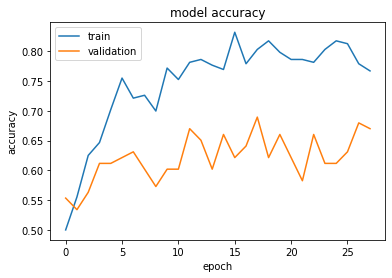

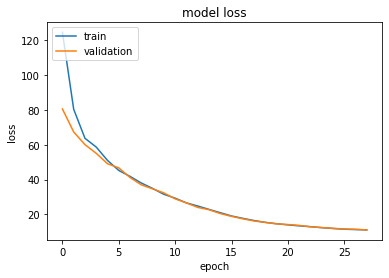

In [ ]:
print(bi_history.history.keys())
#  "Accuracy"
plt.plot(bi_history.history['accuracy'])
plt.plot(bi_history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# "Loss"
plt.plot(bi_history.history['loss'])
plt.plot(bi_history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [ ]:
predictions = model_final.predict(test_images)
preds = np.argmax(predictions, axis = 1)

In [ ]:
actuals = np.argmax(y_test, axis=1)

In [ ]:
from sklearn.metrics import accuracy_score
accuracy_score(preds, actuals)

0.6461538461538462

# Binary Classifier (II)

In [ ]:
x = base_model.output
x = Flatten()(x)
x = Dense(4096, name='fc1',  kernel_regularizer=keras.regularizers.l1(0.0001))(x)
x = Dropout(0.2)(x)
x = Dense(2048, name='fc2',  kernel_regularizer=keras.regularizers.l1(0.0001))(x)
x = Dense(2, activation='sigmoid', name='predictions')(x)
model_final = Model(inputs=base_model.input, outputs=x)

model_final.compile(loss="binary_crossentropy", optimizer=optimizers.Adam(learning_rate=0.001), metrics=["accuracy"])
model_final.summary()

Model: "functional_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)     

In [ ]:
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, TensorBoard, EarlyStopping

BATCH_SIZE = 100

weights_file = 'vgg16_binary_classifier2.h5'
checkpoint = ModelCheckpoint(weights_file, monitor='val_accuracy', verbose=1, save_best_only=True, 
                             save_weights_only=False, mode='auto')
early = EarlyStopping(monitor='val_accuracy', restore_best_weights=True, patience=10, verbose=1, mode='auto')
tensorboard = TensorBoard(log_dir='./logs', histogram_freq=0,
                          write_graph=True, write_images=False)

In [ ]:
bi_history = model_final.fit(datagen.flow(train_images, y_train, batch_size=32, subset='training'),
          batch_size=BATCH_SIZE,
          epochs= 100,
          verbose=1,
          validation_data=datagen.flow(train_images, y_train, batch_size=32, subset='validation'),
          callbacks = [checkpoint, early, tensorboard, keras.callbacks.ReduceLROnPlateau(factor=.5, patience=3, verbose=1)])

Epoch 1/100
13/13 [==============================] - ETA: 0s - loss: 172.5131 - accuracy: 0.5000
Epoch 00001: val_accuracy improved from -inf to 0.46602, saving model to vgg16_binary_classifier.h5
13/13 [==============================] - 13s 1s/step - loss: 172.5131 - accuracy: 0.5000 - val_loss: 179.6617 - val_accuracy: 0.4660
Epoch 2/100
13/13 [==============================] - ETA: 0s - loss: 112.7658 - accuracy: 0.5120
Epoch 00002: val_accuracy improved from 0.46602 to 0.51456, saving model to vgg16_binary_classifier.h5
13/13 [==============================] - 76s 6s/step - loss: 112.7658 - accuracy: 0.5120 - val_loss: 75.9893 - val_accuracy: 0.5146
Epoch 3/100
13/13 [==============================] - ETA: 0s - loss: 72.8007 - accuracy: 0.5312
Epoch 00003: val_accuracy improved from 0.51456 to 0.55340, saving model to vgg16_binary_classifier.h5
13/13 [==============================] - 25s 2s/step - loss: 72.8007 - accuracy: 0.5312 - val_loss: 61.7244 - val_accuracy: 0.5534
Epoch 4/

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy', 'lr'])


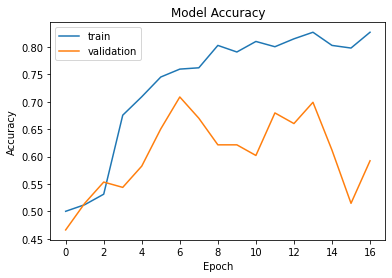

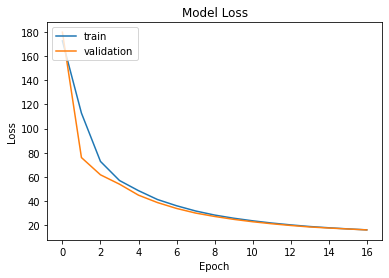

In [ ]:
print(bi_history.history.keys())
#  "Accuracy"
plt.plot(bi_history.history['accuracy'])
plt.plot(bi_history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.savefig('binary_model_acc.svg', transparent=True)
plt.show()
# "Loss"
plt.plot(bi_history.history['loss'])
plt.plot(bi_history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.savefig('binary_model_loss.svg', transparent=True)
plt.show()

In [ ]:
predictions = model_final.predict(test_images)
preds = np.argmax(predictions, axis = 1)

In [ ]:
actuals = np.argmax(y_test, axis=1)

In [ ]:
from sklearn.metrics import accuracy_score
accuracy_score(preds, actuals)

0.6692307692307692

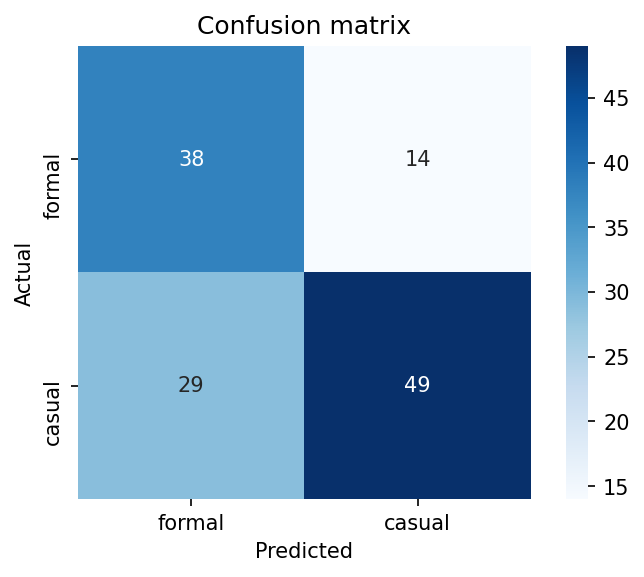

In [ ]:
confusion = (confusion_matrix(preds,actuals))

plt.figure(dpi=150)
sns.heatmap(confusion, cmap=plt.cm.Blues, annot=True, square=True,
           xticklabels=['formal', 'casual'],
           yticklabels=['formal', 'casual'])

plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion matrix')
plt.savefig('binary_confusion.svg', transparent=True);

# All Categories

In [ ]:
X_all = df1['full_path'].to_numpy()
y_all = df1['category'].replace({'formal': 0, 'casual': 1, 'punk_rock': 2, 'work': 3, 'work_out': 4, 'date_night': 5}).to_numpy()
X_train_all, X_test_all, y_train_all, y_test_all = train_test_split(X_all, y_all, test_size=0.2, random_state=55)

In [ ]:
X_train_all, X_val_all, y_train_all, y_val_all = train_test_split(X_train_all, y_train_all, test_size=0.2, stratify=y_train_all, random_state=55)

X = np.concatenate((X_train_all, X_val_all))
y = np.concatenate((y_train_all, y_val_all))

In [ ]:
train_paths = np.array([('/content/drive/My Drive' +'/data' + path[1:]) for path in X_train_all])
val_paths = np.array([('/content/drive/My Drive' +'/data' + path[1:]) for path in X_val_all])
test_paths = np.array([('/content/drive/My Drive' +'/data' + path[1:]) for path in X_test_all])

In [ ]:
from keras.preprocessing import image
    
def prepare_image(img_path):
    img = image.load_img(img_path, target_size=(224, 224))
    x = image.img_to_array(img)/255
    #x = np.expand_dims(x, axis=0)
    return x

In [ ]:
train_images_all = np.array([prepare_image(img_path) for img_path in train_paths])
val_images_all = np.array([prepare_image(img_path) for img_path in val_paths])
train_images_all[0].shape, val_images_all[0].shape

((224, 224, 3), (224, 224, 3))

In [ ]:
test_images_all = np.array([prepare_image(img_path) for img_path in test_paths])

In [ ]:
y_train_all = keras.utils.to_categorical(y_train_all, num_classes=6, dtype='float32')
y_val_all = keras.utils.to_categorical(y_val_all, num_classes=6, dtype='float32')
y_test_all = keras.utils.to_categorical(y_test_all, num_classes=6, dtype='float32')

In [ ]:
base_model = applications.vgg16.VGG16(weights='imagenet', include_top=False, input_shape = (224,224,3))
for layer in base_model.layers:
    layer.trainable = False
base_model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [ ]:
x = base_model.output
x = Flatten()(x)
x = Dense(4096, name='fc1',  kernel_regularizer=keras.regularizers.l2(0.0001))(x)
x = Dropout(0.05)(x)
x = Dense(2048, name='fc2',  kernel_regularizer=keras.regularizers.l2(0.0001))(x)
x = Dense(6, activation='softmax', name='predictions')(x)
new_model_final = Model(inputs=base_model.input, outputs=x)

new_model_final.compile(loss="categorical_crossentropy", optimizer=optimizers.Adam(learning_rate=0.001), metrics=["accuracy"])
new_model_final.summary()

Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)      

In [ ]:
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, TensorBoard, EarlyStopping

BATCH_SIZE = 32

weights_file = 'vgg16_multi_classifier.h5'
checkpoint = ModelCheckpoint(weights_file, monitor='val_accuracy', verbose=1, save_best_only=True, 
                             save_weights_only=False, mode='auto')
early = EarlyStopping(monitor='val_accuracy', restore_best_weights=True, patience=8, verbose=1, mode='auto')
tensorboard = TensorBoard(log_dir='./logs', histogram_freq=0,
                          write_graph=True, write_images=False)

In [ ]:
datagen = ImageDataGenerator(
    featurewise_center=True,
    featurewise_std_normalization=True,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    validation_split=0.2)

datagen.fit(train_images_all)



In [ ]:
new_history = new_model_final.fit(datagen.flow(train_images_all, y_train_all, batch_size=32, subset='training'),
          batch_size=BATCH_SIZE,
          epochs= 100,
          verbose=1,
          validation_data=datagen.flow(train_images_all, y_train_all, batch_size=32, subset='validation'),
          callbacks = [checkpoint, early, tensorboard, keras.callbacks.ReduceLROnPlateau(factor=.5, patience=3, verbose=1)])

Epoch 1/100
41/41 [==============================] - ETA: 0s - loss: 154.0357 - accuracy: 0.2147
Epoch 00001: val_accuracy improved from -inf to 0.29052, saving model to vgg16_multi_classifier.h5
41/41 [==============================] - 26s 639ms/step - loss: 154.0357 - accuracy: 0.2147 - val_loss: 19.5869 - val_accuracy: 0.2905
Epoch 2/100
41/41 [==============================] - ETA: 0s - loss: 13.7815 - accuracy: 0.3086
Epoch 00002: val_accuracy did not improve from 0.29052
41/41 [==============================] - 20s 478ms/step - loss: 13.7815 - accuracy: 0.3086 - val_loss: 7.1361 - val_accuracy: 0.2232
Epoch 3/100
41/41 [==============================] - ETA: 0s - loss: 4.4469 - accuracy: 0.3667
Epoch 00003: val_accuracy improved from 0.29052 to 0.34862, saving model to vgg16_multi_classifier.h5
41/41 [==============================] - 25s 621ms/step - loss: 4.4469 - accuracy: 0.3667 - val_loss: 4.0882 - val_accuracy: 0.3486
Epoch 4/100
41/41 [==============================] - ETA

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy', 'lr'])


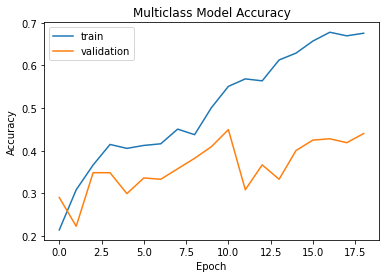

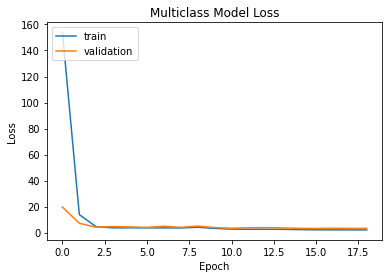

In [ ]:
print(new_history.history.keys())
#  "Accuracy"
plt.plot(new_history.history['accuracy'])
plt.plot(new_history.history['val_accuracy'])
plt.title('Multiclass Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.savefig('multi_model_acc.svg', transparent=True)
plt.show()
# "Loss"
plt.plot(new_history.history['loss'])
plt.plot(new_history.history['val_loss'])
plt.title('Multiclass Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.savefig('multi_model_loss.svg', transparent=True)
plt.show()

In [ ]:
predictions = new_model_final.predict(test_images_all)
preds = np.argmax(predictions, axis = 1)
actuals = np.argmax(y_test_all, axis=1)

In [ ]:
from sklearn.metrics import accuracy_score
accuracy_score(preds, actuals)

0.333984375

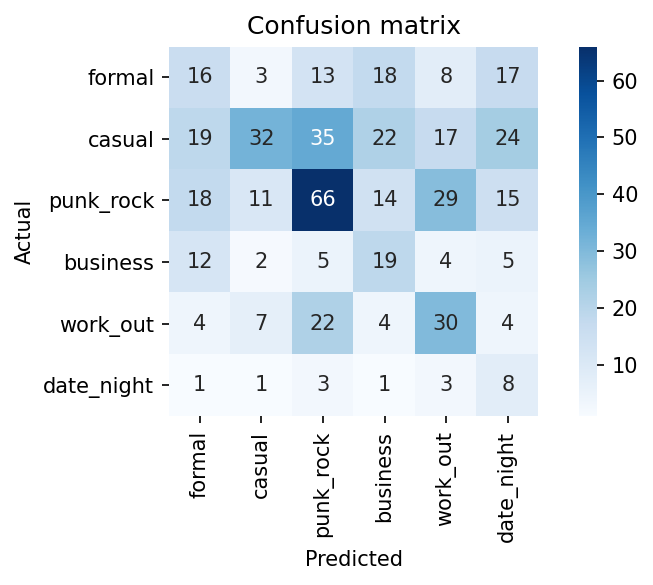

In [ ]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
confusion = (confusion_matrix(preds,actuals))

plt.figure(dpi=150)
sns.heatmap(confusion, cmap=plt.cm.Blues, annot=True, square=True,
           xticklabels=['formal', 'casual', 'punk_rock', 'business', 'work_out', 'date_night'],
           yticklabels=['formal', 'casual', 'punk_rock', 'business', 'work_out', 'date_night'])

plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion matrix')
plt.tight_layout()
plt.savefig('multi_confusion.svg', transparent=True);

# Making Predictions

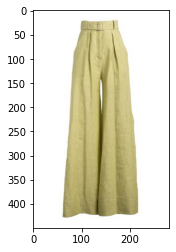

In [ ]:
img = image.img_to_array(image.load_img('/content/2ca60e0a-a667-4d40-8d45-34fde2fb1b7e.jpg'))
plt.imshow(img/255)

In [ ]:
prepped = prepare_image('/content/2ca60e0a-a667-4d40-8d45-34fde2fb1b7e.jpg')
prepped = np.expand_dims(prepped, axis=0)
new_model_final.predict(prepped)

array([[0.13122618, 0.50611687, 0.00587751, 0.33609518, 0.00613216,
        0.01455211]], dtype=float32)

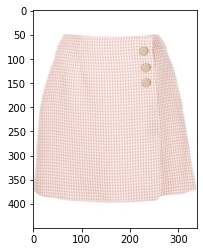

In [ ]:
img = image.img_to_array(image.load_img('/content/219133ae-07a0-4cd9-a444-3352dd224c7f.jpeg'))
plt.imshow(img/255)

In [ ]:
prepped = prepare_image('/content/219133ae-07a0-4cd9-a444-3352dd224c7f.jpeg')
prepped = np.expand_dims(prepped, axis=0)
new_model_final.predict(prepped)

array([[0.044475  , 0.4552345 , 0.38763723, 0.05985582, 0.05175009,
        0.00104745]], dtype=float32)

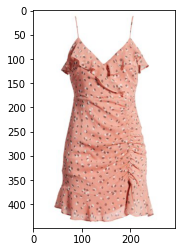

In [ ]:
img = image.img_to_array(image.load_img('/content/68290593-d08f-4bbb-86db-dbbd1c1b2d48.jpeg'))
plt.imshow(img/255)

In [ ]:
prepped = prepare_image('/content/68290593-d08f-4bbb-86db-dbbd1c1b2d48.jpeg')
prepped = np.expand_dims(prepped, axis=0)
new_model_final.predict(prepped)

array([[0.017, 0.003, 0.004, 0.044, 0.   , 0.932]], dtype=float32)

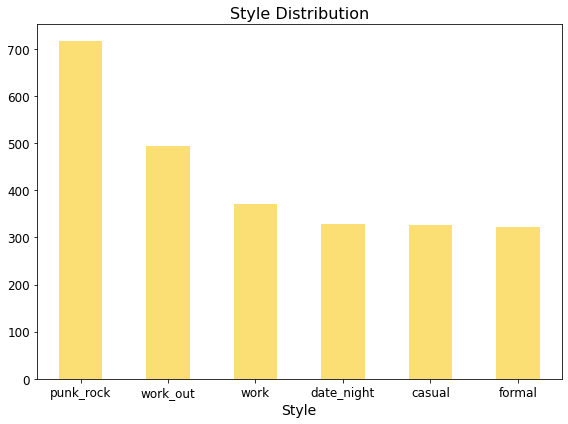

In [ ]:
plt.figure(figsize=(8,6))
df1['category'].value_counts().plot.bar(color='#fbdf74')
plt.xticks(rotation=0, size=12)
plt.yticks(size=12)
plt.title('Style Distribution', size=16)
plt.xlabel('Style', size=14)
plt.tight_layout()
plt.savefig('style_dist.svg', transparent=True)

In [ ]:
df1.drop(columns=['Unnamed: 0', 'index']).groupby('category').count()

,brand,name,price,likes,product_url,image_url,image_path,set_id,full_path,clothing_item
category,,,,,,,,,,
casual,238,327,251,319,327,327,327,327,327,327
date_night,248,329,244,315,329,329,329,329,329,329
formal,259,322,271,314,322,322,322,322,322,322
punk_rock,183,716,235,704,716,716,716,716,716,716
work,284,370,295,363,370,370,370,370,370,370
work_out,315,493,313,479,493,493,493,493,493,493


In [1]:
!pip install pygal

You should consider upgrading via the '/Users/emilyng/anaconda3/envs/metis/bin/python3.8 -m pip install --upgrade pip' command.


In [2]:
import numpy as np
confusion = np.array([[0.73, 0.27], [0.37, 0.63]])

In [3]:
import pygal
from IPython.display import display, HTML
from pygal.style import RedBlueStyle

base_html = """
<!DOCTYPE html>
<html>
  <head>
  <script type="text/javascript" src="http://kozea.github.com/pygal.js/javascripts/svg.jquery.js"></script>
  <script type="text/javascript" src="https://kozea.github.io/pygal.js/2.0.x/pygal-tooltips.min.js""></script>
  </head>
  <body>
    <figure>
      {rendered_chart}
    </figure>
  </body>
</html>
"""  

In [4]:
def galplot(chart):
    rendered_chart = chart.render(is_unicode=True)
    plot_html = base_html.format(rendered_chart=rendered_chart)
    display(HTML(plot_html))

In [5]:
labels = ['formal', 'casual']
cm = confusion
dot_chart = pygal.Dot(x_label_rotation=30, interpolate='cubic', style=RedBlueStyle)
dot_chart.title = 'Confusion Matrix'
dot_chart.x_labels = labels
dot_chart.x_title = "Predicted"
dot_chart.y_title = "Actual"
for i in range(len(labels)):
    dot_chart.add(labels[i], cm[i,:])

In [6]:
galplot(dot_chart)

In [7]:
multi_confusion = np.array([[16, 3, 13, 18, 8, 17], [19, 32, 35, 22, 17, 24],
                            [18, 11,  66, 14, 29, 15], [12, 2, 5, 19, 4, 5],
                            [4, 7, 22, 4, 30, 4], [1, 1, 3, 1, 3, 8]])
labels = ['formal', 'casual', 'punk rock', 'work', 'work out', 'date night']
cm = multi_confusion
dot_chart = pygal.Dot(x_label_rotation=30, interpolate='cubic', style=RedBlueStyle)
dot_chart.title = 'Confusion Matrix'
dot_chart.x_labels = labels
dot_chart.x_title = "Predicted"
dot_chart.y_title = "Actual"
for i in range(len(labels)):
    dot_chart.add(labels[i], cm[i,:])

galplot(dot_chart)

In [8]:
def normalize(row):
  total = row.sum()
  return row/total

normalize(multi_confusion[0])

array([0.21333333, 0.04      , 0.17333333, 0.24      , 0.10666667,
       0.22666667])

In [14]:
import pandas as pd
multi_df = pd.DataFrame(multi_confusion)
normed = multi_df.apply(normalize, axis=1)
normed

,0,1,2,3,4,5
0,0.213333,0.040000,0.173333,0.240000,0.106667,0.226667
1,0.127517,0.214765,0.234899,0.147651,0.114094,0.161074
2,0.117647,0.071895,0.431373,0.091503,0.189542,0.098039
3,0.255319,0.042553,0.106383,0.404255,0.085106,0.106383
4,0.056338,0.098592,0.309859,0.056338,0.422535,0.056338
5,0.058824,0.058824,0.176471,0.058824,0.176471,0.470588


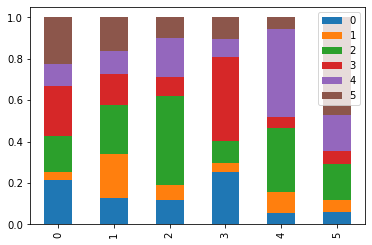

In [15]:
ax = normed.plot(kind="bar", stacked=True)

In [13]:
labels = ['formal', 'casual', 'punk rock', 'work', 'work out', 'date night']
cm = normed.to_numpy()
dot_chart = pygal.Dot(x_label_rotation=30, interpolate='cubic', style=RedBlueStyle)
dot_chart.title = 'Confusion Matrix'
dot_chart.x_labels = labels
dot_chart.x_title = "Predicted"
dot_chart.y_title = "Actual"
for i in range(len(labels)):
    dot_chart.add(labels[i], cm[i,:])

galplot(dot_chart)